In [1]:
%reload_kedro

2020-02-05 12:15:06,806 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-02-05 12:15:06,807 - root - INFO - Defined global variable `context` and `catalog`


In this notebook, we introduce topic modeling methods through the [UN General Debates Dataset from Kaggle](https://www.kaggle.com/unitednations/un-general-debates), using [gensim](https://radimrehurek.com/gensim/).

In [2]:
import pandas as pd
from tqdm import tqdm

# Data

In [4]:
docs = pd.read_csv('data/01_raw/un-general-debates.csv', index_col=0)
print(len(docs))
docs.head()

7507


,year,country,text
session,,,
44,1989,MDV,﻿It is indeed a pleasure for me and the member...
44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
44,1989,URY,﻿\nDuring the debate at the fortieth session o...
44,1989,ZWE,﻿I should like at the outset to express my del...


In [4]:
docs = docs.reset_index().drop(columns=['session', 'country'])

# Preprocessing

In [5]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary, MmCorpus

In [6]:
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [7]:
docs['text'] = docs['text'].str.lower()

In [8]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
for idx in tqdm(range(len(docs))):
    docs['text'][idx] = tokenizer.tokenize(docs['text'][idx])  # Split into words.
    docs['text'][idx] = [w for w in docs['text'][idx] if not w in stop_words]

# Remove numbers, but not words that contain numbers.
docs['text'] = [[token for token in doc if not token.isnumeric()] for doc in docs['text']]

# Remove words that are only one character.
docs['text'] = [[token for token in doc if len(token) > 1] for doc in docs['text']]

  0%|          | 0/7507 [00:00<?, ?it/s]/home/alexandre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/alexandre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 7507/7507 [00:12<00:00, 606.64it/s]


In [9]:
# Lemmatize the documents
lemmatizer = WordNetLemmatizer()
%time docs['text'] = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs['text']]

CPU times: user 35.7 s, sys: 68.2 ms, total: 35.8 s
Wall time: 35.8 s


In [10]:
dictionary = Dictionary(docs['text'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

2020-02-05 11:55:37,071 - gensim.corpora.dictionary - INFO - adding document #0 to Dictionary(0 unique tokens: [])
2020-02-05 11:55:47,607 - gensim.corpora.dictionary - INFO - built Dictionary(46754 unique tokens: ['1980s', 'ability', 'able', 'abuse', 'acceptance']...) from 7507 documents (total 11265309 corpus positions)
2020-02-05 11:55:47,686 - gensim.corpora.dictionary - INFO - discarding 34295 tokens: [('able', 4484), ('achieved', 4103), ('act', 4832), ('action', 6318), ('activity', 3968), ('africa', 5200), ('agenda', 3923), ('ago', 4130), ('agreement', 5357), ('already', 4186)]...
2020-02-05 11:55:47,686 - gensim.corpora.dictionary - INFO - keeping 12459 tokens which were in no less than 20 and no more than 3753 (=50.0%) documents
2020-02-05 11:55:47,721 - gensim.corpora.dictionary - INFO - resulting dictionary: Dictionary(12459 unique tokens: ['1980s', 'ability', 'abuse', 'acceptance', 'accident']...)


In [11]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in tqdm(docs['text'])]

100%|██████████| 7507/7507 [00:04<00:00, 1625.41it/s]


In [12]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 12459
Number of documents: 7507


In [13]:
MmCorpus.serialize('data/05_model_input/UNGD.mm', corpus)
dictionary.save('data/05_model_input/UNGD.dict')

2020-02-05 11:55:52,439 - gensim.corpora.mmcorpus - INFO - storing corpus in Matrix Market format to data/05_model_input/UNGD.mm
2020-02-05 11:55:52,533 - gensim.matutils - INFO - saving sparse matrix to data/05_model_input/UNGD.mm
2020-02-05 11:55:52,534 - gensim.matutils - INFO - PROGRESS: saving document #0
2020-02-05 11:55:53,096 - gensim.matutils - INFO - PROGRESS: saving document #1000
2020-02-05 11:55:53,620 - gensim.matutils - INFO - PROGRESS: saving document #2000
2020-02-05 11:55:54,182 - gensim.matutils - INFO - PROGRESS: saving document #3000
2020-02-05 11:55:54,786 - gensim.matutils - INFO - PROGRESS: saving document #4000
2020-02-05 11:55:55,309 - gensim.matutils - INFO - PROGRESS: saving document #5000
2020-02-05 11:55:55,872 - gensim.matutils - INFO - PROGRESS: saving document #6000
2020-02-05 11:55:56,456 - gensim.matutils - INFO - PROGRESS: saving document #7000
2020-02-05 11:55:56,660 - gensim.matutils - INFO - saved 7507x12459 matrix, density=4.527% (4234124/9352971

# Training

In [3]:
from gensim.corpora import Dictionary, MmCorpus

corpus = MmCorpus('./data/05_model_input/UNGD.mm')
dictionary = Dictionary.load('./data/05_model_input/UNGD.dict')

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

2020-02-05 12:15:18,950 - gensim.corpora.indexedcorpus - INFO - loaded corpus index from ./data/05_model_input/UNGD.mm.index
2020-02-05 12:15:18,950 - gensim.corpora._mmreader - INFO - initializing cython corpus reader from ./data/05_model_input/UNGD.mm
2020-02-05 12:15:18,967 - gensim.corpora._mmreader - INFO - accepted corpus with 7507 documents, 12459 features, 4234124 non-zero entries
2020-02-05 12:15:18,968 - gensim.utils - INFO - loading Dictionary object from ./data/05_model_input/UNGD.dict
2020-02-05 12:15:18,985 - gensim.utils - INFO - loaded ./data/05_model_input/UNGD.dict
Number of unique tokens: 12459
Number of documents: 7507


In [10]:
from gensim.models import LdaModel, LdaMulticore

In [16]:
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, \
                       id2word=id2word, \
                       chunksize=chunksize, \
                       alpha='auto', \
                       eta='auto', \
                       iterations=iterations, \
                       num_topics=num_topics, \
                       passes=passes, \
                       eval_every=eval_every)

2020-02-05 01:26:29,234 - gensim.models.ldamodel - INFO - using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2020-02-05 01:26:29,237 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-02-05 01:26:29,274 - gensim.models.ldamodel - INFO - running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 7507 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2020-02-05 01:26:29,719 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #2000/7507
2020-02-05 01:26:48,544 - gensim.models.ldamodel - INFO - optimized alpha [0.07047312, 0.03963942, 0.07469168, 0.1103865, 0.09988363, 0.07423125, 0.1117016, 0.071387425, 0.071124494, 0.104756944]
2020-02-05 01:26:48,554 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 01:26:48,593 - gensim.m

2020-02-05 01:27:38,470 - gensim.models.ldamodel - INFO - topic #0 (0.040): 0.009*"japan" + 0.006*"european" + 0.005*"union" + 0.004*"bosnia" + 0.004*"herzegovina" + 0.004*"ireland" + 0.004*"croatia" + 0.003*"europe" + 0.003*"guinea" + 0.003*"georgia"
2020-02-05 01:27:38,471 - gensim.models.ldamodel - INFO - topic #7 (0.071): 0.005*"sustainable" + 0.004*"small" + 0.004*"climate" + 0.004*"millennium" + 0.003*"terrorism" + 0.003*"democracy" + 0.003*"drug" + 0.003*"per" + 0.003*"caribbean" + 0.003*"summit"
2020-02-05 01:27:38,472 - gensim.models.ldamodel - INFO - topic #3 (0.075): 0.003*"democracy" + 0.003*"european" + 0.003*"europe" + 0.002*"union" + 0.002*"keeping" + 0.002*"treaty" + 0.002*"somalia" + 0.002*"terrorism" + 0.002*"summit" + 0.002*"disarmament"
2020-02-05 01:27:38,473 - gensim.models.ldamodel - INFO - topic #6 (0.086): 0.005*"terrorism" + 0.005*"island" + 0.004*"climate" + 0.004*"pacific" + 0.003*"small" + 0.003*"sustainable" + 0.003*"let" + 0.002*"address" + 0.002*"afghani

2020-02-05 01:28:12,707 - gensim.models.ldamodel - INFO - topic diff=0.277183, rho=0.384800
2020-02-05 01:28:13,254 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #4000/7507
2020-02-05 01:28:21,615 - gensim.models.ldamodel - INFO - optimized alpha [0.033327665, 0.021898435, 0.06744023, 0.069917195, 0.04666145, 0.068414845, 0.077963255, 0.07430829, 0.04533991, 0.047749665]
2020-02-05 01:28:21,622 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 01:28:21,629 - gensim.models.ldamodel - INFO - topic #1 (0.022): 0.025*"cyprus" + 0.017*"turkey" + 0.014*"turkish" + 0.014*"malta" + 0.013*"mediterranean" + 0.011*"cypriot" + 0.011*"azerbaijan" + 0.010*"greece" + 0.009*"greek" + 0.008*"european"
2020-02-05 01:28:21,631 - gensim.models.ldamodel - INFO - topic #0 (0.033): 0.012*"european" + 0.008*"japan" + 0.008*"union" + 0.007*"europe" + 0.005*"ireland" + 0.004*"bosnia" + 0.004*"kosovo" + 0.004*"herzegovina" + 0.003*"p

2020-02-05 01:28:54,025 - gensim.models.ldamodel - INFO - topic #6 (0.080): 0.006*"island" + 0.005*"terrorism" + 0.005*"pacific" + 0.004*"climate" + 0.004*"small" + 0.003*"let" + 0.003*"address" + 0.003*"sustainable" + 0.003*"leader" + 0.003*"look"
2020-02-05 01:28:54,026 - gensim.models.ldamodel - INFO - topic #7 (0.081): 0.006*"sustainable" + 0.005*"small" + 0.005*"climate" + 0.005*"millennium" + 0.004*"per" + 0.004*"terrorism" + 0.003*"caribbean" + 0.003*"cent" + 0.003*"summit" + 0.003*"woman"
2020-02-05 01:28:54,027 - gensim.models.ldamodel - INFO - topic diff=0.222607, rho=0.359130
2020-02-05 01:28:54,542 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #6000/7507
2020-02-05 01:29:03,671 - gensim.models.ldamodel - INFO - optimized alpha [0.035260603, 0.020497065, 0.07726668, 0.071061514, 0.04632127, 0.072291814, 0.08294283, 0.083413474, 0.044814967, 0.052328546]
2020-02-05 01:29:03,680 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a mode

2020-02-05 01:29:32,522 - gensim.models.ldamodel - INFO - topic #0 (0.039): 0.015*"european" + 0.009*"europe" + 0.008*"union" + 0.006*"japan" + 0.004*"terrorism" + 0.004*"ireland" + 0.004*"proliferation" + 0.004*"treaty" + 0.004*"bosnia" + 0.004*"peacekeeping"
2020-02-05 01:29:32,523 - gensim.models.ldamodel - INFO - topic #2 (0.086): 0.006*"america" + 0.005*"american" + 0.004*"latin" + 0.004*"democracy" + 0.003*"central" + 0.003*"century" + 0.003*"solidarity" + 0.003*"say" + 0.002*"know" + 0.002*"reason"
2020-02-05 01:29:32,524 - gensim.models.ldamodel - INFO - topic #6 (0.087): 0.007*"island" + 0.005*"terrorism" + 0.005*"pacific" + 0.004*"small" + 0.004*"climate" + 0.004*"let" + 0.003*"terrorist" + 0.003*"address" + 0.003*"sustainable" + 0.003*"woman"
2020-02-05 01:29:32,526 - gensim.models.ldamodel - INFO - topic #7 (0.090): 0.007*"sustainable" + 0.006*"climate" + 0.006*"small" + 0.005*"millennium" + 0.004*"terrorism" + 0.004*"per" + 0.004*"caribbean" + 0.004*"cent" + 0.003*"woman" 

2020-02-05 01:30:00,129 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #7507/7507
2020-02-05 01:30:04,830 - gensim.models.ldamodel - INFO - optimized alpha [0.045929637, 0.019847333, 0.09665673, 0.08434875, 0.04830194, 0.08512635, 0.0932927, 0.09792205, 0.047398277, 0.06217726]
2020-02-05 01:30:04,837 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 01:30:04,880 - gensim.models.ldamodel - INFO - topic #1 (0.020): 0.029*"cyprus" + 0.020*"turkey" + 0.015*"turkish" + 0.014*"azerbaijan" + 0.013*"malta" + 0.013*"mediterranean" + 0.012*"cypriot" + 0.012*"greece" + 0.011*"greek" + 0.011*"italy"
2020-02-05 01:30:04,882 - gensim.models.ldamodel - INFO - topic #0 (0.046): 0.014*"european" + 0.010*"europe" + 0.008*"union" + 0.005*"japan" + 0.005*"terrorism" + 0.004*"bosnia" + 0.004*"treaty" + 0.004*"proliferation" + 0.004*"peacekeeping" + 0.003*"humanitarian"
2020-02-05 01:30:04,883 - gensim.models.ldamodel - INFO - t

2020-02-05 01:30:32,232 - gensim.models.ldamodel - INFO - topic #7 (0.103): 0.007*"sustainable" + 0.006*"millennium" + 0.006*"climate" + 0.006*"small" + 0.005*"terrorism" + 0.004*"per" + 0.004*"summit" + 0.004*"caribbean" + 0.004*"cent" + 0.003*"woman"
2020-02-05 01:30:32,234 - gensim.models.ldamodel - INFO - topic #2 (0.103): 0.006*"america" + 0.005*"american" + 0.004*"latin" + 0.004*"democracy" + 0.003*"central" + 0.003*"century" + 0.003*"solidarity" + 0.003*"say" + 0.003*"know" + 0.002*"reason"
2020-02-05 01:30:32,235 - gensim.models.ldamodel - INFO - topic diff=0.134648, rho=0.304948
2020-02-05 01:30:33,480 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #2000/7507
2020-02-05 01:30:40,235 - gensim.models.ldamodel - INFO - optimized alpha [0.05278216, 0.019857036, 0.104230195, 0.08994243, 0.050780818, 0.093722045, 0.10044143, 0.104448594, 0.048850782, 0.067791305]
2020-02-05 01:30:40,244 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a mod

2020-02-05 01:31:07,944 - gensim.models.ldamodel - INFO - topic #8 (0.050): 0.015*"soviet" + 0.009*"disarmament" + 0.009*"union" + 0.009*"afghanistan" + 0.008*"europe" + 0.007*"co" + 0.006*"treaty" + 0.006*"proposal" + 0.005*"pakistan" + 0.005*"socialist"
2020-02-05 01:31:07,945 - gensim.models.ldamodel - INFO - topic #6 (0.106): 0.007*"island" + 0.005*"pacific" + 0.005*"terrorism" + 0.005*"let" + 0.004*"small" + 0.003*"child" + 0.003*"climate" + 0.003*"look" + 0.003*"leader" + 0.003*"address"
2020-02-05 01:31:07,946 - gensim.models.ldamodel - INFO - topic #7 (0.108): 0.007*"sustainable" + 0.006*"climate" + 0.006*"small" + 0.006*"millennium" + 0.005*"terrorism" + 0.004*"per" + 0.004*"caribbean" + 0.004*"cent" + 0.003*"summit" + 0.003*"food"
2020-02-05 01:31:07,947 - gensim.models.ldamodel - INFO - topic #2 (0.109): 0.006*"america" + 0.006*"american" + 0.004*"latin" + 0.004*"democracy" + 0.003*"central" + 0.003*"solidarity" + 0.003*"century" + 0.003*"say" + 0.002*"know" + 0.002*"reason"

2020-02-05 01:31:43,665 - gensim.models.ldamodel - INFO - optimized alpha [0.06213723, 0.020143026, 0.11420552, 0.094147444, 0.05651501, 0.112510644, 0.11012067, 0.108868234, 0.052144703, 0.07605461]
2020-02-05 01:31:43,672 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 01:31:43,680 - gensim.models.ldamodel - INFO - topic #1 (0.020): 0.032*"cyprus" + 0.021*"turkey" + 0.018*"turkish" + 0.016*"mediterranean" + 0.016*"malta" + 0.014*"cypriot" + 0.013*"azerbaijan" + 0.013*"greece" + 0.012*"greek" + 0.012*"italy"
2020-02-05 01:31:43,681 - gensim.models.ldamodel - INFO - topic #8 (0.052): 0.016*"soviet" + 0.010*"disarmament" + 0.009*"union" + 0.008*"afghanistan" + 0.008*"europe" + 0.008*"co" + 0.007*"treaty" + 0.006*"proposal" + 0.005*"pakistan" + 0.005*"socialist"
2020-02-05 01:31:43,682 - gensim.models.ldamodel - INFO - topic #6 (0.110): 0.007*"island" + 0.005*"pacific" + 0.005*"let" + 0.005*"small" + 0.004*"terrorism" + 0.00

2020-02-05 01:32:08,458 - gensim.models.ldamodel - INFO - topic #5 (0.118): 0.011*"co" + 0.005*"disarmament" + 0.003*"namibia" + 0.003*"mankind" + 0.003*"sea" + 0.003*"apartheid" + 0.003*"tension" + 0.002*"field" + 0.002*"committee" + 0.002*"race"
2020-02-05 01:32:08,459 - gensim.models.ldamodel - INFO - topic diff=0.093017, rho=0.260347
2020-02-05 01:32:08,957 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #6000/7507
2020-02-05 01:32:14,778 - gensim.models.ldamodel - INFO - optimized alpha [0.0676507, 0.020311102, 0.11763517, 0.093745604, 0.05888776, 0.11476272, 0.117627084, 0.114956684, 0.052504428, 0.08191361]
2020-02-05 01:32:14,787 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 01:32:14,797 - gensim.models.ldamodel - INFO - topic #1 (0.020): 0.034*"cyprus" + 0.022*"turkey" + 0.018*"turkish" + 0.016*"mediterranean" + 0.015*"malta" + 0.014*"azerbaijan" + 0.014*"cypriot" + 0.013*"greece" + 0.012*"greek

2020-02-05 01:32:42,410 - gensim.models.ldamodel - INFO - topic #5 (0.119): 0.010*"co" + 0.005*"disarmament" + 0.003*"namibia" + 0.003*"mankind" + 0.003*"sea" + 0.003*"apartheid" + 0.003*"tension" + 0.002*"field" + 0.002*"race" + 0.002*"committee"
2020-02-05 01:32:42,411 - gensim.models.ldamodel - INFO - topic #2 (0.120): 0.007*"america" + 0.006*"american" + 0.005*"latin" + 0.004*"democracy" + 0.004*"central" + 0.003*"solidarity" + 0.003*"century" + 0.003*"say" + 0.002*"reason" + 0.002*"know"
2020-02-05 01:32:42,412 - gensim.models.ldamodel - INFO - topic #6 (0.122): 0.006*"island" + 0.005*"pacific" + 0.005*"let" + 0.004*"small" + 0.004*"terrorism" + 0.003*"child" + 0.003*"look" + 0.003*"leader" + 0.003*"woman" + 0.003*"address"
2020-02-05 01:32:42,413 - gensim.models.ldamodel - INFO - topic diff=0.078108, rho=0.251948
2020-02-05 01:32:42,832 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #7507/7507
2020-02-05 01:32:47,419 - gensim.models.ldamodel - INFO - optimized a

2020-02-05 01:33:12,520 - gensim.models.ldamodel - INFO - topic #1 (0.021): 0.032*"cyprus" + 0.022*"turkey" + 0.017*"turkish" + 0.015*"mediterranean" + 0.015*"azerbaijan" + 0.015*"malta" + 0.014*"cypriot" + 0.013*"greece" + 0.013*"greek" + 0.012*"italy"
2020-02-05 01:33:12,521 - gensim.models.ldamodel - INFO - topic #8 (0.056): 0.016*"soviet" + 0.010*"europe" + 0.010*"union" + 0.010*"disarmament" + 0.009*"co" + 0.008*"afghanistan" + 0.007*"treaty" + 0.006*"korea" + 0.006*"proposal" + 0.006*"asia"
2020-02-05 01:33:12,522 - gensim.models.ldamodel - INFO - topic #7 (0.122): 0.007*"sustainable" + 0.007*"climate" + 0.006*"millennium" + 0.006*"small" + 0.006*"terrorism" + 0.004*"per" + 0.004*"summit" + 0.004*"cent" + 0.004*"caribbean" + 0.004*"island"
2020-02-05 01:33:12,523 - gensim.models.ldamodel - INFO - topic #2 (0.123): 0.007*"america" + 0.006*"american" + 0.005*"latin" + 0.004*"democracy" + 0.004*"central" + 0.003*"solidarity" + 0.003*"century" + 0.003*"say" + 0.003*"know" + 0.003*"re

2020-02-05 01:33:38,593 - gensim.models.ldamodel - INFO - topic diff=0.078316, rho=0.237333
2020-02-05 01:33:39,101 - gensim.models.ldamodel - INFO - PROGRESS: pass 14, at document #2000/7507
2020-02-05 01:33:45,029 - gensim.models.ldamodel - INFO - optimized alpha [0.08088161, 0.020940296, 0.12553051, 0.10473048, 0.061275214, 0.12659866, 0.13196693, 0.12589964, 0.057285324, 0.08596449]
2020-02-05 01:33:45,038 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 01:33:45,077 - gensim.models.ldamodel - INFO - topic #1 (0.021): 0.033*"cyprus" + 0.022*"turkey" + 0.018*"turkish" + 0.015*"malta" + 0.015*"mediterranean" + 0.015*"cypriot" + 0.014*"azerbaijan" + 0.014*"greece" + 0.013*"greek" + 0.012*"italy"
2020-02-05 01:33:45,078 - gensim.models.ldamodel - INFO - topic #8 (0.057): 0.016*"soviet" + 0.010*"europe" + 0.010*"disarmament" + 0.010*"union" + 0.009*"co" + 0.008*"afghanistan" + 0.007*"korea" + 0.007*"treaty" + 0.006*"proposal

2020-02-05 01:34:10,794 - gensim.models.ldamodel - INFO - topic #5 (0.130): 0.011*"co" + 0.005*"disarmament" + 0.003*"mankind" + 0.003*"namibia" + 0.003*"sea" + 0.003*"apartheid" + 0.003*"tension" + 0.002*"field" + 0.002*"committee" + 0.002*"race"
2020-02-05 01:34:10,796 - gensim.models.ldamodel - INFO - topic #6 (0.136): 0.005*"island" + 0.005*"let" + 0.005*"pacific" + 0.004*"small" + 0.003*"child" + 0.003*"terrorism" + 0.003*"look" + 0.003*"leader" + 0.003*"want" + 0.003*"others"
2020-02-05 01:34:10,797 - gensim.models.ldamodel - INFO - topic diff=0.058005, rho=0.224998
2020-02-05 01:34:11,349 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #4000/7507
2020-02-05 01:34:18,392 - gensim.models.ldamodel - INFO - optimized alpha [0.081964366, 0.021212285, 0.12715428, 0.10430411, 0.064125985, 0.13545099, 0.13409187, 0.12396258, 0.058937293, 0.08665063]
2020-02-05 01:34:18,401 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documen

2020-02-05 01:34:44,210 - gensim.models.ldamodel - INFO - topic #8 (0.060): 0.017*"soviet" + 0.010*"disarmament" + 0.010*"europe" + 0.010*"union" + 0.009*"co" + 0.007*"afghanistan" + 0.007*"treaty" + 0.007*"korea" + 0.006*"proposal" + 0.006*"asia"
2020-02-05 01:34:44,211 - gensim.models.ldamodel - INFO - topic #2 (0.128): 0.007*"america" + 0.006*"american" + 0.005*"latin" + 0.004*"democracy" + 0.004*"central" + 0.003*"solidarity" + 0.003*"century" + 0.003*"say" + 0.003*"reason" + 0.002*"know"
2020-02-05 01:34:44,212 - gensim.models.ldamodel - INFO - topic #6 (0.137): 0.005*"let" + 0.005*"island" + 0.005*"pacific" + 0.004*"small" + 0.003*"child" + 0.003*"leader" + 0.003*"look" + 0.003*"want" + 0.003*"others" + 0.003*"terrorism"
2020-02-05 01:34:44,212 - gensim.models.ldamodel - INFO - topic #5 (0.138): 0.011*"co" + 0.005*"disarmament" + 0.004*"namibia" + 0.003*"mankind" + 0.003*"sea" + 0.003*"apartheid" + 0.003*"tension" + 0.002*"field" + 0.002*"committee" + 0.002*"race"
2020-02-05 01:3

2020-02-05 01:35:17,078 - gensim.models.ldamodel - INFO - optimized alpha [0.0877918, 0.02155855, 0.12906715, 0.10386084, 0.06644497, 0.13723248, 0.14275554, 0.12975432, 0.05940599, 0.090545595]
2020-02-05 01:35:17,085 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 01:35:17,093 - gensim.models.ldamodel - INFO - topic #1 (0.022): 0.035*"cyprus" + 0.023*"turkey" + 0.019*"turkish" + 0.017*"mediterranean" + 0.016*"malta" + 0.015*"azerbaijan" + 0.015*"cypriot" + 0.014*"greece" + 0.013*"greek" + 0.012*"italy"
2020-02-05 01:35:17,094 - gensim.models.ldamodel - INFO - topic #8 (0.059): 0.017*"soviet" + 0.010*"disarmament" + 0.010*"union" + 0.010*"europe" + 0.009*"co" + 0.008*"afghanistan" + 0.007*"treaty" + 0.007*"korea" + 0.006*"proposal" + 0.006*"asia"
2020-02-05 01:35:17,095 - gensim.models.ldamodel - INFO - topic #7 (0.130): 0.008*"climate" + 0.008*"sustainable" + 0.006*"small" + 0.006*"millennium" + 0.005*"terrorism" + 0.005

2020-02-05 01:35:46,089 - gensim.models.ldamodel - INFO - topic #6 (0.146): 0.005*"let" + 0.005*"pacific" + 0.005*"island" + 0.004*"small" + 0.003*"child" + 0.003*"leader" + 0.003*"look" + 0.003*"want" + 0.003*"others" + 0.003*"million"
2020-02-05 01:35:46,090 - gensim.models.ldamodel - INFO - topic diff=0.054691, rho=0.209641
2020-02-05 01:35:47,202 - gensim.models.ldamodel - INFO - PROGRESS: pass 18, at document #7507/7507
2020-02-05 01:35:52,857 - gensim.models.ldamodel - INFO - optimized alpha [0.0920818, 0.021683577, 0.13040434, 0.108460866, 0.06549673, 0.13829926, 0.1467072, 0.13255289, 0.060881037, 0.09008768]
2020-02-05 01:35:52,863 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 01:35:52,873 - gensim.models.ldamodel - INFO - topic #1 (0.022): 0.034*"cyprus" + 0.023*"turkey" + 0.018*"turkish" + 0.016*"mediterranean" + 0.015*"azerbaijan" + 0.015*"malta" + 0.014*"cypriot" + 0.014*"greece" + 0.013*"greek" + 0.012*"ita

2020-02-05 01:36:27,588 - gensim.models.ldamodel - INFO - topic #7 (0.134): 0.008*"climate" + 0.008*"sustainable" + 0.007*"small" + 0.007*"millennium" + 0.006*"terrorism" + 0.005*"island" + 0.004*"per" + 0.004*"address" + 0.004*"cent" + 0.004*"summit"
2020-02-05 01:36:27,589 - gensim.models.ldamodel - INFO - topic #5 (0.140): 0.010*"co" + 0.005*"disarmament" + 0.003*"mankind" + 0.003*"namibia" + 0.003*"sea" + 0.003*"apartheid" + 0.003*"tension" + 0.002*"field" + 0.002*"committee" + 0.002*"race"
2020-02-05 01:36:27,590 - gensim.models.ldamodel - INFO - topic #6 (0.150): 0.006*"let" + 0.005*"pacific" + 0.004*"island" + 0.004*"small" + 0.003*"child" + 0.003*"leader" + 0.003*"look" + 0.003*"want" + 0.003*"others" + 0.003*"million"
2020-02-05 01:36:27,591 - gensim.models.ldamodel - INFO - topic diff=0.060488, rho=0.205181
CPU times: user 36min 40s, sys: 1min 23s, total: 38min 4s
Wall time: 9min 58s


# Visualisation

In [17]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

In [18]:
%time vis_data = gensimvis.prepare(model, corpus, dictionary) # MDS available : pcoa, tsne, mmds
pyLDAvis.display(vis_data)

2020-02-05 01:37:01,711 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


/home/alexandre/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 2min 7s, sys: 4.79 s, total: 2min 12s
Wall time: 4min 36s


In [ ]:
pyLDAvis.save_html(vis_data, "data/07_model_output/UNGD_vis_lda.html")

# LDA multicore

In [23]:
# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaMulticore(corpus=corpus, \
                            id2word=id2word, \
                            chunksize=chunksize, \
                            eta='auto', \
                            iterations=iterations, \
                            num_topics=num_topics, \
                            passes=passes, \
                            eval_every=eval_every, \
                            workers=4, \
                            batch=True)

2020-02-05 09:10:43,168 - gensim.models.ldamodel - INFO - using symmetric alpha at 0.1
2020-02-05 09:10:43,172 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-02-05 09:10:43,188 - gensim.models.ldamulticore - INFO - running batch LDA training, 10 topics, 20 passes over the supplied corpus of 7507 documents, updating every 7507 documents, evaluating every ~0 documents, iterating 400x with a convergence threshold of 0.001000
2020-02-05 09:10:43,189 - gensim.models.ldamulticore - INFO - training LDA model using 4 processes
2020-02-05 09:10:43,890 - gensim.models.ldamulticore - INFO - PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/7507, outstanding queue size 1
2020-02-05 09:10:44,801 - gensim.models.ldamulticore - INFO - PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/7507, outstanding queue size 2
2020-02-05 09:10:46,289 - gensim.models.ldamulticore - INFO - PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/7507, outst

2020-02-05 09:16:41,788 - gensim.models.ldamodel - INFO - topic diff=0.167817, rho=0.359130
2020-02-05 09:16:42,290 - gensim.models.ldamulticore - INFO - PROGRESS: pass 4, dispatched chunk #0 = documents up to #2000/7507, outstanding queue size 1
2020-02-05 09:16:43,469 - gensim.models.ldamulticore - INFO - PROGRESS: pass 4, dispatched chunk #1 = documents up to #4000/7507, outstanding queue size 2
2020-02-05 09:16:45,051 - gensim.models.ldamulticore - INFO - PROGRESS: pass 4, dispatched chunk #2 = documents up to #6000/7507, outstanding queue size 3
2020-02-05 09:16:47,783 - gensim.models.ldamulticore - INFO - PROGRESS: pass 4, dispatched chunk #3 = documents up to #7507/7507, outstanding queue size 4
2020-02-05 09:17:56,877 - gensim.models.ldamodel - INFO - topic #2 (0.100): 0.008*"small" + 0.008*"island" + 0.005*"climate" + 0.004*"sustainable" + 0.004*"caribbean" + 0.004*"pacific" + 0.003*"per" + 0.003*"child" + 0.003*"democracy" + 0.003*"millennium"
2020-02-05 09:17:56,879 - gensim

2020-02-05 09:21:41,907 - gensim.models.ldamulticore - INFO - PROGRESS: pass 8, dispatched chunk #2 = documents up to #6000/7507, outstanding queue size 3
2020-02-05 09:21:43,313 - gensim.models.ldamulticore - INFO - PROGRESS: pass 8, dispatched chunk #3 = documents up to #7507/7507, outstanding queue size 4
2020-02-05 09:22:48,271 - gensim.models.ldamodel - INFO - topic #0 (0.100): 0.005*"struggle" + 0.005*"co" + 0.004*"regime" + 0.004*"arab" + 0.004*"israel" + 0.003*"aggression" + 0.003*"soviet" + 0.003*"disarmament" + 0.003*"namibia" + 0.003*"liberation"
2020-02-05 09:22:48,273 - gensim.models.ldamodel - INFO - topic #7 (0.100): 0.005*"namibia" + 0.005*"co" + 0.004*"debt" + 0.004*"apartheid" + 0.003*"afghanistan" + 0.003*"regime" + 0.003*"disarmament" + 0.003*"growth" + 0.002*"forty" + 0.002*"continued"
2020-02-05 09:22:48,315 - gensim.models.ldamodel - INFO - topic #9 (0.100): 0.008*"asia" + 0.007*"japan" + 0.006*"china" + 0.006*"disarmament" + 0.006*"treaty" + 0.005*"pakistan" + 0

2020-02-05 09:27:09,934 - gensim.models.ldamodel - INFO - topic #3 (0.100): 0.003*"century" + 0.003*"malta" + 0.003*"democracy" + 0.003*"burundi" + 0.002*"let" + 0.002*"myanmar" + 0.002*"child" + 0.002*"others" + 0.002*"terrorism" + 0.002*"humanity"
2020-02-05 09:27:09,935 - gensim.models.ldamodel - INFO - topic #6 (0.100): 0.008*"co" + 0.005*"disarmament" + 0.003*"europe" + 0.003*"sea" + 0.003*"mankind" + 0.003*"field" + 0.002*"treaty" + 0.002*"european" + 0.002*"tension" + 0.002*"essential"
2020-02-05 09:27:09,936 - gensim.models.ldamodel - INFO - topic #1 (0.100): 0.004*"union" + 0.004*"terrorism" + 0.004*"sustainable" + 0.004*"european" + 0.003*"summit" + 0.003*"millennium" + 0.003*"democracy" + 0.003*"humanitarian" + 0.002*"woman" + 0.002*"mission"
2020-02-05 09:27:09,937 - gensim.models.ldamodel - INFO - topic #2 (0.100): 0.009*"island" + 0.009*"small" + 0.007*"climate" + 0.005*"sustainable" + 0.004*"pacific" + 0.004*"caribbean" + 0.004*"per" + 0.003*"cent" + 0.003*"address" + 0.

2020-02-05 09:31:27,821 - gensim.models.ldamodel - INFO - topic #8 (0.100): 0.006*"terrorism" + 0.005*"european" + 0.004*"europe" + 0.004*"terrorist" + 0.004*"afghanistan" + 0.004*"union" + 0.003*"let" + 0.003*"democracy" + 0.003*"violence" + 0.003*"want"
2020-02-05 09:31:27,824 - gensim.models.ldamodel - INFO - topic #1 (0.100): 0.004*"union" + 0.004*"terrorism" + 0.004*"sustainable" + 0.004*"european" + 0.004*"summit" + 0.003*"millennium" + 0.003*"democracy" + 0.003*"humanitarian" + 0.003*"mission" + 0.003*"woman"
2020-02-05 09:31:27,827 - gensim.models.ldamodel - INFO - topic #0 (0.100): 0.007*"struggle" + 0.005*"regime" + 0.004*"co" + 0.004*"aggression" + 0.004*"arab" + 0.003*"liberation" + 0.003*"israel" + 0.003*"namibia" + 0.003*"racist" + 0.003*"movement"
2020-02-05 09:31:27,830 - gensim.models.ldamodel - INFO - topic diff=0.095054, rho=0.219510
2020-02-05 09:31:28,352 - gensim.models.ldamulticore - INFO - PROGRESS: pass 17, dispatched chunk #0 = documents up to #2000/7507, outs

In [24]:
%time vis_data = gensimvis.prepare(model, corpus, dictionary) # MDS available : pcoa, tsne, mmds
pyLDAvis.display(vis_data)

CPU times: user 1min 30s, sys: 36.7 s, total: 2min 6s
Wall time: 4min 28s


/home/alexandre/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [27]:
pyLDAvis.save_html(vis_data, "data/07_model_output/UNGD_vis_ldamulticore.html")

To plot the correlation matrix of topics, check this [link](https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html#sphx-glr-auto-examples-howtos-run-compare-lda-py).

# HDP

In [28]:
from gensim.models import HdpModel

In [29]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

/home/alexandre/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



2020-02-05 10:21:57,758 - gensim.models.hdpmodel - INFO - (0, '0.004*terrorism + 0.002*sustainable + 0.002*democracy + 0.002*small + 0.002*climate + 0.002*union + 0.002*summit + 0.002*island + 0.002*millennium + 0.002*european')
2020-02-05 10:21:57,768 - gensim.models.hdpmodel - INFO - (1, '0.003*co + 0.003*arab + 0.003*israel + 0.002*struggle + 0.002*regime + 0.002*america + 0.002*aggression + 0.002*american + 0.002*sovereignty + 0.002*disarmament')
2020-02-05 10:21:57,777 - gensim.models.hdpmodel - INFO - (2, '0.005*co + 0.004*disarmament + 0.002*soviet + 0.002*europe + 0.002*israel + 0.002*regime + 0.002*namibia + 0.002*struggle + 0.002*mankind + 0.002*arab')
2020-02-05 10:21:57,785 - gensim.models.hdpmodel - INFO - (3, '0.003*island + 0.003*climate + 0.003*arab + 0.002*terrorism + 0.002*union + 0.002*israel + 0.002*co + 0.002*sustainable + 0.002*small + 0.002*european')
2020-02-05 10:21:57,794 - gensim.models.hdpmodel - INFO - (4, '0.005*co + 0.002*disarmament + 0.002*europe + 0.00

In [31]:
hdpmodel.show_topics(formatted=False)

[(0,
  [('terrorism', 0.003504329241100305),
   ('sustainable', 0.0024980959091711326),
   ('democracy', 0.002496989576006986),
   ('small', 0.0023880164100959127),
   ('climate', 0.002343757799975789),
   ('union', 0.002088002599658823),
   ('summit', 0.0020090672539845554),
   ('island', 0.0020001057812475457),
   ('millennium', 0.0019452533895074713),
   ('european', 0.001918764702059276),
   ('convention', 0.0018393378614147463),
   ('woman', 0.0017872267499853226),
   ('child', 0.0017057185639753171),
   ('century', 0.0016745917406580434),
   ('address', 0.0016645614074655307),
   ('treaty', 0.001624131118864651),
   ('per', 0.0015979340575527222),
   ('central', 0.0015945622664982903),
   ('growth', 0.001557435584116848),
   ('let', 0.0015566990064838275)]),
 (1,
  [('co', 0.0034282702613123092),
   ('arab', 0.0032574651533094057),
   ('israel', 0.002976618557889563),
   ('struggle', 0.002466448942219656),
   ('regime', 0.0022589162631803847),
   ('america', 0.0022327468686203795

In [32]:
hdpmodel.save("data/06_models/hdpmodel")

2020-02-05 10:25:53,086 - gensim.utils - INFO - saving HdpModel object under data/06_models/hdpmodel, separately None
2020-02-05 10:25:53,371 - gensim.utils - INFO - saved data/06_models/hdpmodel


# Optimal number of topics

In [12]:
from gensim.models import CoherenceModel, LdaModel

In [20]:
import matplotlib.pyplot as plt

In [21]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    passes = 20
    iterations = 400
    eval_every = None
    
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, eval_every=eval_every, alpha='auto', \
                       eta='auto', iterations=iterations)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
    
    return lm_list, c_v

def c_v_plot(c_v, limit):
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

In [22]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=docs['text'], limit=20)

2020-02-05 16:55:22,180 - gensim.models.ldamodel - INFO - using autotuned alpha, starting with [1.0]
2020-02-05 16:55:22,185 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-02-05 16:55:22,188 - gensim.models.ldamodel - INFO - running online (multi-pass) LDA training, 1 topics, 20 passes over the supplied corpus of 7507 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2020-02-05 16:55:22,640 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #2000/7507
2020-02-05 16:55:23,140 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:55:23,141 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:55:23,143 - gensim.models.ldamodel - INFO - topic #0 (1.000): 0.003*"co" + 0.002*"disarmament" + 0.002*"arab" + 0.002*"democracy" + 0.002*"terrorism" + 0.002*"union" + 0.002*"treaty"

2020-02-05 16:55:32,883 - gensim.models.ldamodel - INFO - topic diff=0.098134, rho=0.384800
2020-02-05 16:55:33,257 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #7507/7507
2020-02-05 16:55:33,617 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:55:33,618 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 16:55:33,620 - gensim.models.ldamodel - INFO - topic #0 (1.000): 0.003*"co" + 0.002*"terrorism" + 0.002*"disarmament" + 0.002*"israel" + 0.002*"arab" + 0.002*"democracy" + 0.002*"union" + 0.002*"small" + 0.002*"europe" + 0.002*"european"
2020-02-05 16:55:33,620 - gensim.models.ldamodel - INFO - topic diff=0.109793, rho=0.384800
2020-02-05 16:55:34,086 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #2000/7507
2020-02-05 16:55:34,587 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:55:34,588 - gensim.models.ldamodel - INFO - merging changes from 2000 

2020-02-05 16:55:45,090 - gensim.models.ldamodel - INFO - topic diff=0.088209, rho=0.320199
2020-02-05 16:55:45,548 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #2000/7507
2020-02-05 16:55:46,043 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:55:46,044 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:55:46,046 - gensim.models.ldamodel - INFO - topic #0 (1.000): 0.003*"co" + 0.002*"terrorism" + 0.002*"disarmament" + 0.002*"arab" + 0.002*"israel" + 0.002*"democracy" + 0.002*"union" + 0.002*"small" + 0.002*"treaty" + 0.002*"europe"
2020-02-05 16:55:46,047 - gensim.models.ldamodel - INFO - topic diff=0.073930, rho=0.304948
2020-02-05 16:55:46,562 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #4000/7507
2020-02-05 16:55:47,074 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:55:47,076 - gensim.models.ldamodel - INFO - merging changes from 2000 do

2020-02-05 16:55:58,066 - gensim.models.ldamodel - INFO - topic diff=0.063815, rho=0.269646
2020-02-05 16:55:58,592 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #4000/7507
2020-02-05 16:55:59,115 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:55:59,116 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:55:59,118 - gensim.models.ldamodel - INFO - topic #0 (1.000): 0.003*"co" + 0.002*"disarmament" + 0.002*"arab" + 0.002*"israel" + 0.002*"terrorism" + 0.002*"union" + 0.002*"regime" + 0.002*"struggle" + 0.002*"treaty" + 0.002*"democracy"
2020-02-05 16:55:59,119 - gensim.models.ldamodel - INFO - topic diff=0.070372, rho=0.269646
2020-02-05 16:55:59,607 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #6000/7507
2020-02-05 16:56:00,095 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:56:00,096 - gensim.models.ldamodel - INFO - merging changes from 2000

2020-02-05 16:56:10,213 - gensim.models.ldamodel - INFO - topic diff=0.062917, rho=0.244313
2020-02-05 16:56:10,689 - gensim.models.ldamodel - INFO - PROGRESS: pass 12, at document #6000/7507
2020-02-05 16:56:11,184 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:56:11,186 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:56:11,187 - gensim.models.ldamodel - INFO - topic #0 (1.000): 0.003*"co" + 0.002*"disarmament" + 0.002*"israel" + 0.002*"arab" + 0.002*"terrorism" + 0.002*"union" + 0.002*"struggle" + 0.002*"regime" + 0.002*"small" + 0.002*"democracy"
2020-02-05 16:56:11,188 - gensim.models.ldamodel - INFO - topic diff=0.058287, rho=0.244313
2020-02-05 16:56:11,556 - gensim.models.ldamodel - INFO - PROGRESS: pass 12, at document #7507/7507
2020-02-05 16:56:11,917 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:56:11,918 - gensim.models.ldamodel - INFO - merging changes from 150

2020-02-05 16:56:22,931 - gensim.models.ldamodel - INFO - topic diff=0.053207, rho=0.224998
2020-02-05 16:56:23,295 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #7507/7507
2020-02-05 16:56:23,654 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:56:23,656 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 16:56:23,657 - gensim.models.ldamodel - INFO - topic #0 (1.000): 0.003*"co" + 0.002*"terrorism" + 0.002*"disarmament" + 0.002*"israel" + 0.002*"arab" + 0.002*"union" + 0.002*"democracy" + 0.002*"small" + 0.002*"struggle" + 0.002*"europe"
2020-02-05 16:56:23,658 - gensim.models.ldamodel - INFO - topic diff=0.058937, rho=0.224998
2020-02-05 16:56:24,126 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #2000/7507
2020-02-05 16:56:24,622 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:56:24,623 - gensim.models.ldamodel - INFO - merging changes from 200

2020-02-05 16:56:34,751 - gensim.models.ldamodel - INFO - topic diff=0.054472, rho=0.209641
2020-02-05 16:56:35,215 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #2000/7507
2020-02-05 16:56:35,708 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:56:35,710 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:56:35,711 - gensim.models.ldamodel - INFO - topic #0 (1.000): 0.003*"co" + 0.002*"disarmament" + 0.002*"terrorism" + 0.002*"arab" + 0.002*"israel" + 0.002*"union" + 0.002*"democracy" + 0.002*"small" + 0.002*"regime" + 0.002*"treaty"
2020-02-05 16:56:35,712 - gensim.models.ldamodel - INFO - topic diff=0.046593, rho=0.205181
2020-02-05 16:56:36,228 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #4000/7507
2020-02-05 16:56:36,742 - gensim.models.ldamodel - INFO - optimized alpha [1.0]
2020-02-05 16:56:36,743 - gensim.models.ldamodel - INFO - merging changes from 2000 

/home/alexandre/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/home/alexandre/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/home/alexandre/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


2020-02-05 16:56:44,828 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #2000/7507
2020-02-05 16:57:01,157 - gensim.models.ldamodel - INFO - optimized alpha [0.8554959, 0.7733664]
2020-02-05 16:57:01,160 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:57:01,163 - gensim.models.ldamodel - INFO - topic #0 (0.855): 0.002*"co" + 0.002*"democracy" + 0.002*"arab" + 0.002*"terrorism" + 0.002*"union" + 0.002*"island" + 0.002*"small" + 0.002*"regime" + 0.002*"america" + 0.002*"disarmament"
2020-02-05 16:57:01,165 - gensim.models.ldamodel - INFO - topic #1 (0.773): 0.004*"co" + 0.003*"disarmament" + 0.002*"treaty" + 0.002*"union" + 0.002*"regime" + 0.002*"sustainable" + 0.002*"central" + 0.002*"arab" + 0.002*"terrorism" + 0.002*"climate"
2020-02-05 16:57:01,166 - gensim.models.ldamodel - INFO - topic diff=1.517050, rho=1.000000
2020-02-05 16:57:01,181 - gensim.models.ldamodel - WARNING - updated prior is not posit

2020-02-05 16:58:00,632 - gensim.models.ldamodel - INFO - topic diff=0.126892, rho=0.384800
2020-02-05 16:58:01,173 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #4000/7507
2020-02-05 16:58:05,704 - gensim.models.ldamodel - INFO - optimized alpha [0.0897634, 0.06272475]
2020-02-05 16:58:05,706 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:58:05,708 - gensim.models.ldamodel - INFO - topic #0 (0.090): 0.003*"terrorism" + 0.003*"democracy" + 0.003*"small" + 0.003*"climate" + 0.002*"sustainable" + 0.002*"island" + 0.002*"summit" + 0.002*"union" + 0.002*"millennium" + 0.002*"child"
2020-02-05 16:58:05,709 - gensim.models.ldamodel - INFO - topic #1 (0.063): 0.006*"co" + 0.003*"disarmament" + 0.003*"arab" + 0.003*"struggle" + 0.003*"regime" + 0.002*"israel" + 0.002*"namibia" + 0.002*"mankind" + 0.002*"soviet" + 0.002*"america"
2020-02-05 16:58:05,710 - gensim.models.ldamodel - INFO - topic diff=0.125154, rh

2020-02-05 16:58:39,710 - gensim.models.ldamodel - INFO - topic diff=0.101020, rho=0.337994
2020-02-05 16:58:40,191 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #6000/7507
2020-02-05 16:58:43,869 - gensim.models.ldamodel - INFO - optimized alpha [0.1253688, 0.09326331]
2020-02-05 16:58:43,871 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:58:43,873 - gensim.models.ldamodel - INFO - topic #0 (0.125): 0.004*"terrorism" + 0.003*"democracy" + 0.003*"sustainable" + 0.003*"climate" + 0.003*"small" + 0.002*"island" + 0.002*"union" + 0.002*"woman" + 0.002*"child" + 0.002*"summit"
2020-02-05 16:58:43,875 - gensim.models.ldamodel - INFO - topic #1 (0.093): 0.005*"co" + 0.003*"disarmament" + 0.003*"israel" + 0.003*"arab" + 0.003*"struggle" + 0.003*"regime" + 0.002*"namibia" + 0.002*"mankind" + 0.002*"aggression" + 0.002*"soviet"
2020-02-05 16:58:43,876 - gensim.models.ldamodel - INFO - topic diff=0.102306, rho=

2020-02-05 16:59:15,870 - gensim.models.ldamodel - INFO - topic diff=0.089446, rho=0.304948
2020-02-05 16:59:16,244 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #7507/7507
2020-02-05 16:59:18,867 - gensim.models.ldamodel - INFO - optimized alpha [0.17317331, 0.12997007]
2020-02-05 16:59:18,869 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 16:59:18,871 - gensim.models.ldamodel - INFO - topic #0 (0.173): 0.004*"terrorism" + 0.003*"democracy" + 0.003*"small" + 0.003*"climate" + 0.003*"sustainable" + 0.002*"summit" + 0.002*"island" + 0.002*"millennium" + 0.002*"european" + 0.002*"child"
2020-02-05 16:59:18,873 - gensim.models.ldamodel - INFO - topic #1 (0.130): 0.005*"co" + 0.003*"arab" + 0.003*"israel" + 0.003*"disarmament" + 0.003*"struggle" + 0.002*"regime" + 0.002*"mankind" + 0.002*"aggression" + 0.002*"namibia" + 0.002*"soviet"
2020-02-05 16:59:18,873 - gensim.models.ldamodel - INFO - topic diff=0.094

2020-02-05 16:59:50,080 - gensim.models.ldamodel - INFO - topic diff=0.085694, rho=0.280018
2020-02-05 16:59:50,584 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #2000/7507
2020-02-05 16:59:54,144 - gensim.models.ldamodel - INFO - optimized alpha [0.20285508, 0.15554516]
2020-02-05 16:59:54,146 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 16:59:54,149 - gensim.models.ldamodel - INFO - topic #0 (0.203): 0.004*"terrorism" + 0.003*"democracy" + 0.003*"sustainable" + 0.003*"small" + 0.003*"climate" + 0.002*"island" + 0.002*"summit" + 0.002*"union" + 0.002*"child" + 0.002*"european"
2020-02-05 16:59:54,150 - gensim.models.ldamodel - INFO - topic #1 (0.156): 0.005*"co" + 0.003*"arab" + 0.003*"disarmament" + 0.003*"israel" + 0.003*"struggle" + 0.003*"regime" + 0.002*"mankind" + 0.002*"namibia" + 0.002*"soviet" + 0.002*"aggression"
2020-02-05 16:59:54,151 - gensim.models.ldamodel - INFO - topic diff=0.074794, 

2020-02-05 17:00:31,322 - gensim.models.ldamodel - INFO - topic diff=0.068971, rho=0.251948
2020-02-05 17:00:31,845 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #4000/7507
2020-02-05 17:00:35,683 - gensim.models.ldamodel - INFO - optimized alpha [0.20104076, 0.17153148]
2020-02-05 17:00:35,685 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:00:35,688 - gensim.models.ldamodel - INFO - topic #0 (0.201): 0.003*"terrorism" + 0.003*"democracy" + 0.003*"small" + 0.003*"climate" + 0.003*"sustainable" + 0.002*"island" + 0.002*"summit" + 0.002*"union" + 0.002*"millennium" + 0.002*"child"
2020-02-05 17:00:35,689 - gensim.models.ldamodel - INFO - topic #1 (0.172): 0.006*"co" + 0.003*"arab" + 0.003*"disarmament" + 0.003*"israel" + 0.003*"struggle" + 0.003*"regime" + 0.002*"mankind" + 0.002*"namibia" + 0.002*"soviet" + 0.002*"america"
2020-02-05 17:00:35,690 - gensim.models.ldamodel - INFO - topic diff=0.070141, 

2020-02-05 17:01:06,931 - gensim.models.ldamodel - INFO - topic diff=0.065537, rho=0.237333
2020-02-05 17:01:07,434 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #6000/7507
2020-02-05 17:01:10,907 - gensim.models.ldamodel - INFO - optimized alpha [0.20418163, 0.17379801]
2020-02-05 17:01:10,909 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:01:10,911 - gensim.models.ldamodel - INFO - topic #0 (0.204): 0.004*"terrorism" + 0.003*"democracy" + 0.003*"small" + 0.003*"sustainable" + 0.003*"climate" + 0.002*"island" + 0.002*"union" + 0.002*"summit" + 0.002*"woman" + 0.002*"child"
2020-02-05 17:01:10,914 - gensim.models.ldamodel - INFO - topic #1 (0.174): 0.005*"co" + 0.003*"arab" + 0.003*"israel" + 0.003*"disarmament" + 0.003*"struggle" + 0.003*"regime" + 0.002*"namibia" + 0.002*"mankind" + 0.002*"aggression" + 0.002*"soviet"
2020-02-05 17:01:10,915 - gensim.models.ldamodel - INFO - topic diff=0.066950, rh

2020-02-05 17:01:41,299 - gensim.models.ldamodel - INFO - topic diff=0.063134, rho=0.224998
2020-02-05 17:01:41,709 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #7507/7507
2020-02-05 17:01:44,184 - gensim.models.ldamodel - INFO - optimized alpha [0.22209278, 0.18154445]
2020-02-05 17:01:44,186 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:01:44,189 - gensim.models.ldamodel - INFO - topic #0 (0.222): 0.004*"terrorism" + 0.003*"democracy" + 0.003*"small" + 0.003*"climate" + 0.003*"sustainable" + 0.002*"summit" + 0.002*"island" + 0.002*"millennium" + 0.002*"european" + 0.002*"child"
2020-02-05 17:01:44,190 - gensim.models.ldamodel - INFO - topic #1 (0.182): 0.005*"co" + 0.003*"arab" + 0.003*"israel" + 0.003*"disarmament" + 0.003*"struggle" + 0.003*"regime" + 0.002*"mankind" + 0.002*"aggression" + 0.002*"namibia" + 0.002*"soviet"
2020-02-05 17:01:44,191 - gensim.models.ldamodel - INFO - topic diff=0.06

2020-02-05 17:02:14,938 - gensim.models.ldamodel - INFO - topic diff=0.063386, rho=0.214405
2020-02-05 17:02:15,748 - gensim.models.ldamodel - INFO - PROGRESS: pass 18, at document #2000/7507
2020-02-05 17:02:21,313 - gensim.models.ldamodel - INFO - optimized alpha [0.23082058, 0.18715315]
2020-02-05 17:02:21,315 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:02:21,318 - gensim.models.ldamodel - INFO - topic #0 (0.231): 0.004*"terrorism" + 0.003*"democracy" + 0.003*"sustainable" + 0.003*"small" + 0.003*"climate" + 0.002*"island" + 0.002*"summit" + 0.002*"child" + 0.002*"union" + 0.002*"european"
2020-02-05 17:02:21,319 - gensim.models.ldamodel - INFO - topic #1 (0.187): 0.005*"co" + 0.003*"arab" + 0.003*"israel" + 0.003*"disarmament" + 0.003*"struggle" + 0.003*"regime" + 0.002*"mankind" + 0.002*"namibia" + 0.002*"aggression" + 0.002*"soviet"
2020-02-05 17:02:21,320 - gensim.models.ldamodel - INFO - topic diff=0.055917,

2020-02-05 17:03:00,021 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:03:00,022 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:03:00,021 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:03:00,021 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:03:00,023 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:03:00,018 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 17:03:00,017 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 17:03:00,047 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:03:00,047 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:03:00,095 - gensim.topic_coherence.text_analysis - INFO - 7 accumulators retrieved 

2020-02-05 17:04:09,771 - gensim.models.ldamodel - INFO - topic #1 (0.064): 0.005*"co" + 0.005*"arab" + 0.004*"israel" + 0.004*"disarmament" + 0.003*"struggle" + 0.003*"regime" + 0.003*"aggression" + 0.003*"namibia" + 0.003*"soviet" + 0.002*"lebanon"
2020-02-05 17:04:09,772 - gensim.models.ldamodel - INFO - topic #2 (0.108): 0.003*"terrorism" + 0.003*"climate" + 0.003*"democracy" + 0.003*"sustainable" + 0.003*"small" + 0.003*"island" + 0.002*"summit" + 0.002*"millennium" + 0.002*"union" + 0.002*"woman"
2020-02-05 17:04:09,772 - gensim.models.ldamodel - INFO - topic diff=0.166320, rho=0.416902
2020-02-05 17:04:10,259 - gensim.models.ldamodel - INFO - PROGRESS: pass 1, at document #6000/7507
2020-02-05 17:04:15,574 - gensim.models.ldamodel - INFO - optimized alpha [0.057425044, 0.06408833, 0.10712854]
2020-02-05 17:04:15,576 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:04:15,580 - gensim.models.ldamodel - INFO - topic 

2020-02-05 17:04:50,534 - gensim.models.ldamodel - INFO - topic #1 (0.077): 0.006*"arab" + 0.005*"israel" + 0.005*"co" + 0.004*"regime" + 0.004*"struggle" + 0.004*"disarmament" + 0.003*"aggression" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"israeli"
2020-02-05 17:04:50,535 - gensim.models.ldamodel - INFO - topic #2 (0.137): 0.004*"terrorism" + 0.003*"sustainable" + 0.003*"democracy" + 0.003*"climate" + 0.003*"small" + 0.003*"island" + 0.003*"summit" + 0.002*"millennium" + 0.002*"union" + 0.002*"child"
2020-02-05 17:04:50,536 - gensim.models.ldamodel - INFO - topic diff=0.124973, rho=0.359130
2020-02-05 17:04:52,117 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #4000/7507
2020-02-05 17:05:00,023 - gensim.models.ldamodel - INFO - optimized alpha [0.08331859, 0.0818792, 0.12674528]
2020-02-05 17:05:00,026 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:05:00,030 - gensim.models.ldamodel - INFO - topic #0

2020-02-05 17:05:35,422 - gensim.models.ldamodel - INFO - topic #1 (0.097): 0.006*"arab" + 0.006*"israel" + 0.005*"co" + 0.004*"struggle" + 0.004*"regime" + 0.004*"aggression" + 0.004*"disarmament" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"israeli"
2020-02-05 17:05:35,423 - gensim.models.ldamodel - INFO - topic #2 (0.160): 0.005*"terrorism" + 0.003*"sustainable" + 0.003*"democracy" + 0.003*"climate" + 0.003*"summit" + 0.003*"small" + 0.003*"millennium" + 0.003*"island" + 0.002*"union" + 0.002*"child"
2020-02-05 17:05:35,423 - gensim.models.ldamodel - INFO - topic diff=0.114947, rho=0.337994
2020-02-05 17:05:35,909 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #2000/7507
2020-02-05 17:05:40,567 - gensim.models.ldamodel - INFO - optimized alpha [0.11130264, 0.09989446, 0.1686878]
2020-02-05 17:05:40,570 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:05:40,573 - gensim.models.ldamodel - INFO - topic #0

2020-02-05 17:06:10,145 - gensim.models.ldamodel - INFO - topic #1 (0.116): 0.006*"arab" + 0.006*"israel" + 0.005*"co" + 0.004*"struggle" + 0.004*"regime" + 0.004*"disarmament" + 0.003*"aggression" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"sovereignty"
2020-02-05 17:06:10,146 - gensim.models.ldamodel - INFO - topic #2 (0.171): 0.004*"terrorism" + 0.004*"sustainable" + 0.003*"climate" + 0.003*"small" + 0.003*"democracy" + 0.003*"island" + 0.002*"summit" + 0.002*"millennium" + 0.002*"union" + 0.002*"woman"
2020-02-05 17:06:10,147 - gensim.models.ldamodel - INFO - topic diff=0.096141, rho=0.304948
2020-02-05 17:06:10,538 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #7507/7507
2020-02-05 17:06:13,771 - gensim.models.ldamodel - INFO - optimized alpha [0.13508761, 0.115198895, 0.1849619]
2020-02-05 17:06:13,774 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:06:13,779 - gensim.models.ldamodel - INFO - top

2020-02-05 17:06:44,305 - gensim.models.ldamodel - INFO - topic #1 (0.129): 0.006*"arab" + 0.005*"israel" + 0.005*"co" + 0.004*"regime" + 0.004*"struggle" + 0.004*"disarmament" + 0.004*"aggression" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"lebanon"
2020-02-05 17:06:44,307 - gensim.models.ldamodel - INFO - topic #2 (0.187): 0.004*"terrorism" + 0.003*"climate" + 0.003*"sustainable" + 0.003*"democracy" + 0.003*"small" + 0.003*"summit" + 0.003*"island" + 0.003*"millennium" + 0.003*"union" + 0.002*"woman"
2020-02-05 17:06:44,308 - gensim.models.ldamodel - INFO - topic diff=0.088340, rho=0.280018
2020-02-05 17:06:44,822 - gensim.models.ldamodel - INFO - PROGRESS: pass 8, at document #6000/7507
2020-02-05 17:06:49,023 - gensim.models.ldamodel - INFO - optimized alpha [0.15290791, 0.1290291, 0.18682714]
2020-02-05 17:06:49,026 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:06:49,029 - gensim.models.ldamodel - INFO - topic #0

2020-02-05 17:07:17,909 - gensim.models.ldamodel - INFO - topic #1 (0.134): 0.007*"arab" + 0.006*"israel" + 0.005*"co" + 0.004*"regime" + 0.004*"struggle" + 0.004*"aggression" + 0.004*"disarmament" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"israeli"
2020-02-05 17:07:17,913 - gensim.models.ldamodel - INFO - topic #2 (0.212): 0.004*"terrorism" + 0.004*"sustainable" + 0.003*"democracy" + 0.003*"climate" + 0.003*"small" + 0.003*"island" + 0.003*"summit" + 0.003*"millennium" + 0.003*"union" + 0.002*"child"
2020-02-05 17:07:17,916 - gensim.models.ldamodel - INFO - topic diff=0.076257, rho=0.260347
2020-02-05 17:07:18,871 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #4000/7507
2020-02-05 17:07:23,428 - gensim.models.ldamodel - INFO - optimized alpha [0.17199054, 0.13746054, 0.19713971]
2020-02-05 17:07:23,431 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:07:23,436 - gensim.models.ldamodel - INFO - topic 

2020-02-05 17:07:53,332 - gensim.models.ldamodel - INFO - topic #1 (0.138): 0.007*"arab" + 0.006*"israel" + 0.005*"co" + 0.004*"struggle" + 0.004*"regime" + 0.004*"aggression" + 0.004*"disarmament" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"israeli"
2020-02-05 17:07:53,333 - gensim.models.ldamodel - INFO - topic #2 (0.212): 0.005*"terrorism" + 0.003*"sustainable" + 0.003*"democracy" + 0.003*"climate" + 0.003*"small" + 0.003*"summit" + 0.003*"millennium" + 0.003*"island" + 0.002*"union" + 0.002*"child"
2020-02-05 17:07:53,334 - gensim.models.ldamodel - INFO - topic diff=0.078039, rho=0.251948
2020-02-05 17:07:53,806 - gensim.models.ldamodel - INFO - PROGRESS: pass 12, at document #2000/7507
2020-02-05 17:07:58,044 - gensim.models.ldamodel - INFO - optimized alpha [0.18025954, 0.13960321, 0.21907005]
2020-02-05 17:07:58,046 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:07:58,050 - gensim.models.ldamodel - INFO - topic 

2020-02-05 17:08:37,387 - gensim.models.ldamodel - INFO - topic #1 (0.145): 0.006*"arab" + 0.006*"israel" + 0.005*"co" + 0.004*"regime" + 0.004*"struggle" + 0.004*"aggression" + 0.004*"disarmament" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"sovereignty"
2020-02-05 17:08:37,388 - gensim.models.ldamodel - INFO - topic #2 (0.205): 0.004*"terrorism" + 0.004*"sustainable" + 0.003*"climate" + 0.003*"small" + 0.003*"democracy" + 0.003*"island" + 0.003*"summit" + 0.003*"millennium" + 0.003*"union" + 0.002*"woman"
2020-02-05 17:08:37,389 - gensim.models.ldamodel - INFO - topic diff=0.070026, rho=0.237333
2020-02-05 17:08:37,779 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #7507/7507
2020-02-05 17:08:41,971 - gensim.models.ldamodel - INFO - optimized alpha [0.18497108, 0.14247571, 0.21711014]
2020-02-05 17:08:41,974 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:08:41,976 - gensim.models.ldamodel - INFO - to

2020-02-05 17:09:20,094 - gensim.models.ldamodel - INFO - topic #1 (0.148): 0.006*"arab" + 0.006*"israel" + 0.005*"co" + 0.004*"regime" + 0.004*"struggle" + 0.004*"disarmament" + 0.004*"aggression" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"lebanon"
2020-02-05 17:09:20,095 - gensim.models.ldamodel - INFO - topic #2 (0.211): 0.004*"terrorism" + 0.003*"sustainable" + 0.003*"climate" + 0.003*"democracy" + 0.003*"small" + 0.003*"summit" + 0.003*"island" + 0.003*"millennium" + 0.003*"union" + 0.002*"woman"
2020-02-05 17:09:20,095 - gensim.models.ldamodel - INFO - topic diff=0.067184, rho=0.224998
2020-02-05 17:09:21,786 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #6000/7507
2020-02-05 17:09:27,074 - gensim.models.ldamodel - INFO - optimized alpha [0.19037555, 0.14776282, 0.20915025]
2020-02-05 17:09:27,077 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:09:27,080 - gensim.models.ldamodel - INFO - topic 

2020-02-05 17:10:02,348 - gensim.models.ldamodel - INFO - topic #1 (0.148): 0.007*"arab" + 0.006*"israel" + 0.005*"co" + 0.004*"regime" + 0.004*"struggle" + 0.004*"aggression" + 0.004*"disarmament" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"israeli"
2020-02-05 17:10:02,349 - gensim.models.ldamodel - INFO - topic #2 (0.228): 0.004*"terrorism" + 0.004*"sustainable" + 0.003*"climate" + 0.003*"democracy" + 0.003*"small" + 0.003*"island" + 0.003*"summit" + 0.003*"millennium" + 0.003*"union" + 0.002*"child"
2020-02-05 17:10:02,350 - gensim.models.ldamodel - INFO - topic diff=0.059740, rho=0.214405
2020-02-05 17:10:02,904 - gensim.models.ldamodel - INFO - PROGRESS: pass 17, at document #4000/7507
2020-02-05 17:10:08,513 - gensim.models.ldamodel - INFO - optimized alpha [0.20165682, 0.15069166, 0.21366298]
2020-02-05 17:10:08,516 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:10:08,519 - gensim.models.ldamodel - INFO - topic 

2020-02-05 17:10:37,845 - gensim.models.ldamodel - INFO - topic #1 (0.149): 0.007*"arab" + 0.006*"israel" + 0.005*"co" + 0.004*"struggle" + 0.004*"regime" + 0.004*"aggression" + 0.004*"disarmament" + 0.003*"namibia" + 0.003*"soviet" + 0.003*"israeli"
2020-02-05 17:10:37,846 - gensim.models.ldamodel - INFO - topic #2 (0.224): 0.005*"terrorism" + 0.003*"sustainable" + 0.003*"climate" + 0.003*"democracy" + 0.003*"small" + 0.003*"summit" + 0.003*"millennium" + 0.003*"island" + 0.002*"union" + 0.002*"child"
2020-02-05 17:10:37,846 - gensim.models.ldamodel - INFO - topic diff=0.062936, rho=0.209641
2020-02-05 17:10:38,327 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #2000/7507
2020-02-05 17:10:42,432 - gensim.models.ldamodel - INFO - optimized alpha [0.2028736, 0.14954527, 0.22936837]
2020-02-05 17:10:42,435 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:10:42,438 - gensim.models.ldamodel - INFO - topic #

2020-02-05 17:11:26,866 - gensim.models.ldamodel - INFO - topic #1 (0.276): 0.003*"terrorism" + 0.002*"regime" + 0.002*"co" + 0.002*"arab" + 0.002*"island" + 0.002*"israel" + 0.002*"small" + 0.002*"iraq" + 0.002*"disarmament" + 0.002*"sustainable"
2020-02-05 17:11:26,867 - gensim.models.ldamodel - INFO - topic #2 (0.282): 0.003*"co" + 0.002*"democracy" + 0.002*"treaty" + 0.002*"america" + 0.002*"disarmament" + 0.002*"terrorism" + 0.002*"union" + 0.002*"israel" + 0.002*"european" + 0.002*"europe"
2020-02-05 17:11:26,868 - gensim.models.ldamodel - INFO - topic #3 (0.270): 0.004*"co" + 0.003*"disarmament" + 0.002*"treaty" + 0.002*"arab" + 0.002*"central" + 0.002*"proposal" + 0.002*"small" + 0.002*"union" + 0.002*"democracy" + 0.002*"violence"
2020-02-05 17:11:26,869 - gensim.models.ldamodel - INFO - topic diff=1.539842, rho=1.000000
2020-02-05 17:11:26,885 - gensim.models.ldamodel - WARNING - updated prior is not positive
2020-02-05 17:11:27,500 - gensim.models.ldamodel - INFO - PROGRESS:

2020-02-05 17:12:37,205 - gensim.models.ldamodel - INFO - optimized alpha [0.07473371, 0.07229762, 0.12372653, 0.07207329]
2020-02-05 17:12:37,208 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:12:37,211 - gensim.models.ldamodel - INFO - topic #0 (0.075): 0.005*"co" + 0.004*"struggle" + 0.003*"disarmament" + 0.003*"mankind" + 0.003*"soviet" + 0.003*"america" + 0.002*"regime" + 0.002*"namibia" + 0.002*"american" + 0.002*"race"
2020-02-05 17:12:37,212 - gensim.models.ldamodel - INFO - topic #1 (0.072): 0.008*"israel" + 0.008*"arab" + 0.004*"iraq" + 0.004*"regime" + 0.004*"israeli" + 0.003*"palestine" + 0.003*"lebanon" + 0.003*"aggression" + 0.003*"occupation" + 0.003*"afghanistan"
2020-02-05 17:12:37,213 - gensim.models.ldamodel - INFO - topic #2 (0.124): 0.004*"terrorism" + 0.004*"sustainable" + 0.003*"climate" + 0.003*"democracy" + 0.003*"small" + 0.003*"island" + 0.002*"millennium" + 0.002*"woman" + 0.002*"per" + 0.00

2020-02-05 17:13:09,705 - gensim.models.ldamodel - INFO - topic #3 (0.082): 0.004*"europe" + 0.004*"european" + 0.004*"disarmament" + 0.004*"co" + 0.003*"keeping" + 0.003*"treaty" + 0.002*"field" + 0.002*"convention" + 0.002*"union" + 0.002*"forty"
2020-02-05 17:13:09,706 - gensim.models.ldamodel - INFO - topic diff=0.165264, rho=0.384800
2020-02-05 17:13:10,183 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #2000/7507
2020-02-05 17:13:16,935 - gensim.models.ldamodel - INFO - optimized alpha [0.07841755, 0.069543935, 0.14038582, 0.08589105]
2020-02-05 17:13:16,938 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:13:16,941 - gensim.models.ldamodel - INFO - topic #0 (0.078): 0.006*"co" + 0.004*"struggle" + 0.003*"mankind" + 0.003*"america" + 0.003*"disarmament" + 0.003*"soviet" + 0.003*"american" + 0.002*"regime" + 0.002*"latin" + 0.002*"race"
2020-02-05 17:13:16,943 - gensim.models.ldamodel - INFO - topic

2020-02-05 17:13:48,930 - gensim.models.ldamodel - INFO - topic #1 (0.077): 0.010*"arab" + 0.009*"israel" + 0.005*"iraq" + 0.005*"israeli" + 0.004*"lebanon" + 0.004*"regime" + 0.004*"aggression" + 0.004*"palestine" + 0.003*"occupation" + 0.003*"afghanistan"
2020-02-05 17:13:48,931 - gensim.models.ldamodel - INFO - topic #2 (0.141): 0.004*"terrorism" + 0.004*"small" + 0.004*"climate" + 0.004*"sustainable" + 0.004*"democracy" + 0.003*"island" + 0.003*"millennium" + 0.003*"woman" + 0.003*"child" + 0.003*"per"
2020-02-05 17:13:48,931 - gensim.models.ldamodel - INFO - topic #3 (0.101): 0.005*"disarmament" + 0.004*"co" + 0.004*"european" + 0.004*"europe" + 0.004*"treaty" + 0.003*"keeping" + 0.002*"field" + 0.002*"union" + 0.002*"proposal" + 0.002*"convention"
2020-02-05 17:13:48,932 - gensim.models.ldamodel - INFO - topic diff=0.125002, rho=0.337994
2020-02-05 17:13:49,411 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #6000/7507
2020-02-05 17:13:54,372 - gensim.models.ldamo

2020-02-05 17:14:24,607 - gensim.models.ldamodel - INFO - optimized alpha [0.10291939, 0.088164136, 0.16488591, 0.11844354]
2020-02-05 17:14:24,612 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:14:24,615 - gensim.models.ldamodel - INFO - topic #0 (0.103): 0.006*"co" + 0.004*"struggle" + 0.003*"mankind" + 0.003*"america" + 0.003*"disarmament" + 0.003*"soviet" + 0.003*"american" + 0.002*"regime" + 0.002*"namibia" + 0.002*"latin"
2020-02-05 17:14:24,616 - gensim.models.ldamodel - INFO - topic #1 (0.088): 0.010*"arab" + 0.010*"israel" + 0.006*"iraq" + 0.005*"israeli" + 0.004*"lebanon" + 0.004*"aggression" + 0.004*"palestine" + 0.004*"regime" + 0.003*"afghanistan" + 0.003*"occupation"
2020-02-05 17:14:24,617 - gensim.models.ldamodel - INFO - topic #2 (0.165): 0.005*"terrorism" + 0.004*"small" + 0.004*"sustainable" + 0.004*"democracy" + 0.004*"climate" + 0.004*"millennium" + 0.003*"island" + 0.003*"child" + 0.003*"woman" + 

2020-02-05 17:14:55,277 - gensim.models.ldamodel - INFO - topic #3 (0.134): 0.004*"europe" + 0.004*"european" + 0.004*"disarmament" + 0.004*"treaty" + 0.003*"co" + 0.003*"keeping" + 0.003*"union" + 0.002*"field" + 0.002*"proposal" + 0.002*"convention"
2020-02-05 17:14:55,278 - gensim.models.ldamodel - INFO - topic diff=0.093490, rho=0.291687
2020-02-05 17:14:57,002 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #4000/7507
2020-02-05 17:15:03,310 - gensim.models.ldamodel - INFO - optimized alpha [0.121980585, 0.09570738, 0.16729528, 0.13641945]
2020-02-05 17:15:03,313 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:15:03,318 - gensim.models.ldamodel - INFO - topic #0 (0.122): 0.006*"co" + 0.004*"struggle" + 0.003*"america" + 0.003*"mankind" + 0.003*"disarmament" + 0.003*"american" + 0.003*"soviet" + 0.003*"namibia" + 0.002*"regime" + 0.002*"race"
2020-02-05 17:15:03,319 - gensim.models.ldamodel - INFO - 

2020-02-05 17:15:34,529 - gensim.models.ldamodel - INFO - topic #1 (0.104): 0.011*"arab" + 0.010*"israel" + 0.006*"iraq" + 0.005*"israeli" + 0.005*"lebanon" + 0.004*"palestine" + 0.004*"regime" + 0.004*"aggression" + 0.004*"afghanistan" + 0.004*"occupation"
2020-02-05 17:15:34,530 - gensim.models.ldamodel - INFO - topic #2 (0.177): 0.005*"terrorism" + 0.004*"sustainable" + 0.004*"small" + 0.004*"climate" + 0.004*"island" + 0.004*"democracy" + 0.003*"millennium" + 0.003*"woman" + 0.003*"child" + 0.003*"per"
2020-02-05 17:15:34,531 - gensim.models.ldamodel - INFO - topic #3 (0.140): 0.005*"disarmament" + 0.004*"european" + 0.004*"europe" + 0.004*"treaty" + 0.003*"co" + 0.003*"union" + 0.003*"keeping" + 0.002*"field" + 0.002*"proposal" + 0.002*"convention"
2020-02-05 17:15:34,532 - gensim.models.ldamodel - INFO - topic diff=0.087936, rho=0.280018
2020-02-05 17:15:34,900 - gensim.models.ldamodel - INFO - PROGRESS: pass 8, at document #7507/7507
2020-02-05 17:15:38,387 - gensim.models.ldamo

2020-02-05 17:16:09,733 - gensim.models.ldamodel - INFO - optimized alpha [0.13291156, 0.107581705, 0.19432732, 0.15790495]
2020-02-05 17:16:09,736 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:16:09,741 - gensim.models.ldamodel - INFO - topic #0 (0.133): 0.006*"co" + 0.004*"struggle" + 0.003*"america" + 0.003*"mankind" + 0.003*"american" + 0.003*"disarmament" + 0.003*"soviet" + 0.002*"namibia" + 0.002*"regime" + 0.002*"latin"
2020-02-05 17:16:09,742 - gensim.models.ldamodel - INFO - topic #1 (0.108): 0.011*"arab" + 0.010*"israel" + 0.006*"iraq" + 0.005*"israeli" + 0.004*"lebanon" + 0.004*"palestine" + 0.004*"aggression" + 0.004*"regime" + 0.004*"afghanistan" + 0.004*"occupation"
2020-02-05 17:16:09,743 - gensim.models.ldamodel - INFO - topic #2 (0.194): 0.005*"terrorism" + 0.004*"sustainable" + 0.004*"small" + 0.004*"democracy" + 0.004*"climate" + 0.004*"island" + 0.003*"millennium" + 0.003*"child" + 0.003*"woman" + 

2020-02-05 17:16:41,380 - gensim.models.ldamodel - INFO - topic #3 (0.164): 0.005*"disarmament" + 0.004*"european" + 0.004*"europe" + 0.004*"treaty" + 0.003*"co" + 0.003*"union" + 0.003*"keeping" + 0.002*"field" + 0.002*"proposal" + 0.002*"central"
2020-02-05 17:16:41,381 - gensim.models.ldamodel - INFO - topic diff=0.076748, rho=0.251948
2020-02-05 17:16:41,864 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #6000/7507
2020-02-05 17:16:48,816 - gensim.models.ldamodel - INFO - optimized alpha [0.14225909, 0.114159085, 0.1906226, 0.15803413]
2020-02-05 17:16:48,820 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:16:48,824 - gensim.models.ldamodel - INFO - topic #0 (0.142): 0.006*"co" + 0.004*"struggle" + 0.003*"america" + 0.003*"mankind" + 0.003*"namibia" + 0.003*"disarmament" + 0.003*"american" + 0.003*"regime" + 0.003*"soviet" + 0.002*"race"
2020-02-05 17:16:48,825 - gensim.models.ldamodel - INFO - top

2020-02-05 17:17:14,876 - gensim.models.ldamodel - INFO - topic #1 (0.115): 0.011*"arab" + 0.010*"israel" + 0.006*"iraq" + 0.005*"israeli" + 0.005*"lebanon" + 0.004*"aggression" + 0.004*"palestine" + 0.004*"afghanistan" + 0.004*"regime" + 0.004*"occupation"
2020-02-05 17:17:14,877 - gensim.models.ldamodel - INFO - topic #2 (0.202): 0.005*"terrorism" + 0.004*"small" + 0.004*"sustainable" + 0.004*"climate" + 0.004*"democracy" + 0.004*"island" + 0.004*"millennium" + 0.003*"child" + 0.003*"woman" + 0.003*"per"
2020-02-05 17:17:14,878 - gensim.models.ldamodel - INFO - topic #3 (0.168): 0.005*"european" + 0.005*"europe" + 0.004*"disarmament" + 0.004*"treaty" + 0.003*"union" + 0.003*"co" + 0.003*"keeping" + 0.002*"field" + 0.002*"convention" + 0.002*"proposal"
2020-02-05 17:17:14,879 - gensim.models.ldamodel - INFO - topic diff=0.078506, rho=0.244313
2020-02-05 17:17:15,418 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #2000/7507
2020-02-05 17:17:20,079 - gensim.models.ldam

2020-02-05 17:17:47,470 - gensim.models.ldamodel - INFO - optimized alpha [0.15397532, 0.116239876, 0.19740954, 0.17391323]
2020-02-05 17:17:47,473 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:17:47,477 - gensim.models.ldamodel - INFO - topic #0 (0.154): 0.006*"co" + 0.004*"struggle" + 0.003*"america" + 0.003*"mankind" + 0.003*"namibia" + 0.003*"disarmament" + 0.003*"american" + 0.003*"regime" + 0.003*"soviet" + 0.002*"race"
2020-02-05 17:17:47,479 - gensim.models.ldamodel - INFO - topic #1 (0.116): 0.011*"arab" + 0.010*"israel" + 0.006*"iraq" + 0.005*"israeli" + 0.005*"lebanon" + 0.004*"palestine" + 0.004*"aggression" + 0.004*"regime" + 0.004*"afghanistan" + 0.004*"occupation"
2020-02-05 17:17:47,480 - gensim.models.ldamodel - INFO - topic #2 (0.197): 0.005*"terrorism" + 0.004*"small" + 0.004*"sustainable" + 0.004*"climate" + 0.004*"democracy" + 0.004*"island" + 0.004*"millennium" + 0.003*"child" + 0.003*"woman" + 0

2020-02-05 17:18:13,491 - gensim.models.ldamodel - INFO - topic #3 (0.170): 0.005*"disarmament" + 0.005*"european" + 0.005*"europe" + 0.004*"treaty" + 0.003*"union" + 0.003*"co" + 0.003*"keeping" + 0.002*"field" + 0.002*"proposal" + 0.002*"convention"
2020-02-05 17:18:13,492 - gensim.models.ldamodel - INFO - topic diff=0.064875, rho=0.224998
2020-02-05 17:18:13,850 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #7507/7507
2020-02-05 17:18:18,308 - gensim.models.ldamodel - INFO - optimized alpha [0.1508671, 0.11974163, 0.2095434, 0.17573366]
2020-02-05 17:18:18,312 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:18:18,692 - gensim.models.ldamodel - INFO - topic #0 (0.151): 0.006*"co" + 0.004*"struggle" + 0.003*"mankind" + 0.003*"america" + 0.003*"american" + 0.003*"namibia" + 0.003*"disarmament" + 0.002*"soviet" + 0.002*"regime" + 0.002*"certain"
2020-02-05 17:18:18,693 - gensim.models.ldamodel - INFO -

2020-02-05 17:18:47,866 - gensim.models.ldamodel - INFO - topic #1 (0.120): 0.011*"arab" + 0.010*"israel" + 0.006*"iraq" + 0.005*"israeli" + 0.005*"lebanon" + 0.004*"palestine" + 0.004*"aggression" + 0.004*"afghanistan" + 0.004*"regime" + 0.004*"occupation"
2020-02-05 17:18:47,867 - gensim.models.ldamodel - INFO - topic #2 (0.215): 0.005*"terrorism" + 0.004*"sustainable" + 0.004*"small" + 0.004*"democracy" + 0.004*"climate" + 0.004*"island" + 0.003*"millennium" + 0.003*"child" + 0.003*"woman" + 0.003*"per"
2020-02-05 17:18:47,868 - gensim.models.ldamodel - INFO - topic #3 (0.181): 0.005*"european" + 0.005*"europe" + 0.005*"disarmament" + 0.004*"treaty" + 0.003*"union" + 0.003*"co" + 0.003*"keeping" + 0.002*"field" + 0.002*"proposal" + 0.002*"convention"
2020-02-05 17:18:47,868 - gensim.models.ldamodel - INFO - topic diff=0.058920, rho=0.214405
2020-02-05 17:18:48,414 - gensim.models.ldamodel - INFO - PROGRESS: pass 17, at document #4000/7507
2020-02-05 17:18:54,444 - gensim.models.ldam

2020-02-05 17:19:25,031 - gensim.models.ldamodel - INFO - optimized alpha [0.15932071, 0.12341982, 0.20805283, 0.17537858]
2020-02-05 17:19:25,034 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:19:25,037 - gensim.models.ldamodel - INFO - topic #0 (0.159): 0.006*"co" + 0.004*"struggle" + 0.003*"america" + 0.003*"mankind" + 0.003*"namibia" + 0.003*"disarmament" + 0.003*"american" + 0.003*"regime" + 0.002*"soviet" + 0.002*"race"
2020-02-05 17:19:25,039 - gensim.models.ldamodel - INFO - topic #1 (0.123): 0.011*"arab" + 0.011*"israel" + 0.006*"iraq" + 0.006*"israeli" + 0.005*"lebanon" + 0.004*"palestine" + 0.004*"aggression" + 0.004*"afghanistan" + 0.004*"regime" + 0.004*"occupation"
2020-02-05 17:19:25,039 - gensim.models.ldamodel - INFO - topic #2 (0.208): 0.005*"terrorism" + 0.004*"sustainable" + 0.004*"small" + 0.004*"climate" + 0.004*"island" + 0.004*"democracy" + 0.003*"millennium" + 0.003*"woman" + 0.003*"child" + 0.

2020-02-05 17:19:47,636 - gensim.models.ldamodel - INFO - topic #3 (0.182): 0.005*"european" + 0.005*"europe" + 0.005*"disarmament" + 0.004*"treaty" + 0.003*"union" + 0.003*"keeping" + 0.003*"co" + 0.002*"field" + 0.002*"convention" + 0.002*"strengthening"
2020-02-05 17:19:47,637 - gensim.models.ldamodel - INFO - topic diff=0.062376, rho=0.205181
2020-02-05 17:19:47,683 - gensim.topic_coherence.probability_estimation - INFO - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2020-02-05 17:19:54,658 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 17:19:54,657 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 17:19:54,657 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 17:19:54,658 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to

2020-02-05 17:20:44,761 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:20:44,765 - gensim.models.ldamodel - INFO - topic #0 (0.123): 0.004*"terrorism" + 0.004*"sustainable" + 0.003*"climate" + 0.003*"small" + 0.003*"millennium" + 0.003*"democracy" + 0.003*"summit" + 0.003*"island" + 0.002*"convention" + 0.002*"european"
2020-02-05 17:20:44,767 - gensim.models.ldamodel - INFO - topic #1 (0.080): 0.004*"co" + 0.003*"arab" + 0.003*"israel" + 0.003*"struggle" + 0.003*"mankind" + 0.002*"certain" + 0.002*"disarmament" + 0.002*"regime" + 0.002*"sea" + 0.002*"man"
2020-02-05 17:20:44,768 - gensim.models.ldamodel - INFO - topic #2 (0.066): 0.006*"iraq" + 0.005*"terrorism" + 0.005*"israel" + 0.005*"arab" + 0.003*"terrorist" + 0.003*"lebanon" + 0.003*"israeli" + 0.003*"iraqi" + 0.003*"iran" + 0.002*"islamic"
2020-02-05 17:20:44,768 - gensim.models.ldamodel - INFO - topic #3 (0.070): 0.003*"namibia" + 0.003*"regime" + 0.002*"strug

2020-02-05 17:21:16,340 - gensim.models.ldamodel - INFO - topic diff=0.209212, rho=0.416902
2020-02-05 17:21:16,860 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #2000/7507
2020-02-05 17:21:23,109 - gensim.models.ldamodel - INFO - optimized alpha [0.13323393, 0.068521984, 0.061220013, 0.05862449, 0.07559646]
2020-02-05 17:21:23,113 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:21:23,118 - gensim.models.ldamodel - INFO - topic #0 (0.133): 0.004*"sustainable" + 0.004*"terrorism" + 0.004*"small" + 0.004*"climate" + 0.003*"democracy" + 0.003*"island" + 0.003*"millennium" + 0.003*"summit" + 0.002*"convention" + 0.002*"union"
2020-02-05 17:21:23,119 - gensim.models.ldamodel - INFO - topic #1 (0.069): 0.004*"co" + 0.003*"struggle" + 0.003*"mankind" + 0.003*"america" + 0.003*"american" + 0.003*"latin" + 0.002*"regime" + 0.002*"certain" + 0.002*"sea" + 0.002*"arab"
2020-02-05 17:21:23,120 - gensim.models.ldam

2020-02-05 17:21:50,338 - gensim.models.ldamodel - INFO - topic #4 (0.077): 0.008*"co" + 0.006*"disarmament" + 0.005*"europe" + 0.005*"soviet" + 0.004*"union" + 0.004*"treaty" + 0.003*"european" + 0.003*"proposal" + 0.003*"korea" + 0.003*"tension"
2020-02-05 17:21:50,338 - gensim.models.ldamodel - INFO - topic diff=0.154440, rho=0.359130
2020-02-05 17:21:50,863 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #4000/7507
2020-02-05 17:21:57,073 - gensim.models.ldamodel - INFO - optimized alpha [0.14002667, 0.077652805, 0.06330763, 0.06322969, 0.08050184]
2020-02-05 17:21:57,077 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:21:57,082 - gensim.models.ldamodel - INFO - topic #0 (0.140): 0.004*"sustainable" + 0.004*"small" + 0.004*"climate" + 0.004*"democracy" + 0.004*"terrorism" + 0.003*"island" + 0.003*"millennium" + 0.003*"summit" + 0.003*"woman" + 0.002*"convention"
2020-02-05 17:21:57,084 - gensim.model

2020-02-05 17:22:24,683 - gensim.models.ldamodel - INFO - topic #3 (0.069): 0.005*"namibia" + 0.004*"debt" + 0.004*"apartheid" + 0.003*"regime" + 0.003*"unity" + 0.003*"continent" + 0.003*"angola" + 0.003*"southern" + 0.003*"appeal" + 0.003*"oau"
2020-02-05 17:22:24,685 - gensim.models.ldamodel - INFO - topic #4 (0.086): 0.009*"co" + 0.007*"disarmament" + 0.005*"soviet" + 0.005*"europe" + 0.004*"union" + 0.004*"treaty" + 0.004*"proposal" + 0.003*"european" + 0.003*"tension" + 0.003*"korea"
2020-02-05 17:22:24,686 - gensim.models.ldamodel - INFO - topic diff=0.138104, rho=0.337994
2020-02-05 17:22:25,216 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #6000/7507
2020-02-05 17:22:30,426 - gensim.models.ldamodel - INFO - optimized alpha [0.16113006, 0.08765589, 0.07200325, 0.07040646, 0.08332365]
2020-02-05 17:22:30,430 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:22:30,817 - gensim.models.ldamodel - INF

2020-02-05 17:22:53,627 - gensim.models.ldamodel - INFO - topic #2 (0.077): 0.011*"arab" + 0.010*"israel" + 0.007*"iraq" + 0.005*"israeli" + 0.005*"terrorism" + 0.005*"lebanon" + 0.004*"afghanistan" + 0.004*"iran" + 0.004*"islamic" + 0.004*"aggression"
2020-02-05 17:22:53,628 - gensim.models.ldamodel - INFO - topic #3 (0.077): 0.005*"namibia" + 0.004*"debt" + 0.004*"apartheid" + 0.003*"continent" + 0.003*"regime" + 0.003*"angola" + 0.003*"unity" + 0.003*"oau" + 0.003*"southern" + 0.003*"appeal"
2020-02-05 17:22:53,630 - gensim.models.ldamodel - INFO - topic #4 (0.089): 0.008*"co" + 0.007*"disarmament" + 0.006*"soviet" + 0.005*"europe" + 0.004*"union" + 0.004*"treaty" + 0.004*"proposal" + 0.003*"european" + 0.003*"cyprus" + 0.003*"tension"
2020-02-05 17:22:53,630 - gensim.models.ldamodel - INFO - topic diff=0.116217, rho=0.320199
2020-02-05 17:22:54,006 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #7507/7507
2020-02-05 17:22:57,701 - gensim.models.ldamodel - INFO - op

2020-02-05 17:23:20,747 - gensim.models.ldamodel - INFO - topic #1 (0.104): 0.004*"america" + 0.004*"co" + 0.004*"american" + 0.003*"struggle" + 0.003*"latin" + 0.003*"mankind" + 0.003*"sea" + 0.002*"certain" + 0.002*"man" + 0.002*"solidarity"
2020-02-05 17:23:20,748 - gensim.models.ldamodel - INFO - topic #2 (0.083): 0.011*"arab" + 0.010*"israel" + 0.007*"iraq" + 0.006*"israeli" + 0.005*"terrorism" + 0.005*"lebanon" + 0.004*"afghanistan" + 0.004*"aggression" + 0.004*"islamic" + 0.003*"palestine"
2020-02-05 17:23:20,749 - gensim.models.ldamodel - INFO - topic #3 (0.084): 0.004*"namibia" + 0.004*"debt" + 0.003*"apartheid" + 0.003*"continent" + 0.003*"unity" + 0.003*"angola" + 0.003*"regime" + 0.003*"appeal" + 0.003*"oau" + 0.003*"southern"
2020-02-05 17:23:20,753 - gensim.models.ldamodel - INFO - topic #4 (0.096): 0.009*"co" + 0.007*"disarmament" + 0.006*"europe" + 0.006*"soviet" + 0.004*"union" + 0.004*"european" + 0.004*"treaty" + 0.003*"proposal" + 0.003*"korea" + 0.003*"asia"
2020-0

2020-02-05 17:23:55,737 - gensim.models.ldamodel - INFO - topic #0 (0.222): 0.004*"sustainable" + 0.004*"terrorism" + 0.004*"democracy" + 0.004*"small" + 0.004*"climate" + 0.004*"island" + 0.003*"millennium" + 0.003*"summit" + 0.003*"convention" + 0.003*"woman"
2020-02-05 17:23:55,738 - gensim.models.ldamodel - INFO - topic #1 (0.113): 0.004*"america" + 0.004*"american" + 0.004*"co" + 0.003*"struggle" + 0.003*"latin" + 0.003*"mankind" + 0.002*"sea" + 0.002*"certain" + 0.002*"solidarity" + 0.002*"man"
2020-02-05 17:23:55,739 - gensim.models.ldamodel - INFO - topic #2 (0.086): 0.012*"arab" + 0.010*"israel" + 0.007*"iraq" + 0.006*"israeli" + 0.005*"terrorism" + 0.005*"lebanon" + 0.004*"afghanistan" + 0.004*"aggression" + 0.004*"palestine" + 0.004*"iran"
2020-02-05 17:23:55,739 - gensim.models.ldamodel - INFO - topic #3 (0.090): 0.005*"namibia" + 0.004*"debt" + 0.004*"apartheid" + 0.003*"continent" + 0.003*"unity" + 0.003*"regime" + 0.003*"angola" + 0.003*"appeal" + 0.003*"southern" + 0.00

2020-02-05 17:24:30,874 - gensim.models.ldamodel - INFO - optimized alpha [0.21523659, 0.12465412, 0.086406276, 0.097583845, 0.11151842]
2020-02-05 17:24:30,879 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:24:30,886 - gensim.models.ldamodel - INFO - topic #0 (0.215): 0.004*"small" + 0.004*"sustainable" + 0.004*"democracy" + 0.004*"climate" + 0.004*"terrorism" + 0.004*"island" + 0.003*"millennium" + 0.003*"summit" + 0.003*"woman" + 0.003*"address"
2020-02-05 17:24:30,887 - gensim.models.ldamodel - INFO - topic #1 (0.125): 0.004*"america" + 0.004*"co" + 0.004*"american" + 0.003*"struggle" + 0.003*"latin" + 0.003*"mankind" + 0.002*"sea" + 0.002*"certain" + 0.002*"solidarity" + 0.002*"man"
2020-02-05 17:24:30,888 - gensim.models.ldamodel - INFO - topic #2 (0.086): 0.012*"arab" + 0.011*"israel" + 0.007*"iraq" + 0.006*"israeli" + 0.005*"lebanon" + 0.005*"terrorism" + 0.004*"aggression" + 0.004*"afghanistan" + 0.004*"iran" 

2020-02-05 17:24:51,827 - gensim.models.ldamodel - INFO - topic diff=0.086357, rho=0.260347
2020-02-05 17:24:52,308 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #6000/7507
2020-02-05 17:24:57,002 - gensim.models.ldamodel - INFO - optimized alpha [0.22435637, 0.13078155, 0.09146239, 0.1012055, 0.11174955]
2020-02-05 17:24:57,006 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:24:57,379 - gensim.models.ldamodel - INFO - topic #0 (0.224): 0.004*"sustainable" + 0.004*"terrorism" + 0.004*"climate" + 0.004*"small" + 0.004*"democracy" + 0.004*"island" + 0.003*"millennium" + 0.003*"woman" + 0.003*"address" + 0.003*"summit"
2020-02-05 17:24:57,380 - gensim.models.ldamodel - INFO - topic #1 (0.131): 0.004*"america" + 0.004*"american" + 0.003*"co" + 0.003*"struggle" + 0.003*"latin" + 0.003*"mankind" + 0.003*"sea" + 0.002*"certain" + 0.002*"solidarity" + 0.002*"man"
2020-02-05 17:24:57,381 - gensim.models.ldamod

2020-02-05 17:25:19,506 - gensim.models.ldamodel - INFO - topic #4 (0.114): 0.009*"co" + 0.008*"disarmament" + 0.006*"soviet" + 0.006*"europe" + 0.005*"union" + 0.004*"treaty" + 0.004*"proposal" + 0.004*"european" + 0.003*"cyprus" + 0.003*"asia"
2020-02-05 17:25:19,507 - gensim.models.ldamodel - INFO - topic diff=0.075954, rho=0.251948
2020-02-05 17:25:19,884 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #7507/7507
2020-02-05 17:25:23,318 - gensim.models.ldamodel - INFO - optimized alpha [0.2441936, 0.13300721, 0.09385044, 0.10370085, 0.11398953]
2020-02-05 17:25:23,322 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:25:23,328 - gensim.models.ldamodel - INFO - topic #0 (0.244): 0.004*"terrorism" + 0.004*"democracy" + 0.004*"sustainable" + 0.004*"small" + 0.004*"climate" + 0.003*"island" + 0.003*"millennium" + 0.003*"summit" + 0.003*"convention" + 0.003*"woman"
2020-02-05 17:25:23,329 - gensim.models.l

2020-02-05 17:25:44,531 - gensim.models.ldamodel - INFO - topic #3 (0.106): 0.005*"namibia" + 0.004*"debt" + 0.004*"apartheid" + 0.003*"continent" + 0.003*"unity" + 0.003*"regime" + 0.003*"angola" + 0.003*"appeal" + 0.003*"southern" + 0.003*"oau"
2020-02-05 17:25:44,532 - gensim.models.ldamodel - INFO - topic #4 (0.116): 0.009*"co" + 0.008*"disarmament" + 0.007*"europe" + 0.006*"soviet" + 0.005*"union" + 0.004*"european" + 0.004*"treaty" + 0.004*"proposal" + 0.003*"korea" + 0.003*"asia"
2020-02-05 17:25:44,533 - gensim.models.ldamodel - INFO - topic diff=0.077558, rho=0.244313
2020-02-05 17:25:45,013 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #2000/7507
2020-02-05 17:25:49,566 - gensim.models.ldamodel - INFO - optimized alpha [0.25488165, 0.13829787, 0.09421809, 0.10682356, 0.11786525]
2020-02-05 17:25:49,570 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:25:49,938 - gensim.models.ldamodel - INFO 

2020-02-05 17:26:13,256 - gensim.models.ldamodel - INFO - topic #2 (0.095): 0.013*"arab" + 0.011*"israel" + 0.008*"iraq" + 0.006*"israeli" + 0.005*"terrorism" + 0.005*"lebanon" + 0.005*"aggression" + 0.005*"afghanistan" + 0.004*"palestine" + 0.004*"iran"
2020-02-05 17:26:13,257 - gensim.models.ldamodel - INFO - topic #3 (0.109): 0.005*"namibia" + 0.004*"debt" + 0.004*"apartheid" + 0.003*"continent" + 0.003*"unity" + 0.003*"regime" + 0.003*"angola" + 0.003*"appeal" + 0.003*"southern" + 0.002*"oau"
2020-02-05 17:26:13,258 - gensim.models.ldamodel - INFO - topic #4 (0.120): 0.009*"co" + 0.008*"disarmament" + 0.007*"europe" + 0.006*"soviet" + 0.005*"union" + 0.004*"treaty" + 0.004*"european" + 0.004*"proposal" + 0.003*"korea" + 0.003*"cyprus"
2020-02-05 17:26:13,259 - gensim.models.ldamodel - INFO - topic diff=0.064496, rho=0.230919
2020-02-05 17:26:13,789 - gensim.models.ldamodel - INFO - PROGRESS: pass 14, at document #4000/7507
2020-02-05 17:26:19,942 - gensim.models.ldamodel - INFO - o

2020-02-05 17:26:45,180 - gensim.models.ldamodel - INFO - topic #1 (0.149): 0.004*"america" + 0.004*"american" + 0.003*"co" + 0.003*"latin" + 0.003*"struggle" + 0.003*"mankind" + 0.002*"sea" + 0.002*"man" + 0.002*"certain" + 0.002*"solidarity"
2020-02-05 17:26:45,181 - gensim.models.ldamodel - INFO - topic #2 (0.094): 0.013*"arab" + 0.012*"israel" + 0.008*"iraq" + 0.006*"israeli" + 0.006*"lebanon" + 0.005*"aggression" + 0.005*"terrorism" + 0.005*"afghanistan" + 0.004*"iran" + 0.004*"palestine"
2020-02-05 17:26:45,182 - gensim.models.ldamodel - INFO - topic #3 (0.114): 0.005*"namibia" + 0.005*"debt" + 0.004*"apartheid" + 0.003*"continent" + 0.003*"regime" + 0.003*"unity" + 0.003*"angola" + 0.003*"southern" + 0.003*"appeal" + 0.003*"oau"
2020-02-05 17:26:45,183 - gensim.models.ldamodel - INFO - topic #4 (0.125): 0.010*"co" + 0.008*"disarmament" + 0.006*"europe" + 0.006*"soviet" + 0.005*"union" + 0.004*"treaty" + 0.004*"european" + 0.004*"proposal" + 0.003*"korea" + 0.003*"asia"
2020-02-0

2020-02-05 17:27:13,348 - gensim.models.ldamodel - INFO - topic #0 (0.249): 0.004*"sustainable" + 0.004*"terrorism" + 0.004*"climate" + 0.004*"small" + 0.004*"democracy" + 0.004*"island" + 0.003*"millennium" + 0.003*"woman" + 0.003*"summit" + 0.003*"address"
2020-02-05 17:27:13,349 - gensim.models.ldamodel - INFO - topic #1 (0.152): 0.004*"america" + 0.004*"american" + 0.003*"latin" + 0.003*"co" + 0.003*"struggle" + 0.003*"mankind" + 0.002*"sea" + 0.002*"man" + 0.002*"certain" + 0.002*"solidarity"
2020-02-05 17:27:13,350 - gensim.models.ldamodel - INFO - topic #2 (0.097): 0.013*"arab" + 0.012*"israel" + 0.008*"iraq" + 0.006*"israeli" + 0.005*"lebanon" + 0.005*"aggression" + 0.005*"terrorism" + 0.005*"afghanistan" + 0.004*"palestine" + 0.004*"iran"
2020-02-05 17:27:13,351 - gensim.models.ldamodel - INFO - topic #3 (0.115): 0.005*"namibia" + 0.004*"debt" + 0.004*"apartheid" + 0.003*"continent" + 0.003*"regime" + 0.003*"unity" + 0.003*"angola" + 0.003*"southern" + 0.003*"appeal" + 0.003*"

2020-02-05 17:27:37,531 - gensim.models.ldamodel - INFO - optimized alpha [0.26435626, 0.152422, 0.09818879, 0.11587271, 0.12327084]
2020-02-05 17:27:37,534 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:27:37,539 - gensim.models.ldamodel - INFO - topic #0 (0.264): 0.004*"terrorism" + 0.004*"democracy" + 0.004*"sustainable" + 0.004*"small" + 0.004*"climate" + 0.003*"island" + 0.003*"millennium" + 0.003*"summit" + 0.003*"convention" + 0.003*"woman"
2020-02-05 17:27:37,540 - gensim.models.ldamodel - INFO - topic #1 (0.152): 0.004*"america" + 0.004*"american" + 0.003*"latin" + 0.003*"co" + 0.003*"struggle" + 0.003*"mankind" + 0.002*"sea" + 0.002*"man" + 0.002*"certain" + 0.002*"solidarity"
2020-02-05 17:27:37,541 - gensim.models.ldamodel - INFO - topic #2 (0.098): 0.013*"arab" + 0.012*"israel" + 0.008*"iraq" + 0.006*"israeli" + 0.005*"lebanon" + 0.005*"terrorism" + 0.005*"aggression" + 0.005*"afghanistan" + 0.004*"palesti

2020-02-05 17:27:58,940 - gensim.models.ldamodel - INFO - topic diff=0.061987, rho=0.209641
2020-02-05 17:27:59,419 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #2000/7507
2020-02-05 17:28:03,835 - gensim.models.ldamodel - INFO - optimized alpha [0.2714545, 0.15542582, 0.09788339, 0.11739084, 0.12561262]
2020-02-05 17:28:03,839 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:28:03,844 - gensim.models.ldamodel - INFO - topic #0 (0.271): 0.004*"terrorism" + 0.004*"sustainable" + 0.004*"democracy" + 0.004*"small" + 0.004*"climate" + 0.003*"island" + 0.003*"millennium" + 0.003*"summit" + 0.003*"convention" + 0.003*"address"
2020-02-05 17:28:03,846 - gensim.models.ldamodel - INFO - topic #1 (0.155): 0.004*"america" + 0.004*"american" + 0.003*"latin" + 0.003*"co" + 0.003*"struggle" + 0.003*"mankind" + 0.002*"sea" + 0.002*"man" + 0.002*"certain" + 0.002*"solidarity"
2020-02-05 17:28:03,847 - gensim.models.l

2020-02-05 17:28:27,615 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:28:27,583 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 17:28:27,619 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 17:28:27,661 - gensim.topic_coherence.text_analysis - INFO - 7 accumulators retrieved from output queue
2020-02-05 17:28:27,668 - gensim.topic_coherence.text_analysis - INFO - accumulated word occurrence stats for 0 virtual documents
2020-02-05 17:28:27,868 - gensim.models.ldamodel - INFO - using autotuned alpha, starting with [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667]
2020-02-05 17:28:27,871 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-02-05 17:28:27,879 - gensim.models.ldamodel - INFO - running online (multi-pass) LDA training, 6 topics, 20 passes over the supplied corpus of 7507 documents, updating model onc

2020-02-05 17:29:51,702 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:29:51,706 - gensim.models.ldamodel - INFO - topic #3 (0.055): 0.005*"island" + 0.004*"sustainable" + 0.004*"per" + 0.003*"small" + 0.003*"climate" + 0.003*"sea" + 0.003*"energy" + 0.003*"haiti" + 0.003*"food" + 0.003*"cent"
2020-02-05 17:29:51,708 - gensim.models.ldamodel - INFO - topic #4 (0.055): 0.004*"america" + 0.003*"struggle" + 0.003*"american" + 0.003*"co" + 0.003*"mankind" + 0.003*"solidarity" + 0.003*"latin" + 0.003*"certain" + 0.002*"regime" + 0.002*"sovereignty"
2020-02-05 17:29:51,709 - gensim.models.ldamodel - INFO - topic #5 (0.087): 0.005*"co" + 0.004*"israel" + 0.004*"arab" + 0.003*"soviet" + 0.003*"struggle" + 0.003*"regime" + 0.003*"disarmament" + 0.003*"aggression" + 0.002*"union" + 0.002*"afghanistan"
2020-02-05 17:29:51,711 - gensim.models.ldamodel - INFO - topic #0 (0.089): 0.004*"sustainable" + 0.004*"climate" + 0.004*"small"

2020-02-05 17:30:28,082 - gensim.models.ldamodel - INFO - topic diff=0.195635, rho=0.384800
2020-02-05 17:30:28,620 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #4000/7507
2020-02-05 17:30:36,508 - gensim.models.ldamodel - INFO - optimized alpha [0.081348605, 0.08593107, 0.07846648, 0.047861546, 0.05884008, 0.07596851]
2020-02-05 17:30:36,512 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:30:36,518 - gensim.models.ldamodel - INFO - topic #3 (0.048): 0.009*"island" + 0.006*"small" + 0.005*"per" + 0.004*"cent" + 0.004*"food" + 0.004*"climate" + 0.003*"caribbean" + 0.003*"sea" + 0.003*"haiti" + 0.003*"energy"
2020-02-05 17:30:36,519 - gensim.models.ldamodel - INFO - topic #4 (0.059): 0.004*"america" + 0.004*"american" + 0.003*"solidarity" + 0.003*"co" + 0.003*"latin" + 0.003*"struggle" + 0.003*"mankind" + 0.003*"certain" + 0.003*"central" + 0.002*"sovereignty"
2020-02-05 17:30:36,520 - gensim.models.lda

2020-02-05 17:31:07,383 - gensim.models.ldamodel - INFO - topic #2 (0.086): 0.006*"co" + 0.004*"disarmament" + 0.004*"europe" + 0.003*"treaty" + 0.003*"european" + 0.002*"field" + 0.002*"keeping" + 0.002*"proposal" + 0.002*"mankind" + 0.002*"growth"
2020-02-05 17:31:07,384 - gensim.models.ldamodel - INFO - topic diff=0.168803, rho=0.359130
2020-02-05 17:31:07,897 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #6000/7507
2020-02-05 17:31:14,771 - gensim.models.ldamodel - INFO - optimized alpha [0.08874022, 0.08604838, 0.08410821, 0.05193715, 0.06759112, 0.075650424]
2020-02-05 17:31:14,776 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:31:14,782 - gensim.models.ldamodel - INFO - topic #3 (0.052): 0.011*"island" + 0.009*"small" + 0.005*"per" + 0.005*"caribbean" + 0.005*"climate" + 0.004*"cent" + 0.004*"food" + 0.004*"pacific" + 0.003*"sea" + 0.003*"sustainable"
2020-02-05 17:31:14,783 - gensim.models.lda

2020-02-05 17:31:43,991 - gensim.models.ldamodel - INFO - topic #2 (0.095): 0.006*"co" + 0.005*"disarmament" + 0.004*"europe" + 0.003*"treaty" + 0.003*"european" + 0.003*"field" + 0.002*"keeping" + 0.002*"proposal" + 0.002*"approach" + 0.002*"convention"
2020-02-05 17:31:43,992 - gensim.models.ldamodel - INFO - topic #0 (0.095): 0.006*"terrorism" + 0.005*"sustainable" + 0.004*"climate" + 0.004*"democracy" + 0.004*"millennium" + 0.003*"woman" + 0.003*"child" + 0.003*"union" + 0.003*"terrorist" + 0.003*"crime"
2020-02-05 17:31:43,993 - gensim.models.ldamodel - INFO - topic diff=0.141016, rho=0.337994
2020-02-05 17:31:44,364 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #7507/7507
2020-02-05 17:31:49,573 - gensim.models.ldamodel - INFO - optimized alpha [0.10020912, 0.09401308, 0.09939481, 0.058594108, 0.07809138, 0.0764833]
2020-02-05 17:31:49,578 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:31:49,583

2020-02-05 17:32:17,953 - gensim.models.ldamodel - INFO - topic #1 (0.097): 0.004*"iraq" + 0.004*"arab" + 0.003*"summit" + 0.003*"terrorism" + 0.003*"somalia" + 0.003*"democracy" + 0.003*"humanitarian" + 0.003*"union" + 0.002*"bosnia" + 0.002*"refugee"
2020-02-05 17:32:17,954 - gensim.models.ldamodel - INFO - topic #0 (0.108): 0.008*"terrorism" + 0.005*"sustainable" + 0.005*"millennium" + 0.004*"democracy" + 0.004*"climate" + 0.003*"child" + 0.003*"terrorist" + 0.003*"woman" + 0.003*"summit" + 0.003*"union"
2020-02-05 17:32:17,955 - gensim.models.ldamodel - INFO - topic #2 (0.110): 0.006*"co" + 0.005*"europe" + 0.005*"disarmament" + 0.003*"treaty" + 0.003*"european" + 0.003*"keeping" + 0.003*"field" + 0.002*"proposal" + 0.002*"mankind" + 0.002*"approach"
2020-02-05 17:32:17,956 - gensim.models.ldamodel - INFO - topic diff=0.128843, rho=0.320199
2020-02-05 17:32:18,493 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #2000/7507
2020-02-05 17:32:23,965 - gensim.models.ldam

2020-02-05 17:32:45,879 - gensim.models.ldamodel - INFO - topic #5 (0.086): 0.008*"israel" + 0.007*"arab" + 0.005*"regime" + 0.005*"struggle" + 0.005*"co" + 0.005*"aggression" + 0.004*"soviet" + 0.004*"namibia" + 0.004*"disarmament" + 0.003*"palestine"
2020-02-05 17:32:45,880 - gensim.models.ldamodel - INFO - topic #1 (0.100): 0.004*"arab" + 0.004*"iraq" + 0.003*"summit" + 0.003*"somalia" + 0.003*"terrorism" + 0.003*"democracy" + 0.003*"humanitarian" + 0.003*"union" + 0.003*"unity" + 0.003*"refugee"
2020-02-05 17:32:45,882 - gensim.models.ldamodel - INFO - topic #0 (0.119): 0.007*"terrorism" + 0.005*"sustainable" + 0.004*"democracy" + 0.004*"millennium" + 0.003*"climate" + 0.003*"child" + 0.003*"woman" + 0.003*"union" + 0.003*"terrorist" + 0.003*"european"
2020-02-05 17:32:45,883 - gensim.models.ldamodel - INFO - topic #2 (0.125): 0.006*"co" + 0.005*"disarmament" + 0.005*"europe" + 0.004*"treaty" + 0.003*"european" + 0.003*"field" + 0.002*"keeping" + 0.002*"proposal" + 0.002*"mankind" 

2020-02-05 17:33:14,576 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:33:14,582 - gensim.models.ldamodel - INFO - topic #3 (0.079): 0.010*"island" + 0.010*"small" + 0.005*"climate" + 0.005*"per" + 0.005*"pacific" + 0.005*"caribbean" + 0.004*"cent" + 0.004*"food" + 0.004*"debt" + 0.003*"growth"
2020-02-05 17:33:14,583 - gensim.models.ldamodel - INFO - topic #5 (0.094): 0.007*"israel" + 0.007*"arab" + 0.006*"regime" + 0.005*"co" + 0.005*"struggle" + 0.005*"aggression" + 0.004*"namibia" + 0.004*"soviet" + 0.004*"lebanon" + 0.003*"disarmament"
2020-02-05 17:33:14,584 - gensim.models.ldamodel - INFO - topic #4 (0.104): 0.005*"america" + 0.004*"american" + 0.004*"solidarity" + 0.004*"latin" + 0.003*"mankind" + 0.003*"central" + 0.003*"certain" + 0.003*"struggle" + 0.002*"co" + 0.002*"true"
2020-02-05 17:33:14,585 - gensim.models.ldamodel - INFO - topic #0 (0.120): 0.007*"terrorism" + 0.005*"sustainable" + 0.004*"democracy" 

2020-02-05 17:33:44,185 - gensim.models.ldamodel - INFO - topic diff=0.091339, rho=0.269646
2020-02-05 17:33:45,418 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #6000/7507
2020-02-05 17:33:53,218 - gensim.models.ldamodel - INFO - optimized alpha [0.1293218, 0.10283634, 0.13920125, 0.08444203, 0.10994704, 0.098001964]
2020-02-05 17:33:53,222 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:33:53,226 - gensim.models.ldamodel - INFO - topic #3 (0.084): 0.011*"island" + 0.010*"small" + 0.005*"climate" + 0.005*"pacific" + 0.005*"per" + 0.005*"caribbean" + 0.004*"cent" + 0.004*"food" + 0.003*"growth" + 0.003*"debt"
2020-02-05 17:33:53,228 - gensim.models.ldamodel - INFO - topic #5 (0.098): 0.008*"israel" + 0.007*"arab" + 0.006*"regime" + 0.006*"struggle" + 0.005*"aggression" + 0.005*"co" + 0.004*"namibia" + 0.004*"soviet" + 0.003*"lebanon" + 0.003*"disarmament"
2020-02-05 17:33:53,229 - gensim.models.ldamode

2020-02-05 17:34:19,325 - gensim.models.ldamodel - INFO - topic #2 (0.145): 0.007*"co" + 0.006*"disarmament" + 0.004*"europe" + 0.004*"treaty" + 0.003*"european" + 0.003*"field" + 0.003*"proposal" + 0.002*"keeping" + 0.002*"mankind" + 0.002*"approach"
2020-02-05 17:34:19,326 - gensim.models.ldamodel - INFO - topic diff=0.079537, rho=0.260347
2020-02-05 17:34:19,719 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #7507/7507
2020-02-05 17:34:23,332 - gensim.models.ldamodel - INFO - optimized alpha [0.13990968, 0.109631255, 0.14811797, 0.087905385, 0.11422576, 0.097311124]
2020-02-05 17:34:23,337 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:34:23,342 - gensim.models.ldamodel - INFO - topic #3 (0.088): 0.010*"island" + 0.010*"small" + 0.005*"climate" + 0.005*"pacific" + 0.005*"per" + 0.005*"caribbean" + 0.004*"cent" + 0.003*"debt" + 0.003*"growth" + 0.003*"food"
2020-02-05 17:34:23,343 - gensim.models.ld

2020-02-05 17:34:44,268 - gensim.models.ldamodel - INFO - topic #0 (0.144): 0.008*"terrorism" + 0.005*"millennium" + 0.005*"sustainable" + 0.004*"democracy" + 0.003*"terrorist" + 0.003*"union" + 0.003*"child" + 0.003*"european" + 0.003*"climate" + 0.003*"woman"
2020-02-05 17:34:44,269 - gensim.models.ldamodel - INFO - topic #2 (0.153): 0.007*"co" + 0.006*"disarmament" + 0.005*"europe" + 0.004*"treaty" + 0.003*"european" + 0.003*"field" + 0.003*"keeping" + 0.002*"proposal" + 0.002*"mankind" + 0.002*"approach"
2020-02-05 17:34:44,269 - gensim.models.ldamodel - INFO - topic diff=0.081590, rho=0.251948
2020-02-05 17:34:44,746 - gensim.models.ldamodel - INFO - PROGRESS: pass 12, at document #2000/7507
2020-02-05 17:34:49,584 - gensim.models.ldamodel - INFO - optimized alpha [0.14759655, 0.111417964, 0.1565738, 0.09206943, 0.119361244, 0.10036853]
2020-02-05 17:34:49,590 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:34:49,5

2020-02-05 17:35:10,663 - gensim.models.ldamodel - INFO - topic #4 (0.123): 0.005*"america" + 0.004*"american" + 0.004*"latin" + 0.004*"solidarity" + 0.003*"mankind" + 0.003*"central" + 0.003*"certain" + 0.002*"reason" + 0.002*"struggle" + 0.002*"man"
2020-02-05 17:35:10,666 - gensim.models.ldamodel - INFO - topic #0 (0.151): 0.008*"terrorism" + 0.005*"sustainable" + 0.005*"democracy" + 0.004*"millennium" + 0.003*"union" + 0.003*"child" + 0.003*"terrorist" + 0.003*"european" + 0.003*"woman" + 0.003*"climate"
2020-02-05 17:35:10,667 - gensim.models.ldamodel - INFO - topic #2 (0.161): 0.007*"co" + 0.006*"disarmament" + 0.005*"europe" + 0.004*"treaty" + 0.003*"european" + 0.003*"field" + 0.003*"proposal" + 0.002*"keeping" + 0.002*"mankind" + 0.002*"approach"
2020-02-05 17:35:10,667 - gensim.models.ldamodel - INFO - topic diff=0.065977, rho=0.237333
2020-02-05 17:35:11,201 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #4000/7507
2020-02-05 17:35:16,359 - gensim.models.ld

2020-02-05 17:35:39,121 - gensim.models.ldamodel - INFO - topic #5 (0.108): 0.008*"israel" + 0.008*"arab" + 0.006*"regime" + 0.006*"struggle" + 0.005*"aggression" + 0.005*"co" + 0.005*"namibia" + 0.004*"soviet" + 0.004*"lebanon" + 0.003*"occupation"
2020-02-05 17:35:39,122 - gensim.models.ldamodel - INFO - topic #4 (0.127): 0.005*"america" + 0.005*"american" + 0.004*"latin" + 0.004*"solidarity" + 0.003*"central" + 0.003*"mankind" + 0.003*"certain" + 0.002*"true" + 0.002*"man" + 0.002*"reason"
2020-02-05 17:35:39,122 - gensim.models.ldamodel - INFO - topic #0 (0.146): 0.008*"terrorism" + 0.005*"sustainable" + 0.005*"millennium" + 0.004*"democracy" + 0.004*"union" + 0.003*"woman" + 0.003*"child" + 0.003*"european" + 0.003*"climate" + 0.003*"terrorist"
2020-02-05 17:35:39,123 - gensim.models.ldamodel - INFO - topic #2 (0.169): 0.008*"co" + 0.006*"disarmament" + 0.004*"europe" + 0.004*"treaty" + 0.003*"european" + 0.003*"field" + 0.003*"proposal" + 0.002*"keeping" + 0.002*"mankind" + 0.002

2020-02-05 17:36:05,768 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:36:06,155 - gensim.models.ldamodel - INFO - topic #3 (0.099): 0.010*"island" + 0.010*"small" + 0.005*"climate" + 0.005*"pacific" + 0.005*"per" + 0.005*"caribbean" + 0.004*"cent" + 0.004*"food" + 0.003*"growth" + 0.003*"debt"
2020-02-05 17:36:06,159 - gensim.models.ldamodel - INFO - topic #5 (0.109): 0.008*"israel" + 0.008*"arab" + 0.006*"regime" + 0.006*"struggle" + 0.005*"aggression" + 0.005*"namibia" + 0.005*"co" + 0.004*"soviet" + 0.004*"lebanon" + 0.003*"occupation"
2020-02-05 17:36:06,162 - gensim.models.ldamodel - INFO - topic #4 (0.130): 0.005*"america" + 0.004*"american" + 0.004*"latin" + 0.004*"solidarity" + 0.003*"mankind" + 0.003*"central" + 0.003*"certain" + 0.002*"reason" + 0.002*"man" + 0.002*"true"
2020-02-05 17:36:06,165 - gensim.models.ldamodel - INFO - topic #0 (0.152): 0.008*"terrorism" + 0.005*"sustainable" + 0.004*"democracy" + 

2020-02-05 17:36:37,822 - gensim.models.ldamodel - INFO - topic diff=0.058999, rho=0.219510
2020-02-05 17:36:38,224 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #7507/7507
2020-02-05 17:36:41,711 - gensim.models.ldamodel - INFO - optimized alpha [0.16023614, 0.11800486, 0.16993892, 0.09987166, 0.13150185, 0.10740793]
2020-02-05 17:36:41,717 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:36:41,722 - gensim.models.ldamodel - INFO - topic #3 (0.100): 0.010*"island" + 0.010*"small" + 0.005*"climate" + 0.005*"pacific" + 0.005*"per" + 0.005*"caribbean" + 0.004*"cent" + 0.003*"growth" + 0.003*"debt" + 0.003*"food"
2020-02-05 17:36:41,724 - gensim.models.ldamodel - INFO - topic #5 (0.107): 0.009*"israel" + 0.008*"arab" + 0.006*"regime" + 0.006*"struggle" + 0.006*"aggression" + 0.005*"namibia" + 0.004*"co" + 0.004*"soviet" + 0.004*"lebanon" + 0.004*"occupation"
2020-02-05 17:36:41,725 - gensim.models.ldamode

2020-02-05 17:37:13,467 - gensim.models.ldamodel - INFO - topic #2 (0.172): 0.008*"co" + 0.006*"disarmament" + 0.005*"europe" + 0.004*"treaty" + 0.003*"european" + 0.003*"field" + 0.003*"proposal" + 0.003*"keeping" + 0.002*"mankind" + 0.002*"soviet"
2020-02-05 17:37:13,468 - gensim.models.ldamodel - INFO - topic diff=0.063251, rho=0.214405
2020-02-05 17:37:13,947 - gensim.models.ldamodel - INFO - PROGRESS: pass 18, at document #2000/7507
2020-02-05 17:37:20,895 - gensim.models.ldamodel - INFO - optimized alpha [0.16556287, 0.1188051, 0.1753364, 0.101705626, 0.13468076, 0.109159194]
2020-02-05 17:37:20,913 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:37:20,936 - gensim.models.ldamodel - INFO - topic #3 (0.102): 0.010*"island" + 0.010*"small" + 0.005*"climate" + 0.005*"pacific" + 0.005*"per" + 0.005*"caribbean" + 0.004*"cent" + 0.004*"food" + 0.003*"growth" + 0.003*"debt"
2020-02-05 17:37:20,941 - gensim.models.ldamode

2020-02-05 17:37:41,092 - gensim.models.ldamodel - INFO - topic #0 (0.168): 0.008*"terrorism" + 0.005*"sustainable" + 0.004*"democracy" + 0.004*"millennium" + 0.004*"union" + 0.003*"european" + 0.003*"terrorist" + 0.003*"child" + 0.003*"woman" + 0.003*"crime"
2020-02-05 17:37:41,093 - gensim.models.ldamodel - INFO - topic #2 (0.177): 0.008*"co" + 0.006*"disarmament" + 0.005*"europe" + 0.004*"treaty" + 0.003*"european" + 0.003*"field" + 0.003*"proposal" + 0.002*"keeping" + 0.002*"mankind" + 0.002*"soviet"
2020-02-05 17:37:41,094 - gensim.models.ldamodel - INFO - topic diff=0.051224, rho=0.205181
2020-02-05 17:37:41,679 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #4000/7507
2020-02-05 17:37:46,683 - gensim.models.ldamodel - INFO - optimized alpha [0.15913358, 0.11666366, 0.18118608, 0.10342562, 0.13807756, 0.11335705]
2020-02-05 17:37:46,687 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:37:46,691 - 

2020-02-05 17:38:02,662 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #2000/7507
2020-02-05 17:38:19,615 - gensim.models.ldamodel - INFO - optimized alpha [0.10158071, 0.11815427, 0.0582863, 0.08256331, 0.10389531, 0.16602881, 0.19422567]
2020-02-05 17:38:19,620 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:38:19,625 - gensim.models.ldamodel - INFO - topic #2 (0.058): 0.003*"regime" + 0.003*"terrorism" + 0.003*"treaty" + 0.003*"japan" + 0.002*"afghanistan" + 0.002*"sustainable" + 0.002*"disarmament" + 0.002*"small" + 0.002*"caribbean" + 0.002*"island"
2020-02-05 17:38:19,626 - gensim.models.ldamodel - INFO - topic #3 (0.083): 0.004*"central" + 0.004*"america" + 0.003*"co" + 0.003*"democracy" + 0.002*"debt" + 0.002*"american" + 0.002*"terrorism" + 0.002*"latin" + 0.002*"european" + 0.002*"union"
2020-02-05 17:38:19,627 - gensim.models.ldamodel - INFO - topic #1 (0.118): 0.004*"co" + 0.003*"arab" + 0.0

2020-02-05 17:39:06,594 - gensim.models.ldamodel - INFO - topic #6 (0.115): 0.003*"per" + 0.003*"child" + 0.003*"democracy" + 0.003*"small" + 0.002*"let" + 0.002*"cent" + 0.002*"growth" + 0.002*"terrorism" + 0.002*"million" + 0.002*"aid"
2020-02-05 17:39:06,595 - gensim.models.ldamodel - INFO - topic diff=0.248009, rho=0.416902
2020-02-05 17:39:07,155 - gensim.models.ldamodel - INFO - PROGRESS: pass 1, at document #4000/7507
2020-02-05 17:39:14,891 - gensim.models.ldamodel - INFO - optimized alpha [0.052427463, 0.07761231, 0.047266297, 0.052584656, 0.05151693, 0.074722864, 0.10500297]
2020-02-05 17:39:14,896 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:39:14,902 - gensim.models.ldamodel - INFO - topic #2 (0.047): 0.007*"island" + 0.006*"small" + 0.006*"terrorism" + 0.005*"afghanistan" + 0.004*"sustainable" + 0.004*"japan" + 0.003*"caribbean" + 0.003*"climate" + 0.003*"pacific" + 0.003*"pakistan"
2020-02-05 17:39:14,9

2020-02-05 17:39:44,919 - gensim.models.ldamodel - INFO - topic #5 (0.072): 0.004*"terrorism" + 0.004*"summit" + 0.003*"climate" + 0.003*"union" + 0.003*"millennium" + 0.003*"sustainable" + 0.003*"somalia" + 0.002*"sudan" + 0.002*"democracy" + 0.002*"continent"
2020-02-05 17:39:44,921 - gensim.models.ldamodel - INFO - topic #1 (0.075): 0.010*"co" + 0.006*"disarmament" + 0.004*"namibia" + 0.003*"soviet" + 0.003*"apartheid" + 0.003*"regime" + 0.003*"mankind" + 0.003*"tension" + 0.003*"race" + 0.003*"southern"
2020-02-05 17:39:44,922 - gensim.models.ldamodel - INFO - topic #6 (0.100): 0.003*"per" + 0.003*"let" + 0.003*"child" + 0.003*"cent" + 0.003*"small" + 0.003*"democracy" + 0.002*"growth" + 0.002*"million" + 0.002*"woman" + 0.002*"century"
2020-02-05 17:39:44,923 - gensim.models.ldamodel - INFO - topic diff=0.213143, rho=0.384800
2020-02-05 17:39:45,413 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #6000/7507
2020-02-05 17:39:51,595 - gensim.models.ldamodel - INFO - 

2020-02-05 17:40:19,098 - gensim.models.ldamodel - INFO - topic #2 (0.050): 0.011*"island" + 0.008*"small" + 0.007*"sustainable" + 0.007*"climate" + 0.006*"terrorism" + 0.005*"pacific" + 0.004*"afghanistan" + 0.004*"japan" + 0.004*"caribbean" + 0.003*"address"
2020-02-05 17:40:19,099 - gensim.models.ldamodel - INFO - topic #4 (0.055): 0.012*"arab" + 0.011*"israel" + 0.007*"aggression" + 0.006*"struggle" + 0.005*"iraq" + 0.005*"regime" + 0.005*"israeli" + 0.005*"lebanon" + 0.004*"palestine" + 0.004*"sovereignty"
2020-02-05 17:40:19,100 - gensim.models.ldamodel - INFO - topic #5 (0.077): 0.005*"terrorism" + 0.003*"summit" + 0.003*"sustainable" + 0.003*"union" + 0.003*"climate" + 0.003*"millennium" + 0.003*"sudan" + 0.003*"somalia" + 0.003*"continent" + 0.002*"democracy"
2020-02-05 17:40:19,101 - gensim.models.ldamodel - INFO - topic #1 (0.077): 0.009*"co" + 0.006*"disarmament" + 0.005*"namibia" + 0.003*"apartheid" + 0.003*"soviet" + 0.003*"regime" + 0.003*"mankind" + 0.003*"tension" + 0.

2020-02-05 17:40:46,468 - gensim.models.ldamodel - INFO - topic diff=0.147918, rho=0.337994
2020-02-05 17:40:46,862 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #7507/7507
2020-02-05 17:40:51,048 - gensim.models.ldamodel - INFO - optimized alpha [0.069476314, 0.08188946, 0.05444413, 0.060742777, 0.06027331, 0.086616814, 0.115523025]
2020-02-05 17:40:51,053 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:40:51,059 - gensim.models.ldamodel - INFO - topic #2 (0.054): 0.011*"island" + 0.009*"small" + 0.007*"climate" + 0.007*"sustainable" + 0.007*"terrorism" + 0.006*"pacific" + 0.005*"afghanistan" + 0.004*"japan" + 0.004*"caribbean" + 0.003*"convention"
2020-02-05 17:40:51,060 - gensim.models.ldamodel - INFO - topic #4 (0.060): 0.012*"arab" + 0.011*"israel" + 0.008*"aggression" + 0.005*"iraq" + 0.005*"struggle" + 0.005*"israeli" + 0.005*"lebanon" + 0.004*"regime" + 0.004*"occupation" + 0.004*"palestine"
20

2020-02-05 17:41:17,033 - gensim.models.ldamodel - INFO - topic #5 (0.093): 0.005*"terrorism" + 0.004*"summit" + 0.003*"millennium" + 0.003*"somalia" + 0.003*"union" + 0.003*"continent" + 0.003*"democracy" + 0.003*"sudan" + 0.003*"sustainable" + 0.002*"debt"
2020-02-05 17:41:17,034 - gensim.models.ldamodel - INFO - topic #6 (0.123): 0.004*"let" + 0.004*"child" + 0.003*"per" + 0.003*"million" + 0.003*"cent" + 0.003*"democracy" + 0.003*"small" + 0.003*"want" + 0.003*"woman" + 0.002*"century"
2020-02-05 17:41:17,035 - gensim.models.ldamodel - INFO - topic diff=0.136224, rho=0.320199
2020-02-05 17:41:17,528 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #2000/7507
2020-02-05 17:41:23,125 - gensim.models.ldamodel - INFO - optimized alpha [0.07657623, 0.089832574, 0.059619173, 0.06690644, 0.06527756, 0.09381499, 0.12534028]
2020-02-05 17:41:23,129 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:41:23,134 - ge

2020-02-05 17:41:52,518 - gensim.models.ldamodel - INFO - topic #1 (0.095): 0.010*"co" + 0.006*"disarmament" + 0.005*"namibia" + 0.004*"apartheid" + 0.003*"mankind" + 0.003*"soviet" + 0.003*"regime" + 0.003*"tension" + 0.003*"race" + 0.003*"cyprus"
2020-02-05 17:41:52,519 - gensim.models.ldamodel - INFO - topic #5 (0.099): 0.005*"terrorism" + 0.004*"summit" + 0.003*"millennium" + 0.003*"continent" + 0.003*"union" + 0.003*"somalia" + 0.003*"debt" + 0.003*"sustainable" + 0.003*"sudan" + 0.003*"democracy"
2020-02-05 17:41:52,520 - gensim.models.ldamodel - INFO - topic #6 (0.133): 0.005*"let" + 0.004*"child" + 0.003*"per" + 0.003*"million" + 0.003*"democracy" + 0.003*"cent" + 0.003*"want" + 0.003*"small" + 0.003*"woman" + 0.002*"know"
2020-02-05 17:41:52,521 - gensim.models.ldamodel - INFO - topic diff=0.101274, rho=0.291687
2020-02-05 17:41:53,058 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #4000/7507
2020-02-05 17:42:00,928 - gensim.models.ldamodel - INFO - optimized 

2020-02-05 17:42:28,028 - gensim.models.ldamodel - INFO - topic #4 (0.074): 0.013*"arab" + 0.011*"israel" + 0.008*"aggression" + 0.006*"struggle" + 0.006*"israeli" + 0.006*"iraq" + 0.005*"regime" + 0.005*"lebanon" + 0.004*"occupation" + 0.004*"palestine"
2020-02-05 17:42:28,032 - gensim.models.ldamodel - INFO - topic #5 (0.102): 0.004*"terrorism" + 0.004*"summit" + 0.003*"millennium" + 0.003*"continent" + 0.003*"debt" + 0.003*"union" + 0.003*"somalia" + 0.003*"democracy" + 0.003*"sudan" + 0.002*"unity"
2020-02-05 17:42:28,035 - gensim.models.ldamodel - INFO - topic #1 (0.107): 0.011*"co" + 0.006*"disarmament" + 0.005*"namibia" + 0.004*"apartheid" + 0.003*"mankind" + 0.003*"regime" + 0.003*"soviet" + 0.003*"tension" + 0.003*"race" + 0.003*"southern"
2020-02-05 17:42:28,039 - gensim.models.ldamodel - INFO - topic #6 (0.137): 0.005*"let" + 0.004*"child" + 0.003*"per" + 0.003*"million" + 0.003*"cent" + 0.003*"want" + 0.003*"democracy" + 0.003*"small" + 0.003*"know" + 0.003*"century"
2020-0

2020-02-05 17:43:03,142 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:43:03,148 - gensim.models.ldamodel - INFO - topic #2 (0.074): 0.011*"island" + 0.009*"climate" + 0.009*"small" + 0.008*"sustainable" + 0.006*"pacific" + 0.005*"caribbean" + 0.004*"terrorism" + 0.004*"japan" + 0.004*"address" + 0.003*"energy"
2020-02-05 17:43:03,149 - gensim.models.ldamodel - INFO - topic #3 (0.080): 0.006*"america" + 0.005*"american" + 0.005*"latin" + 0.004*"solidarity" + 0.004*"central" + 0.003*"democracy" + 0.003*"mankind" + 0.003*"certain" + 0.002*"reason" + 0.002*"true"
2020-02-05 17:43:03,151 - gensim.models.ldamodel - INFO - topic #5 (0.106): 0.005*"terrorism" + 0.004*"summit" + 0.003*"continent" + 0.003*"millennium" + 0.003*"somalia" + 0.003*"sudan" + 0.003*"union" + 0.003*"debt" + 0.003*"democracy" + 0.002*"sustainable"
2020-02-05 17:43:03,152 - gensim.models.ldamodel - INFO - topic #1 (0.109): 0.010*"co" + 0.006*"disarmamen

2020-02-05 17:43:29,351 - gensim.models.ldamodel - INFO - topic diff=0.078879, rho=0.260347
2020-02-05 17:43:29,741 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #7507/7507
2020-02-05 17:43:34,762 - gensim.models.ldamodel - INFO - optimized alpha [0.09670164, 0.11060089, 0.078397796, 0.08278183, 0.081952125, 0.11350857, 0.15635526]
2020-02-05 17:43:34,768 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:43:34,774 - gensim.models.ldamodel - INFO - topic #2 (0.078): 0.011*"island" + 0.009*"small" + 0.009*"climate" + 0.008*"sustainable" + 0.006*"pacific" + 0.005*"terrorism" + 0.004*"caribbean" + 0.004*"millennium" + 0.004*"japan" + 0.004*"address"
2020-02-05 17:43:34,775 - gensim.models.ldamodel - INFO - topic #4 (0.082): 0.014*"arab" + 0.012*"israel" + 0.008*"aggression" + 0.006*"israeli" + 0.006*"struggle" + 0.006*"iraq" + 0.005*"lebanon" + 0.005*"regime" + 0.004*"palestine" + 0.004*"occupation"
2020-02

2020-02-05 17:44:00,647 - gensim.models.ldamodel - INFO - topic #6 (0.161): 0.005*"let" + 0.004*"child" + 0.003*"million" + 0.003*"per" + 0.003*"want" + 0.003*"democracy" + 0.003*"know" + 0.003*"cent" + 0.003*"century" + 0.003*"others"
2020-02-05 17:44:00,648 - gensim.models.ldamodel - INFO - topic diff=0.083489, rho=0.251948
2020-02-05 17:44:01,130 - gensim.models.ldamodel - INFO - PROGRESS: pass 12, at document #2000/7507
2020-02-05 17:44:06,314 - gensim.models.ldamodel - INFO - optimized alpha [0.10096339, 0.11449703, 0.08332985, 0.085991494, 0.08363684, 0.11559607, 0.16234684]
2020-02-05 17:44:06,319 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:44:06,325 - gensim.models.ldamodel - INFO - topic #2 (0.083): 0.011*"island" + 0.009*"small" + 0.009*"climate" + 0.008*"sustainable" + 0.006*"pacific" + 0.004*"caribbean" + 0.004*"terrorism" + 0.004*"millennium" + 0.004*"address" + 0.004*"japan"
2020-02-05 17:44:06,326 - g

2020-02-05 17:44:27,734 - gensim.models.ldamodel - INFO - topic #5 (0.117): 0.005*"terrorism" + 0.004*"summit" + 0.003*"continent" + 0.003*"millennium" + 0.003*"debt" + 0.003*"somalia" + 0.003*"union" + 0.003*"democracy" + 0.003*"sudan" + 0.003*"unity"
2020-02-05 17:44:27,735 - gensim.models.ldamodel - INFO - topic #6 (0.166): 0.005*"let" + 0.004*"child" + 0.003*"million" + 0.003*"want" + 0.003*"per" + 0.003*"democracy" + 0.003*"know" + 0.003*"violence" + 0.003*"say" + 0.003*"others"
2020-02-05 17:44:27,736 - gensim.models.ldamodel - INFO - topic diff=0.064227, rho=0.237333
2020-02-05 17:44:28,290 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #4000/7507
2020-02-05 17:44:33,501 - gensim.models.ldamodel - INFO - optimized alpha [0.10049172, 0.12303994, 0.08567093, 0.08879312, 0.085522264, 0.114249565, 0.16293336]
2020-02-05 17:44:33,508 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:44:33,515 - gensim.

2020-02-05 17:44:58,606 - gensim.models.ldamodel - INFO - topic #5 (0.116): 0.004*"summit" + 0.004*"terrorism" + 0.003*"continent" + 0.003*"debt" + 0.003*"millennium" + 0.003*"somalia" + 0.003*"union" + 0.003*"democracy" + 0.003*"sudan" + 0.003*"unity"
2020-02-05 17:44:58,607 - gensim.models.ldamodel - INFO - topic #1 (0.125): 0.011*"co" + 0.006*"disarmament" + 0.005*"namibia" + 0.004*"apartheid" + 0.003*"mankind" + 0.003*"regime" + 0.003*"tension" + 0.003*"race" + 0.003*"soviet" + 0.003*"southern"
2020-02-05 17:44:58,607 - gensim.models.ldamodel - INFO - topic #6 (0.166): 0.005*"let" + 0.004*"child" + 0.003*"million" + 0.003*"want" + 0.003*"per" + 0.003*"know" + 0.003*"democracy" + 0.003*"say" + 0.003*"century" + 0.003*"others"
2020-02-05 17:44:58,608 - gensim.models.ldamodel - INFO - topic diff=0.068532, rho=0.230919
2020-02-05 17:45:00,302 - gensim.models.ldamodel - INFO - PROGRESS: pass 14, at document #6000/7507
2020-02-05 17:45:07,722 - gensim.models.ldamodel - INFO - optimized a

2020-02-05 17:45:41,923 - gensim.models.ldamodel - INFO - topic #3 (0.091): 0.006*"america" + 0.005*"american" + 0.005*"latin" + 0.004*"solidarity" + 0.004*"central" + 0.003*"democracy" + 0.003*"mankind" + 0.003*"certain" + 0.002*"reason" + 0.002*"true"
2020-02-05 17:45:41,924 - gensim.models.ldamodel - INFO - topic #5 (0.118): 0.004*"terrorism" + 0.004*"summit" + 0.003*"continent" + 0.003*"somalia" + 0.003*"millennium" + 0.003*"debt" + 0.003*"sudan" + 0.003*"union" + 0.003*"democracy" + 0.003*"unity"
2020-02-05 17:45:41,925 - gensim.models.ldamodel - INFO - topic #1 (0.124): 0.010*"co" + 0.006*"disarmament" + 0.005*"namibia" + 0.004*"apartheid" + 0.003*"mankind" + 0.003*"regime" + 0.003*"tension" + 0.003*"race" + 0.003*"southern" + 0.003*"soviet"
2020-02-05 17:45:41,926 - gensim.models.ldamodel - INFO - topic #6 (0.171): 0.005*"let" + 0.004*"child" + 0.003*"million" + 0.003*"want" + 0.003*"know" + 0.003*"per" + 0.003*"say" + 0.003*"others" + 0.003*"democracy" + 0.003*"century"
2020-02

2020-02-05 17:46:20,162 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:46:20,167 - gensim.models.ldamodel - INFO - topic #4 (0.090): 0.014*"arab" + 0.012*"israel" + 0.008*"aggression" + 0.006*"struggle" + 0.006*"israeli" + 0.006*"iraq" + 0.005*"lebanon" + 0.005*"regime" + 0.004*"palestine" + 0.004*"occupation"
2020-02-05 17:46:20,168 - gensim.models.ldamodel - INFO - topic #3 (0.093): 0.006*"america" + 0.005*"american" + 0.005*"latin" + 0.004*"solidarity" + 0.004*"central" + 0.003*"democracy" + 0.003*"mankind" + 0.003*"certain" + 0.003*"reason" + 0.002*"true"
2020-02-05 17:46:20,169 - gensim.models.ldamodel - INFO - topic #5 (0.123): 0.005*"terrorism" + 0.005*"summit" + 0.003*"continent" + 0.003*"millennium" + 0.003*"somalia" + 0.003*"debt" + 0.003*"democracy" + 0.003*"sudan" + 0.003*"union" + 0.003*"unity"
2020-02-05 17:46:20,170 - gensim.models.ldamodel - INFO - topic #1 (0.123): 0.011*"co" + 0.006*"disarmament" + 0.

2020-02-05 17:46:48,277 - gensim.models.ldamodel - INFO - topic diff=0.064108, rho=0.214405
2020-02-05 17:46:49,926 - gensim.models.ldamodel - INFO - PROGRESS: pass 18, at document #2000/7507
2020-02-05 17:46:56,697 - gensim.models.ldamodel - INFO - optimized alpha [0.1106913, 0.12495142, 0.09790715, 0.09418224, 0.09026056, 0.12264871, 0.1808503]
2020-02-05 17:46:56,716 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:46:56,737 - gensim.models.ldamodel - INFO - topic #4 (0.090): 0.015*"arab" + 0.012*"israel" + 0.008*"aggression" + 0.006*"struggle" + 0.006*"israeli" + 0.006*"iraq" + 0.005*"regime" + 0.005*"lebanon" + 0.005*"palestine" + 0.004*"occupation"
2020-02-05 17:46:56,741 - gensim.models.ldamodel - INFO - topic #3 (0.094): 0.006*"america" + 0.005*"american" + 0.005*"latin" + 0.004*"solidarity" + 0.004*"central" + 0.003*"democracy" + 0.003*"mankind" + 0.003*"certain" + 0.003*"reason" + 0.002*"true"
2020-02-05 17:46:

2020-02-05 17:47:19,423 - gensim.models.ldamodel - INFO - topic #6 (0.183): 0.005*"let" + 0.004*"child" + 0.003*"million" + 0.003*"want" + 0.003*"know" + 0.003*"democracy" + 0.003*"say" + 0.003*"violence" + 0.003*"others" + 0.003*"century"
2020-02-05 17:47:19,424 - gensim.models.ldamodel - INFO - topic diff=0.049104, rho=0.205181
2020-02-05 17:47:19,982 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #4000/7507
2020-02-05 17:47:25,241 - gensim.models.ldamodel - INFO - optimized alpha [0.10880971, 0.13165656, 0.09878505, 0.095637135, 0.09100326, 0.12016936, 0.17984557]
2020-02-05 17:47:25,246 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:47:25,251 - gensim.models.ldamodel - INFO - topic #4 (0.091): 0.014*"arab" + 0.012*"israel" + 0.008*"aggression" + 0.006*"struggle" + 0.006*"israeli" + 0.006*"iraq" + 0.005*"regime" + 0.005*"lebanon" + 0.004*"palestine" + 0.004*"occupation"
2020-02-05 17:47:25,252 - ge

2020-02-05 17:48:02,143 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:48:02,148 - gensim.models.ldamodel - INFO - topic #3 (0.049): 0.005*"co" + 0.003*"europe" + 0.003*"european" + 0.003*"island" + 0.003*"small" + 0.002*"treaty" + 0.002*"union" + 0.002*"terrorism" + 0.002*"growth" + 0.002*"climate"
2020-02-05 17:48:02,150 - gensim.models.ldamodel - INFO - topic #4 (0.055): 0.004*"island" + 0.003*"sustainable" + 0.003*"terrorism" + 0.003*"small" + 0.002*"democracy" + 0.002*"energy" + 0.002*"debt" + 0.002*"violence" + 0.002*"multilateral" + 0.002*"partnership"
2020-02-05 17:48:02,151 - gensim.models.ldamodel - INFO - topic #5 (0.137): 0.005*"co" + 0.004*"disarmament" + 0.003*"union" + 0.002*"proposal" + 0.002*"regime" + 0.002*"treaty" + 0.002*"apartheid" + 0.002*"struggle" + 0.002*"terrorism" + 0.002*"mankind"
2020-02-05 17:48:02,152 - gensim.models.ldamodel - INFO - topic #7 (0.144): 0.003*"co" + 0.002*"america" + 0.00

2020-02-05 17:48:51,203 - gensim.models.ldamodel - INFO - topic diff=0.267469, rho=0.416902
2020-02-05 17:48:51,737 - gensim.models.ldamodel - INFO - PROGRESS: pass 1, at document #4000/7507
2020-02-05 17:49:01,526 - gensim.models.ldamodel - INFO - optimized alpha [0.045788668, 0.07895347, 0.042853348, 0.03141769, 0.059904493, 0.07081121, 0.07364938, 0.08485157]
2020-02-05 17:49:01,533 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:49:01,540 - gensim.models.ldamodel - INFO - topic #3 (0.031): 0.017*"europe" + 0.017*"european" + 0.008*"union" + 0.004*"kosovo" + 0.004*"germany" + 0.004*"albania" + 0.004*"co" + 0.004*"soviet" + 0.004*"balkan" + 0.004*"ukraine"
2020-02-05 17:49:01,541 - gensim.models.ldamodel - INFO - topic #2 (0.043): 0.005*"european" + 0.004*"union" + 0.003*"europe" + 0.003*"democracy" + 0.003*"cyprus" + 0.003*"haiti" + 0.003*"turkey" + 0.003*"keeping" + 0.002*"guinea" + 0.002*"caribbean"
2020-02-05 17:4

2020-02-05 17:49:37,725 - gensim.models.ldamodel - INFO - topic #7 (0.079): 0.005*"co" + 0.004*"struggle" + 0.003*"america" + 0.003*"mankind" + 0.003*"american" + 0.003*"regime" + 0.003*"solidarity" + 0.003*"latin" + 0.002*"certain" + 0.002*"sovereignty"
2020-02-05 17:49:37,726 - gensim.models.ldamodel - INFO - topic #1 (0.086): 0.004*"summit" + 0.003*"central" + 0.003*"democracy" + 0.003*"debt" + 0.003*"terrorism" + 0.003*"sustainable" + 0.003*"growth" + 0.003*"millennium" + 0.003*"drug" + 0.002*"convention"
2020-02-05 17:49:37,726 - gensim.models.ldamodel - INFO - topic diff=0.229238, rho=0.384800
2020-02-05 17:49:38,228 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #6000/7507
2020-02-05 17:49:46,819 - gensim.models.ldamodel - INFO - optimized alpha [0.048715148, 0.086476415, 0.038874466, 0.030254647, 0.06954824, 0.06614573, 0.07317338, 0.07771619]
2020-02-05 17:49:46,824 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 docu

2020-02-05 17:50:20,830 - gensim.models.ldamodel - INFO - topic #2 (0.039): 0.005*"keeping" + 0.005*"european" + 0.004*"cyprus" + 0.004*"bosnia" + 0.004*"turkey" + 0.004*"democracy" + 0.003*"forty" + 0.003*"herzegovina" + 0.003*"haiti" + 0.003*"europe"
2020-02-05 17:50:20,831 - gensim.models.ldamodel - INFO - topic #7 (0.079): 0.005*"co" + 0.004*"struggle" + 0.003*"america" + 0.003*"american" + 0.003*"mankind" + 0.003*"regime" + 0.003*"solidarity" + 0.003*"latin" + 0.003*"certain" + 0.002*"sovereignty"
2020-02-05 17:50:20,832 - gensim.models.ldamodel - INFO - topic #6 (0.080): 0.004*"terrorism" + 0.004*"democracy" + 0.003*"let" + 0.003*"million" + 0.003*"century" + 0.003*"america" + 0.003*"afghanistan" + 0.003*"know" + 0.003*"say" + 0.003*"terrorist"
2020-02-05 17:50:20,832 - gensim.models.ldamodel - INFO - topic #1 (0.097): 0.004*"terrorism" + 0.003*"democracy" + 0.003*"summit" + 0.003*"central" + 0.003*"debt" + 0.003*"sustainable" + 0.003*"millennium" + 0.003*"growth" + 0.003*"drug" 

2020-02-05 17:50:59,066 - gensim.models.ldamodel - INFO - optimized alpha [0.05829393, 0.116917886, 0.04345908, 0.034516983, 0.07924297, 0.076693065, 0.09475648, 0.07992405]
2020-02-05 17:50:59,072 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:50:59,079 - gensim.models.ldamodel - INFO - topic #3 (0.035): 0.019*"europe" + 0.017*"european" + 0.015*"union" + 0.011*"soviet" + 0.006*"viet" + 0.005*"treaty" + 0.005*"socialist" + 0.005*"nam" + 0.005*"strengthening" + 0.004*"german"
2020-02-05 17:50:59,080 - gensim.models.ldamodel - INFO - topic #2 (0.043): 0.006*"keeping" + 0.005*"bosnia" + 0.005*"european" + 0.004*"herzegovina" + 0.004*"democracy" + 0.004*"europe" + 0.003*"forty" + 0.003*"cyprus" + 0.003*"humanitarian" + 0.003*"ethnic"
2020-02-05 17:50:59,081 - gensim.models.ldamodel - INFO - topic #7 (0.080): 0.005*"co" + 0.004*"struggle" + 0.003*"america" + 0.003*"american" + 0.003*"mankind" + 0.003*"latin" + 0.003*"solid

2020-02-05 17:51:29,377 - gensim.models.ldamodel - INFO - topic #1 (0.126): 0.005*"terrorism" + 0.004*"summit" + 0.004*"democracy" + 0.004*"millennium" + 0.003*"central" + 0.003*"debt" + 0.003*"sustainable" + 0.003*"drug" + 0.003*"growth" + 0.002*"convention"
2020-02-05 17:51:29,378 - gensim.models.ldamodel - INFO - topic diff=0.139063, rho=0.320199
2020-02-05 17:51:29,865 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #2000/7507
2020-02-05 17:51:35,247 - gensim.models.ldamodel - INFO - optimized alpha [0.062972724, 0.12891355, 0.047932655, 0.03703826, 0.08423892, 0.0861978, 0.10743902, 0.08408494]
2020-02-05 17:51:35,252 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:51:35,626 - gensim.models.ldamodel - INFO - topic #3 (0.037): 0.018*"europe" + 0.015*"european" + 0.014*"union" + 0.013*"soviet" + 0.006*"treaty" + 0.005*"socialist" + 0.005*"viet" + 0.005*"nam" + 0.005*"strengthening" + 0.005*"disarmamen

2020-02-05 17:51:57,307 - gensim.models.ldamodel - INFO - topic #5 (0.092): 0.009*"co" + 0.006*"disarmament" + 0.004*"namibia" + 0.004*"apartheid" + 0.003*"regime" + 0.003*"korea" + 0.003*"race" + 0.003*"mankind" + 0.002*"tension" + 0.002*"proposal"
2020-02-05 17:51:57,308 - gensim.models.ldamodel - INFO - topic #6 (0.118): 0.004*"democracy" + 0.004*"let" + 0.004*"terrorism" + 0.003*"million" + 0.003*"know" + 0.003*"want" + 0.003*"century" + 0.003*"say" + 0.003*"child" + 0.003*"america"
2020-02-05 17:51:57,309 - gensim.models.ldamodel - INFO - topic #1 (0.135): 0.005*"terrorism" + 0.004*"summit" + 0.004*"democracy" + 0.003*"central" + 0.003*"millennium" + 0.003*"debt" + 0.003*"drug" + 0.003*"sustainable" + 0.003*"growth" + 0.003*"continent"
2020-02-05 17:51:57,310 - gensim.models.ldamodel - INFO - topic diff=0.101171, rho=0.291687
2020-02-05 17:51:57,847 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #4000/7507
2020-02-05 17:52:04,692 - gensim.models.ldamodel - INFO - 

2020-02-05 17:52:36,707 - gensim.models.ldamodel - INFO - topic #3 (0.042): 0.015*"europe" + 0.014*"soviet" + 0.013*"union" + 0.011*"european" + 0.007*"viet" + 0.006*"disarmament" + 0.006*"socialist" + 0.006*"nam" + 0.006*"treaty" + 0.005*"proposal"
2020-02-05 17:52:36,708 - gensim.models.ldamodel - INFO - topic #2 (0.057): 0.007*"european" + 0.005*"keeping" + 0.005*"europe" + 0.004*"bosnia" + 0.003*"humanitarian" + 0.003*"treaty" + 0.003*"democracy" + 0.003*"herzegovina" + 0.003*"cyprus" + 0.003*"protection"
2020-02-05 17:52:36,709 - gensim.models.ldamodel - INFO - topic #5 (0.105): 0.009*"co" + 0.006*"disarmament" + 0.005*"namibia" + 0.004*"apartheid" + 0.003*"regime" + 0.003*"mankind" + 0.003*"race" + 0.002*"tension" + 0.002*"southern" + 0.002*"aligned"
2020-02-05 17:52:36,710 - gensim.models.ldamodel - INFO - topic #6 (0.126): 0.004*"let" + 0.004*"democracy" + 0.003*"terrorism" + 0.003*"million" + 0.003*"century" + 0.003*"know" + 0.003*"want" + 0.003*"say" + 0.003*"child" + 0.003*"

2020-02-05 17:53:07,030 - gensim.models.ldamodel - INFO - topic diff=0.094080, rho=0.269646
2020-02-05 17:53:07,541 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #6000/7507
2020-02-05 17:53:12,340 - gensim.models.ldamodel - INFO - optimized alpha [0.07628548, 0.13862315, 0.062113926, 0.043395203, 0.0906662, 0.10765003, 0.13721769, 0.09790587]
2020-02-05 17:53:12,347 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:53:12,354 - gensim.models.ldamodel - INFO - topic #3 (0.043): 0.015*"soviet" + 0.014*"europe" + 0.013*"union" + 0.009*"european" + 0.007*"socialist" + 0.007*"disarmament" + 0.007*"viet" + 0.006*"nam" + 0.006*"struggle" + 0.006*"treaty"
2020-02-05 17:53:12,355 - gensim.models.ldamodel - INFO - topic #2 (0.062): 0.008*"european" + 0.005*"europe" + 0.005*"keeping" + 0.004*"bosnia" + 0.004*"humanitarian" + 0.003*"treaty" + 0.003*"democracy" + 0.003*"protection" + 0.003*"cyprus" + 0.003*"herzegovin

2020-02-05 17:53:33,160 - gensim.models.ldamodel - INFO - topic #1 (0.141): 0.006*"terrorism" + 0.004*"democracy" + 0.004*"summit" + 0.004*"millennium" + 0.004*"central" + 0.003*"debt" + 0.003*"drug" + 0.003*"continent" + 0.003*"union" + 0.003*"sustainable"
2020-02-05 17:53:33,161 - gensim.models.ldamodel - INFO - topic #6 (0.144): 0.004*"let" + 0.004*"democracy" + 0.004*"million" + 0.003*"terrorism" + 0.003*"know" + 0.003*"want" + 0.003*"say" + 0.003*"century" + 0.003*"child" + 0.003*"never"
2020-02-05 17:53:33,162 - gensim.models.ldamodel - INFO - topic diff=0.079169, rho=0.260347
2020-02-05 17:53:33,593 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #7507/7507
2020-02-05 17:53:37,162 - gensim.models.ldamodel - INFO - optimized alpha [0.07842573, 0.14853396, 0.06998517, 0.04558416, 0.09030592, 0.11018561, 0.147943, 0.098642215]
2020-02-05 17:53:37,169 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17:5

2020-02-05 17:53:58,615 - gensim.models.ldamodel - INFO - topic #2 (0.074): 0.009*"european" + 0.006*"europe" + 0.005*"keeping" + 0.004*"bosnia" + 0.004*"treaty" + 0.003*"humanitarian" + 0.003*"democracy" + 0.003*"union" + 0.003*"protection" + 0.003*"herzegovina"
2020-02-05 17:53:58,616 - gensim.models.ldamodel - INFO - topic #5 (0.114): 0.009*"co" + 0.006*"disarmament" + 0.004*"namibia" + 0.004*"apartheid" + 0.003*"regime" + 0.002*"mankind" + 0.002*"southern" + 0.002*"tension" + 0.002*"race" + 0.002*"growth"
2020-02-05 17:53:58,618 - gensim.models.ldamodel - INFO - topic #1 (0.151): 0.006*"terrorism" + 0.005*"summit" + 0.004*"democracy" + 0.004*"millennium" + 0.003*"central" + 0.003*"debt" + 0.003*"drug" + 0.003*"globalization" + 0.003*"continent" + 0.003*"union"
2020-02-05 17:53:58,619 - gensim.models.ldamodel - INFO - topic #6 (0.153): 0.004*"let" + 0.004*"democracy" + 0.004*"terrorism" + 0.004*"million" + 0.004*"know" + 0.003*"want" + 0.003*"say" + 0.003*"century" + 0.003*"child" +

2020-02-05 17:54:26,988 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:54:27,010 - gensim.models.ldamodel - INFO - topic #3 (0.048): 0.015*"soviet" + 0.012*"europe" + 0.011*"union" + 0.007*"viet" + 0.007*"disarmament" + 0.007*"nam" + 0.007*"co" + 0.006*"socialist" + 0.006*"struggle" + 0.006*"asia"
2020-02-05 17:54:27,015 - gensim.models.ldamodel - INFO - topic #2 (0.079): 0.009*"european" + 0.006*"europe" + 0.004*"keeping" + 0.004*"treaty" + 0.004*"union" + 0.003*"bosnia" + 0.003*"humanitarian" + 0.003*"democracy" + 0.003*"protection" + 0.003*"field"
2020-02-05 17:54:27,019 - gensim.models.ldamodel - INFO - topic #5 (0.119): 0.009*"co" + 0.006*"disarmament" + 0.005*"namibia" + 0.004*"apartheid" + 0.003*"regime" + 0.003*"mankind" + 0.002*"southern" + 0.002*"debt" + 0.002*"tension" + 0.002*"race"
2020-02-05 17:54:27,023 - gensim.models.ldamodel - INFO - topic #1 (0.154): 0.006*"terrorism" + 0.005*"summit" + 0.004*"democr

2020-02-05 17:54:50,691 - gensim.models.ldamodel - INFO - topic diff=0.060420, rho=0.230919
2020-02-05 17:54:51,220 - gensim.models.ldamodel - INFO - PROGRESS: pass 14, at document #4000/7507
2020-02-05 17:54:57,361 - gensim.models.ldamodel - INFO - optimized alpha [0.08290712, 0.15023817, 0.08150744, 0.0498968, 0.09240511, 0.12771396, 0.16113277, 0.10822125]
2020-02-05 17:54:57,367 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:54:57,373 - gensim.models.ldamodel - INFO - topic #3 (0.050): 0.015*"soviet" + 0.011*"europe" + 0.011*"union" + 0.008*"viet" + 0.008*"disarmament" + 0.007*"nam" + 0.007*"co" + 0.007*"socialist" + 0.007*"struggle" + 0.006*"china"
2020-02-05 17:54:57,375 - gensim.models.ldamodel - INFO - topic #2 (0.082): 0.009*"european" + 0.006*"europe" + 0.004*"keeping" + 0.004*"treaty" + 0.004*"union" + 0.003*"humanitarian" + 0.003*"bosnia" + 0.003*"protection" + 0.003*"field" + 0.003*"democracy"
2020-02-05 1

2020-02-05 17:55:19,654 - gensim.models.ldamodel - INFO - topic #6 (0.165): 0.005*"let" + 0.004*"democracy" + 0.004*"million" + 0.004*"know" + 0.004*"want" + 0.003*"say" + 0.003*"century" + 0.003*"child" + 0.003*"terrorism" + 0.003*"never"
2020-02-05 17:55:19,654 - gensim.models.ldamodel - INFO - topic diff=0.068397, rho=0.224998
2020-02-05 17:55:20,158 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #6000/7507
2020-02-05 17:55:25,185 - gensim.models.ldamodel - INFO - optimized alpha [0.08696842, 0.15040082, 0.08418001, 0.050948143, 0.09492868, 0.12733112, 0.16802645, 0.10986522]
2020-02-05 17:55:25,209 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:55:25,581 - gensim.models.ldamodel - INFO - topic #3 (0.051): 0.015*"soviet" + 0.011*"union" + 0.011*"europe" + 0.008*"viet" + 0.008*"disarmament" + 0.007*"struggle" + 0.007*"nam" + 0.007*"socialist" + 0.007*"co" + 0.007*"korea"
2020-02-05 17:55:25,585 - ge

2020-02-05 17:55:47,365 - gensim.models.ldamodel - INFO - topic #1 (0.152): 0.006*"terrorism" + 0.004*"democracy" + 0.004*"summit" + 0.004*"millennium" + 0.003*"central" + 0.003*"debt" + 0.003*"continent" + 0.003*"union" + 0.003*"drug" + 0.003*"sustainable"
2020-02-05 17:55:47,369 - gensim.models.ldamodel - INFO - topic #6 (0.172): 0.005*"let" + 0.004*"democracy" + 0.004*"million" + 0.004*"know" + 0.004*"want" + 0.003*"say" + 0.003*"child" + 0.003*"century" + 0.003*"terrorism" + 0.003*"never"
2020-02-05 17:55:47,372 - gensim.models.ldamodel - INFO - topic diff=0.057195, rho=0.219510
2020-02-05 17:55:48,174 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #7507/7507
2020-02-05 17:55:51,536 - gensim.models.ldamodel - INFO - optimized alpha [0.08718395, 0.15835796, 0.08907584, 0.052459415, 0.0941838, 0.12766124, 0.17420618, 0.109451935]
2020-02-05 17:55:51,542 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 17

2020-02-05 17:56:22,012 - gensim.models.ldamodel - INFO - topic #5 (0.130): 0.008*"co" + 0.005*"disarmament" + 0.005*"namibia" + 0.004*"apartheid" + 0.003*"regime" + 0.002*"southern" + 0.002*"mankind" + 0.002*"debt" + 0.002*"tension" + 0.002*"growth"
2020-02-05 17:56:22,014 - gensim.models.ldamodel - INFO - topic #1 (0.159): 0.006*"terrorism" + 0.005*"summit" + 0.005*"democracy" + 0.004*"millennium" + 0.003*"central" + 0.003*"debt" + 0.003*"globalization" + 0.003*"continent" + 0.003*"union" + 0.003*"drug"
2020-02-05 17:56:22,015 - gensim.models.ldamodel - INFO - topic #6 (0.177): 0.005*"let" + 0.004*"democracy" + 0.004*"million" + 0.004*"know" + 0.004*"terrorism" + 0.004*"want" + 0.003*"say" + 0.003*"child" + 0.003*"century" + 0.003*"never"
2020-02-05 17:56:22,015 - gensim.models.ldamodel - INFO - topic diff=0.065532, rho=0.214405
2020-02-05 17:56:23,303 - gensim.models.ldamodel - INFO - PROGRESS: pass 18, at document #2000/7507
2020-02-05 17:56:30,884 - gensim.models.ldamodel - INFO -

2020-02-05 17:56:52,846 - gensim.models.ldamodel - INFO - topic #0 (0.088): 0.019*"arab" + 0.017*"israel" + 0.010*"iraq" + 0.009*"israeli" + 0.008*"lebanon" + 0.007*"aggression" + 0.006*"palestine" + 0.006*"occupation" + 0.006*"islamic" + 0.005*"iran"
2020-02-05 17:56:52,847 - gensim.models.ldamodel - INFO - topic #5 (0.132): 0.008*"co" + 0.005*"disarmament" + 0.005*"namibia" + 0.004*"apartheid" + 0.003*"regime" + 0.003*"debt" + 0.003*"mankind" + 0.002*"southern" + 0.002*"growth" + 0.002*"tension"
2020-02-05 17:56:52,848 - gensim.models.ldamodel - INFO - topic #1 (0.161): 0.006*"terrorism" + 0.005*"summit" + 0.005*"democracy" + 0.004*"millennium" + 0.003*"central" + 0.003*"drug" + 0.003*"debt" + 0.003*"union" + 0.003*"continent" + 0.003*"sustainable"
2020-02-05 17:56:52,849 - gensim.models.ldamodel - INFO - topic #6 (0.180): 0.005*"let" + 0.004*"democracy" + 0.004*"million" + 0.004*"want" + 0.004*"know" + 0.003*"terrorism" + 0.003*"say" + 0.003*"child" + 0.003*"century" + 0.003*"never"

2020-02-05 17:57:20,551 - gensim.models.ldamodel - INFO - using autotuned alpha, starting with [0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111]
2020-02-05 17:57:20,855 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-02-05 17:57:20,868 - gensim.models.ldamodel - INFO - running online (multi-pass) LDA training, 9 topics, 20 passes over the supplied corpus of 7507 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2020-02-05 17:57:21,295 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #2000/7507
2020-02-05 17:57:38,893 - gensim.models.ldamodel - INFO - optimized alpha [0.095823094, 0.11529939, 0.09858892, 0.057733387, 0.0799643, 0.10252325, 0.047927134, 0.15883413, 0.043841332]
2020-02-05 17:57:38,900 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 75

2020-02-05 17:58:44,893 - gensim.models.ldamodel - INFO - topic #3 (0.044): 0.006*"america" + 0.005*"latin" + 0.005*"american" + 0.004*"co" + 0.003*"panama" + 0.003*"sea" + 0.003*"mankind" + 0.002*"man" + 0.002*"solidarity" + 0.002*"say"
2020-02-05 17:58:44,894 - gensim.models.ldamodel - INFO - topic #1 (0.070): 0.005*"central" + 0.005*"democracy" + 0.003*"solidarity" + 0.003*"terrorism" + 0.002*"summit" + 0.002*"drug" + 0.002*"strengthening" + 0.002*"america" + 0.002*"child" + 0.002*"century"
2020-02-05 17:58:44,895 - gensim.models.ldamodel - INFO - topic #2 (0.073): 0.005*"co" + 0.004*"regime" + 0.004*"arab" + 0.004*"namibia" + 0.004*"israel" + 0.003*"struggle" + 0.003*"apartheid" + 0.003*"aggression" + 0.002*"disarmament" + 0.002*"mankind"
2020-02-05 17:58:44,896 - gensim.models.ldamodel - INFO - topic #7 (0.123): 0.003*"treaty" + 0.003*"disarmament" + 0.003*"europe" + 0.003*"european" + 0.003*"democracy" + 0.002*"terrorism" + 0.002*"union" + 0.002*"let" + 0.002*"convention" + 0.002

2020-02-05 17:59:20,783 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #4000/7507
2020-02-05 17:59:28,239 - gensim.models.ldamodel - INFO - optimized alpha [0.047264043, 0.06533342, 0.07357326, 0.049195837, 0.040607475, 0.043705024, 0.03696133, 0.1110673, 0.06288639]
2020-02-05 17:59:28,245 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 17:59:28,252 - gensim.models.ldamodel - INFO - topic #6 (0.037): 0.007*"afghanistan" + 0.006*"somalia" + 0.006*"sudan" + 0.005*"pakistan" + 0.005*"refugee" + 0.005*"lebanon" + 0.005*"burundi" + 0.004*"terrorism" + 0.004*"islamic" + 0.004*"ethiopia"
2020-02-05 17:59:28,253 - gensim.models.ldamodel - INFO - topic #4 (0.041): 0.014*"arab" + 0.013*"israel" + 0.010*"iraq" + 0.007*"israeli" + 0.005*"iran" + 0.005*"terrorism" + 0.004*"iraqi" + 0.004*"syria" + 0.003*"kuwait" + 0.003*"egypt"
2020-02-05 17:59:28,254 - gensim.models.ldamodel - INFO - topic #1 (0.065): 0.006*"central"

2020-02-05 17:59:59,643 - gensim.models.ldamodel - INFO - topic #2 (0.076): 0.007*"co" + 0.005*"namibia" + 0.005*"regime" + 0.004*"apartheid" + 0.004*"struggle" + 0.003*"southern" + 0.003*"disarmament" + 0.003*"israel" + 0.003*"mankind" + 0.003*"racist"
2020-02-05 17:59:59,644 - gensim.models.ldamodel - INFO - topic #7 (0.118): 0.004*"treaty" + 0.003*"disarmament" + 0.003*"europe" + 0.003*"keeping" + 0.002*"let" + 0.002*"convention" + 0.002*"european" + 0.002*"century" + 0.002*"democracy" + 0.002*"approach"
2020-02-05 17:59:59,645 - gensim.models.ldamodel - INFO - topic diff=0.208088, rho=0.359130
2020-02-05 18:00:00,129 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #6000/7507
2020-02-05 18:00:06,495 - gensim.models.ldamodel - INFO - optimized alpha [0.045979105, 0.071386024, 0.07610001, 0.05909947, 0.045793757, 0.04206802, 0.039739516, 0.116931126, 0.07738746]
2020-02-05 18:00:06,501 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model o

2020-02-05 18:00:39,743 - gensim.models.ldamodel - INFO - topic #5 (0.043): 0.011*"european" + 0.008*"union" + 0.007*"terrorism" + 0.005*"europe" + 0.005*"japan" + 0.004*"turkey" + 0.004*"cyprus" + 0.003*"peacekeeping" + 0.003*"ukraine" + 0.003*"kosovo"
2020-02-05 18:00:40,132 - gensim.models.ldamodel - INFO - topic #2 (0.080): 0.007*"co" + 0.006*"namibia" + 0.005*"regime" + 0.004*"struggle" + 0.004*"apartheid" + 0.003*"southern" + 0.003*"disarmament" + 0.003*"mankind" + 0.003*"israel" + 0.003*"racist"
2020-02-05 18:00:40,135 - gensim.models.ldamodel - INFO - topic #8 (0.086): 0.009*"island" + 0.009*"small" + 0.009*"climate" + 0.007*"sustainable" + 0.005*"per" + 0.005*"pacific" + 0.004*"millennium" + 0.004*"address" + 0.004*"cent" + 0.004*"woman"
2020-02-05 18:00:40,139 - gensim.models.ldamodel - INFO - topic #7 (0.127): 0.003*"treaty" + 0.003*"disarmament" + 0.003*"keeping" + 0.003*"let" + 0.002*"europe" + 0.002*"convention" + 0.002*"approach" + 0.002*"proliferation" + 0.002*"european

2020-02-05 18:01:17,419 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #7507/7507
2020-02-05 18:01:21,769 - gensim.models.ldamodel - INFO - optimized alpha [0.049036972, 0.09118108, 0.08310808, 0.081054166, 0.055874098, 0.04732757, 0.046664912, 0.14596193, 0.094948746]
2020-02-05 18:01:21,775 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:01:21,782 - gensim.models.ldamodel - INFO - topic #6 (0.047): 0.009*"afghanistan" + 0.008*"somalia" + 0.007*"sudan" + 0.006*"pakistan" + 0.006*"refugee" + 0.005*"burundi" + 0.005*"terrorism" + 0.005*"liberia" + 0.005*"ethiopia" + 0.004*"rwanda"
2020-02-05 18:01:21,783 - gensim.models.ldamodel - INFO - topic #5 (0.047): 0.011*"european" + 0.008*"terrorism" + 0.008*"union" + 0.006*"europe" + 0.005*"japan" + 0.004*"peacekeeping" + 0.003*"turkey" + 0.003*"humanitarian" + 0.003*"democracy" + 0.003*"bosnia"
2020-02-05 18:01:21,784 - gensim.models.ldamodel - INFO - topic #1 

2020-02-05 18:01:48,159 - gensim.models.ldamodel - INFO - topic #8 (0.100): 0.009*"island" + 0.009*"small" + 0.008*"climate" + 0.007*"sustainable" + 0.005*"millennium" + 0.005*"per" + 0.005*"pacific" + 0.004*"address" + 0.004*"caribbean" + 0.004*"cent"
2020-02-05 18:01:48,160 - gensim.models.ldamodel - INFO - topic #7 (0.156): 0.003*"treaty" + 0.003*"keeping" + 0.003*"disarmament" + 0.002*"let" + 0.002*"europe" + 0.002*"convention" + 0.002*"approach" + 0.002*"report" + 0.002*"growth" + 0.002*"cold"
2020-02-05 18:01:48,161 - gensim.models.ldamodel - INFO - topic diff=0.129566, rho=0.304948
2020-02-05 18:01:48,631 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #2000/7507
2020-02-05 18:01:54,596 - gensim.models.ldamodel - INFO - optimized alpha [0.050952107, 0.101867996, 0.08811513, 0.092575535, 0.060370747, 0.050908588, 0.05001652, 0.1587171, 0.10134112]
2020-02-05 18:01:54,602 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 doc

2020-02-05 18:02:26,605 - gensim.models.ldamodel - INFO - topic #6 (0.053): 0.008*"afghanistan" + 0.008*"somalia" + 0.007*"sudan" + 0.006*"pakistan" + 0.006*"refugee" + 0.006*"burundi" + 0.005*"liberia" + 0.004*"terrorism" + 0.004*"ethiopia" + 0.004*"rwanda"
2020-02-05 18:02:26,606 - gensim.models.ldamodel - INFO - topic #8 (0.105): 0.009*"island" + 0.009*"small" + 0.008*"climate" + 0.008*"sustainable" + 0.005*"millennium" + 0.005*"pacific" + 0.005*"per" + 0.004*"address" + 0.004*"cent" + 0.004*"caribbean"
2020-02-05 18:02:26,606 - gensim.models.ldamodel - INFO - topic #1 (0.110): 0.005*"central" + 0.005*"democracy" + 0.004*"solidarity" + 0.004*"summit" + 0.003*"continent" + 0.003*"strengthening" + 0.003*"debt" + 0.003*"strengthen" + 0.002*"lasting" + 0.002*"priority"
2020-02-05 18:02:26,607 - gensim.models.ldamodel - INFO - topic #7 (0.167): 0.004*"treaty" + 0.003*"disarmament" + 0.003*"keeping" + 0.002*"let" + 0.002*"europe" + 0.002*"convention" + 0.002*"approach" + 0.002*"growth" + 

2020-02-05 18:02:56,810 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #4000/7507
2020-02-05 18:03:04,982 - gensim.models.ldamodel - INFO - optimized alpha [0.05476998, 0.116108485, 0.099287406, 0.10973336, 0.06552771, 0.05634309, 0.055669077, 0.17638457, 0.10681764]
2020-02-05 18:03:04,989 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:03:04,996 - gensim.models.ldamodel - INFO - topic #0 (0.055): 0.012*"soviet" + 0.010*"co" + 0.008*"disarmament" + 0.007*"europe" + 0.007*"union" + 0.006*"viet" + 0.006*"struggle" + 0.006*"china" + 0.006*"nam" + 0.006*"korea"
2020-02-05 18:03:04,997 - gensim.models.ldamodel - INFO - topic #6 (0.056): 0.008*"afghanistan" + 0.008*"somalia" + 0.007*"sudan" + 0.007*"pakistan" + 0.007*"refugee" + 0.006*"burundi" + 0.005*"liberia" + 0.004*"ethiopia" + 0.004*"rwanda" + 0.004*"congo"
2020-02-05 18:03:04,998 - gensim.models.ldamodel - INFO - topic #3 (0.110): 0.007*"america" + 0.

2020-02-05 18:03:34,960 - gensim.models.ldamodel - INFO - topic #7 (0.183): 0.004*"disarmament" + 0.004*"treaty" + 0.003*"keeping" + 0.002*"let" + 0.002*"approach" + 0.002*"growth" + 0.002*"convention" + 0.002*"report" + 0.002*"proposal" + 0.002*"look"
2020-02-05 18:03:34,961 - gensim.models.ldamodel - INFO - topic diff=0.088575, rho=0.260347
2020-02-05 18:03:35,460 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #6000/7507
2020-02-05 18:03:42,028 - gensim.models.ldamodel - INFO - optimized alpha [0.055076983, 0.121674865, 0.10023219, 0.11738316, 0.070420906, 0.06078103, 0.05947009, 0.17800927, 0.11138017]
2020-02-05 18:03:42,035 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:03:42,042 - gensim.models.ldamodel - INFO - topic #0 (0.055): 0.012*"soviet" + 0.009*"co" + 0.008*"disarmament" + 0.008*"union" + 0.007*"europe" + 0.006*"struggle" + 0.006*"viet" + 0.006*"nam" + 0.006*"korea" + 0.005*"socialist"
2

2020-02-05 18:04:11,657 - gensim.models.ldamodel - INFO - topic #3 (0.122): 0.006*"america" + 0.006*"american" + 0.005*"latin" + 0.003*"say" + 0.003*"know" + 0.003*"democracy" + 0.003*"said" + 0.002*"reason" + 0.002*"century" + 0.002*"million"
2020-02-05 18:04:11,658 - gensim.models.ldamodel - INFO - topic #1 (0.127): 0.005*"central" + 0.005*"democracy" + 0.004*"solidarity" + 0.004*"summit" + 0.003*"continent" + 0.003*"strengthening" + 0.003*"debt" + 0.003*"strengthen" + 0.002*"lasting" + 0.002*"priority"
2020-02-05 18:04:11,659 - gensim.models.ldamodel - INFO - topic #7 (0.183): 0.004*"disarmament" + 0.004*"treaty" + 0.003*"keeping" + 0.002*"let" + 0.002*"approach" + 0.002*"growth" + 0.002*"convention" + 0.002*"report" + 0.002*"look" + 0.002*"proposal"
2020-02-05 18:04:11,660 - gensim.models.ldamodel - INFO - topic diff=0.077448, rho=0.251948
2020-02-05 18:04:12,827 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #7507/7507
2020-02-05 18:04:18,339 - gensim.models.ldam

2020-02-05 18:04:46,540 - gensim.models.ldamodel - INFO - topic #0 (0.056): 0.012*"soviet" + 0.010*"co" + 0.008*"europe" + 0.008*"union" + 0.007*"disarmament" + 0.007*"viet" + 0.006*"korea" + 0.006*"struggle" + 0.006*"nam" + 0.006*"china"
2020-02-05 18:04:46,541 - gensim.models.ldamodel - INFO - topic #6 (0.064): 0.008*"somalia" + 0.008*"afghanistan" + 0.007*"sudan" + 0.006*"refugee" + 0.006*"pakistan" + 0.006*"burundi" + 0.005*"liberia" + 0.005*"rwanda" + 0.005*"congo" + 0.005*"ethiopia"
2020-02-05 18:04:46,542 - gensim.models.ldamodel - INFO - topic #3 (0.127): 0.006*"america" + 0.006*"american" + 0.005*"latin" + 0.003*"say" + 0.003*"know" + 0.003*"democracy" + 0.003*"said" + 0.003*"reason" + 0.002*"word" + 0.002*"century"
2020-02-05 18:04:46,543 - gensim.models.ldamodel - INFO - topic #1 (0.137): 0.005*"democracy" + 0.005*"central" + 0.004*"summit" + 0.004*"solidarity" + 0.003*"continent" + 0.003*"strengthening" + 0.003*"debt" + 0.003*"strengthen" + 0.002*"lasting" + 0.002*"priority

2020-02-05 18:05:13,821 - gensim.models.ldamodel - INFO - topic diff=0.075011, rho=0.237333
2020-02-05 18:05:14,354 - gensim.models.ldamodel - INFO - PROGRESS: pass 14, at document #2000/7507
2020-02-05 18:05:19,878 - gensim.models.ldamodel - INFO - optimized alpha [0.05715818, 0.14312695, 0.10149261, 0.13248505, 0.07472033, 0.069984436, 0.065675795, 0.19949196, 0.11798166]
2020-02-05 18:05:19,886 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:05:19,894 - gensim.models.ldamodel - INFO - topic #0 (0.057): 0.012*"soviet" + 0.010*"co" + 0.008*"europe" + 0.008*"union" + 0.007*"disarmament" + 0.007*"korea" + 0.006*"viet" + 0.006*"struggle" + 0.006*"nam" + 0.006*"china"
2020-02-05 18:05:19,895 - gensim.models.ldamodel - INFO - topic #6 (0.066): 0.008*"afghanistan" + 0.008*"somalia" + 0.007*"sudan" + 0.006*"refugee" + 0.006*"pakistan" + 0.006*"burundi" + 0.005*"liberia" + 0.005*"congo" + 0.005*"rwanda" + 0.004*"sierra"
2020-0

2020-02-05 18:05:44,606 - gensim.models.ldamodel - INFO - topic #1 (0.147): 0.005*"central" + 0.005*"democracy" + 0.004*"solidarity" + 0.004*"summit" + 0.003*"continent" + 0.003*"debt" + 0.003*"strengthening" + 0.003*"strengthen" + 0.003*"lasting" + 0.002*"priority"
2020-02-05 18:05:44,607 - gensim.models.ldamodel - INFO - topic #7 (0.203): 0.004*"disarmament" + 0.004*"treaty" + 0.003*"keeping" + 0.002*"let" + 0.002*"growth" + 0.002*"approach" + 0.002*"convention" + 0.002*"report" + 0.002*"proposal" + 0.002*"look"
2020-02-05 18:05:44,608 - gensim.models.ldamodel - INFO - topic diff=0.057306, rho=0.224998
2020-02-05 18:05:45,167 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #4000/7507
2020-02-05 18:05:50,710 - gensim.models.ldamodel - INFO - optimized alpha [0.058552705, 0.14425406, 0.107161604, 0.13641971, 0.07469657, 0.070026435, 0.06663825, 0.20379832, 0.117001735]
2020-02-05 18:05:50,717 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a 

2020-02-05 18:06:18,202 - gensim.models.ldamodel - INFO - topic #6 (0.068): 0.008*"afghanistan" + 0.007*"somalia" + 0.007*"sudan" + 0.007*"refugee" + 0.006*"pakistan" + 0.006*"burundi" + 0.005*"liberia" + 0.005*"congo" + 0.005*"rwanda" + 0.004*"chad"
2020-02-05 18:06:18,202 - gensim.models.ldamodel - INFO - topic #3 (0.139): 0.007*"america" + 0.006*"american" + 0.005*"latin" + 0.003*"say" + 0.003*"democracy" + 0.003*"know" + 0.003*"said" + 0.003*"century" + 0.003*"reason" + 0.002*"word"
2020-02-05 18:06:18,203 - gensim.models.ldamodel - INFO - topic #1 (0.147): 0.005*"central" + 0.005*"democracy" + 0.004*"solidarity" + 0.004*"summit" + 0.003*"debt" + 0.003*"continent" + 0.003*"strengthening" + 0.003*"strengthen" + 0.003*"lasting" + 0.002*"priority"
2020-02-05 18:06:18,204 - gensim.models.ldamodel - INFO - topic #7 (0.207): 0.004*"disarmament" + 0.004*"treaty" + 0.003*"keeping" + 0.002*"growth" + 0.002*"let" + 0.002*"approach" + 0.002*"proposal" + 0.002*"convention" + 0.002*"report" + 0

2020-02-05 18:06:57,729 - gensim.models.ldamodel - INFO - optimized alpha [0.05833604, 0.14842194, 0.10692592, 0.1435198, 0.07849175, 0.074019134, 0.07030776, 0.20263796, 0.12083015]
2020-02-05 18:06:57,735 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:06:57,742 - gensim.models.ldamodel - INFO - topic #0 (0.058): 0.013*"soviet" + 0.009*"co" + 0.008*"union" + 0.008*"europe" + 0.007*"disarmament" + 0.007*"struggle" + 0.007*"viet" + 0.006*"nam" + 0.006*"korea" + 0.006*"socialist"
2020-02-05 18:06:57,743 - gensim.models.ldamodel - INFO - topic #6 (0.070): 0.008*"somalia" + 0.007*"afghanistan" + 0.007*"sudan" + 0.006*"refugee" + 0.006*"pakistan" + 0.006*"burundi" + 0.005*"congo" + 0.005*"liberia" + 0.005*"ethiopia" + 0.004*"rwanda"
2020-02-05 18:06:57,744 - gensim.models.ldamodel - INFO - topic #3 (0.144): 0.006*"america" + 0.006*"american" + 0.005*"latin" + 0.003*"say" + 0.003*"know" + 0.003*"democracy" + 0.003*"said" + 0

2020-02-05 18:07:29,471 - gensim.models.ldamodel - INFO - topic #7 (0.205): 0.004*"disarmament" + 0.004*"treaty" + 0.003*"keeping" + 0.002*"growth" + 0.002*"let" + 0.002*"approach" + 0.002*"convention" + 0.002*"proposal" + 0.002*"look" + 0.002*"report"
2020-02-05 18:07:29,472 - gensim.models.ldamodel - INFO - topic diff=0.054501, rho=0.209641
2020-02-05 18:07:29,846 - gensim.models.ldamodel - INFO - PROGRESS: pass 18, at document #7507/7507
2020-02-05 18:07:34,767 - gensim.models.ldamodel - INFO - optimized alpha [0.058509, 0.15612392, 0.104456365, 0.14588237, 0.0789216, 0.0767998, 0.07219579, 0.2095592, 0.122438475]
2020-02-05 18:07:34,774 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:07:34,781 - gensim.models.ldamodel - INFO - topic #0 (0.059): 0.012*"soviet" + 0.009*"co" + 0.008*"europe" + 0.008*"union" + 0.007*"disarmament" + 0.007*"viet" + 0.007*"struggle" + 0.006*"korea" + 0.006*"nam" + 0.006*"china"
2020-02-05 

2020-02-05 18:08:01,185 - gensim.models.ldamodel - INFO - topic #3 (0.148): 0.006*"america" + 0.006*"american" + 0.004*"latin" + 0.003*"say" + 0.003*"know" + 0.003*"democracy" + 0.003*"said" + 0.003*"century" + 0.003*"word" + 0.003*"let"
2020-02-05 18:08:01,186 - gensim.models.ldamodel - INFO - topic #1 (0.158): 0.005*"democracy" + 0.005*"central" + 0.004*"solidarity" + 0.004*"summit" + 0.003*"debt" + 0.003*"strengthening" + 0.003*"continent" + 0.003*"strengthen" + 0.003*"lasting" + 0.002*"priority"
2020-02-05 18:08:01,187 - gensim.models.ldamodel - INFO - topic #7 (0.211): 0.004*"disarmament" + 0.004*"treaty" + 0.003*"keeping" + 0.002*"growth" + 0.002*"let" + 0.002*"approach" + 0.002*"report" + 0.002*"look" + 0.002*"convention" + 0.002*"membership"
2020-02-05 18:08:01,188 - gensim.models.ldamodel - INFO - topic diff=0.058538, rho=0.205181
2020-02-05 18:08:01,256 - gensim.topic_coherence.probability_estimation - INFO - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64)

2020-02-05 18:08:57,677 - gensim.models.ldamodel - INFO - topic #5 (0.099): 0.003*"terrorism" + 0.003*"sustainable" + 0.003*"european" + 0.003*"democracy" + 0.003*"climate" + 0.003*"woman" + 0.002*"union" + 0.002*"let" + 0.002*"address" + 0.002*"small"
2020-02-05 18:08:57,678 - gensim.models.ldamodel - INFO - topic diff=0.439367, rho=0.577350
2020-02-05 18:08:58,085 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #7507/7507
2020-02-05 18:09:10,303 - gensim.models.ldamodel - INFO - optimized alpha [0.03821415, 0.044540174, 0.06330144, 0.06651783, 0.0680377, 0.11002755, 0.043438908, 0.08072279, 0.038003758, 0.056016464]
2020-02-05 18:09:10,309 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:09:10,316 - gensim.models.ldamodel - INFO - topic #8 (0.038): 0.018*"arab" + 0.016*"israel" + 0.008*"israeli" + 0.008*"iraq" + 0.007*"lebanon" + 0.007*"aggression" + 0.004*"occupation" + 0.004*"palestine" + 0.004*"occup

2020-02-05 18:09:50,066 - gensim.models.ldamodel - INFO - topic #3 (0.064): 0.004*"keeping" + 0.003*"democracy" + 0.003*"europe" + 0.003*"central" + 0.003*"treaty" + 0.003*"bosnia" + 0.002*"european" + 0.002*"field" + 0.002*"herzegovina" + 0.002*"america"
2020-02-05 18:09:50,067 - gensim.models.ldamodel - INFO - topic #7 (0.067): 0.003*"democracy" + 0.003*"struggle" + 0.003*"union" + 0.002*"continent" + 0.002*"solidarity" + 0.002*"burundi" + 0.002*"armed" + 0.002*"congo" + 0.002*"rwanda" + 0.002*"europe"
2020-02-05 18:09:50,068 - gensim.models.ldamodel - INFO - topic #5 (0.110): 0.006*"terrorism" + 0.004*"summit" + 0.003*"millennium" + 0.003*"union" + 0.003*"european" + 0.003*"democracy" + 0.003*"sustainable" + 0.003*"woman" + 0.003*"humanitarian" + 0.002*"address"
2020-02-05 18:09:50,068 - gensim.models.ldamodel - INFO - topic diff=0.299651, rho=0.416902
2020-02-05 18:09:51,698 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #2000/7507
2020-02-05 18:09:59,537 - gensim.

2020-02-05 18:10:33,599 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:10:33,608 - gensim.models.ldamodel - INFO - topic #6 (0.032): 0.006*"european" + 0.005*"cyprus" + 0.005*"spain" + 0.005*"mediterranean" + 0.005*"morocco" + 0.005*"turkey" + 0.004*"europe" + 0.004*"azerbaijan" + 0.004*"malta" + 0.004*"greece"
2020-02-05 18:10:33,609 - gensim.models.ldamodel - INFO - topic #0 (0.035): 0.019*"island" + 0.016*"small" + 0.010*"pacific" + 0.007*"climate" + 0.006*"sustainable" + 0.006*"caribbean" + 0.004*"sea" + 0.004*"forum" + 0.004*"saint" + 0.004*"barbados"
2020-02-05 18:10:33,610 - gensim.models.ldamodel - INFO - topic #7 (0.066): 0.003*"democracy" + 0.003*"know" + 0.003*"want" + 0.003*"burundi" + 0.003*"struggle" + 0.003*"say" + 0.003*"never" + 0.003*"let" + 0.003*"union" + 0.002*"armed"
2020-02-05 18:10:33,611 - gensim.models.ldamodel - INFO - topic #3 (0.071): 0.004*"central" + 0.004*"democracy" + 0.004*"europe" + 0

2020-02-05 18:11:04,079 - gensim.models.ldamodel - INFO - topic #5 (0.126): 0.006*"terrorism" + 0.004*"sustainable" + 0.004*"summit" + 0.004*"union" + 0.004*"millennium" + 0.003*"humanitarian" + 0.003*"democracy" + 0.003*"address" + 0.003*"woman" + 0.003*"peacekeeping"
2020-02-05 18:11:04,080 - gensim.models.ldamodel - INFO - topic diff=0.180035, rho=0.337994
2020-02-05 18:11:04,634 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #4000/7507
2020-02-05 18:11:12,852 - gensim.models.ldamodel - INFO - optimized alpha [0.037113708, 0.04816646, 0.06952178, 0.07775309, 0.06424386, 0.11832497, 0.030983891, 0.073128045, 0.04550721, 0.06360297]
2020-02-05 18:11:12,879 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:11:12,916 - gensim.models.ldamodel - INFO - topic #6 (0.031): 0.008*"european" + 0.008*"cyprus" + 0.006*"mediterranean" + 0.006*"turkey" + 0.005*"spain" + 0.005*"europe" + 0.005*"morocco" + 0.004*"malta

2020-02-05 18:11:49,199 - gensim.models.ldamodel - INFO - topic #7 (0.081): 0.003*"let" + 0.003*"know" + 0.003*"want" + 0.003*"say" + 0.003*"never" + 0.003*"democracy" + 0.003*"said" + 0.003*"child" + 0.003*"million" + 0.003*"struggle"
2020-02-05 18:11:49,200 - gensim.models.ldamodel - INFO - topic #3 (0.085): 0.005*"central" + 0.004*"keeping" + 0.004*"treaty" + 0.004*"democracy" + 0.003*"europe" + 0.003*"america" + 0.003*"american" + 0.003*"european" + 0.003*"field" + 0.002*"forty"
2020-02-05 18:11:49,201 - gensim.models.ldamodel - INFO - topic #5 (0.125): 0.006*"terrorism" + 0.004*"summit" + 0.004*"millennium" + 0.004*"sustainable" + 0.004*"union" + 0.003*"humanitarian" + 0.003*"woman" + 0.003*"address" + 0.003*"democracy" + 0.003*"peacekeeping"
2020-02-05 18:11:49,202 - gensim.models.ldamodel - INFO - topic diff=0.152263, rho=0.320199
2020-02-05 18:11:49,702 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #6000/7507
2020-02-05 18:11:57,446 - gensim.models.ldamodel - 

2020-02-05 18:12:24,783 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:12:24,791 - gensim.models.ldamodel - INFO - topic #6 (0.032): 0.011*"european" + 0.010*"cyprus" + 0.007*"europe" + 0.007*"mediterranean" + 0.007*"turkey" + 0.006*"spain" + 0.005*"morocco" + 0.005*"turkish" + 0.004*"azerbaijan" + 0.004*"malta"
2020-02-05 18:12:24,792 - gensim.models.ldamodel - INFO - topic #0 (0.043): 0.020*"island" + 0.017*"small" + 0.010*"pacific" + 0.008*"climate" + 0.006*"caribbean" + 0.005*"sustainable" + 0.005*"sea" + 0.004*"saint" + 0.004*"forum" + 0.004*"ocean"
2020-02-05 18:12:24,793 - gensim.models.ldamodel - INFO - topic #3 (0.088): 0.004*"central" + 0.004*"keeping" + 0.004*"treaty" + 0.004*"democracy" + 0.003*"europe" + 0.003*"forty" + 0.003*"america" + 0.003*"american" + 0.003*"field" + 0.002*"european"
2020-02-05 18:12:24,794 - gensim.models.ldamodel - INFO - topic #7 (0.095): 0.004*"let" + 0.004*"want" + 0.004*"know" +

2020-02-05 18:13:02,103 - gensim.models.ldamodel - INFO - topic #5 (0.142): 0.007*"terrorism" + 0.005*"sustainable" + 0.004*"millennium" + 0.004*"summit" + 0.004*"union" + 0.003*"humanitarian" + 0.003*"woman" + 0.003*"address" + 0.003*"peacekeeping" + 0.003*"democracy"
2020-02-05 18:13:02,107 - gensim.models.ldamodel - INFO - topic diff=0.108906, rho=0.291687
2020-02-05 18:13:03,694 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #7507/7507
2020-02-05 18:13:10,194 - gensim.models.ldamodel - INFO - optimized alpha [0.045723133, 0.06335395, 0.0879636, 0.097988576, 0.067526884, 0.14976199, 0.03301998, 0.10806367, 0.058772065, 0.081986226]
2020-02-05 18:13:10,203 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:13:10,210 - gensim.models.ldamodel - INFO - topic #6 (0.033): 0.014*"european" + 0.009*"cyprus" + 0.008*"europe" + 0.007*"turkey" + 0.006*"mediterranean" + 0.006*"spain" + 0.005*"morocco" + 0.005*"unio

2020-02-05 18:13:37,330 - gensim.models.ldamodel - INFO - topic #3 (0.103): 0.005*"keeping" + 0.004*"central" + 0.004*"democracy" + 0.004*"treaty" + 0.004*"europe" + 0.003*"forty" + 0.003*"bosnia" + 0.003*"european" + 0.003*"cold" + 0.003*"field"
2020-02-05 18:13:37,332 - gensim.models.ldamodel - INFO - topic #7 (0.117): 0.004*"let" + 0.004*"know" + 0.004*"want" + 0.004*"never" + 0.004*"say" + 0.003*"said" + 0.003*"million" + 0.003*"democracy" + 0.003*"child" + 0.003*"word"
2020-02-05 18:13:37,333 - gensim.models.ldamodel - INFO - topic #5 (0.154): 0.007*"terrorism" + 0.005*"millennium" + 0.005*"summit" + 0.004*"sustainable" + 0.004*"union" + 0.003*"humanitarian" + 0.003*"woman" + 0.003*"democracy" + 0.003*"peacekeeping" + 0.003*"address"
2020-02-05 18:13:37,333 - gensim.models.ldamodel - INFO - topic diff=0.107564, rho=0.280018
2020-02-05 18:13:37,848 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #2000/7507
2020-02-05 18:13:43,985 - gensim.models.ldamodel - INFO - op

2020-02-05 18:14:13,057 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:14:13,067 - gensim.models.ldamodel - INFO - topic #6 (0.035): 0.016*"european" + 0.010*"cyprus" + 0.009*"europe" + 0.007*"turkey" + 0.007*"mediterranean" + 0.006*"union" + 0.006*"spain" + 0.005*"morocco" + 0.005*"turkish" + 0.005*"malta"
2020-02-05 18:14:13,069 - gensim.models.ldamodel - INFO - topic #0 (0.051): 0.019*"island" + 0.016*"small" + 0.010*"pacific" + 0.007*"climate" + 0.006*"caribbean" + 0.005*"sustainable" + 0.005*"sea" + 0.004*"forum" + 0.004*"look" + 0.004*"address"
2020-02-05 18:14:13,070 - gensim.models.ldamodel - INFO - topic #3 (0.110): 0.004*"central" + 0.004*"treaty" + 0.004*"keeping" + 0.004*"democracy" + 0.004*"europe" + 0.003*"forty" + 0.003*"field" + 0.003*"european" + 0.003*"disarmament" + 0.002*"america"
2020-02-05 18:14:13,071 - gensim.models.ldamodel - INFO - topic #7 (0.125): 0.004*"let" + 0.004*"want" + 0.004*"know" + 

2020-02-05 18:14:39,839 - gensim.models.ldamodel - INFO - topic diff=0.077852, rho=0.251948
2020-02-05 18:14:40,447 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #4000/7507
2020-02-05 18:14:47,658 - gensim.models.ldamodel - INFO - optimized alpha [0.0535289, 0.08035519, 0.102373585, 0.114581354, 0.07327308, 0.15275843, 0.03542791, 0.13196892, 0.06473601, 0.09966508]
2020-02-05 18:14:47,667 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:14:47,676 - gensim.models.ldamodel - INFO - topic #6 (0.035): 0.016*"european" + 0.010*"cyprus" + 0.009*"europe" + 0.007*"mediterranean" + 0.007*"turkey" + 0.007*"union" + 0.006*"spain" + 0.005*"morocco" + 0.005*"turkish" + 0.005*"malta"
2020-02-05 18:14:47,678 - gensim.models.ldamodel - INFO - topic #0 (0.054): 0.018*"island" + 0.016*"small" + 0.010*"pacific" + 0.007*"climate" + 0.006*"caribbean" + 0.005*"sea" + 0.005*"sustainable" + 0.004*"forum" + 0.004*"saint" + 0.

2020-02-05 18:15:20,114 - gensim.models.ldamodel - INFO - topic #7 (0.138): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"never" + 0.004*"say" + 0.003*"said" + 0.003*"million" + 0.003*"word" + 0.003*"democracy" + 0.003*"child"
2020-02-05 18:15:20,115 - gensim.models.ldamodel - INFO - topic #5 (0.155): 0.007*"terrorism" + 0.005*"millennium" + 0.005*"sustainable" + 0.005*"summit" + 0.004*"union" + 0.003*"woman" + 0.003*"humanitarian" + 0.003*"democracy" + 0.003*"peacekeeping" + 0.003*"address"
2020-02-05 18:15:20,116 - gensim.models.ldamodel - INFO - topic diff=0.080028, rho=0.244313
2020-02-05 18:15:20,631 - gensim.models.ldamodel - INFO - PROGRESS: pass 12, at document #6000/7507
2020-02-05 18:15:29,413 - gensim.models.ldamodel - INFO - optimized alpha [0.055597614, 0.08338161, 0.10668283, 0.11426611, 0.07280151, 0.15905274, 0.03640699, 0.14181538, 0.06828206, 0.10407092]
2020-02-05 18:15:29,420 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 

2020-02-05 18:16:04,862 - gensim.models.ldamodel - INFO - topic #0 (0.057): 0.019*"island" + 0.016*"small" + 0.010*"pacific" + 0.008*"climate" + 0.006*"caribbean" + 0.005*"sea" + 0.005*"sustainable" + 0.004*"saint" + 0.004*"ocean" + 0.004*"forum"
2020-02-05 18:16:04,863 - gensim.models.ldamodel - INFO - topic #3 (0.117): 0.005*"treaty" + 0.004*"central" + 0.004*"keeping" + 0.004*"democracy" + 0.003*"europe" + 0.003*"forty" + 0.003*"disarmament" + 0.003*"field" + 0.002*"convention" + 0.002*"european"
2020-02-05 18:16:04,864 - gensim.models.ldamodel - INFO - topic #7 (0.147): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"never" + 0.004*"say" + 0.003*"said" + 0.003*"million" + 0.003*"others" + 0.003*"word" + 0.003*"child"
2020-02-05 18:16:04,865 - gensim.models.ldamodel - INFO - topic #5 (0.161): 0.007*"terrorism" + 0.005*"sustainable" + 0.005*"millennium" + 0.004*"summit" + 0.004*"union" + 0.003*"woman" + 0.003*"humanitarian" + 0.003*"democracy" + 0.003*"peacekeeping" + 0.003*"addre

2020-02-05 18:16:42,995 - gensim.models.ldamodel - INFO - optimized alpha [0.05842323, 0.08600813, 0.11023126, 0.12368428, 0.0719732, 0.16898319, 0.037703652, 0.15399101, 0.07019555, 0.10876599]
2020-02-05 18:16:43,004 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:16:43,370 - gensim.models.ldamodel - INFO - topic #6 (0.038): 0.020*"european" + 0.011*"europe" + 0.010*"cyprus" + 0.008*"union" + 0.007*"mediterranean" + 0.007*"turkey" + 0.006*"spain" + 0.005*"morocco" + 0.005*"balkan" + 0.005*"turkish"
2020-02-05 18:16:43,371 - gensim.models.ldamodel - INFO - topic #0 (0.058): 0.019*"island" + 0.017*"small" + 0.010*"pacific" + 0.007*"climate" + 0.006*"caribbean" + 0.005*"sea" + 0.005*"sustainable" + 0.004*"saint" + 0.004*"look" + 0.004*"address"
2020-02-05 18:16:43,372 - gensim.models.ldamodel - INFO - topic #3 (0.124): 0.005*"keeping" + 0.004*"treaty" + 0.004*"central" + 0.004*"democracy" + 0.004*"europe" + 0.003*"forty"

2020-02-05 18:17:06,802 - gensim.models.ldamodel - INFO - topic #5 (0.171): 0.008*"terrorism" + 0.005*"millennium" + 0.005*"sustainable" + 0.005*"summit" + 0.004*"union" + 0.003*"woman" + 0.003*"democracy" + 0.003*"humanitarian" + 0.003*"peacekeeping" + 0.003*"address"
2020-02-05 18:17:06,802 - gensim.models.ldamodel - INFO - topic diff=0.070398, rho=0.224998
2020-02-05 18:17:07,272 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #2000/7507
2020-02-05 18:17:12,614 - gensim.models.ldamodel - INFO - optimized alpha [0.05993412, 0.088575974, 0.11301054, 0.12903343, 0.07196915, 0.17133948, 0.03823067, 0.15699188, 0.07054277, 0.11107303]
2020-02-05 18:17:12,620 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:17:12,627 - gensim.models.ldamodel - INFO - topic #6 (0.038): 0.020*"european" + 0.012*"europe" + 0.010*"cyprus" + 0.008*"union" + 0.007*"turkey" + 0.007*"mediterranean" + 0.006*"spain" + 0.005*"morocco"

2020-02-05 18:17:35,860 - gensim.models.ldamodel - INFO - topic #3 (0.131): 0.005*"treaty" + 0.004*"keeping" + 0.004*"central" + 0.004*"democracy" + 0.004*"europe" + 0.003*"disarmament" + 0.003*"forty" + 0.003*"field" + 0.003*"european" + 0.002*"convention"
2020-02-05 18:17:35,861 - gensim.models.ldamodel - INFO - topic #7 (0.161): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"never" + 0.004*"say" + 0.003*"million" + 0.003*"said" + 0.003*"others" + 0.003*"child" + 0.003*"word"
2020-02-05 18:17:35,862 - gensim.models.ldamodel - INFO - topic #5 (0.173): 0.007*"terrorism" + 0.005*"sustainable" + 0.005*"millennium" + 0.005*"summit" + 0.004*"union" + 0.003*"woman" + 0.003*"democracy" + 0.003*"humanitarian" + 0.003*"peacekeeping" + 0.003*"partnership"
2020-02-05 18:17:35,863 - gensim.models.ldamodel - INFO - topic diff=0.055192, rho=0.214405
2020-02-05 18:17:36,438 - gensim.models.ldamodel - INFO - PROGRESS: pass 17, at document #4000/7507
2020-02-05 18:17:42,187 - gensim.models.ldamode

2020-02-05 18:18:14,613 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:18:14,620 - gensim.models.ldamodel - INFO - topic #6 (0.039): 0.021*"european" + 0.012*"europe" + 0.011*"cyprus" + 0.009*"union" + 0.008*"mediterranean" + 0.007*"turkey" + 0.006*"spain" + 0.005*"turkish" + 0.005*"morocco" + 0.005*"balkan"
2020-02-05 18:18:14,621 - gensim.models.ldamodel - INFO - topic #0 (0.062): 0.018*"island" + 0.016*"small" + 0.010*"pacific" + 0.008*"climate" + 0.006*"caribbean" + 0.005*"sea" + 0.005*"sustainable" + 0.004*"forum" + 0.004*"look" + 0.004*"address"
2020-02-05 18:18:14,622 - gensim.models.ldamodel - INFO - topic #3 (0.134): 0.005*"treaty" + 0.004*"keeping" + 0.004*"central" + 0.003*"europe" + 0.003*"disarmament" + 0.003*"democracy" + 0.003*"field" + 0.003*"forty" + 0.003*"european" + 0.003*"convention"
2020-02-05 18:18:14,623 - gensim.models.ldamodel - INFO - topic #7 (0.164): 0.005*"let" + 0.004*"want" + 0.004*"know

2020-02-05 18:18:48,189 - gensim.models.ldamodel - INFO - topic #7 (0.167): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"never" + 0.004*"say" + 0.003*"million" + 0.003*"said" + 0.003*"others" + 0.003*"word" + 0.003*"child"
2020-02-05 18:18:48,190 - gensim.models.ldamodel - INFO - topic diff=0.058625, rho=0.205181
2020-02-05 18:18:49,037 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #6000/7507
2020-02-05 18:18:57,235 - gensim.models.ldamodel - INFO - optimized alpha [0.063182846, 0.09675227, 0.11645055, 0.13211012, 0.07289628, 0.16921641, 0.039278727, 0.17006093, 0.07384166, 0.12062489]
2020-02-05 18:18:57,241 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:18:57,248 - gensim.models.ldamodel - INFO - topic #6 (0.039): 0.022*"european" + 0.012*"europe" + 0.011*"cyprus" + 0.009*"union" + 0.008*"mediterranean" + 0.008*"turkey" + 0.006*"spain" + 0.005*"morocco" + 0.005*"turkish" + 0.005*"malta"
2020-

2020-02-05 18:19:51,359 - gensim.models.ldamodel - INFO - optimized alpha [0.07828879, 0.044771478, 0.05151376, 0.06482314, 0.08077607, 0.056726284, 0.048657283, 0.084714286, 0.0948917, 0.07197509, 0.062193416]
2020-02-05 18:19:51,368 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:19:51,375 - gensim.models.ldamodel - INFO - topic #1 (0.045): 0.004*"disarmament" + 0.004*"lao" + 0.004*"small" + 0.003*"island" + 0.003*"climate" + 0.003*"struggle" + 0.003*"sea" + 0.003*"ocean" + 0.002*"pacific" + 0.002*"regime"
2020-02-05 18:19:51,376 - gensim.models.ldamodel - INFO - topic #6 (0.049): 0.006*"climate" + 0.005*"island" + 0.004*"iraq" + 0.003*"small" + 0.003*"democracy" + 0.003*"terrorism" + 0.003*"sustainable" + 0.003*"millennium" + 0.003*"food" + 0.003*"energy"
2020-02-05 18:19:51,377 - gensim.models.ldamodel - INFO - topic #4 (0.081): 0.006*"co" + 0.003*"america" + 0.003*"mankind" + 0.002*"disarmament" + 0.002*"regime" + 

2020-02-05 18:20:38,303 - gensim.models.ldamodel - INFO - topic #8 (0.072): 0.004*"regime" + 0.003*"struggle" + 0.003*"angola" + 0.003*"namibia" + 0.002*"debt" + 0.002*"apartheid" + 0.002*"southern" + 0.002*"small" + 0.002*"let" + 0.002*"million"
2020-02-05 18:20:38,304 - gensim.models.ldamodel - INFO - topic #4 (0.077): 0.006*"co" + 0.003*"mankind" + 0.003*"certain" + 0.002*"solidarity" + 0.002*"america" + 0.002*"struggle" + 0.002*"reason" + 0.002*"disarmament" + 0.002*"latin" + 0.002*"true"
2020-02-05 18:20:38,305 - gensim.models.ldamodel - INFO - topic diff=0.332756, rho=0.416902
2020-02-05 18:20:38,824 - gensim.models.ldamodel - INFO - PROGRESS: pass 1, at document #6000/7507
2020-02-05 18:20:49,282 - gensim.models.ldamodel - INFO - optimized alpha [0.0453944, 0.03573177, 0.038815662, 0.054257967, 0.07559254, 0.033679247, 0.065479204, 0.061222453, 0.07094426, 0.050683286, 0.068633]
2020-02-05 18:20:49,289 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a 

2020-02-05 18:21:26,690 - gensim.models.ldamodel - INFO - topic #1 (0.036): 0.008*"sea" + 0.007*"pacific" + 0.007*"island" + 0.007*"ocean" + 0.005*"small" + 0.004*"disarmament" + 0.003*"committee" + 0.003*"forum" + 0.003*"co" + 0.003*"sri"
2020-02-05 18:21:26,690 - gensim.models.ldamodel - INFO - topic #10 (0.074): 0.006*"terrorism" + 0.006*"union" + 0.005*"european" + 0.003*"democracy" + 0.003*"humanitarian" + 0.003*"summit" + 0.003*"mission" + 0.003*"millennium" + 0.003*"europe" + 0.002*"central"
2020-02-05 18:21:26,691 - gensim.models.ldamodel - INFO - topic #6 (0.074): 0.008*"climate" + 0.007*"sustainable" + 0.006*"small" + 0.006*"island" + 0.004*"terrorism" + 0.004*"millennium" + 0.004*"woman" + 0.004*"per" + 0.004*"address" + 0.003*"cent"
2020-02-05 18:21:26,692 - gensim.models.ldamodel - INFO - topic #4 (0.078): 0.006*"co" + 0.003*"mankind" + 0.003*"certain" + 0.003*"solidarity" + 0.002*"struggle" + 0.002*"reason" + 0.002*"true" + 0.002*"always" + 0.002*"continent" + 0.002*"man"

2020-02-05 18:22:04,919 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #7507/7507
2020-02-05 18:22:12,348 - gensim.models.ldamodel - INFO - optimized alpha [0.040295962, 0.038011435, 0.038343154, 0.059395973, 0.08203201, 0.026113013, 0.08339015, 0.07587893, 0.07973684, 0.05200452, 0.086261906]
2020-02-05 18:22:12,355 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:22:12,363 - gensim.models.ldamodel - INFO - topic #5 (0.026): 0.018*"cyprus" + 0.016*"japan" + 0.012*"turkey" + 0.009*"turkish" + 0.008*"malta" + 0.008*"cypriot" + 0.007*"greece" + 0.006*"greek" + 0.006*"mediterranean" + 0.005*"benin"
2020-02-05 18:22:12,365 - gensim.models.ldamodel - INFO - topic #1 (0.038): 0.009*"sea" + 0.008*"pacific" + 0.008*"island" + 0.006*"ocean" + 0.005*"small" + 0.004*"disarmament" + 0.004*"committee" + 0.003*"co" + 0.003*"forum" + 0.003*"guinea"
2020-02-05 18:22:12,366 - gensim.models.ldamodel - INFO - topic #4 (0.0

2020-02-05 18:22:54,432 - gensim.models.ldamodel - INFO - topic #8 (0.089): 0.004*"regime" + 0.003*"let" + 0.003*"namibia" + 0.003*"million" + 0.003*"struggle" + 0.003*"angola" + 0.003*"apartheid" + 0.003*"know" + 0.002*"leader" + 0.002*"child"
2020-02-05 18:22:54,433 - gensim.models.ldamodel - INFO - topic #10 (0.093): 0.007*"terrorism" + 0.006*"union" + 0.006*"european" + 0.004*"summit" + 0.004*"democracy" + 0.004*"millennium" + 0.003*"humanitarian" + 0.003*"mission" + 0.003*"terrorist" + 0.003*"europe"
2020-02-05 18:22:54,434 - gensim.models.ldamodel - INFO - topic diff=0.190066, rho=0.337994
2020-02-05 18:22:54,920 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #2000/7507
2020-02-05 18:23:01,654 - gensim.models.ldamodel - INFO - optimized alpha [0.041578386, 0.041714568, 0.039831854, 0.06545027, 0.08861302, 0.024846014, 0.0905706, 0.08778374, 0.09042304, 0.0549152, 0.09348999]
2020-02-05 18:23:01,662 - gensim.models.ldamodel - INFO - merging changes from 2000 docum

2020-02-05 18:23:38,967 - gensim.models.ldamodel - INFO - topic #2 (0.041): 0.012*"soviet" + 0.008*"struggle" + 0.008*"union" + 0.007*"korea" + 0.007*"viet" + 0.007*"disarmament" + 0.007*"co" + 0.007*"europe" + 0.007*"nam" + 0.006*"socialist"
2020-02-05 18:23:38,968 - gensim.models.ldamodel - INFO - topic #6 (0.095): 0.009*"climate" + 0.008*"sustainable" + 0.007*"small" + 0.006*"island" + 0.005*"millennium" + 0.004*"per" + 0.004*"address" + 0.004*"woman" + 0.004*"terrorism" + 0.004*"food"
2020-02-05 18:23:38,969 - gensim.models.ldamodel - INFO - topic #10 (0.099): 0.007*"terrorism" + 0.006*"union" + 0.005*"european" + 0.004*"democracy" + 0.004*"summit" + 0.003*"humanitarian" + 0.003*"millennium" + 0.003*"mission" + 0.003*"peacekeeping" + 0.003*"terrorist"
2020-02-05 18:23:38,970 - gensim.models.ldamodel - INFO - topic #8 (0.100): 0.004*"regime" + 0.004*"let" + 0.003*"namibia" + 0.003*"million" + 0.003*"know" + 0.003*"apartheid" + 0.003*"leader" + 0.003*"child" + 0.003*"struggle" + 0.00

2020-02-05 18:24:17,577 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #4000/7507
2020-02-05 18:24:26,758 - gensim.models.ldamodel - INFO - optimized alpha [0.045186616, 0.049277283, 0.044139072, 0.07579949, 0.10257822, 0.024269482, 0.09571578, 0.103315055, 0.11327653, 0.05925495, 0.09823832]
2020-02-05 18:24:26,766 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:24:26,774 - gensim.models.ldamodel - INFO - topic #5 (0.024): 0.024*"cyprus" + 0.020*"japan" + 0.015*"turkey" + 0.013*"turkish" + 0.011*"malta" + 0.010*"cypriot" + 0.010*"mediterranean" + 0.009*"greece" + 0.008*"greek" + 0.006*"benin"
2020-02-05 18:24:26,775 - gensim.models.ldamodel - INFO - topic #2 (0.044): 0.012*"soviet" + 0.009*"struggle" + 0.008*"union" + 0.007*"viet" + 0.007*"disarmament" + 0.007*"co" + 0.007*"nam" + 0.007*"korea" + 0.006*"europe" + 0.006*"socialist"
2020-02-05 18:24:26,776 - gensim.models.ldamodel - INFO - topic #4 (0.10

2020-02-05 18:25:02,216 - gensim.models.ldamodel - INFO - topic #7 (0.108): 0.009*"co" + 0.006*"disarmament" + 0.004*"europe" + 0.004*"debt" + 0.003*"treaty" + 0.003*"growth" + 0.003*"central" + 0.003*"keeping" + 0.003*"european" + 0.003*"field"
2020-02-05 18:25:02,220 - gensim.models.ldamodel - INFO - topic #8 (0.122): 0.004*"regime" + 0.004*"let" + 0.003*"million" + 0.003*"know" + 0.003*"namibia" + 0.003*"say" + 0.003*"leader" + 0.003*"never" + 0.003*"child" + 0.003*"want"
2020-02-05 18:25:02,223 - gensim.models.ldamodel - INFO - topic diff=0.117631, rho=0.280018
2020-02-05 18:25:03,367 - gensim.models.ldamodel - INFO - PROGRESS: pass 8, at document #6000/7507
2020-02-05 18:25:11,730 - gensim.models.ldamodel - INFO - optimized alpha [0.046903122, 0.053088855, 0.045837548, 0.08159248, 0.10659937, 0.024408383, 0.101393685, 0.10268852, 0.12643258, 0.061361346, 0.10518232]
2020-02-05 18:25:11,739 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 d

2020-02-05 18:25:46,741 - gensim.models.ldamodel - INFO - topic #2 (0.047): 0.012*"soviet" + 0.009*"struggle" + 0.008*"union" + 0.007*"viet" + 0.007*"disarmament" + 0.007*"nam" + 0.006*"korea" + 0.006*"socialist" + 0.006*"co" + 0.006*"imperialist"
2020-02-05 18:25:46,742 - gensim.models.ldamodel - INFO - topic #10 (0.108): 0.007*"terrorism" + 0.006*"union" + 0.006*"european" + 0.004*"democracy" + 0.004*"humanitarian" + 0.004*"summit" + 0.003*"millennium" + 0.003*"mission" + 0.003*"crime" + 0.003*"terrorist"
2020-02-05 18:25:46,743 - gensim.models.ldamodel - INFO - topic #4 (0.109): 0.006*"co" + 0.004*"mankind" + 0.003*"certain" + 0.003*"solidarity" + 0.003*"struggle" + 0.003*"continent" + 0.003*"namibia" + 0.002*"tension" + 0.002*"true" + 0.002*"always"
2020-02-05 18:25:46,744 - gensim.models.ldamodel - INFO - topic #8 (0.135): 0.004*"let" + 0.004*"regime" + 0.003*"know" + 0.003*"million" + 0.003*"say" + 0.003*"want" + 0.003*"never" + 0.003*"leader" + 0.003*"child" + 0.002*"namibia"
20

2020-02-05 18:26:16,641 - gensim.models.ldamodel - INFO - optimized alpha [0.049734086, 0.057369143, 0.047837164, 0.084004186, 0.1100056, 0.024499584, 0.10581467, 0.111035086, 0.14276375, 0.06902984, 0.11788566]
2020-02-05 18:26:16,649 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:26:16,656 - gensim.models.ldamodel - INFO - topic #5 (0.024): 0.025*"cyprus" + 0.022*"japan" + 0.016*"turkey" + 0.012*"turkish" + 0.010*"malta" + 0.010*"cypriot" + 0.010*"mediterranean" + 0.010*"greece" + 0.009*"greek" + 0.008*"european"
2020-02-05 18:26:16,657 - gensim.models.ldamodel - INFO - topic #2 (0.048): 0.012*"soviet" + 0.009*"struggle" + 0.008*"viet" + 0.008*"union" + 0.007*"nam" + 0.007*"korea" + 0.007*"disarmament" + 0.006*"co" + 0.006*"europe" + 0.006*"socialist"
2020-02-05 18:26:16,658 - gensim.models.ldamodel - INFO - topic #7 (0.111): 0.009*"co" + 0.006*"disarmament" + 0.005*"europe" + 0.004*"debt" + 0.003*"european" + 0.003*

2020-02-05 18:26:42,845 - gensim.models.ldamodel - INFO - topic #8 (0.150): 0.005*"let" + 0.003*"know" + 0.003*"million" + 0.003*"regime" + 0.003*"want" + 0.003*"say" + 0.003*"never" + 0.003*"child" + 0.003*"leader" + 0.003*"others"
2020-02-05 18:26:42,845 - gensim.models.ldamodel - INFO - topic diff=0.091029, rho=0.251948
2020-02-05 18:26:43,330 - gensim.models.ldamodel - INFO - PROGRESS: pass 12, at document #2000/7507
2020-02-05 18:26:49,385 - gensim.models.ldamodel - INFO - optimized alpha [0.051337846, 0.059943404, 0.048636455, 0.08583611, 0.112861894, 0.024618378, 0.10835143, 0.11486951, 0.14978307, 0.07127956, 0.12027491]
2020-02-05 18:26:49,394 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:26:49,402 - gensim.models.ldamodel - INFO - topic #5 (0.025): 0.025*"cyprus" + 0.022*"japan" + 0.016*"turkey" + 0.013*"turkish" + 0.011*"malta" + 0.011*"cypriot" + 0.010*"mediterranean" + 0.010*"greece" + 0.009*"greek" + 0.0

2020-02-05 18:27:18,888 - gensim.models.ldamodel - INFO - topic #7 (0.116): 0.009*"co" + 0.006*"disarmament" + 0.005*"europe" + 0.004*"debt" + 0.003*"european" + 0.003*"treaty" + 0.003*"growth" + 0.003*"central" + 0.003*"keeping" + 0.003*"apartheid"
2020-02-05 18:27:18,893 - gensim.models.ldamodel - INFO - topic #10 (0.123): 0.008*"terrorism" + 0.006*"union" + 0.006*"european" + 0.004*"summit" + 0.004*"democracy" + 0.004*"humanitarian" + 0.004*"millennium" + 0.003*"mission" + 0.003*"peacekeeping" + 0.003*"convention"
2020-02-05 18:27:18,897 - gensim.models.ldamodel - INFO - topic #8 (0.156): 0.005*"let" + 0.003*"know" + 0.003*"million" + 0.003*"want" + 0.003*"say" + 0.003*"regime" + 0.003*"never" + 0.003*"child" + 0.003*"leader" + 0.003*"others"
2020-02-05 18:27:18,900 - gensim.models.ldamodel - INFO - topic diff=0.069888, rho=0.237333
2020-02-05 18:27:20,366 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #4000/7507
2020-02-05 18:27:26,672 - gensim.models.ldamodel - I

2020-02-05 18:27:53,498 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:27:53,506 - gensim.models.ldamodel - INFO - topic #5 (0.025): 0.025*"cyprus" + 0.022*"japan" + 0.016*"turkey" + 0.014*"turkish" + 0.012*"malta" + 0.011*"mediterranean" + 0.011*"cypriot" + 0.010*"greece" + 0.010*"azerbaijan" + 0.009*"greek"
2020-02-05 18:27:53,507 - gensim.models.ldamodel - INFO - topic #2 (0.051): 0.011*"soviet" + 0.009*"struggle" + 0.008*"viet" + 0.008*"union" + 0.007*"nam" + 0.007*"disarmament" + 0.007*"korea" + 0.006*"socialist" + 0.006*"co" + 0.006*"aggression"
2020-02-05 18:27:53,508 - gensim.models.ldamodel - INFO - topic #4 (0.120): 0.006*"co" + 0.004*"mankind" + 0.004*"certain" + 0.004*"namibia" + 0.003*"solidarity" + 0.003*"struggle" + 0.003*"continent" + 0.002*"regime" + 0.002*"unity" + 0.002*"tension"
2020-02-05 18:27:53,509 - gensim.models.ldamodel - INFO - topic #7 (0.120): 0.010*"co" + 0.006*"disarmament" + 0.004*"euro

2020-02-05 18:28:22,320 - gensim.models.ldamodel - INFO - topic #8 (0.169): 0.005*"let" + 0.004*"know" + 0.003*"want" + 0.003*"million" + 0.003*"say" + 0.003*"never" + 0.003*"regime" + 0.003*"child" + 0.003*"leader" + 0.003*"others"
2020-02-05 18:28:22,321 - gensim.models.ldamodel - INFO - topic diff=0.073421, rho=0.224998
2020-02-05 18:28:22,808 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #6000/7507
2020-02-05 18:28:28,341 - gensim.models.ldamodel - INFO - optimized alpha [0.055026136, 0.06722537, 0.052021775, 0.091904566, 0.12039201, 0.02526086, 0.111468524, 0.11554891, 0.17232215, 0.07345693, 0.12285873]
2020-02-05 18:28:28,348 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:28:28,356 - gensim.models.ldamodel - INFO - topic #5 (0.025): 0.026*"cyprus" + 0.022*"japan" + 0.016*"turkey" + 0.014*"turkish" + 0.011*"mediterranean" + 0.011*"malta" + 0.011*"cypriot" + 0.011*"azerbaijan" + 0.010*"greece" +

2020-02-05 18:28:55,527 - gensim.models.ldamodel - INFO - topic #4 (0.121): 0.005*"co" + 0.004*"namibia" + 0.004*"mankind" + 0.004*"certain" + 0.004*"struggle" + 0.003*"solidarity" + 0.003*"continent" + 0.003*"regime" + 0.003*"apartheid" + 0.002*"unity"
2020-02-05 18:28:55,528 - gensim.models.ldamodel - INFO - topic #10 (0.125): 0.008*"terrorism" + 0.006*"union" + 0.006*"european" + 0.004*"democracy" + 0.004*"summit" + 0.004*"humanitarian" + 0.004*"millennium" + 0.003*"mission" + 0.003*"peacekeeping" + 0.003*"crime"
2020-02-05 18:28:55,529 - gensim.models.ldamodel - INFO - topic #8 (0.177): 0.005*"let" + 0.004*"know" + 0.004*"want" + 0.003*"million" + 0.003*"say" + 0.003*"never" + 0.003*"child" + 0.003*"others" + 0.003*"said" + 0.003*"leader"
2020-02-05 18:28:55,529 - gensim.models.ldamodel - INFO - topic diff=0.059648, rho=0.219510
2020-02-05 18:28:55,930 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #7507/7507
2020-02-05 18:29:01,316 - gensim.models.ldamodel - INFO

2020-02-05 18:29:30,550 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:29:30,558 - gensim.models.ldamodel - INFO - topic #5 (0.026): 0.025*"cyprus" + 0.023*"japan" + 0.017*"turkey" + 0.013*"turkish" + 0.011*"azerbaijan" + 0.011*"malta" + 0.011*"mediterranean" + 0.011*"cypriot" + 0.010*"greece" + 0.010*"greek"
2020-02-05 18:29:30,560 - gensim.models.ldamodel - INFO - topic #2 (0.052): 0.012*"soviet" + 0.009*"struggle" + 0.008*"viet" + 0.008*"union" + 0.008*"nam" + 0.007*"korea" + 0.006*"aggression" + 0.006*"disarmament" + 0.006*"socialist" + 0.006*"europe"
2020-02-05 18:29:30,560 - gensim.models.ldamodel - INFO - topic #4 (0.120): 0.005*"co" + 0.004*"namibia" + 0.004*"mankind" + 0.004*"certain" + 0.004*"struggle" + 0.003*"solidarity" + 0.003*"continent" + 0.003*"regime" + 0.003*"apartheid" + 0.003*"unity"
2020-02-05 18:29:30,561 - gensim.models.ldamodel - INFO - topic #10 (0.132): 0.008*"terrorism" + 0.006*"union" + 0.0

2020-02-05 18:29:59,988 - gensim.models.ldamodel - INFO - topic #8 (0.187): 0.005*"let" + 0.004*"know" + 0.004*"want" + 0.004*"say" + 0.003*"million" + 0.003*"never" + 0.003*"child" + 0.003*"others" + 0.003*"said" + 0.003*"leader"
2020-02-05 18:29:59,988 - gensim.models.ldamodel - INFO - topic diff=0.065237, rho=0.209641
2020-02-05 18:30:00,460 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #2000/7507
2020-02-05 18:30:07,395 - gensim.models.ldamodel - INFO - optimized alpha [0.05766723, 0.0702143, 0.052627984, 0.09131294, 0.12095117, 0.025544072, 0.114994444, 0.12042842, 0.18579131, 0.08093506, 0.13291003]
2020-02-05 18:30:07,402 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:30:07,412 - gensim.models.ldamodel - INFO - topic #5 (0.026): 0.026*"cyprus" + 0.023*"japan" + 0.017*"turkey" + 0.014*"turkish" + 0.012*"malta" + 0.011*"cypriot" + 0.011*"azerbaijan" + 0.011*"mediterranean" + 0.011*"greece" + 0.0

2020-02-05 18:30:34,752 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 18:30:34,753 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 18:30:34,752 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 18:30:34,752 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 18:30:34,763 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 18:30:34,749 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 18:30:34,749 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 18:30:34,778 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 18:30:34,781 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 18:30:34,826 - gensim.topic_coherence.text_analysis - INFO - 7 accumulators retrieved 

2020-02-05 18:31:44,457 - gensim.models.ldamodel - INFO - topic #9 (0.078): 0.004*"democracy" + 0.003*"child" + 0.003*"terrorism" + 0.003*"climate" + 0.003*"small" + 0.003*"million" + 0.002*"woman" + 0.002*"let" + 0.002*"america" + 0.002*"century"
2020-02-05 18:31:44,458 - gensim.models.ldamodel - INFO - topic #11 (0.090): 0.003*"europe" + 0.003*"keeping" + 0.003*"co" + 0.003*"european" + 0.003*"disarmament" + 0.002*"treaty" + 0.002*"debt" + 0.002*"democracy" + 0.002*"forty" + 0.002*"continent"
2020-02-05 18:31:44,459 - gensim.models.ldamodel - INFO - topic diff=0.444498, rho=0.500000
2020-02-05 18:31:44,942 - gensim.models.ldamodel - INFO - PROGRESS: pass 1, at document #2000/7507
2020-02-05 18:31:56,549 - gensim.models.ldamodel - INFO - optimized alpha [0.048558317, 0.05994022, 0.045789797, 0.04230071, 0.05126659, 0.047756553, 0.0443172, 0.043515828, 0.035713978, 0.07516556, 0.048190087, 0.08721813]
2020-02-05 18:31:56,559 - gensim.models.ldamodel - INFO - merging changes from 2000 d

2020-02-05 18:32:42,147 - gensim.models.ldamodel - INFO - topic #8 (0.032): 0.006*"morocco" + 0.006*"solidarity" + 0.006*"chad" + 0.005*"continent" + 0.005*"arab" + 0.005*"terrorism" + 0.004*"malawi" + 0.004*"tunisia" + 0.004*"unity" + 0.004*"summit"
2020-02-05 18:32:42,148 - gensim.models.ldamodel - INFO - topic #6 (0.036): 0.008*"cyprus" + 0.007*"european" + 0.006*"korea" + 0.006*"turkey" + 0.006*"union" + 0.005*"guinea" + 0.005*"cambodia" + 0.005*"rwanda" + 0.004*"turkish" + 0.004*"korean"
2020-02-05 18:32:42,149 - gensim.models.ldamodel - INFO - topic #1 (0.056): 0.011*"co" + 0.007*"disarmament" + 0.005*"soviet" + 0.004*"europe" + 0.004*"namibia" + 0.003*"union" + 0.003*"proposal" + 0.003*"detente" + 0.003*"race" + 0.003*"struggle"
2020-02-05 18:32:42,150 - gensim.models.ldamodel - INFO - topic #9 (0.070): 0.005*"democracy" + 0.003*"child" + 0.003*"drug" + 0.003*"per" + 0.003*"caribbean" + 0.003*"america" + 0.003*"million" + 0.003*"woman" + 0.003*"small" + 0.003*"cent"
2020-02-05 1

2020-02-05 18:33:35,521 - gensim.models.ldamodel - INFO - topic diff=0.259226, rho=0.359130
2020-02-05 18:33:36,376 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #4000/7507
2020-02-05 18:33:48,471 - gensim.models.ldamodel - INFO - optimized alpha [0.0522126, 0.059013166, 0.04118184, 0.051583868, 0.05888896, 0.055394642, 0.032287516, 0.046768013, 0.032288305, 0.06785264, 0.047666997, 0.07893261]
2020-02-05 18:33:48,481 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:33:48,860 - gensim.models.ldamodel - INFO - topic #6 (0.032): 0.010*"european" + 0.009*"cyprus" + 0.007*"union" + 0.007*"korea" + 0.007*"turkey" + 0.005*"turkish" + 0.005*"korean" + 0.005*"kosovo" + 0.005*"cambodia" + 0.005*"rwanda"
2020-02-05 18:33:48,861 - gensim.models.ldamodel - INFO - topic #8 (0.032): 0.009*"chad" + 0.007*"solidarity" + 0.006*"continent" + 0.005*"morocco" + 0.005*"unity" + 0.004*"lasting" + 0.004*"sahara" + 0.004*"arab

2020-02-05 18:34:20,464 - gensim.models.ldamodel - INFO - topic #9 (0.070): 0.006*"democracy" + 0.005*"per" + 0.004*"caribbean" + 0.004*"drug" + 0.004*"america" + 0.004*"cent" + 0.004*"child" + 0.003*"million" + 0.003*"century" + 0.003*"haiti"
2020-02-05 18:34:20,465 - gensim.models.ldamodel - INFO - topic #11 (0.082): 0.004*"debt" + 0.004*"keeping" + 0.003*"disarmament" + 0.003*"forty" + 0.003*"treaty" + 0.003*"democracy" + 0.002*"central" + 0.002*"growth" + 0.002*"apartheid" + 0.002*"refugee"
2020-02-05 18:34:20,466 - gensim.models.ldamodel - INFO - topic diff=0.206291, rho=0.337994
2020-02-05 18:34:20,962 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #6000/7507
2020-02-05 18:34:28,136 - gensim.models.ldamodel - INFO - optimized alpha [0.05917476, 0.05929519, 0.04528282, 0.06301666, 0.06942575, 0.05975086, 0.03133163, 0.05227748, 0.034835465, 0.071510136, 0.050548058, 0.077569716]
2020-02-05 18:34:28,144 - gensim.models.ldamodel - INFO - merging changes from 2000 do

2020-02-05 18:35:03,584 - gensim.models.ldamodel - INFO - topic #8 (0.037): 0.007*"solidarity" + 0.007*"chad" + 0.006*"continent" + 0.005*"unity" + 0.005*"morocco" + 0.004*"oau" + 0.004*"lasting" + 0.004*"appeal" + 0.004*"sahara" + 0.004*"head"
2020-02-05 18:35:03,585 - gensim.models.ldamodel - INFO - topic #9 (0.074): 0.006*"democracy" + 0.005*"per" + 0.005*"caribbean" + 0.005*"cent" + 0.004*"drug" + 0.004*"america" + 0.004*"child" + 0.003*"million" + 0.003*"market" + 0.003*"haiti"
2020-02-05 18:35:03,586 - gensim.models.ldamodel - INFO - topic #4 (0.079): 0.004*"sea" + 0.004*"co" + 0.002*"energy" + 0.002*"mankind" + 0.002*"disarmament" + 0.002*"small" + 0.002*"technology" + 0.002*"point" + 0.002*"le" + 0.002*"committee"
2020-02-05 18:35:03,587 - gensim.models.ldamodel - INFO - topic #11 (0.081): 0.004*"keeping" + 0.004*"debt" + 0.004*"forty" + 0.003*"disarmament" + 0.003*"treaty" + 0.003*"democracy" + 0.002*"growth" + 0.002*"central" + 0.002*"refugee" + 0.002*"convention"
2020-02-05 

2020-02-05 18:35:38,447 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #7507/7507
2020-02-05 18:35:43,467 - gensim.models.ldamodel - INFO - optimized alpha [0.07505392, 0.061909746, 0.052443877, 0.08434009, 0.08867676, 0.06302486, 0.032352354, 0.059867047, 0.040212885, 0.0770184, 0.056871705, 0.08792868]
2020-02-05 18:35:43,474 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:35:43,483 - gensim.models.ldamodel - INFO - topic #6 (0.032): 0.016*"european" + 0.008*"union" + 0.008*"cyprus" + 0.007*"europe" + 0.007*"korea" + 0.006*"turkey" + 0.005*"bosnia" + 0.005*"kosovo" + 0.005*"korean" + 0.005*"herzegovina"
2020-02-05 18:35:43,484 - gensim.models.ldamodel - INFO - topic #8 (0.040): 0.008*"solidarity" + 0.006*"continent" + 0.006*"chad" + 0.005*"unity" + 0.005*"morocco" + 0.004*"oau" + 0.004*"lasting" + 0.004*"appeal" + 0.004*"head" + 0.004*"tribute"
2020-02-05 18:35:43,485 - gensim.models.ldamodel - INFO -

2020-02-05 18:36:16,276 - gensim.models.ldamodel - INFO - topic #3 (0.092): 0.007*"terrorism" + 0.005*"let" + 0.005*"europe" + 0.005*"european" + 0.005*"terrorist" + 0.004*"want" + 0.004*"democracy" + 0.004*"violence" + 0.003*"union" + 0.003*"century"
2020-02-05 18:36:16,277 - gensim.models.ldamodel - INFO - topic #4 (0.097): 0.004*"sea" + 0.004*"co" + 0.002*"mankind" + 0.002*"disarmament" + 0.002*"energy" + 0.002*"small" + 0.002*"le" + 0.002*"committee" + 0.002*"man" + 0.002*"point"
2020-02-05 18:36:16,278 - gensim.models.ldamodel - INFO - topic diff=0.128848, rho=0.291687
2020-02-05 18:36:16,756 - gensim.models.ldamodel - INFO - PROGRESS: pass 8, at document #2000/7507
2020-02-05 18:36:23,507 - gensim.models.ldamodel - INFO - optimized alpha [0.08329861, 0.064505495, 0.056124616, 0.09302954, 0.09839445, 0.06339136, 0.03303018, 0.06435353, 0.043459967, 0.080096416, 0.060489267, 0.094057254]
2020-02-05 18:36:23,515 - gensim.models.ldamodel - INFO - merging changes from 2000 documents i

2020-02-05 18:36:57,445 - gensim.models.ldamodel - INFO - topic #8 (0.046): 0.007*"solidarity" + 0.006*"continent" + 0.005*"unity" + 0.005*"chad" + 0.004*"morocco" + 0.004*"appeal" + 0.004*"lasting" + 0.004*"oau" + 0.004*"head" + 0.004*"tribute"
2020-02-05 18:36:57,446 - gensim.models.ldamodel - INFO - topic #11 (0.097): 0.004*"debt" + 0.004*"keeping" + 0.004*"forty" + 0.003*"democracy" + 0.003*"disarmament" + 0.003*"treaty" + 0.003*"growth" + 0.003*"cold" + 0.003*"drug" + 0.002*"central"
2020-02-05 18:36:57,447 - gensim.models.ldamodel - INFO - topic #3 (0.100): 0.006*"terrorism" + 0.005*"let" + 0.005*"europe" + 0.004*"european" + 0.004*"want" + 0.004*"terrorist" + 0.004*"democracy" + 0.004*"violence" + 0.003*"know" + 0.003*"century"
2020-02-05 18:36:57,448 - gensim.models.ldamodel - INFO - topic #4 (0.106): 0.004*"co" + 0.004*"sea" + 0.002*"mankind" + 0.002*"disarmament" + 0.002*"committee" + 0.002*"small" + 0.002*"le" + 0.002*"energy" + 0.002*"man" + 0.002*"point"
2020-02-05 18:36:5

2020-02-05 18:37:41,905 - gensim.models.ldamodel - INFO - optimized alpha [0.09273972, 0.07013331, 0.06198002, 0.10297193, 0.11758663, 0.06266699, 0.035105757, 0.07305785, 0.049715865, 0.08476135, 0.06712862, 0.09948462]
2020-02-05 18:37:41,912 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:37:41,920 - gensim.models.ldamodel - INFO - topic #6 (0.035): 0.018*"european" + 0.009*"europe" + 0.009*"cyprus" + 0.008*"union" + 0.007*"turkey" + 0.006*"korea" + 0.006*"bosnia" + 0.005*"kosovo" + 0.005*"balkan" + 0.005*"herzegovina"
2020-02-05 18:37:41,921 - gensim.models.ldamodel - INFO - topic #8 (0.050): 0.007*"solidarity" + 0.006*"chad" + 0.006*"continent" + 0.005*"unity" + 0.004*"oau" + 0.004*"appeal" + 0.004*"morocco" + 0.004*"lasting" + 0.004*"head" + 0.004*"tribute"
2020-02-05 18:37:41,922 - gensim.models.ldamodel - INFO - topic #11 (0.099): 0.005*"debt" + 0.004*"keeping" + 0.004*"forty" + 0.003*"disarmament" + 0.003*"trea

2020-02-05 18:38:15,892 - gensim.models.ldamodel - INFO - topic #3 (0.108): 0.006*"let" + 0.005*"terrorism" + 0.005*"want" + 0.004*"european" + 0.004*"europe" + 0.004*"terrorist" + 0.004*"know" + 0.004*"democracy" + 0.004*"violence" + 0.003*"century"
2020-02-05 18:38:15,893 - gensim.models.ldamodel - INFO - topic #4 (0.122): 0.005*"co" + 0.004*"sea" + 0.003*"disarmament" + 0.003*"mankind" + 0.002*"committee" + 0.002*"energy" + 0.002*"le" + 0.002*"let" + 0.002*"point" + 0.002*"small"
2020-02-05 18:38:15,894 - gensim.models.ldamodel - INFO - topic diff=0.094033, rho=0.251948
2020-02-05 18:38:16,394 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #6000/7507
2020-02-05 18:38:23,634 - gensim.models.ldamodel - INFO - optimized alpha [0.10161562, 0.070279196, 0.0671554, 0.111788675, 0.12186438, 0.062159076, 0.03648934, 0.07581231, 0.05288042, 0.08850824, 0.06953409, 0.09683052]
2020-02-05 18:38:23,644 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into 

2020-02-05 18:38:56,172 - gensim.models.ldamodel - INFO - topic #8 (0.055): 0.007*"solidarity" + 0.006*"continent" + 0.006*"chad" + 0.005*"unity" + 0.005*"guinea" + 0.004*"oau" + 0.004*"appeal" + 0.004*"morocco" + 0.004*"lasting" + 0.004*"head"
2020-02-05 18:38:56,173 - gensim.models.ldamodel - INFO - topic #0 (0.106): 0.008*"terrorism" + 0.006*"millennium" + 0.006*"sustainable" + 0.005*"summit" + 0.004*"woman" + 0.004*"union" + 0.003*"peacekeeping" + 0.003*"humanitarian" + 0.003*"partnership" + 0.003*"central"
2020-02-05 18:38:56,173 - gensim.models.ldamodel - INFO - topic #3 (0.117): 0.006*"let" + 0.005*"terrorism" + 0.005*"want" + 0.004*"terrorist" + 0.004*"know" + 0.004*"violence" + 0.004*"democracy" + 0.004*"europe" + 0.004*"european" + 0.003*"say"
2020-02-05 18:38:56,174 - gensim.models.ldamodel - INFO - topic #4 (0.126): 0.005*"co" + 0.004*"sea" + 0.003*"disarmament" + 0.003*"mankind" + 0.002*"energy" + 0.002*"committee" + 0.002*"majority" + 0.002*"le" + 0.002*"report" + 0.002*"

2020-02-05 18:39:28,334 - gensim.models.ldamodel - INFO - topic diff=0.071580, rho=0.237333
2020-02-05 18:39:28,822 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #7507/7507
2020-02-05 18:39:34,405 - gensim.models.ldamodel - INFO - optimized alpha [0.11379118, 0.071185805, 0.07092554, 0.12545869, 0.1272202, 0.060956463, 0.039368644, 0.07644749, 0.056655705, 0.093884975, 0.07289639, 0.10258357]
2020-02-05 18:39:34,415 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:39:34,427 - gensim.models.ldamodel - INFO - topic #6 (0.039): 0.020*"european" + 0.011*"europe" + 0.008*"union" + 0.008*"cyprus" + 0.006*"bosnia" + 0.006*"turkey" + 0.005*"herzegovina" + 0.005*"korea" + 0.005*"kosovo" + 0.005*"balkan"
2020-02-05 18:39:34,428 - gensim.models.ldamodel - INFO - topic #8 (0.057): 0.007*"solidarity" + 0.006*"continent" + 0.005*"chad" + 0.005*"guinea" + 0.005*"unity" + 0.004*"appeal" + 0.004*"oau" + 0.004*"morocco"

2020-02-05 18:40:05,128 - gensim.models.ldamodel - INFO - topic #0 (0.118): 0.009*"terrorism" + 0.007*"millennium" + 0.006*"sustainable" + 0.005*"summit" + 0.004*"woman" + 0.004*"union" + 0.004*"peacekeeping" + 0.003*"humanitarian" + 0.003*"partnership" + 0.003*"globalization"
2020-02-05 18:40:05,128 - gensim.models.ldamodel - INFO - topic #3 (0.130): 0.006*"let" + 0.005*"terrorism" + 0.005*"want" + 0.004*"terrorist" + 0.004*"know" + 0.004*"violence" + 0.004*"democracy" + 0.004*"say" + 0.003*"never" + 0.003*"europe"
2020-02-05 18:40:05,129 - gensim.models.ldamodel - INFO - topic #4 (0.130): 0.005*"co" + 0.004*"sea" + 0.003*"disarmament" + 0.003*"mankind" + 0.002*"committee" + 0.002*"energy" + 0.002*"report" + 0.002*"majority" + 0.002*"le" + 0.002*"man"
2020-02-05 18:40:05,130 - gensim.models.ldamodel - INFO - topic diff=0.079451, rho=0.230919
2020-02-05 18:40:05,642 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #2000/7507
2020-02-05 18:40:14,098 - gensim.models.ldamo

2020-02-05 18:40:45,708 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:40:45,716 - gensim.models.ldamodel - INFO - topic #6 (0.041): 0.021*"european" + 0.012*"europe" + 0.008*"union" + 0.008*"cyprus" + 0.006*"turkey" + 0.006*"bosnia" + 0.005*"herzegovina" + 0.005*"korea" + 0.004*"kosovo" + 0.004*"turkish"
2020-02-05 18:40:45,717 - gensim.models.ldamodel - INFO - topic #8 (0.060): 0.007*"solidarity" + 0.007*"continent" + 0.005*"guinea" + 0.005*"unity" + 0.005*"chad" + 0.004*"appeal" + 0.004*"morocco" + 0.004*"lasting" + 0.004*"head" + 0.004*"oau"
2020-02-05 18:40:45,718 - gensim.models.ldamodel - INFO - topic #0 (0.123): 0.009*"terrorism" + 0.007*"millennium" + 0.006*"sustainable" + 0.005*"summit" + 0.004*"woman" + 0.004*"union" + 0.004*"peacekeeping" + 0.003*"partnership" + 0.003*"humanitarian" + 0.003*"globalization"
2020-02-05 18:40:45,719 - gensim.models.ldamodel - INFO - topic #4 (0.132): 0.006*"co" + 0.003*"sea" +

2020-02-05 18:41:18,959 - gensim.models.ldamodel - INFO - topic #3 (0.137): 0.006*"let" + 0.005*"want" + 0.004*"terrorism" + 0.004*"know" + 0.004*"violence" + 0.004*"democracy" + 0.004*"terrorist" + 0.004*"say" + 0.003*"never" + 0.003*"century"
2020-02-05 18:41:18,960 - gensim.models.ldamodel - INFO - topic diff=0.054283, rho=0.214405
2020-02-05 18:41:20,045 - gensim.models.ldamodel - INFO - PROGRESS: pass 17, at document #4000/7507
2020-02-05 18:41:30,806 - gensim.models.ldamodel - INFO - optimized alpha [0.12185191, 0.075117774, 0.07439228, 0.13367312, 0.14025319, 0.060444683, 0.041585065, 0.08234387, 0.0614862, 0.09968057, 0.07795836, 0.107639335]
2020-02-05 18:41:30,814 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:41:30,822 - gensim.models.ldamodel - INFO - topic #6 (0.042): 0.021*"european" + 0.012*"europe" + 0.008*"union" + 0.008*"cyprus" + 0.006*"turkey" + 0.006*"bosnia" + 0.005*"herzegovina" + 0.005*"kosovo" 

2020-02-05 18:42:04,983 - gensim.models.ldamodel - INFO - topic #5 (0.060): 0.020*"island" + 0.015*"small" + 0.013*"climate" + 0.012*"pacific" + 0.008*"sustainable" + 0.005*"forum" + 0.004*"address" + 0.004*"barbados" + 0.004*"sea" + 0.004*"convention"
2020-02-05 18:42:04,984 - gensim.models.ldamodel - INFO - topic #0 (0.125): 0.009*"terrorism" + 0.007*"millennium" + 0.006*"sustainable" + 0.005*"summit" + 0.004*"woman" + 0.004*"union" + 0.004*"peacekeeping" + 0.003*"humanitarian" + 0.003*"partnership" + 0.003*"governance"
2020-02-05 18:42:04,985 - gensim.models.ldamodel - INFO - topic #3 (0.137): 0.006*"let" + 0.005*"want" + 0.004*"know" + 0.004*"terrorism" + 0.004*"say" + 0.004*"never" + 0.004*"democracy" + 0.004*"violence" + 0.003*"century" + 0.003*"terrorist"
2020-02-05 18:42:04,986 - gensim.models.ldamodel - INFO - topic #4 (0.142): 0.006*"co" + 0.003*"disarmament" + 0.003*"sea" + 0.003*"mankind" + 0.002*"committee" + 0.002*"majority" + 0.002*"namibia" + 0.002*"field" + 0.002*"repo

2020-02-05 18:42:38,999 - gensim.models.ldamodel - INFO - topic diff=0.062841, rho=0.205181
2020-02-05 18:42:39,507 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #6000/7507
2020-02-05 18:42:47,557 - gensim.models.ldamodel - INFO - optimized alpha [0.13161464, 0.07508334, 0.079039216, 0.14305596, 0.14251062, 0.060070477, 0.04295052, 0.084044114, 0.064187594, 0.10389777, 0.07932029, 0.10448438]
2020-02-05 18:42:47,567 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:42:47,575 - gensim.models.ldamodel - INFO - topic #6 (0.043): 0.021*"european" + 0.012*"europe" + 0.008*"union" + 0.008*"cyprus" + 0.006*"turkey" + 0.006*"bosnia" + 0.005*"herzegovina" + 0.005*"kosovo" + 0.005*"mediterranean" + 0.004*"turkish"
2020-02-05 18:42:47,577 - gensim.models.ldamodel - INFO - topic #5 (0.060): 0.021*"island" + 0.015*"small" + 0.014*"climate" + 0.012*"pacific" + 0.008*"sustainable" + 0.005*"forum" + 0.004*"address" + 0

2020-02-05 18:43:49,029 - gensim.models.ldamodel - INFO - optimized alpha [0.04319239, 0.030702997, 0.0694561, 0.05755794, 0.0399842, 0.052068822, 0.03901264, 0.06377506, 0.08875319, 0.077845626, 0.06465325, 0.049593173, 0.060157776]
2020-02-05 18:43:49,036 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:43:49,045 - gensim.models.ldamodel - INFO - topic #1 (0.031): 0.018*"guatemala" + 0.009*"central" + 0.009*"vietnamese" + 0.007*"kampuchea" + 0.007*"american" + 0.007*"mexico" + 0.006*"viet" + 0.006*"america" + 0.006*"nam" + 0.005*"san"
2020-02-05 18:43:49,046 - gensim.models.ldamodel - INFO - topic #6 (0.039): 0.004*"lebanon" + 0.004*"union" + 0.003*"european" + 0.003*"arab" + 0.003*"terrorism" + 0.003*"israel" + 0.002*"belgium" + 0.002*"climate" + 0.002*"per" + 0.002*"egypt"
2020-02-05 18:43:49,047 - gensim.models.ldamodel - INFO - topic #2 (0.069): 0.006*"soviet" + 0.004*"disarmament" + 0.004*"union" + 0.004*"europe" 

2020-02-05 18:44:44,012 - gensim.models.ldamodel - INFO - topic #8 (0.074): 0.006*"co" + 0.005*"regime" + 0.004*"arab" + 0.004*"namibia" + 0.004*"struggle" + 0.003*"israel" + 0.003*"disarmament" + 0.003*"mankind" + 0.003*"southern" + 0.003*"aggression"
2020-02-05 18:44:44,013 - gensim.models.ldamodel - INFO - topic #9 (0.082): 0.004*"european" + 0.003*"terrorism" + 0.003*"treaty" + 0.003*"democracy" + 0.003*"union" + 0.003*"convention" + 0.003*"woman" + 0.003*"summit" + 0.003*"sustainable" + 0.003*"millennium"
2020-02-05 18:44:44,014 - gensim.models.ldamodel - INFO - topic diff=0.399266, rho=0.416902
2020-02-05 18:44:45,720 - gensim.models.ldamodel - INFO - PROGRESS: pass 1, at document #6000/7507
2020-02-05 18:44:56,100 - gensim.models.ldamodel - INFO - optimized alpha [0.045374587, 0.02191019, 0.0459647, 0.050540596, 0.027101262, 0.039791554, 0.031887945, 0.053749587, 0.07285181, 0.08368706, 0.055655316, 0.034265973, 0.05512013]
2020-02-05 18:44:56,108 - gensim.models.ldamodel - INFO

2020-02-05 18:45:29,614 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:45:29,623 - gensim.models.ldamodel - INFO - topic #1 (0.020): 0.038*"kampuchea" + 0.033*"viet" + 0.032*"nam" + 0.021*"thailand" + 0.020*"cambodia" + 0.020*"guatemala" + 0.019*"vietnamese" + 0.018*"asean" + 0.012*"kampuchean" + 0.012*"georgia"
2020-02-05 18:45:29,624 - gensim.models.ldamodel - INFO - topic #4 (0.025): 0.013*"food" + 0.012*"libya" + 0.011*"liberia" + 0.010*"mali" + 0.008*"zealand" + 0.008*"sierra" + 0.008*"libyan" + 0.008*"leone" + 0.007*"ecuador" + 0.007*"ghana"
2020-02-05 18:45:29,625 - gensim.models.ldamodel - INFO - topic #10 (0.056): 0.004*"terrorism" + 0.004*"sustainable" + 0.003*"millennium" + 0.003*"somalia" + 0.003*"union" + 0.003*"climate" + 0.003*"central" + 0.003*"burundi" + 0.003*"democracy" + 0.002*"european"
2020-02-05 18:45:29,626 - gensim.models.ldamodel - INFO - topic #8 (0.069): 0.005*"regime" + 0.005*"co" + 0.004*"

2020-02-05 18:45:58,600 - gensim.models.ldamodel - INFO - topic #9 (0.085): 0.005*"european" + 0.004*"terrorism" + 0.004*"union" + 0.004*"democracy" + 0.004*"woman" + 0.003*"sustainable" + 0.003*"humanitarian" + 0.003*"convention" + 0.003*"proliferation" + 0.003*"treaty"
2020-02-05 18:45:58,601 - gensim.models.ldamodel - INFO - topic diff=0.247629, rho=0.359130
2020-02-05 18:45:59,595 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #7507/7507
2020-02-05 18:46:05,133 - gensim.models.ldamodel - INFO - optimized alpha [0.073753886, 0.019258663, 0.042003214, 0.05060447, 0.02531215, 0.050316513, 0.039631195, 0.060925223, 0.06550155, 0.09119457, 0.06027088, 0.03995931, 0.05425151]
2020-02-05 18:46:05,141 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:46:05,150 - gensim.models.ldamodel - INFO - topic #1 (0.019): 0.039*"viet" + 0.036*"nam" + 0.029*"kampuchea" + 0.025*"cambodia" + 0.022*"asean" + 0.020*"thailand

2020-02-05 18:46:35,055 - gensim.models.ldamodel - INFO - topic #4 (0.027): 0.013*"liberia" + 0.012*"food" + 0.010*"sierra" + 0.010*"leone" + 0.008*"libya" + 0.008*"mali" + 0.007*"continent" + 0.007*"per" + 0.007*"niger" + 0.006*"guinea"
2020-02-05 18:46:35,056 - gensim.models.ldamodel - INFO - topic #8 (0.067): 0.006*"regime" + 0.005*"struggle" + 0.005*"co" + 0.005*"namibia" + 0.003*"southern" + 0.003*"liberation" + 0.003*"racist" + 0.003*"mankind" + 0.003*"movement" + 0.003*"apartheid"
2020-02-05 18:46:35,057 - gensim.models.ldamodel - INFO - topic #0 (0.088): 0.005*"let" + 0.004*"know" + 0.004*"terrorism" + 0.004*"want" + 0.004*"say" + 0.004*"afghanistan" + 0.004*"million" + 0.003*"terrorist" + 0.003*"never" + 0.003*"child"
2020-02-05 18:46:35,058 - gensim.models.ldamodel - INFO - topic #9 (0.095): 0.005*"european" + 0.004*"terrorism" + 0.004*"democracy" + 0.004*"summit" + 0.004*"union" + 0.004*"millennium" + 0.003*"humanitarian" + 0.003*"woman" + 0.003*"convention" + 0.003*"sustain

2020-02-05 18:47:05,740 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #2000/7507
2020-02-05 18:47:11,965 - gensim.models.ldamodel - INFO - optimized alpha [0.10496489, 0.019489871, 0.042976215, 0.053770404, 0.029242575, 0.068831705, 0.052196905, 0.07155947, 0.068149775, 0.10218938, 0.06595608, 0.055129733, 0.059150673]
2020-02-05 18:47:11,976 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:47:11,985 - gensim.models.ldamodel - INFO - topic #1 (0.019): 0.038*"viet" + 0.035*"nam" + 0.029*"cambodia" + 0.027*"kampuchea" + 0.022*"asean" + 0.019*"asia" + 0.019*"thailand" + 0.019*"lao" + 0.018*"vietnamese" + 0.011*"georgia"
2020-02-05 18:47:11,986 - gensim.models.ldamodel - INFO - topic #4 (0.029): 0.016*"food" + 0.011*"liberia" + 0.009*"sierra" + 0.009*"guinea" + 0.009*"mali" + 0.008*"leone" + 0.008*"continent" + 0.007*"per" + 0.006*"libya" + 0.006*"cent"
2020-02-05 18:47:11,987 - gensim.models.ldamodel - INF

2020-02-05 18:47:40,814 - gensim.models.ldamodel - INFO - topic #9 (0.108): 0.005*"european" + 0.005*"terrorism" + 0.004*"democracy" + 0.004*"union" + 0.004*"summit" + 0.004*"sustainable" + 0.004*"humanitarian" + 0.003*"convention" + 0.003*"woman" + 0.003*"millennium"
2020-02-05 18:47:40,814 - gensim.models.ldamodel - INFO - topic #0 (0.118): 0.006*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"million" + 0.003*"terrorism" + 0.003*"never" + 0.003*"child" + 0.003*"others" + 0.003*"afghanistan"
2020-02-05 18:47:40,815 - gensim.models.ldamodel - INFO - topic diff=0.120380, rho=0.291687
2020-02-05 18:47:41,337 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #4000/7507
2020-02-05 18:47:48,908 - gensim.models.ldamodel - INFO - optimized alpha [0.11782185, 0.019995071, 0.04465177, 0.055409163, 0.031670835, 0.080593005, 0.057178725, 0.077516295, 0.073616974, 0.10306135, 0.06601591, 0.06517819, 0.061930157]
2020-02-05 18:47:48,916 - gensim.models.ldamodel - INFO - me

2020-02-05 18:48:17,839 - gensim.models.ldamodel - INFO - topic #1 (0.020): 0.042*"viet" + 0.039*"nam" + 0.034*"kampuchea" + 0.024*"cambodia" + 0.022*"asia" + 0.021*"asean" + 0.020*"lao" + 0.019*"vietnamese" + 0.018*"thailand" + 0.013*"kampuchean"
2020-02-05 18:48:17,840 - gensim.models.ldamodel - INFO - topic #4 (0.034): 0.014*"food" + 0.011*"guinea" + 0.009*"liberia" + 0.009*"continent" + 0.008*"sierra" + 0.007*"per" + 0.007*"leone" + 0.007*"mali" + 0.007*"cent" + 0.006*"aid"
2020-02-05 18:48:17,841 - gensim.models.ldamodel - INFO - topic #5 (0.088): 0.007*"co" + 0.007*"disarmament" + 0.004*"cyprus" + 0.004*"treaty" + 0.003*"proposal" + 0.003*"field" + 0.003*"growth" + 0.002*"japan" + 0.002*"control" + 0.002*"approach"
2020-02-05 18:48:17,842 - gensim.models.ldamodel - INFO - topic #9 (0.108): 0.005*"european" + 0.005*"terrorism" + 0.004*"democracy" + 0.004*"summit" + 0.004*"union" + 0.004*"woman" + 0.004*"humanitarian" + 0.004*"convention" + 0.003*"millennium" + 0.003*"proliferation

2020-02-05 18:48:48,187 - gensim.models.ldamodel - INFO - topic diff=0.106446, rho=0.269646
2020-02-05 18:48:48,689 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #6000/7507
2020-02-05 18:48:55,668 - gensim.models.ldamodel - INFO - optimized alpha [0.13966732, 0.0208557, 0.046150863, 0.057326615, 0.03713022, 0.093635015, 0.06798973, 0.08189131, 0.07843858, 0.11565748, 0.0704432, 0.08084639, 0.06720288]
2020-02-05 18:48:55,678 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:48:55,687 - gensim.models.ldamodel - INFO - topic #1 (0.021): 0.040*"viet" + 0.038*"kampuchea" + 0.037*"nam" + 0.024*"cambodia" + 0.023*"asia" + 0.022*"asean" + 0.020*"thailand" + 0.019*"lao" + 0.019*"vietnamese" + 0.014*"kampuchean"
2020-02-05 18:48:55,689 - gensim.models.ldamodel - INFO - topic #4 (0.037): 0.012*"food" + 0.011*"guinea" + 0.010*"continent" + 0.009*"liberia" + 0.007*"per" + 0.007*"sierra" + 0.007*"leone" + 0.007*"mali

2020-02-05 18:49:26,935 - gensim.models.ldamodel - INFO - topic #9 (0.121): 0.005*"terrorism" + 0.005*"european" + 0.004*"democracy" + 0.004*"union" + 0.004*"summit" + 0.004*"woman" + 0.004*"humanitarian" + 0.004*"sustainable" + 0.004*"proliferation" + 0.004*"convention"
2020-02-05 18:49:26,937 - gensim.models.ldamodel - INFO - topic #0 (0.147): 0.006*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"million" + 0.004*"never" + 0.003*"others" + 0.003*"child" + 0.003*"said" + 0.003*"word"
2020-02-05 18:49:26,937 - gensim.models.ldamodel - INFO - topic diff=0.087654, rho=0.260347
2020-02-05 18:49:27,331 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #7507/7507
2020-02-05 18:49:34,353 - gensim.models.ldamodel - INFO - optimized alpha [0.15350999, 0.021444596, 0.04752528, 0.05743922, 0.040042937, 0.0993447, 0.070569046, 0.08553775, 0.0765998, 0.12799017, 0.07266552, 0.0905841, 0.06884135]
2020-02-05 18:49:34,400 - gensim.models.ldamodel - INFO - merging changes fr

2020-02-05 18:50:05,740 - gensim.models.ldamodel - INFO - topic #4 (0.042): 0.011*"guinea" + 0.009*"continent" + 0.009*"food" + 0.009*"liberia" + 0.007*"aid" + 0.007*"sierra" + 0.007*"per" + 0.007*"leone" + 0.006*"cent" + 0.006*"congo"
2020-02-05 18:50:05,741 - gensim.models.ldamodel - INFO - topic #5 (0.104): 0.007*"co" + 0.007*"disarmament" + 0.004*"cyprus" + 0.004*"treaty" + 0.003*"proposal" + 0.003*"growth" + 0.002*"field" + 0.002*"report" + 0.002*"control" + 0.002*"keeping"
2020-02-05 18:50:05,742 - gensim.models.ldamodel - INFO - topic #9 (0.133): 0.006*"terrorism" + 0.005*"european" + 0.005*"summit" + 0.004*"democracy" + 0.004*"millennium" + 0.004*"union" + 0.004*"humanitarian" + 0.004*"convention" + 0.004*"sustainable" + 0.004*"woman"
2020-02-05 18:50:05,743 - gensim.models.ldamodel - INFO - topic #0 (0.160): 0.006*"let" + 0.004*"know" + 0.004*"want" + 0.004*"say" + 0.004*"million" + 0.004*"never" + 0.003*"child" + 0.003*"others" + 0.003*"terrorism" + 0.003*"said"
2020-02-05 18

2020-02-05 18:50:33,077 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #2000/7507
2020-02-05 18:50:40,978 - gensim.models.ldamodel - INFO - optimized alpha [0.16546269, 0.0222579, 0.049361475, 0.059186913, 0.044944536, 0.109846115, 0.07494704, 0.0907491, 0.07891476, 0.13902113, 0.07123458, 0.10472833, 0.07204001]
2020-02-05 18:50:40,987 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:50:40,996 - gensim.models.ldamodel - INFO - topic #1 (0.022): 0.042*"viet" + 0.039*"nam" + 0.030*"cambodia" + 0.029*"kampuchea" + 0.025*"asia" + 0.023*"asean" + 0.020*"lao" + 0.019*"thailand" + 0.018*"vietnamese" + 0.013*"china"
2020-02-05 18:50:40,998 - gensim.models.ldamodel - INFO - topic #4 (0.045): 0.011*"food" + 0.010*"guinea" + 0.010*"continent" + 0.008*"liberia" + 0.007*"per" + 0.007*"congo" + 0.007*"aid" + 0.007*"sierra" + 0.006*"leone" + 0.006*"cent"
2020-02-05 18:50:40,998 - gensim.models.ldamodel - INFO - topic

2020-02-05 18:51:11,281 - gensim.models.ldamodel - INFO - topic #9 (0.143): 0.006*"terrorism" + 0.005*"european" + 0.004*"summit" + 0.004*"democracy" + 0.004*"union" + 0.004*"sustainable" + 0.004*"millennium" + 0.004*"convention" + 0.004*"humanitarian" + 0.004*"woman"
2020-02-05 18:51:11,282 - gensim.models.ldamodel - INFO - topic #0 (0.171): 0.006*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"million" + 0.004*"never" + 0.003*"child" + 0.003*"others" + 0.003*"said" + 0.003*"violence"
2020-02-05 18:51:11,282 - gensim.models.ldamodel - INFO - topic diff=0.063512, rho=0.230919
2020-02-05 18:51:11,814 - gensim.models.ldamodel - INFO - PROGRESS: pass 14, at document #4000/7507
2020-02-05 18:51:19,988 - gensim.models.ldamodel - INFO - optimized alpha [0.16837178, 0.022745792, 0.050787453, 0.06042583, 0.04675918, 0.11702224, 0.075488575, 0.09373669, 0.083237536, 0.13668494, 0.06844069, 0.1119963, 0.073175296]
2020-02-05 18:51:20,000 - gensim.models.ldamodel - INFO - merging chang

2020-02-05 18:51:50,816 - gensim.models.ldamodel - INFO - topic #4 (0.048): 0.010*"food" + 0.010*"guinea" + 0.009*"continent" + 0.008*"congo" + 0.008*"liberia" + 0.007*"per" + 0.006*"aid" + 0.006*"sierra" + 0.006*"cent" + 0.006*"leone"
2020-02-05 18:51:50,820 - gensim.models.ldamodel - INFO - topic #5 (0.120): 0.007*"co" + 0.007*"disarmament" + 0.004*"cyprus" + 0.004*"treaty" + 0.003*"proposal" + 0.003*"growth" + 0.002*"field" + 0.002*"control" + 0.002*"report" + 0.002*"early"
2020-02-05 18:51:50,824 - gensim.models.ldamodel - INFO - topic #9 (0.141): 0.006*"terrorism" + 0.005*"european" + 0.005*"summit" + 0.004*"democracy" + 0.004*"union" + 0.004*"millennium" + 0.004*"sustainable" + 0.004*"convention" + 0.004*"humanitarian" + 0.004*"woman"
2020-02-05 18:51:50,828 - gensim.models.ldamodel - INFO - topic #0 (0.173): 0.006*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"million" + 0.004*"never" + 0.003*"child" + 0.003*"others" + 0.003*"said" + 0.003*"century"
2020-02-05 18:51:

2020-02-05 18:52:22,653 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #6000/7507
2020-02-05 18:52:29,212 - gensim.models.ldamodel - INFO - optimized alpha [0.17856207, 0.023440525, 0.051278915, 0.06158105, 0.050763343, 0.12026896, 0.08020248, 0.09337566, 0.08614106, 0.14689007, 0.06784921, 0.12030735, 0.0761306]
2020-02-05 18:52:29,220 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:52:29,230 - gensim.models.ldamodel - INFO - topic #1 (0.023): 0.042*"viet" + 0.039*"nam" + 0.037*"kampuchea" + 0.026*"asia" + 0.025*"cambodia" + 0.022*"asean" + 0.020*"lao" + 0.019*"thailand" + 0.019*"vietnamese" + 0.019*"china"
2020-02-05 18:52:29,231 - gensim.models.ldamodel - INFO - topic #4 (0.051): 0.010*"guinea" + 0.010*"continent" + 0.009*"food" + 0.008*"congo" + 0.008*"liberia" + 0.007*"per" + 0.006*"aid" + 0.006*"cent" + 0.006*"sierra" + 0.006*"union"
2020-02-05 18:52:29,232 - gensim.models.ldamodel - INFO - topic

2020-02-05 18:52:59,432 - gensim.models.ldamodel - INFO - topic #9 (0.151): 0.006*"terrorism" + 0.005*"european" + 0.004*"summit" + 0.004*"democracy" + 0.004*"sustainable" + 0.004*"union" + 0.004*"humanitarian" + 0.004*"millennium" + 0.004*"woman" + 0.004*"proliferation"
2020-02-05 18:52:59,435 - gensim.models.ldamodel - INFO - topic #0 (0.183): 0.006*"let" + 0.005*"want" + 0.004*"know" + 0.004*"say" + 0.004*"million" + 0.004*"never" + 0.003*"child" + 0.003*"others" + 0.003*"said" + 0.003*"century"
2020-02-05 18:52:59,437 - gensim.models.ldamodel - INFO - topic diff=0.057693, rho=0.214405
2020-02-05 18:53:00,188 - gensim.models.ldamodel - INFO - PROGRESS: pass 17, at document #7507/7507
2020-02-05 18:53:06,660 - gensim.models.ldamodel - INFO - optimized alpha [0.1878181, 0.023853218, 0.052209113, 0.061496936, 0.05270504, 0.121744156, 0.08036084, 0.09537842, 0.083725125, 0.1574978, 0.068001136, 0.12649041, 0.076817684]
2020-02-05 18:53:06,669 - gensim.models.ldamodel - INFO - merging ch

2020-02-05 18:53:40,662 - gensim.models.ldamodel - INFO - topic #1 (0.024): 0.044*"viet" + 0.041*"nam" + 0.030*"kampuchea" + 0.027*"asia" + 0.027*"cambodia" + 0.023*"china" + 0.023*"asean" + 0.020*"lao" + 0.018*"thailand" + 0.017*"vietnamese"
2020-02-05 18:53:40,663 - gensim.models.ldamodel - INFO - topic #2 (0.053): 0.017*"soviet" + 0.012*"europe" + 0.011*"union" + 0.009*"disarmament" + 0.009*"co" + 0.007*"korea" + 0.007*"socialist" + 0.006*"proposal" + 0.006*"treaty" + 0.006*"detente"
2020-02-05 18:53:40,664 - gensim.models.ldamodel - INFO - topic #11 (0.130): 0.006*"co" + 0.004*"mankind" + 0.004*"sea" + 0.003*"certain" + 0.003*"field" + 0.003*"reason" + 0.003*"understanding" + 0.003*"case" + 0.003*"point" + 0.003*"spirit"
2020-02-05 18:53:40,665 - gensim.models.ldamodel - INFO - topic #9 (0.161): 0.007*"terrorism" + 0.005*"summit" + 0.004*"european" + 0.004*"democracy" + 0.004*"millennium" + 0.004*"sustainable" + 0.004*"convention" + 0.004*"humanitarian" + 0.004*"union" + 0.004*"glo

2020-02-05 18:54:13,450 - gensim.models.ldamodel - INFO - topic diff=0.060074, rho=0.205181
2020-02-05 18:54:13,510 - gensim.topic_coherence.probability_estimation - INFO - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2020-02-05 18:54:23,531 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 18:54:23,532 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 18:54:23,531 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 18:54:23,531 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 18:54:23,531 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 18:54:23,542 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 18:54:23,54

2020-02-05 18:55:33,027 - gensim.models.ldamodel - INFO - optimized alpha [0.038074203, 0.07074812, 0.036684085, 0.042096328, 0.065628715, 0.06256983, 0.039451078, 0.04422575, 0.04568012, 0.05800717, 0.03702478, 0.06260992, 0.06865236, 0.03852123]
2020-02-05 18:55:33,036 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:55:33,049 - gensim.models.ldamodel - INFO - topic #2 (0.037): 0.007*"afghanistan" + 0.005*"rwanda" + 0.004*"european" + 0.004*"union" + 0.004*"kampuchea" + 0.004*"chad" + 0.004*"zaire" + 0.003*"greece" + 0.003*"terrorism" + 0.003*"balkan"
2020-02-05 18:55:33,050 - gensim.models.ldamodel - INFO - topic #10 (0.037): 0.008*"democracy" + 0.007*"america" + 0.006*"latin" + 0.005*"american" + 0.005*"drug" + 0.004*"per" + 0.004*"cent" + 0.004*"ecuador" + 0.004*"haiti" + 0.003*"solidarity"
2020-02-05 18:55:33,051 - gensim.models.ldamodel - INFO - topic #4 (0.066): 0.009*"terrorism" + 0.005*"millennium" + 0.004*"sum

2020-02-05 18:56:18,059 - gensim.models.ldamodel - INFO - topic #5 (0.065): 0.005*"co" + 0.003*"sea" + 0.003*"mankind" + 0.003*"disarmament" + 0.002*"man" + 0.002*"namibia" + 0.002*"regime" + 0.002*"le" + 0.002*"majority" + 0.002*"let"
2020-02-05 18:56:18,063 - gensim.models.ldamodel - INFO - topic #1 (0.067): 0.004*"democracy" + 0.003*"keeping" + 0.003*"summit" + 0.003*"european" + 0.003*"somalia" + 0.002*"union" + 0.002*"central" + 0.002*"humanitarian" + 0.002*"liberia" + 0.002*"mission"
2020-02-05 18:56:18,066 - gensim.models.ldamodel - INFO - topic #4 (0.076): 0.010*"terrorism" + 0.006*"millennium" + 0.004*"sustainable" + 0.004*"summit" + 0.003*"climate" + 0.003*"terrorist" + 0.003*"woman" + 0.003*"partnership" + 0.003*"democracy" + 0.003*"address"
2020-02-05 18:56:18,070 - gensim.models.ldamodel - INFO - topic diff=0.421138, rho=0.416902
2020-02-05 18:56:18,816 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #2000/7507
2020-02-05 18:56:25,889 - gensim.models.ldamod

2020-02-05 18:56:55,485 - gensim.models.ldamodel - INFO - optimized alpha [0.02812922, 0.066683725, 0.027108386, 0.03116887, 0.087685525, 0.074684784, 0.033895586, 0.04336637, 0.053430844, 0.055397905, 0.038183235, 0.07467027, 0.050075233, 0.03195032]
2020-02-05 18:56:55,493 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:56:55,502 - gensim.models.ldamodel - INFO - topic #2 (0.027): 0.015*"afghanistan" + 0.008*"turkey" + 0.008*"rwanda" + 0.007*"chad" + 0.007*"european" + 0.006*"greece" + 0.006*"afghan" + 0.006*"kosovo" + 0.006*"albania" + 0.005*"union"
2020-02-05 18:56:55,503 - gensim.models.ldamodel - INFO - topic #0 (0.028): 0.012*"pakistan" + 0.010*"india" + 0.008*"portugal" + 0.008*"malta" + 0.007*"azerbaijan" + 0.007*"mediterranean" + 0.007*"ethiopia" + 0.005*"portuguese" + 0.005*"armenia" + 0.005*"aligned"
2020-02-05 18:56:55,504 - gensim.models.ldamodel - INFO - topic #11 (0.075): 0.004*"let" + 0.004*"terrorism" 

2020-02-05 18:57:21,895 - gensim.models.ldamodel - INFO - topic #11 (0.087): 0.004*"let" + 0.004*"want" + 0.004*"terrorism" + 0.004*"democracy" + 0.004*"child" + 0.004*"know" + 0.003*"say" + 0.003*"violence" + 0.003*"israel" + 0.003*"million"
2020-02-05 18:57:21,896 - gensim.models.ldamodel - INFO - topic #4 (0.096): 0.010*"terrorism" + 0.006*"sustainable" + 0.006*"millennium" + 0.004*"summit" + 0.004*"climate" + 0.004*"union" + 0.004*"woman" + 0.003*"partnership" + 0.003*"address" + 0.003*"terrorist"
2020-02-05 18:57:21,897 - gensim.models.ldamodel - INFO - topic diff=0.240661, rho=0.337994
2020-02-05 18:57:22,432 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #4000/7507
2020-02-05 18:57:28,948 - gensim.models.ldamodel - INFO - optimized alpha [0.027378634, 0.06572737, 0.026606334, 0.031042311, 0.09170469, 0.090569936, 0.035276387, 0.0475837, 0.061554313, 0.05928949, 0.0424803, 0.08790345, 0.048861865, 0.033044904]
2020-02-05 18:57:28,956 - gensim.models.ldamodel - IN

2020-02-05 18:57:56,424 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:57:56,433 - gensim.models.ldamodel - INFO - topic #2 (0.027): 0.017*"afghanistan" + 0.012*"cyprus" + 0.011*"turkey" + 0.008*"turkish" + 0.008*"european" + 0.008*"rwanda" + 0.008*"chad" + 0.007*"kosovo" + 0.007*"afghan" + 0.007*"greece"
2020-02-05 18:57:56,434 - gensim.models.ldamodel - INFO - topic #0 (0.027): 0.017*"pakistan" + 0.014*"india" + 0.009*"malta" + 0.009*"portugal" + 0.008*"mediterranean" + 0.008*"ethiopia" + 0.008*"sri" + 0.008*"lanka" + 0.008*"azerbaijan" + 0.007*"indian"
2020-02-05 18:57:56,436 - gensim.models.ldamodel - INFO - topic #4 (0.098): 0.009*"terrorism" + 0.007*"millennium" + 0.006*"sustainable" + 0.005*"climate" + 0.004*"summit" + 0.004*"woman" + 0.004*"union" + 0.003*"address" + 0.003*"partnership" + 0.003*"governance"
2020-02-05 18:57:56,436 - gensim.models.ldamodel - INFO - topic #5 (0.100): 0.007*"co" + 0.003*"disarmame

2020-02-05 18:58:24,139 - gensim.models.ldamodel - INFO - topic #5 (0.108): 0.007*"co" + 0.003*"disarmament" + 0.003*"sea" + 0.003*"mankind" + 0.003*"namibia" + 0.002*"apartheid" + 0.002*"majority" + 0.002*"man" + 0.002*"southern" + 0.002*"regime"
2020-02-05 18:58:24,140 - gensim.models.ldamodel - INFO - topic #11 (0.112): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"child" + 0.003*"democracy" + 0.003*"century" + 0.003*"never" + 0.003*"terrorism" + 0.003*"million"
2020-02-05 18:58:24,140 - gensim.models.ldamodel - INFO - topic diff=0.166579, rho=0.304948
2020-02-05 18:58:24,642 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #6000/7507
2020-02-05 18:58:30,240 - gensim.models.ldamodel - INFO - optimized alpha [0.027813578, 0.07115226, 0.027975984, 0.03137394, 0.108136185, 0.106688924, 0.038507156, 0.05440351, 0.07285272, 0.06478852, 0.048944164, 0.11764465, 0.049119793, 0.03874566]
2020-02-05 18:58:30,249 - gensim.models.ldamodel - INFO - merging chan

2020-02-05 18:58:58,752 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 18:58:58,762 - gensim.models.ldamodel - INFO - topic #0 (0.028): 0.019*"pakistan" + 0.016*"india" + 0.011*"ethiopia" + 0.010*"portugal" + 0.010*"sri" + 0.010*"malta" + 0.009*"azerbaijan" + 0.009*"lanka" + 0.009*"mediterranean" + 0.008*"indian"
2020-02-05 18:58:58,763 - gensim.models.ldamodel - INFO - topic #2 (0.029): 0.018*"afghanistan" + 0.015*"cyprus" + 0.012*"turkey" + 0.010*"european" + 0.008*"turkish" + 0.007*"afghan" + 0.007*"refugee" + 0.007*"kosovo" + 0.007*"greece" + 0.007*"uganda"
2020-02-05 18:58:58,765 - gensim.models.ldamodel - INFO - topic #4 (0.113): 0.010*"terrorism" + 0.007*"sustainable" + 0.006*"millennium" + 0.005*"climate" + 0.004*"summit" + 0.004*"woman" + 0.004*"union" + 0.004*"address" + 0.003*"partnership" + 0.003*"fight"
2020-02-05 18:58:58,766 - gensim.models.ldamodel - INFO - topic #5 (0.113): 0.006*"co" + 0.003*"disarmament

2020-02-05 18:59:26,792 - gensim.models.ldamodel - INFO - topic #5 (0.119): 0.007*"co" + 0.004*"disarmament" + 0.003*"sea" + 0.003*"namibia" + 0.003*"mankind" + 0.002*"apartheid" + 0.002*"majority" + 0.002*"southern" + 0.002*"man" + 0.002*"regime"
2020-02-05 18:59:26,793 - gensim.models.ldamodel - INFO - topic #11 (0.138): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"child" + 0.003*"century" + 0.003*"democracy" + 0.003*"never" + 0.003*"million" + 0.003*"others"
2020-02-05 18:59:26,794 - gensim.models.ldamodel - INFO - topic diff=0.114339, rho=0.280018
2020-02-05 18:59:27,172 - gensim.models.ldamodel - INFO - PROGRESS: pass 8, at document #7507/7507
2020-02-05 18:59:32,394 - gensim.models.ldamodel - INFO - optimized alpha [0.028399237, 0.078046046, 0.030314244, 0.03292403, 0.11959424, 0.11764343, 0.04065568, 0.058910366, 0.07992778, 0.0724292, 0.054343987, 0.14379829, 0.05133269, 0.04772026]
2020-02-05 18:59:32,404 - gensim.models.ldamodel - INFO - merging changes fr

2020-02-05 18:59:58,766 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 18:59:58,775 - gensim.models.ldamodel - INFO - topic #0 (0.029): 0.021*"pakistan" + 0.019*"india" + 0.012*"ethiopia" + 0.011*"azerbaijan" + 0.010*"sri" + 0.010*"lanka" + 0.010*"portugal" + 0.010*"malta" + 0.009*"mediterranean" + 0.008*"indian"
2020-02-05 18:59:58,777 - gensim.models.ldamodel - INFO - topic #2 (0.031): 0.020*"afghanistan" + 0.013*"cyprus" + 0.011*"european" + 0.011*"turkey" + 0.008*"afghan" + 0.008*"turkish" + 0.008*"kosovo" + 0.007*"refugee" + 0.007*"uganda" + 0.006*"greece"
2020-02-05 18:59:58,779 - gensim.models.ldamodel - INFO - topic #5 (0.122): 0.007*"co" + 0.004*"sea" + 0.003*"disarmament" + 0.003*"mankind" + 0.003*"namibia" + 0.002*"apartheid" + 0.002*"majority" + 0.002*"southern" + 0.002*"man" + 0.002*"committee"
2020-02-05 18:59:58,780 - gensim.models.ldamodel - INFO - topic #4 (0.123): 0.011*"terrorism" + 0.007*"millennium" +

2020-02-05 19:00:25,053 - gensim.models.ldamodel - INFO - topic #5 (0.126): 0.007*"co" + 0.004*"sea" + 0.003*"disarmament" + 0.003*"namibia" + 0.003*"mankind" + 0.002*"apartheid" + 0.002*"majority" + 0.002*"southern" + 0.002*"committee" + 0.002*"man"
2020-02-05 19:00:25,054 - gensim.models.ldamodel - INFO - topic #11 (0.159): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"child" + 0.004*"century" + 0.004*"never" + 0.003*"democracy" + 0.003*"million" + 0.003*"terrorism"
2020-02-05 19:00:25,055 - gensim.models.ldamodel - INFO - topic diff=0.104434, rho=0.260347
2020-02-05 19:00:25,538 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #2000/7507
2020-02-05 19:00:31,098 - gensim.models.ldamodel - INFO - optimized alpha [0.028533716, 0.080114625, 0.032289267, 0.034493092, 0.12778792, 0.12722284, 0.04340746, 0.06407599, 0.08638075, 0.078255355, 0.058784924, 0.15879868, 0.053040773, 0.05691263]
2020-02-05 19:00:31,107 - gensim.models.ldamodel - INFO - merging 

2020-02-05 19:00:56,832 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:00:56,874 - gensim.models.ldamodel - INFO - topic #0 (0.029): 0.023*"pakistan" + 0.020*"india" + 0.012*"sri" + 0.012*"ethiopia" + 0.012*"malta" + 0.012*"lanka" + 0.012*"azerbaijan" + 0.010*"portugal" + 0.010*"mediterranean" + 0.010*"bangladesh"
2020-02-05 19:00:56,878 - gensim.models.ldamodel - INFO - topic #2 (0.033): 0.020*"afghanistan" + 0.014*"cyprus" + 0.012*"european" + 0.011*"turkey" + 0.008*"afghan" + 0.008*"turkish" + 0.007*"kosovo" + 0.007*"uganda" + 0.007*"greece" + 0.007*"georgia"
2020-02-05 19:00:56,882 - gensim.models.ldamodel - INFO - topic #4 (0.130): 0.011*"terrorism" + 0.007*"sustainable" + 0.007*"millennium" + 0.005*"climate" + 0.004*"summit" + 0.004*"union" + 0.004*"woman" + 0.004*"partnership" + 0.004*"address" + 0.003*"fight"
2020-02-05 19:00:56,885 - gensim.models.ldamodel - INFO - topic #5 (0.130): 0.007*"co" + 0.004*"disarma

2020-02-05 19:01:22,853 - gensim.models.ldamodel - INFO - topic #5 (0.133): 0.007*"co" + 0.004*"disarmament" + 0.003*"sea" + 0.003*"namibia" + 0.003*"mankind" + 0.003*"apartheid" + 0.002*"majority" + 0.002*"committee" + 0.002*"southern" + 0.002*"purpose"
2020-02-05 19:01:22,854 - gensim.models.ldamodel - INFO - topic #11 (0.171): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"child" + 0.004*"democracy" + 0.004*"century" + 0.004*"never" + 0.003*"million" + 0.003*"violence"
2020-02-05 19:01:22,855 - gensim.models.ldamodel - INFO - topic diff=0.072372, rho=0.237333
2020-02-05 19:01:23,390 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #4000/7507
2020-02-05 19:01:30,301 - gensim.models.ldamodel - INFO - optimized alpha [0.029156068, 0.07950149, 0.03405504, 0.03643869, 0.12653801, 0.13959263, 0.046987113, 0.06886079, 0.091046266, 0.08258287, 0.061983645, 0.16813552, 0.054640852, 0.06518889]
2020-02-05 19:01:30,313 - gensim.models.ldamodel - INFO - merging

2020-02-05 19:01:55,800 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:01:55,810 - gensim.models.ldamodel - INFO - topic #0 (0.029): 0.027*"pakistan" + 0.022*"india" + 0.013*"sri" + 0.013*"lanka" + 0.013*"malta" + 0.013*"ethiopia" + 0.011*"azerbaijan" + 0.011*"bangladesh" + 0.011*"mediterranean" + 0.009*"portugal"
2020-02-05 19:01:55,811 - gensim.models.ldamodel - INFO - topic #2 (0.035): 0.021*"afghanistan" + 0.015*"cyprus" + 0.012*"european" + 0.012*"turkey" + 0.009*"turkish" + 0.008*"afghan" + 0.008*"kosovo" + 0.007*"uganda" + 0.007*"greece" + 0.007*"cypriot"
2020-02-05 19:01:55,812 - gensim.models.ldamodel - INFO - topic #4 (0.128): 0.010*"terrorism" + 0.007*"millennium" + 0.007*"sustainable" + 0.006*"climate" + 0.004*"summit" + 0.004*"woman" + 0.004*"union" + 0.004*"address" + 0.003*"partnership" + 0.003*"governance"
2020-02-05 19:01:55,813 - gensim.models.ldamodel - INFO - topic #5 (0.142): 0.008*"co" + 0.004*"di

2020-02-05 19:02:26,718 - gensim.models.ldamodel - INFO - topic #5 (0.143): 0.008*"co" + 0.004*"disarmament" + 0.004*"namibia" + 0.003*"sea" + 0.003*"mankind" + 0.003*"apartheid" + 0.002*"majority" + 0.002*"southern" + 0.002*"committee" + 0.002*"race"
2020-02-05 19:02:26,722 - gensim.models.ldamodel - INFO - topic #11 (0.178): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"century" + 0.004*"never" + 0.004*"child" + 0.003*"million" + 0.003*"democracy" + 0.003*"others"
2020-02-05 19:02:26,725 - gensim.models.ldamodel - INFO - topic diff=0.076864, rho=0.224998
2020-02-05 19:02:27,842 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #6000/7507
2020-02-05 19:02:34,708 - gensim.models.ldamodel - INFO - optimized alpha [0.02992962, 0.08103917, 0.03578506, 0.037131667, 0.13400207, 0.14021088, 0.04966654, 0.07117433, 0.09444643, 0.08352619, 0.06289784, 0.18212755, 0.055516668, 0.07086377]
2020-02-05 19:02:34,759 - gensim.models.ldamodel - INFO - merging changes

2020-02-05 19:03:02,897 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:03:02,907 - gensim.models.ldamodel - INFO - topic #0 (0.030): 0.026*"pakistan" + 0.023*"india" + 0.015*"ethiopia" + 0.013*"sri" + 0.013*"lanka" + 0.013*"bangladesh" + 0.012*"malta" + 0.012*"azerbaijan" + 0.011*"mediterranean" + 0.009*"indian"
2020-02-05 19:03:02,908 - gensim.models.ldamodel - INFO - topic #2 (0.036): 0.020*"afghanistan" + 0.015*"cyprus" + 0.014*"european" + 0.012*"turkey" + 0.009*"turkish" + 0.008*"kosovo" + 0.008*"afghan" + 0.007*"uganda" + 0.007*"greece" + 0.007*"union"
2020-02-05 19:03:02,910 - gensim.models.ldamodel - INFO - topic #4 (0.136): 0.010*"terrorism" + 0.007*"sustainable" + 0.007*"millennium" + 0.006*"climate" + 0.004*"woman" + 0.004*"summit" + 0.004*"address" + 0.004*"union" + 0.003*"partnership" + 0.003*"fight"
2020-02-05 19:03:02,911 - gensim.models.ldamodel - INFO - topic #5 (0.142): 0.008*"co" + 0.004*"disarmament

2020-02-05 19:03:33,035 - gensim.models.ldamodel - INFO - topic #11 (0.191): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"century" + 0.004*"never" + 0.004*"million" + 0.004*"child" + 0.003*"democracy" + 0.003*"others"
2020-02-05 19:03:33,036 - gensim.models.ldamodel - INFO - topic diff=0.059627, rho=0.214405
2020-02-05 19:03:34,148 - gensim.models.ldamodel - INFO - PROGRESS: pass 17, at document #7507/7507
2020-02-05 19:03:38,325 - gensim.models.ldamodel - INFO - optimized alpha [0.030295372, 0.08427103, 0.03711, 0.037922468, 0.1387368, 0.1409981, 0.050377112, 0.0719187, 0.094343714, 0.08737891, 0.063683495, 0.19721541, 0.05640674, 0.07904054]
2020-02-05 19:03:38,334 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:03:38,375 - gensim.models.ldamodel - INFO - topic #0 (0.030): 0.027*"pakistan" + 0.023*"india" + 0.014*"ethiopia" + 0.014*"bangladesh" + 0.013*"sri" + 0.013*"azerbaijan" + 0.012*"lanka" + 0

2020-02-05 19:04:05,605 - gensim.models.ldamodel - INFO - topic #2 (0.037): 0.020*"afghanistan" + 0.015*"european" + 0.013*"cyprus" + 0.011*"turkey" + 0.009*"bosnia" + 0.008*"kosovo" + 0.008*"herzegovina" + 0.008*"turkish" + 0.008*"afghan" + 0.007*"ethnic"
2020-02-05 19:04:05,606 - gensim.models.ldamodel - INFO - topic #4 (0.140): 0.011*"terrorism" + 0.007*"millennium" + 0.007*"sustainable" + 0.006*"climate" + 0.004*"summit" + 0.004*"woman" + 0.004*"address" + 0.004*"partnership" + 0.004*"union" + 0.004*"globalization"
2020-02-05 19:04:05,607 - gensim.models.ldamodel - INFO - topic #5 (0.142): 0.008*"co" + 0.004*"disarmament" + 0.004*"sea" + 0.004*"namibia" + 0.003*"mankind" + 0.003*"apartheid" + 0.002*"majority" + 0.002*"southern" + 0.002*"committee" + 0.002*"purpose"
2020-02-05 19:04:05,608 - gensim.models.ldamodel - INFO - topic #11 (0.201): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"century" + 0.004*"never" + 0.004*"child" + 0.004*"million" + 0.003*"democracy"

2020-02-05 19:04:32,982 - gensim.models.ldamodel - INFO - topic diff=0.064744, rho=0.205181
2020-02-05 19:04:33,051 - gensim.topic_coherence.probability_estimation - INFO - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2020-02-05 19:04:39,371 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:04:39,371 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:04:39,371 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:04:39,371 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:04:39,371 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:04:39,376 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:04:39,37

2020-02-05 19:05:43,311 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #7507/7507
2020-02-05 19:05:51,993 - gensim.models.ldamodel - INFO - optimized alpha [0.039044272, 0.04458726, 0.05397705, 0.03694408, 0.036665693, 0.0697482, 0.04144285, 0.049306355, 0.036333676, 0.038020495, 0.05677804, 0.065727524, 0.05187506, 0.039789032, 0.06181934]
2020-02-05 19:05:52,004 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:05:52,016 - gensim.models.ldamodel - INFO - topic #8 (0.036): 0.010*"soviet" + 0.008*"co" + 0.008*"disarmament" + 0.007*"europe" + 0.006*"union" + 0.006*"socialist" + 0.004*"korea" + 0.004*"treaty" + 0.004*"struggle" + 0.004*"detente"
2020-02-05 19:05:52,018 - gensim.models.ldamodel - INFO - topic #4 (0.037): 0.007*"cyprus" + 0.005*"liberia" + 0.004*"turkey" + 0.004*"rwanda" + 0.004*"turkish" + 0.003*"trinidad" + 0.003*"tobago" + 0.003*"cypriot" + 0.003*"caribbean" + 0.003*"small"
2020-02-05 19:0

2020-02-05 19:06:34,207 - gensim.models.ldamodel - INFO - topic #14 (0.059): 0.009*"european" + 0.006*"europe" + 0.004*"bosnia" + 0.004*"union" + 0.003*"herzegovina" + 0.003*"let" + 0.003*"value" + 0.003*"ethnic" + 0.003*"democracy" + 0.003*"century"
2020-02-05 19:06:34,211 - gensim.models.ldamodel - INFO - topic #5 (0.064): 0.007*"co" + 0.003*"mankind" + 0.003*"sea" + 0.003*"disarmament" + 0.003*"certain" + 0.003*"namibia" + 0.002*"struggle" + 0.002*"regime" + 0.002*"america" + 0.002*"latin"
2020-02-05 19:06:34,215 - gensim.models.ldamodel - INFO - topic #11 (0.073): 0.008*"terrorism" + 0.005*"millennium" + 0.005*"summit" + 0.004*"union" + 0.004*"sustainable" + 0.003*"woman" + 0.003*"address" + 0.003*"climate" + 0.003*"peacekeeping" + 0.003*"partnership"
2020-02-05 19:06:34,218 - gensim.models.ldamodel - INFO - topic diff=0.440126, rho=0.416902
2020-02-05 19:06:34,708 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #2000/7507
2020-02-05 19:06:43,592 - gensim.models.lda

2020-02-05 19:07:11,457 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #2000/7507
2020-02-05 19:07:19,509 - gensim.models.ldamodel - INFO - optimized alpha [0.033609707, 0.049759157, 0.048405807, 0.03891877, 0.027494945, 0.064351626, 0.035083413, 0.03998896, 0.03399567, 0.033557106, 0.069714375, 0.0829875, 0.048184395, 0.043910798, 0.05930376]
2020-02-05 19:07:19,520 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:07:19,538 - gensim.models.ldamodel - INFO - topic #4 (0.027): 0.014*"cyprus" + 0.008*"turkey" + 0.007*"turkish" + 0.007*"liberia" + 0.006*"caribbean" + 0.006*"cypriot" + 0.006*"grenada" + 0.006*"trinidad" + 0.006*"tobago" + 0.005*"ethiopia"
2020-02-05 19:07:19,542 - gensim.models.ldamodel - INFO - topic #9 (0.034): 0.011*"europe" + 0.007*"european" + 0.006*"treaty" + 0.005*"soviet" + 0.005*"union" + 0.004*"want" + 0.004*"germany" + 0.004*"democracy" + 0.004*"australia" + 0.003*"france"
2020-02

2020-02-05 19:07:48,663 - gensim.models.ldamodel - INFO - topic #5 (0.067): 0.008*"co" + 0.004*"mankind" + 0.004*"sea" + 0.003*"certain" + 0.003*"disarmament" + 0.002*"man" + 0.002*"namibia" + 0.002*"reason" + 0.002*"shall" + 0.002*"field"
2020-02-05 19:07:48,664 - gensim.models.ldamodel - INFO - topic #10 (0.081): 0.004*"disarmament" + 0.004*"co" + 0.003*"growth" + 0.002*"small" + 0.002*"approach" + 0.002*"apartheid" + 0.002*"treaty" + 0.002*"proposal" + 0.002*"membership" + 0.002*"debt"
2020-02-05 19:07:48,665 - gensim.models.ldamodel - INFO - topic #11 (0.091): 0.010*"terrorism" + 0.006*"millennium" + 0.006*"sustainable" + 0.005*"union" + 0.004*"summit" + 0.004*"peacekeeping" + 0.004*"woman" + 0.004*"humanitarian" + 0.003*"partnership" + 0.003*"address"
2020-02-05 19:07:48,666 - gensim.models.ldamodel - INFO - topic diff=0.244099, rho=0.337994
2020-02-05 19:07:49,209 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #4000/7507
2020-02-05 19:07:55,927 - gensim.models.ld

2020-02-05 19:08:17,046 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #4000/7507
2020-02-05 19:08:24,611 - gensim.models.ldamodel - INFO - optimized alpha [0.03288732, 0.0629256, 0.052318145, 0.05954249, 0.026256582, 0.07460977, 0.03644555, 0.043456122, 0.037175458, 0.035472848, 0.097325616, 0.09411591, 0.049258288, 0.05100031, 0.060241494]
2020-02-05 19:08:24,623 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:08:24,636 - gensim.models.ldamodel - INFO - topic #4 (0.026): 0.016*"cyprus" + 0.010*"turkey" + 0.008*"turkish" + 0.008*"caribbean" + 0.008*"liberia" + 0.007*"ethiopia" + 0.007*"cypriot" + 0.007*"grenada" + 0.006*"trinidad" + 0.006*"tobago"
2020-02-05 19:08:24,637 - gensim.models.ldamodel - INFO - topic #0 (0.033): 0.021*"island" + 0.020*"pacific" + 0.012*"japan" + 0.007*"forum" + 0.007*"zealand" + 0.006*"small" + 0.006*"fiji" + 0.006*"papua" + 0.005*"solomon" + 0.005*"asia"
2020-02-05 19:08:24,

2020-02-05 19:08:52,904 - gensim.models.ldamodel - INFO - topic #5 (0.079): 0.009*"co" + 0.004*"mankind" + 0.004*"sea" + 0.003*"certain" + 0.003*"disarmament" + 0.002*"man" + 0.002*"shall" + 0.002*"field" + 0.002*"reason" + 0.002*"committee"
2020-02-05 19:08:52,904 - gensim.models.ldamodel - INFO - topic #11 (0.101): 0.010*"terrorism" + 0.007*"millennium" + 0.005*"sustainable" + 0.005*"summit" + 0.005*"union" + 0.004*"woman" + 0.004*"peacekeeping" + 0.004*"humanitarian" + 0.003*"governance" + 0.003*"address"
2020-02-05 19:08:52,905 - gensim.models.ldamodel - INFO - topic #10 (0.108): 0.005*"disarmament" + 0.004*"co" + 0.003*"growth" + 0.002*"apartheid" + 0.002*"debt" + 0.002*"approach" + 0.002*"namibia" + 0.002*"treaty" + 0.002*"small" + 0.002*"proposal"
2020-02-05 19:08:52,906 - gensim.models.ldamodel - INFO - topic diff=0.165047, rho=0.304948
2020-02-05 19:08:53,401 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #6000/7507
2020-02-05 19:08:59,129 - gensim.models.ldam

2020-02-05 19:09:29,773 - gensim.models.ldamodel - INFO - optimized alpha [0.033686332, 0.070350125, 0.0561669, 0.08837128, 0.026734605, 0.086109936, 0.039225563, 0.051852677, 0.038979106, 0.039454654, 0.11658655, 0.11173568, 0.051043954, 0.059448153, 0.062249918]
2020-02-05 19:09:29,813 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:09:29,874 - gensim.models.ldamodel - INFO - topic #4 (0.027): 0.017*"cyprus" + 0.010*"turkey" + 0.010*"caribbean" + 0.009*"ethiopia" + 0.009*"turkish" + 0.008*"saint" + 0.008*"grenada" + 0.008*"liberia" + 0.007*"cypriot" + 0.006*"trinidad"
2020-02-05 19:09:29,878 - gensim.models.ldamodel - INFO - topic #0 (0.034): 0.025*"island" + 0.022*"pacific" + 0.014*"japan" + 0.008*"forum" + 0.007*"small" + 0.007*"zealand" + 0.006*"papua" + 0.006*"fiji" + 0.006*"solomon" + 0.006*"asia"
2020-02-05 19:09:29,882 - gensim.models.ldamodel - INFO - topic #3 (0.088): 0.005*"let" + 0.005*"know" + 0.005*"say" 

2020-02-05 19:10:04,407 - gensim.models.ldamodel - INFO - topic #11 (0.117): 0.011*"terrorism" + 0.006*"millennium" + 0.006*"sustainable" + 0.005*"union" + 0.005*"summit" + 0.004*"woman" + 0.004*"peacekeeping" + 0.004*"humanitarian" + 0.004*"terrorist" + 0.003*"address"
2020-02-05 19:10:04,408 - gensim.models.ldamodel - INFO - topic #10 (0.125): 0.005*"disarmament" + 0.004*"co" + 0.003*"growth" + 0.002*"apartheid" + 0.002*"namibia" + 0.002*"debt" + 0.002*"approach" + 0.002*"india" + 0.002*"proposal" + 0.002*"look"
2020-02-05 19:10:04,408 - gensim.models.ldamodel - INFO - topic diff=0.121023, rho=0.280018
2020-02-05 19:10:04,786 - gensim.models.ldamodel - INFO - PROGRESS: pass 8, at document #7507/7507
2020-02-05 19:10:08,724 - gensim.models.ldamodel - INFO - optimized alpha [0.03427041, 0.074399315, 0.055389225, 0.10464399, 0.026777752, 0.089291595, 0.040956017, 0.056633387, 0.04022905, 0.042560674, 0.12494734, 0.12104583, 0.05239903, 0.06306798, 0.06503519]
2020-02-05 19:10:08,734 - g

2020-02-05 19:10:35,028 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:10:35,038 - gensim.models.ldamodel - INFO - topic #4 (0.027): 0.016*"cyprus" + 0.010*"turkey" + 0.010*"caribbean" + 0.009*"ethiopia" + 0.009*"saint" + 0.009*"liberia" + 0.009*"somalia" + 0.008*"turkish" + 0.007*"grenada" + 0.007*"cypriot"
2020-02-05 19:10:35,040 - gensim.models.ldamodel - INFO - topic #0 (0.035): 0.027*"island" + 0.022*"pacific" + 0.014*"japan" + 0.008*"small" + 0.008*"forum" + 0.007*"fiji" + 0.007*"zealand" + 0.007*"asia" + 0.006*"papua" + 0.006*"solomon"
2020-02-05 19:10:35,040 - gensim.models.ldamodel - INFO - topic #3 (0.115): 0.006*"let" + 0.005*"know" + 0.005*"say" + 0.005*"want" + 0.005*"million" + 0.004*"never" + 0.004*"said" + 0.004*"child" + 0.004*"word" + 0.003*"century"
2020-02-05 19:10:35,041 - gensim.models.ldamodel - INFO - topic #11 (0.126): 0.012*"terrorism" + 0.007*"millennium" + 0.006*"sustainable" + 0.006*"summit

2020-02-05 19:10:59,032 - gensim.models.ldamodel - INFO - topic #10 (0.138): 0.004*"disarmament" + 0.004*"co" + 0.003*"growth" + 0.002*"apartheid" + 0.002*"debt" + 0.002*"namibia" + 0.002*"india" + 0.002*"approach" + 0.002*"look" + 0.002*"membership"
2020-02-05 19:10:59,033 - gensim.models.ldamodel - INFO - topic diff=0.103010, rho=0.260347
2020-02-05 19:11:00,554 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #2000/7507
2020-02-05 19:11:08,623 - gensim.models.ldamodel - INFO - optimized alpha [0.035900377, 0.0802492, 0.058755904, 0.12546884, 0.027299087, 0.09791137, 0.043581713, 0.0635935, 0.04222206, 0.04728469, 0.1404426, 0.13178478, 0.05424272, 0.06957997, 0.06573285]
2020-02-05 19:11:08,633 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:11:08,643 - gensim.models.ldamodel - INFO - topic #4 (0.027): 0.017*"cyprus" + 0.011*"turkey" + 0.010*"caribbean" + 0.009*"saint" + 0.009*"turkish" + 0.009*"liber

2020-02-05 19:11:44,312 - gensim.models.ldamodel - INFO - topic #0 (0.036): 0.028*"island" + 0.023*"pacific" + 0.014*"japan" + 0.009*"small" + 0.008*"forum" + 0.007*"zealand" + 0.007*"fiji" + 0.007*"papua" + 0.006*"solomon" + 0.006*"asia"
2020-02-05 19:11:44,314 - gensim.models.ldamodel - INFO - topic #3 (0.133): 0.006*"let" + 0.005*"know" + 0.005*"say" + 0.005*"want" + 0.005*"million" + 0.004*"never" + 0.004*"child" + 0.004*"said" + 0.004*"word" + 0.004*"century"
2020-02-05 19:11:44,316 - gensim.models.ldamodel - INFO - topic #11 (0.135): 0.011*"terrorism" + 0.007*"millennium" + 0.006*"sustainable" + 0.005*"summit" + 0.005*"union" + 0.004*"peacekeeping" + 0.004*"woman" + 0.004*"globalization" + 0.004*"terrorist" + 0.004*"partnership"
2020-02-05 19:11:44,317 - gensim.models.ldamodel - INFO - topic #10 (0.145): 0.004*"disarmament" + 0.004*"co" + 0.003*"growth" + 0.003*"apartheid" + 0.003*"debt" + 0.002*"namibia" + 0.002*"membership" + 0.002*"approach" + 0.002*"look" + 0.002*"india"
2020

2020-02-05 19:12:19,610 - gensim.models.ldamodel - INFO - topic diff=0.076743, rho=0.237333
2020-02-05 19:12:20,154 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #4000/7507
2020-02-05 19:12:28,175 - gensim.models.ldamodel - INFO - optimized alpha [0.03701145, 0.08512024, 0.06359865, 0.13920987, 0.028011903, 0.10776857, 0.045548197, 0.06832892, 0.044352718, 0.050584856, 0.15466274, 0.13101617, 0.055387814, 0.07468977, 0.06471547]
2020-02-05 19:12:28,187 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:12:28,197 - gensim.models.ldamodel - INFO - topic #4 (0.028): 0.018*"cyprus" + 0.012*"turkey" + 0.011*"caribbean" + 0.011*"saint" + 0.010*"turkish" + 0.010*"somalia" + 0.009*"ethiopia" + 0.009*"liberia" + 0.008*"grenada" + 0.008*"cypriot"
2020-02-05 19:12:28,200 - gensim.models.ldamodel - INFO - topic #0 (0.037): 0.028*"island" + 0.024*"pacific" + 0.014*"japan" + 0.009*"small" + 0.009*"forum" + 0.008*"zeal

2020-02-05 19:13:00,592 - gensim.models.ldamodel - INFO - topic #11 (0.134): 0.011*"terrorism" + 0.007*"millennium" + 0.006*"sustainable" + 0.006*"summit" + 0.005*"union" + 0.004*"woman" + 0.004*"peacekeeping" + 0.004*"globalization" + 0.004*"democracy" + 0.004*"crime"
2020-02-05 19:13:00,597 - gensim.models.ldamodel - INFO - topic #3 (0.145): 0.006*"let" + 0.005*"know" + 0.005*"say" + 0.005*"want" + 0.005*"million" + 0.004*"never" + 0.004*"said" + 0.004*"child" + 0.004*"century" + 0.004*"word"
2020-02-05 19:13:00,601 - gensim.models.ldamodel - INFO - topic #10 (0.158): 0.005*"disarmament" + 0.004*"co" + 0.003*"growth" + 0.003*"apartheid" + 0.003*"debt" + 0.002*"namibia" + 0.002*"continued" + 0.002*"approach" + 0.002*"india" + 0.002*"majority"
2020-02-05 19:13:00,605 - gensim.models.ldamodel - INFO - topic diff=0.078458, rho=0.230919
2020-02-05 19:13:01,609 - gensim.models.ldamodel - INFO - PROGRESS: pass 14, at document #6000/7507
2020-02-05 19:13:08,177 - gensim.models.ldamodel - INF

2020-02-05 19:13:38,419 - gensim.models.ldamodel - INFO - optimized alpha [0.038067065, 0.0853547, 0.06630032, 0.15265673, 0.029048728, 0.11487867, 0.047512803, 0.074475154, 0.04469145, 0.05291429, 0.15827633, 0.13970664, 0.055722322, 0.08045209, 0.06499606]
2020-02-05 19:13:38,428 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:13:38,472 - gensim.models.ldamodel - INFO - topic #4 (0.029): 0.019*"cyprus" + 0.012*"turkey" + 0.012*"saint" + 0.012*"caribbean" + 0.011*"ethiopia" + 0.011*"somalia" + 0.010*"turkish" + 0.009*"grenada" + 0.009*"liberia" + 0.008*"island"
2020-02-05 19:13:38,474 - gensim.models.ldamodel - INFO - topic #0 (0.038): 0.030*"island" + 0.024*"pacific" + 0.014*"japan" + 0.010*"small" + 0.009*"forum" + 0.007*"zealand" + 0.007*"papua" + 0.007*"fiji" + 0.007*"asia" + 0.007*"thailand"
2020-02-05 19:13:38,475 - gensim.models.ldamodel - INFO - topic #11 (0.140): 0.011*"terrorism" + 0.007*"millennium" + 0.006*

2020-02-05 19:14:00,228 - gensim.models.ldamodel - INFO - topic #3 (0.157): 0.006*"let" + 0.005*"know" + 0.005*"say" + 0.005*"want" + 0.005*"million" + 0.004*"never" + 0.004*"said" + 0.004*"child" + 0.004*"century" + 0.004*"word"
2020-02-05 19:14:00,229 - gensim.models.ldamodel - INFO - topic #10 (0.161): 0.005*"disarmament" + 0.003*"co" + 0.003*"growth" + 0.003*"apartheid" + 0.003*"debt" + 0.002*"namibia" + 0.002*"continued" + 0.002*"india" + 0.002*"approach" + 0.002*"majority"
2020-02-05 19:14:00,230 - gensim.models.ldamodel - INFO - topic diff=0.065330, rho=0.219510
2020-02-05 19:14:00,617 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #7507/7507
2020-02-05 19:14:04,415 - gensim.models.ldamodel - INFO - optimized alpha [0.038676813, 0.086353876, 0.064692475, 0.16089581, 0.029234597, 0.114295855, 0.04858432, 0.07624306, 0.045239273, 0.05487819, 0.15996078, 0.14508493, 0.056154747, 0.08225359, 0.066796765]
2020-02-05 19:14:04,425 - gensim.models.ldamodel - INFO - mer

2020-02-05 19:14:26,357 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:14:26,367 - gensim.models.ldamodel - INFO - topic #4 (0.030): 0.018*"cyprus" + 0.012*"saint" + 0.012*"caribbean" + 0.012*"turkey" + 0.011*"somalia" + 0.010*"ethiopia" + 0.009*"turkish" + 0.009*"liberia" + 0.008*"island" + 0.008*"grenada"
2020-02-05 19:14:26,369 - gensim.models.ldamodel - INFO - topic #0 (0.039): 0.030*"island" + 0.023*"pacific" + 0.014*"japan" + 0.010*"small" + 0.008*"forum" + 0.008*"fiji" + 0.007*"zealand" + 0.007*"sea" + 0.007*"asia" + 0.007*"papua"
2020-02-05 19:14:26,370 - gensim.models.ldamodel - INFO - topic #11 (0.147): 0.012*"terrorism" + 0.008*"millennium" + 0.006*"sustainable" + 0.006*"summit" + 0.005*"union" + 0.004*"globalization" + 0.004*"peacekeeping" + 0.004*"woman" + 0.004*"terrorist" + 0.004*"democracy"
2020-02-05 19:14:26,371 - gensim.models.ldamodel - INFO - topic #10 (0.162): 0.004*"disarmament" + 0.003*"co" + 0.

2020-02-05 19:14:48,038 - gensim.models.ldamodel - INFO - topic #3 (0.168): 0.006*"let" + 0.005*"know" + 0.005*"say" + 0.005*"want" + 0.005*"million" + 0.005*"never" + 0.004*"child" + 0.004*"century" + 0.004*"said" + 0.004*"word"
2020-02-05 19:14:48,039 - gensim.models.ldamodel - INFO - topic diff=0.063441, rho=0.209641
2020-02-05 19:14:48,510 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #2000/7507
2020-02-05 19:14:53,816 - gensim.models.ldamodel - INFO - optimized alpha [0.039990224, 0.08862199, 0.06619555, 0.1676586, 0.02969511, 0.11750176, 0.05006966, 0.07851083, 0.04621494, 0.057609353, 0.16633712, 0.15020178, 0.056930806, 0.08608965, 0.06719917]
2020-02-05 19:14:53,827 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:14:53,839 - gensim.models.ldamodel - INFO - topic #4 (0.030): 0.019*"cyprus" + 0.012*"turkey" + 0.012*"caribbean" + 0.012*"saint" + 0.011*"somalia" + 0.010*"turkish" + 0.010*"ethiopi

2020-02-05 19:15:16,496 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:15:16,500 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:15:16,501 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:15:16,500 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:15:16,500 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:15:16,500 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:15:16,497 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:15:16,497 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:15:16,539 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:15:16,539 - gensim.topic_coherence.text_analysis - INFO - a

2020-02-05 19:16:18,978 - gensim.models.ldamodel - INFO - topic #12 (0.031): 0.009*"azerbaijan" + 0.008*"struggle" + 0.007*"armenia" + 0.006*"imperialist" + 0.006*"angola" + 0.006*"albania" + 0.005*"aggression" + 0.005*"albanian" + 0.004*"imperialism" + 0.004*"lesotho"
2020-02-05 19:16:18,979 - gensim.models.ldamodel - INFO - topic #1 (0.057): 0.003*"terrorism" + 0.003*"let" + 0.003*"israel" + 0.002*"say" + 0.002*"know" + 0.002*"want" + 0.002*"democracy" + 0.002*"million" + 0.002*"europe" + 0.002*"struggle"
2020-02-05 19:16:18,979 - gensim.models.ldamodel - INFO - topic #13 (0.058): 0.006*"co" + 0.004*"regime" + 0.004*"namibia" + 0.003*"disarmament" + 0.003*"struggle" + 0.003*"sea" + 0.002*"small" + 0.002*"apartheid" + 0.002*"movement" + 0.002*"per"
2020-02-05 19:16:18,980 - gensim.models.ldamodel - INFO - topic #11 (0.062): 0.004*"child" + 0.004*"democracy" + 0.004*"terrorism" + 0.004*"millennium" + 0.003*"woman" + 0.003*"climate" + 0.003*"sustainable" + 0.003*"per" + 0.003*"million" 

2020-02-05 19:16:56,786 - gensim.models.ldamodel - INFO - topic diff=0.475830, rho=0.416902
2020-02-05 19:16:57,266 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #2000/7507
2020-02-05 19:17:05,755 - gensim.models.ldamodel - INFO - optimized alpha [0.024735777, 0.057519984, 0.025577577, 0.044315644, 0.04870552, 0.04129776, 0.031116592, 0.046555314, 0.046098456, 0.03471277, 0.048629507, 0.06659033, 0.024613913, 0.05449592, 0.051228233, 0.04169931]
2020-02-05 19:17:05,766 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:17:05,776 - gensim.models.ldamodel - INFO - topic #12 (0.025): 0.014*"struggle" + 0.011*"imperialist" + 0.010*"angola" + 0.009*"aggression" + 0.009*"azerbaijan" + 0.008*"imperialism" + 0.007*"regime" + 0.006*"armenia" + 0.006*"liberation" + 0.006*"albania"
2020-02-05 19:17:05,777 - gensim.models.ldamodel - INFO - topic #0 (0.025): 0.015*"central" + 0.015*"cyprus" + 0.014*"panama" + 0.012*"a

2020-02-05 19:17:37,184 - gensim.models.ldamodel - INFO - topic #2 (0.024): 0.024*"japan" + 0.023*"korea" + 0.015*"korean" + 0.010*"north" + 0.010*"solomon" + 0.009*"peninsula" + 0.008*"cambodia" + 0.007*"austria" + 0.006*"philippine" + 0.006*"china"
2020-02-05 19:17:37,185 - gensim.models.ldamodel - INFO - topic #13 (0.056): 0.008*"co" + 0.006*"namibia" + 0.005*"regime" + 0.005*"disarmament" + 0.004*"apartheid" + 0.003*"southern" + 0.003*"aligned" + 0.003*"mankind" + 0.003*"sea" + 0.003*"race"
2020-02-05 19:17:37,186 - gensim.models.ldamodel - INFO - topic #1 (0.066): 0.005*"let" + 0.003*"want" + 0.003*"know" + 0.003*"say" + 0.003*"never" + 0.003*"million" + 0.003*"democracy" + 0.003*"terrorism" + 0.003*"others" + 0.003*"century"
2020-02-05 19:17:37,187 - gensim.models.ldamodel - INFO - topic #11 (0.071): 0.006*"per" + 0.005*"child" + 0.005*"democracy" + 0.005*"cent" + 0.005*"woman" + 0.004*"sustainable" + 0.004*"food" + 0.004*"millennium" + 0.004*"growth" + 0.004*"climate"
2020-02-05

2020-02-05 19:18:07,327 - gensim.models.ldamodel - INFO - topic diff=0.257398, rho=0.337994
2020-02-05 19:18:07,872 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #4000/7507
2020-02-05 19:18:15,413 - gensim.models.ldamodel - INFO - optimized alpha [0.024221696, 0.07867486, 0.02252512, 0.048187118, 0.052976586, 0.047831897, 0.030380119, 0.0475294, 0.04633795, 0.036468163, 0.05038802, 0.07503938, 0.024277236, 0.06332724, 0.058326248, 0.043559182]
2020-02-05 19:18:15,423 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:18:15,434 - gensim.models.ldamodel - INFO - topic #2 (0.023): 0.026*"japan" + 0.023*"korea" + 0.016*"korean" + 0.010*"north" + 0.009*"peninsula" + 0.009*"china" + 0.009*"solomon" + 0.009*"austria" + 0.008*"cambodia" + 0.007*"asia"
2020-02-05 19:18:15,435 - gensim.models.ldamodel - INFO - topic #12 (0.024): 0.019*"struggle" + 0.013*"aggression" + 0.012*"regime" + 0.011*"imperialist" + 0.009*"i

2020-02-05 19:18:51,944 - gensim.models.ldamodel - INFO - topic #13 (0.067): 0.009*"co" + 0.007*"namibia" + 0.005*"disarmament" + 0.004*"regime" + 0.004*"apartheid" + 0.003*"aligned" + 0.003*"southern" + 0.003*"mankind" + 0.003*"race" + 0.003*"majority"
2020-02-05 19:18:51,948 - gensim.models.ldamodel - INFO - topic #11 (0.081): 0.007*"per" + 0.006*"cent" + 0.005*"woman" + 0.005*"climate" + 0.005*"child" + 0.005*"food" + 0.005*"democracy" + 0.005*"sustainable" + 0.005*"millennium" + 0.004*"growth"
2020-02-05 19:18:51,952 - gensim.models.ldamodel - INFO - topic #1 (0.091): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.003*"never" + 0.003*"century" + 0.003*"others" + 0.003*"million" + 0.003*"said" + 0.003*"word"
2020-02-05 19:18:51,956 - gensim.models.ldamodel - INFO - topic diff=0.210820, rho=0.320199
2020-02-05 19:18:53,513 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #6000/7507
2020-02-05 19:18:59,091 - gensim.models.ldamodel - INFO - optimized alpha [

2020-02-05 19:19:23,572 - gensim.models.ldamodel - INFO - optimized alpha [0.02496855, 0.10787654, 0.022648092, 0.051172525, 0.057919357, 0.056692068, 0.030671483, 0.052411817, 0.049163975, 0.041207604, 0.05666462, 0.08915085, 0.026966332, 0.07138157, 0.06714958, 0.045117214]
2020-02-05 19:19:23,621 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:19:23,676 - gensim.models.ldamodel - INFO - topic #2 (0.023): 0.026*"japan" + 0.023*"korea" + 0.016*"korean" + 0.014*"china" + 0.010*"north" + 0.010*"asean" + 0.010*"asia" + 0.009*"peninsula" + 0.009*"cambodia" + 0.009*"austria"
2020-02-05 19:19:23,680 - gensim.models.ldamodel - INFO - topic #0 (0.025): 0.022*"central" + 0.019*"cyprus" + 0.017*"panama" + 0.013*"america" + 0.013*"american" + 0.012*"ireland" + 0.011*"turkey" + 0.011*"nicaragua" + 0.010*"turkish" + 0.010*"salvador"
2020-02-05 19:19:23,685 - gensim.models.ldamodel - INFO - topic #13 (0.071): 0.008*"co" + 0.007*"nam

2020-02-05 19:19:50,896 - gensim.models.ldamodel - INFO - topic #13 (0.075): 0.009*"co" + 0.007*"namibia" + 0.005*"disarmament" + 0.004*"apartheid" + 0.004*"regime" + 0.003*"mankind" + 0.003*"southern" + 0.003*"race" + 0.003*"aligned" + 0.003*"majority"
2020-02-05 19:19:50,897 - gensim.models.ldamodel - INFO - topic #11 (0.093): 0.008*"per" + 0.007*"cent" + 0.007*"climate" + 0.006*"sustainable" + 0.006*"woman" + 0.005*"growth" + 0.005*"child" + 0.005*"food" + 0.004*"democracy" + 0.004*"millennium"
2020-02-05 19:19:50,898 - gensim.models.ldamodel - INFO - topic #1 (0.119): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"never" + 0.003*"others" + 0.003*"million" + 0.003*"century" + 0.003*"said" + 0.003*"word"
2020-02-05 19:19:50,899 - gensim.models.ldamodel - INFO - topic diff=0.134507, rho=0.291687
2020-02-05 19:19:51,297 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #7507/7507
2020-02-05 19:19:57,609 - gensim.models.ldamodel - INFO - optimized alpha [

2020-02-05 19:20:28,345 - gensim.models.ldamodel - INFO - optimized alpha [0.025689691, 0.13194399, 0.024179246, 0.05735813, 0.06362039, 0.062134326, 0.03124838, 0.056786884, 0.05190646, 0.04550475, 0.06254944, 0.09815178, 0.029913561, 0.07398658, 0.07463429, 0.04630431]
2020-02-05 19:20:28,355 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:20:28,396 - gensim.models.ldamodel - INFO - topic #2 (0.024): 0.024*"japan" + 0.023*"korea" + 0.017*"china" + 0.016*"korean" + 0.012*"asia" + 0.012*"asean" + 0.011*"north" + 0.009*"peninsula" + 0.009*"cambodia" + 0.008*"austria"
2020-02-05 19:20:28,398 - gensim.models.ldamodel - INFO - topic #0 (0.026): 0.023*"central" + 0.020*"cyprus" + 0.016*"panama" + 0.014*"ireland" + 0.013*"turkey" + 0.012*"america" + 0.012*"american" + 0.011*"nicaragua" + 0.011*"turkish" + 0.010*"salvador"
2020-02-05 19:20:28,398 - gensim.models.ldamodel - INFO - topic #14 (0.075): 0.010*"terrorism" + 0.005*"m

2020-02-05 19:21:00,078 - gensim.models.ldamodel - INFO - topic #13 (0.077): 0.009*"co" + 0.007*"namibia" + 0.005*"disarmament" + 0.004*"apartheid" + 0.004*"regime" + 0.003*"mankind" + 0.003*"southern" + 0.003*"race" + 0.003*"aligned" + 0.003*"majority"
2020-02-05 19:21:00,079 - gensim.models.ldamodel - INFO - topic #11 (0.101): 0.008*"per" + 0.008*"climate" + 0.007*"cent" + 0.006*"sustainable" + 0.006*"woman" + 0.005*"millennium" + 0.005*"growth" + 0.005*"child" + 0.005*"democracy" + 0.004*"food"
2020-02-05 19:21:00,080 - gensim.models.ldamodel - INFO - topic #1 (0.140): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"never" + 0.003*"others" + 0.003*"million" + 0.003*"century" + 0.003*"said" + 0.003*"word"
2020-02-05 19:21:00,081 - gensim.models.ldamodel - INFO - topic diff=0.121556, rho=0.269646
2020-02-05 19:21:00,556 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #2000/7507
2020-02-05 19:21:07,136 - gensim.models.ldamodel - INFO - optimized alpha 

2020-02-05 19:21:35,098 - gensim.models.ldamodel - INFO - optimized alpha [0.026726678, 0.14785647, 0.026065094, 0.06196988, 0.06742098, 0.06635368, 0.03191061, 0.06047152, 0.054578148, 0.048838157, 0.065991454, 0.105429195, 0.032919653, 0.080152944, 0.07721564, 0.046787146]
2020-02-05 19:21:35,108 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:21:35,119 - gensim.models.ldamodel - INFO - topic #2 (0.026): 0.023*"japan" + 0.023*"korea" + 0.017*"china" + 0.015*"korean" + 0.013*"asia" + 0.012*"asean" + 0.011*"north" + 0.010*"cambodia" + 0.009*"peninsula" + 0.008*"austria"
2020-02-05 19:21:35,120 - gensim.models.ldamodel - INFO - topic #0 (0.027): 0.024*"central" + 0.021*"cyprus" + 0.017*"panama" + 0.013*"turkey" + 0.013*"ireland" + 0.012*"america" + 0.012*"american" + 0.012*"nicaragua" + 0.011*"turkish" + 0.011*"salvador"
2020-02-05 19:21:35,121 - gensim.models.ldamodel - INFO - topic #13 (0.080): 0.009*"co" + 0.007*"nami

2020-02-05 19:22:04,289 - gensim.models.ldamodel - INFO - topic #13 (0.082): 0.009*"co" + 0.007*"namibia" + 0.006*"disarmament" + 0.005*"apartheid" + 0.004*"regime" + 0.003*"mankind" + 0.003*"race" + 0.003*"southern" + 0.003*"aligned" + 0.003*"majority"
2020-02-05 19:22:04,292 - gensim.models.ldamodel - INFO - topic #11 (0.108): 0.008*"per" + 0.008*"climate" + 0.007*"sustainable" + 0.007*"cent" + 0.006*"food" + 0.006*"woman" + 0.005*"growth" + 0.005*"millennium" + 0.005*"child" + 0.004*"energy"
2020-02-05 19:22:04,297 - gensim.models.ldamodel - INFO - topic #1 (0.154): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"never" + 0.003*"others" + 0.003*"million" + 0.003*"century" + 0.003*"said" + 0.003*"word"
2020-02-05 19:22:04,300 - gensim.models.ldamodel - INFO - topic diff=0.080125, rho=0.244313
2020-02-05 19:22:05,569 - gensim.models.ldamodel - INFO - PROGRESS: pass 12, at document #4000/7507
2020-02-05 19:22:12,213 - gensim.models.ldamodel - INFO - optimized alpha [0.

2020-02-05 19:22:37,339 - gensim.models.ldamodel - INFO - optimized alpha [0.028026463, 0.15880126, 0.02780227, 0.0643807, 0.07039935, 0.068770856, 0.033127297, 0.063451946, 0.056964774, 0.05170588, 0.066543475, 0.10658993, 0.03613832, 0.08928391, 0.07772662, 0.047887076]
2020-02-05 19:22:37,349 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:22:37,360 - gensim.models.ldamodel - INFO - topic #2 (0.028): 0.022*"japan" + 0.022*"korea" + 0.018*"china" + 0.014*"asia" + 0.014*"korean" + 0.013*"asean" + 0.011*"north" + 0.010*"thailand" + 0.010*"cambodia" + 0.008*"peninsula"
2020-02-05 19:22:37,361 - gensim.models.ldamodel - INFO - topic #0 (0.028): 0.026*"central" + 0.020*"cyprus" + 0.017*"panama" + 0.013*"nicaragua" + 0.013*"america" + 0.013*"turkey" + 0.012*"ireland" + 0.012*"american" + 0.011*"turkish" + 0.010*"salvador"
2020-02-05 19:22:37,362 - gensim.models.ldamodel - INFO - topic #13 (0.089): 0.010*"co" + 0.007*"namibi

2020-02-05 19:23:01,186 - gensim.models.ldamodel - INFO - topic #11 (0.108): 0.009*"climate" + 0.008*"per" + 0.007*"cent" + 0.007*"sustainable" + 0.006*"woman" + 0.006*"food" + 0.005*"millennium" + 0.005*"growth" + 0.005*"child" + 0.005*"energy"
2020-02-05 19:23:01,187 - gensim.models.ldamodel - INFO - topic #1 (0.163): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"never" + 0.003*"others" + 0.003*"million" + 0.003*"century" + 0.003*"said" + 0.003*"word"
2020-02-05 19:23:01,188 - gensim.models.ldamodel - INFO - topic diff=0.083383, rho=0.230919
2020-02-05 19:23:02,861 - gensim.models.ldamodel - INFO - PROGRESS: pass 14, at document #6000/7507
2020-02-05 19:23:08,113 - gensim.models.ldamodel - INFO - optimized alpha [0.028367631, 0.16731967, 0.028517319, 0.062368184, 0.07042271, 0.07191561, 0.033197757, 0.06480142, 0.057822756, 0.05303283, 0.06847105, 0.11103265, 0.037639346, 0.09135271, 0.07984397, 0.048241403]
2020-02-05 19:23:08,123 - gensim.models.ldamodel - INFO -

2020-02-05 19:23:37,539 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:23:37,550 - gensim.models.ldamodel - INFO - topic #0 (0.029): 0.026*"central" + 0.022*"cyprus" + 0.018*"panama" + 0.013*"ireland" + 0.013*"turkey" + 0.012*"nicaragua" + 0.012*"america" + 0.012*"american" + 0.012*"turkish" + 0.011*"el"
2020-02-05 19:23:37,551 - gensim.models.ldamodel - INFO - topic #2 (0.029): 0.022*"japan" + 0.021*"korea" + 0.018*"china" + 0.015*"asia" + 0.014*"korean" + 0.013*"asean" + 0.011*"thailand" + 0.010*"north" + 0.010*"cambodia" + 0.008*"peninsula"
2020-02-05 19:23:37,552 - gensim.models.ldamodel - INFO - topic #13 (0.093): 0.009*"co" + 0.007*"namibia" + 0.006*"disarmament" + 0.004*"apartheid" + 0.004*"regime" + 0.003*"mankind" + 0.003*"race" + 0.003*"southern" + 0.003*"aligned" + 0.003*"majority"
2020-02-05 19:23:37,553 - gensim.models.ldamodel - INFO - topic #11 (0.112): 0.009*"climate" + 0.008*"per" + 0.008*"sustainable"

2020-02-05 19:24:05,087 - gensim.models.ldamodel - INFO - topic #1 (0.174): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"never" + 0.003*"others" + 0.003*"million" + 0.003*"century" + 0.003*"said" + 0.003*"word"
2020-02-05 19:24:05,088 - gensim.models.ldamodel - INFO - topic diff=0.063070, rho=0.219510
2020-02-05 19:24:05,473 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #7507/7507
2020-02-05 19:24:10,430 - gensim.models.ldamodel - INFO - optimized alpha [0.028472524, 0.17577794, 0.030173508, 0.06525479, 0.07250328, 0.07306308, 0.033478543, 0.06654247, 0.058609802, 0.054255743, 0.07124216, 0.11351715, 0.03927134, 0.08987659, 0.08366144, 0.049357004]
2020-02-05 19:24:10,440 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:24:10,481 - gensim.models.ldamodel - INFO - topic #0 (0.028): 0.026*"central" + 0.022*"cyprus" + 0.017*"panama" + 0.014*"ireland" + 0.014*"turkey" + 0.012*"nicaragua

2020-02-05 19:24:41,582 - gensim.models.ldamodel - INFO - topic #2 (0.031): 0.022*"japan" + 0.022*"korea" + 0.018*"china" + 0.016*"asia" + 0.014*"korean" + 0.012*"asean" + 0.011*"north" + 0.010*"cambodia" + 0.010*"thailand" + 0.008*"peninsula"
2020-02-05 19:24:41,582 - gensim.models.ldamodel - INFO - topic #13 (0.091): 0.009*"co" + 0.007*"namibia" + 0.006*"disarmament" + 0.004*"apartheid" + 0.004*"regime" + 0.003*"mankind" + 0.003*"race" + 0.003*"southern" + 0.003*"aligned" + 0.003*"tension"
2020-02-05 19:24:41,583 - gensim.models.ldamodel - INFO - topic #11 (0.115): 0.009*"climate" + 0.008*"per" + 0.008*"sustainable" + 0.007*"cent" + 0.006*"woman" + 0.006*"millennium" + 0.005*"growth" + 0.005*"food" + 0.005*"child" + 0.004*"energy"
2020-02-05 19:24:41,584 - gensim.models.ldamodel - INFO - topic #1 (0.179): 0.005*"let" + 0.004*"want" + 0.004*"know" + 0.004*"say" + 0.004*"never" + 0.003*"others" + 0.003*"million" + 0.003*"century" + 0.003*"said" + 0.003*"word"
2020-02-05 19:24:41,585 - 

2020-02-05 19:25:10,919 - gensim.models.ldamodel - INFO - topic diff=0.071031, rho=0.209641
2020-02-05 19:25:11,413 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #2000/7507
2020-02-05 19:25:17,748 - gensim.models.ldamodel - INFO - optimized alpha [0.029045345, 0.18026407, 0.031591836, 0.06759899, 0.07392506, 0.07413169, 0.03400963, 0.06826935, 0.059569694, 0.055283334, 0.07236017, 0.11636831, 0.040791266, 0.09279516, 0.08411022, 0.049576424]
2020-02-05 19:25:17,759 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:25:17,776 - gensim.models.ldamodel - INFO - topic #0 (0.029): 0.026*"central" + 0.022*"cyprus" + 0.018*"panama" + 0.014*"turkey" + 0.013*"ireland" + 0.013*"nicaragua" + 0.012*"turkish" + 0.011*"america" + 0.011*"el" + 0.011*"salvador"
2020-02-05 19:25:17,777 - gensim.models.ldamodel - INFO - topic #2 (0.032): 0.022*"korea" + 0.022*"japan" + 0.018*"china" + 0.015*"asia" + 0.014*"korean" + 0.012

2020-02-05 19:25:46,922 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:25:46,922 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:25:46,922 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:25:46,921 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:25:46,914 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:25:46,914 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:25:46,950 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:25:46,948 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:25:47,006 - gensim.topic_coherence.text_analysis - INFO - 7 accumulators retrieved from output queue
2020-02-05 19:25:47,015 - gensim.topic_coherence.text_analysis - INFO - accum

2020-02-05 19:27:12,520 - gensim.models.ldamodel - INFO - topic #11 (0.056): 0.006*"island" + 0.005*"terrorism" + 0.005*"sustainable" + 0.005*"climate" + 0.004*"small" + 0.004*"convention" + 0.004*"millennium" + 0.004*"summit" + 0.003*"european" + 0.003*"address"
2020-02-05 19:27:12,521 - gensim.models.ldamodel - INFO - topic #14 (0.057): 0.004*"struggle" + 0.004*"regime" + 0.003*"co" + 0.003*"aggression" + 0.003*"arab" + 0.003*"america" + 0.003*"sovereignty" + 0.003*"american" + 0.002*"latin" + 0.002*"israel"
2020-02-05 19:27:12,522 - gensim.models.ldamodel - INFO - topic #2 (0.060): 0.010*"israel" + 0.009*"arab" + 0.005*"israeli" + 0.005*"lebanon" + 0.004*"iraq" + 0.003*"terrorism" + 0.003*"aggression" + 0.003*"soviet" + 0.002*"treaty" + 0.002*"occupation"
2020-02-05 19:27:12,523 - gensim.models.ldamodel - INFO - topic diff=0.578908, rho=0.500000
2020-02-05 19:27:13,107 - gensim.models.ldamodel - INFO - PROGRESS: pass 1, at document #2000/7507
2020-02-05 19:27:27,537 - gensim.models.

2020-02-05 19:27:57,160 - gensim.models.ldamodel - INFO - topic diff=0.489831, rho=0.416902
2020-02-05 19:27:57,660 - gensim.models.ldamodel - INFO - PROGRESS: pass 2, at document #2000/7507
2020-02-05 19:28:05,917 - gensim.models.ldamodel - INFO - optimized alpha [0.046223953, 0.049795754, 0.05522749, 0.057325903, 0.02486892, 0.02936218, 0.029169882, 0.039092436, 0.025339615, 0.038452, 0.04873497, 0.0646339, 0.045811545, 0.050282266, 0.049476884, 0.026706278, 0.04526275]
2020-02-05 19:28:05,928 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:28:05,938 - gensim.models.ldamodel - INFO - topic #4 (0.025): 0.019*"soviet" + 0.013*"union" + 0.012*"struggle" + 0.010*"socialist" + 0.010*"viet" + 0.010*"nam" + 0.009*"china" + 0.009*"aggression" + 0.008*"imperialist" + 0.007*"korea"
2020-02-05 19:28:05,939 - gensim.models.ldamodel - INFO - topic #8 (0.025): 0.012*"cambodia" + 0.010*"bulgaria" + 0.009*"bangladesh" + 0.009*"woman"

2020-02-05 19:28:37,863 - gensim.models.ldamodel - INFO - topic #15 (0.024): 0.024*"cyprus" + 0.013*"turkey" + 0.012*"turkish" + 0.010*"cypriot" + 0.009*"greece" + 0.008*"ethiopia" + 0.008*"greek" + 0.008*"tobago" + 0.008*"trinidad" + 0.004*"sea"
2020-02-05 19:28:37,864 - gensim.models.ldamodel - INFO - topic #2 (0.057): 0.015*"arab" + 0.014*"israel" + 0.009*"iraq" + 0.008*"israeli" + 0.006*"lebanon" + 0.005*"iran" + 0.004*"palestine" + 0.004*"terrorism" + 0.004*"aggression" + 0.004*"occupation"
2020-02-05 19:28:37,865 - gensim.models.ldamodel - INFO - topic #3 (0.064): 0.007*"per" + 0.006*"cent" + 0.005*"debt" + 0.005*"child" + 0.004*"million" + 0.004*"poor" + 0.003*"aid" + 0.003*"growth" + 0.003*"market" + 0.003*"food"
2020-02-05 19:28:37,866 - gensim.models.ldamodel - INFO - topic #11 (0.072): 0.008*"sustainable" + 0.007*"terrorism" + 0.005*"millennium" + 0.005*"convention" + 0.005*"climate" + 0.004*"summit" + 0.004*"small" + 0.004*"island" + 0.004*"peacekeeping" + 0.004*"address"
2

2020-02-05 19:29:11,637 - gensim.models.ldamodel - INFO - topic diff=0.260261, rho=0.337994
2020-02-05 19:29:12,163 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #4000/7507
2020-02-05 19:29:21,480 - gensim.models.ldamodel - INFO - optimized alpha [0.049650256, 0.05814804, 0.058490183, 0.07481382, 0.024765354, 0.034328133, 0.032081407, 0.0425462, 0.021152968, 0.04045531, 0.059328947, 0.07769583, 0.04126826, 0.06290378, 0.052823633, 0.022586606, 0.059242297]
2020-02-05 19:29:21,493 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:29:21,504 - gensim.models.ldamodel - INFO - topic #8 (0.021): 0.017*"thailand" + 0.017*"cambodia" + 0.015*"asean" + 0.014*"bulgaria" + 0.013*"bangladesh" + 0.012*"timor" + 0.012*"lao" + 0.009*"woman" + 0.007*"union" + 0.006*"estonia"
2020-02-05 19:29:21,506 - gensim.models.ldamodel - INFO - topic #15 (0.023): 0.029*"cyprus" + 0.016*"turkey" + 0.015*"turkish" + 0.013*"cypriot" + 0

2020-02-05 19:29:55,409 - gensim.models.ldamodel - INFO - topic #15 (0.022): 0.032*"cyprus" + 0.019*"turkey" + 0.017*"turkish" + 0.014*"cypriot" + 0.012*"ethiopia" + 0.012*"greece" + 0.011*"greek" + 0.010*"trinidad" + 0.010*"tobago" + 0.005*"territorial"
2020-02-05 19:29:55,410 - gensim.models.ldamodel - INFO - topic #13 (0.070): 0.012*"co" + 0.006*"disarmament" + 0.005*"mankind" + 0.004*"sea" + 0.003*"field" + 0.003*"detente" + 0.003*"certain" + 0.002*"race" + 0.002*"tension" + 0.002*"committee"
2020-02-05 19:29:55,411 - gensim.models.ldamodel - INFO - topic #3 (0.084): 0.009*"per" + 0.008*"cent" + 0.005*"debt" + 0.005*"million" + 0.005*"child" + 0.005*"poor" + 0.004*"billion" + 0.003*"market" + 0.003*"food" + 0.003*"growth"
2020-02-05 19:29:55,412 - gensim.models.ldamodel - INFO - topic #11 (0.085): 0.009*"terrorism" + 0.007*"sustainable" + 0.007*"millennium" + 0.006*"summit" + 0.005*"convention" + 0.004*"peacekeeping" + 0.004*"address" + 0.004*"woman" + 0.003*"globalization" + 0.003

2020-02-05 19:30:28,331 - gensim.models.ldamodel - INFO - topic #3 (0.093): 0.009*"per" + 0.008*"cent" + 0.006*"million" + 0.005*"debt" + 0.005*"child" + 0.005*"poor" + 0.004*"billion" + 0.004*"market" + 0.003*"food" + 0.003*"growth"
2020-02-05 19:30:28,331 - gensim.models.ldamodel - INFO - topic diff=0.175005, rho=0.304948
2020-02-05 19:30:28,827 - gensim.models.ldamodel - INFO - PROGRESS: pass 6, at document #6000/7507
2020-02-05 19:30:35,734 - gensim.models.ldamodel - INFO - optimized alpha [0.053308733, 0.06765807, 0.066256434, 0.09427445, 0.025981488, 0.04183562, 0.035113238, 0.04764722, 0.020202285, 0.046645906, 0.068801865, 0.0941375, 0.041729152, 0.07760634, 0.05958704, 0.021041011, 0.07784106]
2020-02-05 19:30:35,745 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:30:35,757 - gensim.models.ldamodel - INFO - topic #8 (0.020): 0.022*"thailand" + 0.021*"asean" + 0.020*"cambodia" + 0.016*"bangladesh" + 0.015*"lao" 

2020-02-05 19:31:04,823 - gensim.models.ldamodel - INFO - topic #8 (0.020): 0.022*"asean" + 0.022*"thailand" + 0.021*"cambodia" + 0.017*"bangladesh" + 0.016*"viet" + 0.016*"lao" + 0.015*"nam" + 0.014*"bulgaria" + 0.012*"indonesia" + 0.011*"timor"
2020-02-05 19:31:04,825 - gensim.models.ldamodel - INFO - topic #15 (0.021): 0.038*"cyprus" + 0.021*"turkey" + 0.018*"turkish" + 0.016*"ethiopia" + 0.015*"cypriot" + 0.013*"greece" + 0.012*"greek" + 0.011*"trinidad" + 0.011*"tobago" + 0.007*"eritrea"
2020-02-05 19:31:04,827 - gensim.models.ldamodel - INFO - topic #16 (0.085): 0.007*"democracy" + 0.006*"european" + 0.005*"let" + 0.005*"europe" + 0.004*"century" + 0.004*"value" + 0.004*"want" + 0.003*"union" + 0.003*"never" + 0.003*"violence"
2020-02-05 19:31:04,828 - gensim.models.ldamodel - INFO - topic #11 (0.100): 0.010*"terrorism" + 0.007*"millennium" + 0.007*"sustainable" + 0.006*"summit" + 0.005*"convention" + 0.004*"peacekeeping" + 0.004*"globalization" + 0.004*"crime" + 0.004*"woman" + 

2020-02-05 19:31:31,932 - gensim.models.ldamodel - INFO - topic #3 (0.109): 0.010*"per" + 0.009*"cent" + 0.006*"million" + 0.005*"child" + 0.005*"poor" + 0.005*"debt" + 0.004*"market" + 0.004*"billion" + 0.004*"food" + 0.004*"growth"
2020-02-05 19:31:31,933 - gensim.models.ldamodel - INFO - topic diff=0.121609, rho=0.280018
2020-02-05 19:31:32,307 - gensim.models.ldamodel - INFO - PROGRESS: pass 8, at document #7507/7507
2020-02-05 19:31:37,628 - gensim.models.ldamodel - INFO - optimized alpha [0.054842435, 0.07807518, 0.070157, 0.111060634, 0.0275113, 0.050058693, 0.037448984, 0.05306353, 0.020425275, 0.05022948, 0.07484448, 0.11050738, 0.043797564, 0.09375155, 0.06319375, 0.020226851, 0.09613934]
2020-02-05 19:31:37,639 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:31:37,650 - gensim.models.ldamodel - INFO - topic #15 (0.020): 0.036*"cyprus" + 0.022*"turkey" + 0.018*"turkish" + 0.016*"ethiopia" + 0.015*"cypriot" + 0

2020-02-05 19:32:04,625 - gensim.models.ldamodel - INFO - topic #15 (0.020): 0.037*"cyprus" + 0.022*"turkey" + 0.018*"turkish" + 0.016*"ethiopia" + 0.015*"cypriot" + 0.014*"greece" + 0.013*"greek" + 0.012*"trinidad" + 0.011*"tobago" + 0.008*"eritrea"
2020-02-05 19:32:04,626 - gensim.models.ldamodel - INFO - topic #8 (0.021): 0.026*"viet" + 0.024*"cambodia" + 0.023*"nam" + 0.022*"asean" + 0.020*"thailand" + 0.018*"bangladesh" + 0.017*"lao" + 0.015*"bulgaria" + 0.015*"asia" + 0.014*"indonesia"
2020-02-05 19:32:04,627 - gensim.models.ldamodel - INFO - topic #16 (0.102): 0.007*"democracy" + 0.005*"let" + 0.005*"european" + 0.005*"europe" + 0.004*"century" + 0.004*"value" + 0.004*"want" + 0.003*"never" + 0.003*"violence" + 0.003*"know"
2020-02-05 19:32:04,628 - gensim.models.ldamodel - INFO - topic #11 (0.116): 0.012*"terrorism" + 0.008*"millennium" + 0.007*"summit" + 0.006*"sustainable" + 0.005*"globalization" + 0.005*"convention" + 0.005*"peacekeeping" + 0.004*"crime" + 0.004*"woman" + 0.

2020-02-05 19:32:31,211 - gensim.models.ldamodel - INFO - topic #3 (0.122): 0.011*"per" + 0.009*"cent" + 0.006*"million" + 0.006*"child" + 0.005*"poor" + 0.005*"debt" + 0.004*"market" + 0.004*"growth" + 0.004*"billion" + 0.004*"food"
2020-02-05 19:32:31,212 - gensim.models.ldamodel - INFO - topic diff=0.111849, rho=0.260347
2020-02-05 19:32:31,684 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #2000/7507
2020-02-05 19:32:38,474 - gensim.models.ldamodel - INFO - optimized alpha [0.05572976, 0.08380754, 0.07202635, 0.12333763, 0.028952325, 0.056685913, 0.040009357, 0.05576498, 0.0210026, 0.054607477, 0.08279496, 0.12131211, 0.045372248, 0.10653091, 0.06691228, 0.020118218, 0.10797389]
2020-02-05 19:32:38,487 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:32:38,498 - gensim.models.ldamodel - INFO - topic #15 (0.020): 0.038*"cyprus" + 0.023*"turkey" + 0.019*"turkish" + 0.017*"cypriot" + 0.015*"greece" + 0

2020-02-05 19:33:04,866 - gensim.models.ldamodel - INFO - topic #15 (0.020): 0.038*"cyprus" + 0.023*"turkey" + 0.019*"turkish" + 0.017*"cypriot" + 0.015*"greece" + 0.015*"ethiopia" + 0.013*"greek" + 0.012*"trinidad" + 0.012*"tobago" + 0.007*"eritrea"
2020-02-05 19:33:04,867 - gensim.models.ldamodel - INFO - topic #8 (0.021): 0.030*"viet" + 0.028*"cambodia" + 0.028*"nam" + 0.022*"asean" + 0.020*"thailand" + 0.018*"lao" + 0.017*"asia" + 0.016*"bangladesh" + 0.015*"bulgaria" + 0.014*"indonesia"
2020-02-05 19:33:04,868 - gensim.models.ldamodel - INFO - topic #16 (0.113): 0.007*"democracy" + 0.005*"let" + 0.005*"europe" + 0.005*"european" + 0.004*"century" + 0.004*"value" + 0.004*"want" + 0.004*"violence" + 0.004*"never" + 0.003*"know"
2020-02-05 19:33:04,868 - gensim.models.ldamodel - INFO - topic #11 (0.125): 0.012*"terrorism" + 0.007*"millennium" + 0.006*"summit" + 0.006*"sustainable" + 0.005*"globalization" + 0.005*"convention" + 0.005*"peacekeeping" + 0.004*"crime" + 0.004*"woman" + 0.

2020-02-05 19:33:31,229 - gensim.models.ldamodel - INFO - topic #3 (0.131): 0.011*"per" + 0.009*"cent" + 0.007*"million" + 0.006*"child" + 0.005*"poor" + 0.005*"debt" + 0.005*"market" + 0.004*"food" + 0.004*"growth" + 0.004*"billion"
2020-02-05 19:33:31,230 - gensim.models.ldamodel - INFO - topic diff=0.075671, rho=0.237333
2020-02-05 19:33:31,771 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #4000/7507
2020-02-05 19:33:40,401 - gensim.models.ldamodel - INFO - optimized alpha [0.056365658, 0.08659863, 0.073253125, 0.13206016, 0.030658746, 0.06149201, 0.042440988, 0.057035856, 0.021738844, 0.056763712, 0.09195005, 0.123340145, 0.046735443, 0.1181622, 0.07132996, 0.020354014, 0.11401162]
2020-02-05 19:33:40,411 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:33:40,424 - gensim.models.ldamodel - INFO - topic #15 (0.020): 0.037*"cyprus" + 0.023*"turkey" + 0.020*"turkish" + 0.017*"cypriot" + 0.015*"ethiopi

2020-02-05 19:34:08,233 - gensim.models.ldamodel - INFO - topic #15 (0.020): 0.037*"cyprus" + 0.023*"turkey" + 0.020*"turkish" + 0.017*"cypriot" + 0.015*"ethiopia" + 0.014*"greece" + 0.013*"greek" + 0.012*"trinidad" + 0.012*"tobago" + 0.007*"territorial"
2020-02-05 19:34:08,234 - gensim.models.ldamodel - INFO - topic #8 (0.022): 0.036*"viet" + 0.034*"nam" + 0.026*"cambodia" + 0.023*"asean" + 0.020*"thailand" + 0.020*"asia" + 0.020*"lao" + 0.017*"vietnamese" + 0.015*"indonesia" + 0.015*"bangladesh"
2020-02-05 19:34:08,235 - gensim.models.ldamodel - INFO - topic #13 (0.122): 0.010*"co" + 0.005*"mankind" + 0.004*"sea" + 0.004*"disarmament" + 0.003*"field" + 0.003*"certain" + 0.003*"detente" + 0.003*"committee" + 0.003*"purpose" + 0.002*"understanding"
2020-02-05 19:34:08,236 - gensim.models.ldamodel - INFO - topic #11 (0.126): 0.011*"terrorism" + 0.008*"millennium" + 0.007*"summit" + 0.006*"sustainable" + 0.005*"globalization" + 0.005*"convention" + 0.004*"peacekeeping" + 0.004*"crime" + 

2020-02-05 19:34:32,966 - gensim.models.ldamodel - INFO - topic #11 (0.128): 0.011*"terrorism" + 0.008*"millennium" + 0.007*"summit" + 0.005*"sustainable" + 0.005*"globalization" + 0.005*"convention" + 0.004*"peacekeeping" + 0.004*"crime" + 0.004*"woman" + 0.003*"priority"
2020-02-05 19:34:32,967 - gensim.models.ldamodel - INFO - topic #3 (0.138): 0.012*"per" + 0.010*"cent" + 0.007*"million" + 0.006*"child" + 0.005*"poor" + 0.005*"debt" + 0.005*"market" + 0.004*"food" + 0.004*"billion" + 0.004*"growth"
2020-02-05 19:34:32,968 - gensim.models.ldamodel - INFO - topic diff=0.076782, rho=0.224998
2020-02-05 19:34:33,455 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #6000/7507
2020-02-05 19:34:40,026 - gensim.models.ldamodel - INFO - optimized alpha [0.05701605, 0.08780563, 0.07729341, 0.13786496, 0.031698003, 0.06481637, 0.0438297, 0.059332315, 0.022519078, 0.060345896, 0.09458572, 0.13017087, 0.047570515, 0.1233884, 0.07427033, 0.020676976, 0.12412056]
2020-02-05 19:34:

2020-02-05 19:35:03,652 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:35:03,663 - gensim.models.ldamodel - INFO - topic #15 (0.021): 0.039*"cyprus" + 0.022*"turkey" + 0.019*"turkish" + 0.017*"ethiopia" + 0.016*"cypriot" + 0.014*"greece" + 0.013*"greek" + 0.012*"trinidad" + 0.012*"tobago" + 0.008*"territorial"
2020-02-05 19:35:03,664 - gensim.models.ldamodel - INFO - topic #8 (0.023): 0.036*"viet" + 0.035*"nam" + 0.026*"cambodia" + 0.024*"asean" + 0.022*"thailand" + 0.021*"asia" + 0.020*"lao" + 0.017*"vietnamese" + 0.017*"bangladesh" + 0.015*"indonesia"
2020-02-05 19:35:03,665 - gensim.models.ldamodel - INFO - topic #16 (0.128): 0.006*"democracy" + 0.006*"let" + 0.004*"century" + 0.004*"value" + 0.004*"want" + 0.004*"europe" + 0.004*"european" + 0.004*"never" + 0.004*"violence" + 0.004*"know"
2020-02-05 19:35:03,666 - gensim.models.ldamodel - INFO - topic #11 (0.132): 0.012*"terrorism" + 0.007*"millennium" + 0.006*"sum

2020-02-05 19:35:39,099 - gensim.models.ldamodel - INFO - topic #11 (0.134): 0.012*"terrorism" + 0.007*"millennium" + 0.006*"summit" + 0.005*"sustainable" + 0.005*"globalization" + 0.005*"convention" + 0.004*"peacekeeping" + 0.004*"crime" + 0.004*"woman" + 0.003*"priority"
2020-02-05 19:35:39,100 - gensim.models.ldamodel - INFO - topic #3 (0.142): 0.012*"per" + 0.010*"cent" + 0.007*"million" + 0.005*"poor" + 0.005*"child" + 0.005*"market" + 0.005*"debt" + 0.005*"food" + 0.004*"growth" + 0.004*"billion"
2020-02-05 19:35:39,101 - gensim.models.ldamodel - INFO - topic diff=0.061001, rho=0.214405
2020-02-05 19:35:39,494 - gensim.models.ldamodel - INFO - PROGRESS: pass 17, at document #7507/7507
2020-02-05 19:35:44,884 - gensim.models.ldamodel - INFO - optimized alpha [0.05712364, 0.092023194, 0.07850617, 0.14334035, 0.0328647, 0.06874702, 0.044556417, 0.062718056, 0.023475839, 0.06157101, 0.09488301, 0.13900116, 0.04893452, 0.12943302, 0.07382916, 0.020860272, 0.13492087]
2020-02-05 19:35:

2020-02-05 19:36:16,325 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:36:16,341 - gensim.models.ldamodel - INFO - topic #15 (0.021): 0.037*"cyprus" + 0.022*"turkey" + 0.019*"turkish" + 0.016*"ethiopia" + 0.016*"cypriot" + 0.014*"greece" + 0.013*"greek" + 0.012*"trinidad" + 0.012*"tobago" + 0.008*"eritrea"
2020-02-05 19:36:16,342 - gensim.models.ldamodel - INFO - topic #8 (0.024): 0.039*"viet" + 0.036*"nam" + 0.027*"cambodia" + 0.023*"asean" + 0.021*"asia" + 0.020*"thailand" + 0.020*"lao" + 0.018*"bangladesh" + 0.016*"vietnamese" + 0.015*"indonesia"
2020-02-05 19:36:16,343 - gensim.models.ldamodel - INFO - topic #16 (0.138): 0.006*"democracy" + 0.006*"let" + 0.004*"century" + 0.004*"value" + 0.004*"want" + 0.004*"europe" + 0.004*"violence" + 0.004*"never" + 0.004*"european" + 0.004*"know"
2020-02-05 19:36:16,344 - gensim.models.ldamodel - INFO - topic #11 (0.141): 0.013*"terrorism" + 0.008*"millennium" + 0.007*"summit"

2020-02-05 19:36:45,880 - gensim.models.ldamodel - INFO - topic #11 (0.142): 0.013*"terrorism" + 0.008*"millennium" + 0.007*"summit" + 0.005*"globalization" + 0.005*"sustainable" + 0.005*"convention" + 0.004*"peacekeeping" + 0.004*"crime" + 0.003*"partnership" + 0.003*"fight"
2020-02-05 19:36:45,884 - gensim.models.ldamodel - INFO - topic #3 (0.147): 0.012*"per" + 0.010*"cent" + 0.007*"million" + 0.006*"poor" + 0.005*"child" + 0.005*"market" + 0.005*"debt" + 0.005*"growth" + 0.005*"food" + 0.004*"billion"
2020-02-05 19:36:45,888 - gensim.models.ldamodel - INFO - topic diff=0.066716, rho=0.205181
2020-02-05 19:36:46,141 - gensim.topic_coherence.probability_estimation - INFO - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2020-02-05 19:36:53,393 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:36:53,393 - gensim.topic_coherence.text_analysis - INFO - serializin

2020-02-05 19:37:42,341 - gensim.models.ldamodel - INFO - topic #15 (0.060): 0.003*"small" + 0.003*"let" + 0.002*"disarmament" + 0.002*"growth" + 0.002*"sea" + 0.002*"woman" + 0.002*"treaty" + 0.002*"co" + 0.002*"regime" + 0.002*"keeping"
2020-02-05 19:37:42,342 - gensim.models.ldamodel - INFO - topic #9 (0.077): 0.007*"israel" + 0.006*"arab" + 0.004*"co" + 0.004*"lebanon" + 0.003*"israeli" + 0.002*"palestine" + 0.002*"regime" + 0.002*"namibia" + 0.002*"disarmament" + 0.002*"sovereignty"
2020-02-05 19:37:42,343 - gensim.models.ldamodel - INFO - topic diff=0.644701, rho=0.577350
2020-02-05 19:37:42,747 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #7507/7507
2020-02-05 19:37:50,550 - gensim.models.ldamodel - INFO - optimized alpha [0.03735979, 0.045215577, 0.038144067, 0.042799585, 0.04898384, 0.038161747, 0.03826268, 0.033476397, 0.048063383, 0.07450141, 0.03964922, 0.03718708, 0.04826766, 0.026558148, 0.036380704, 0.06725839, 0.032360088, 0.042976957]
2020-02-05 19:3

2020-02-05 19:38:26,430 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:38:26,443 - gensim.models.ldamodel - INFO - topic #13 (0.024): 0.040*"korea" + 0.027*"korean" + 0.023*"soviet" + 0.016*"peninsula" + 0.014*"north" + 0.012*"union" + 0.011*"reunification" + 0.008*"asia" + 0.007*"talk" + 0.006*"japan"
2020-02-05 19:38:26,444 - gensim.models.ldamodel - INFO - topic #16 (0.031): 0.011*"american" + 0.010*"america" + 0.009*"latin" + 0.004*"central" + 0.004*"venezuela" + 0.004*"argentina" + 0.004*"paraguay" + 0.004*"debt" + 0.003*"salvador" + 0.003*"co"
2020-02-05 19:38:26,446 - gensim.models.ldamodel - INFO - topic #12 (0.054): 0.007*"democracy" + 0.005*"terrorism" + 0.004*"millennium" + 0.004*"globalization" + 0.004*"summit" + 0.004*"drug" + 0.003*"central" + 0.003*"sustainable" + 0.003*"union" + 0.003*"strengthen"
2020-02-05 19:38:26,447 - gensim.models.ldamodel - INFO - topic #9 (0.071): 0.011*"israel" + 0.011*"arab" +

2020-02-05 19:39:08,290 - gensim.models.ldamodel - INFO - topic #9 (0.069): 0.013*"israel" + 0.013*"arab" + 0.007*"lebanon" + 0.006*"israeli" + 0.005*"aggression" + 0.005*"palestine" + 0.004*"occupation" + 0.004*"iraq" + 0.004*"occupied" + 0.004*"co"
2020-02-05 19:39:08,291 - gensim.models.ldamodel - INFO - topic #15 (0.102): 0.003*"let" + 0.002*"growth" + 0.002*"disarmament" + 0.002*"small" + 0.002*"keeping" + 0.002*"le" + 0.002*"report" + 0.002*"look" + 0.002*"membership" + 0.002*"approach"
2020-02-05 19:39:08,291 - gensim.models.ldamodel - INFO - topic diff=0.435151, rho=0.384800
2020-02-05 19:39:09,337 - gensim.models.ldamodel - INFO - PROGRESS: pass 3, at document #2000/7507
2020-02-05 19:39:18,134 - gensim.models.ldamodel - INFO - optimized alpha [0.027256371, 0.06674815, 0.039346047, 0.03030061, 0.03804147, 0.050023887, 0.031958688, 0.03122889, 0.05040474, 0.06880008, 0.045959882, 0.030279808, 0.061265886, 0.023198703, 0.03395289, 0.10667206, 0.03178236, 0.048293106]
2020-02-05 

2020-02-05 19:39:50,784 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:39:50,796 - gensim.models.ldamodel - INFO - topic #13 (0.023): 0.046*"korea" + 0.030*"japan" + 0.029*"korean" + 0.017*"peninsula" + 0.017*"north" + 0.015*"soviet" + 0.014*"cambodia" + 0.012*"reunification" + 0.008*"union" + 0.007*"asia"
2020-02-05 19:39:50,799 - gensim.models.ldamodel - INFO - topic #0 (0.026): 0.013*"soviet" + 0.011*"disarmament" + 0.009*"socialist" + 0.009*"union" + 0.007*"proposal" + 0.007*"detente" + 0.006*"co" + 0.006*"treaty" + 0.006*"europe" + 0.006*"race"
2020-02-05 19:39:50,800 - gensim.models.ldamodel - INFO - topic #9 (0.071): 0.014*"israel" + 0.014*"arab" + 0.007*"lebanon" + 0.006*"israeli" + 0.006*"aggression" + 0.006*"palestine" + 0.005*"occupation" + 0.005*"iraq" + 0.005*"regime" + 0.004*"iran"
2020-02-05 19:39:50,801 - gensim.models.ldamodel - INFO - topic #1 (0.081): 0.005*"let" + 0.005*"democracy" + 0.005*"want" + 

2020-02-05 19:40:21,189 - gensim.models.ldamodel - INFO - topic #1 (0.096): 0.006*"let" + 0.005*"democracy" + 0.005*"want" + 0.004*"know" + 0.004*"child" + 0.004*"terrorism" + 0.004*"violence" + 0.004*"say" + 0.003*"never" + 0.003*"century"
2020-02-05 19:40:21,190 - gensim.models.ldamodel - INFO - topic #15 (0.143): 0.003*"disarmament" + 0.003*"growth" + 0.003*"let" + 0.002*"membership" + 0.002*"treaty" + 0.002*"look" + 0.002*"report" + 0.002*"le" + 0.002*"approach" + 0.002*"majority"
2020-02-05 19:40:21,191 - gensim.models.ldamodel - INFO - topic diff=0.220856, rho=0.320199
2020-02-05 19:40:21,730 - gensim.models.ldamodel - INFO - PROGRESS: pass 5, at document #4000/7507
2020-02-05 19:40:30,702 - gensim.models.ldamodel - INFO - optimized alpha [0.026526334, 0.095888846, 0.04197416, 0.030490186, 0.037371453, 0.061620492, 0.03324009, 0.032211654, 0.05879651, 0.075988784, 0.06111603, 0.03096273, 0.074773885, 0.024146276, 0.036803704, 0.15069114, 0.036417533, 0.057991125]
2020-02-05 19:40

2020-02-05 19:40:59,184 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:40:59,202 - gensim.models.ldamodel - INFO - topic #13 (0.025): 0.048*"korea" + 0.036*"japan" + 0.031*"korean" + 0.018*"north" + 0.018*"peninsula" + 0.017*"cambodia" + 0.012*"reunification" + 0.010*"malawi" + 0.008*"asia" + 0.007*"soviet"
2020-02-05 19:40:59,204 - gensim.models.ldamodel - INFO - topic #0 (0.027): 0.017*"soviet" + 0.012*"disarmament" + 0.011*"union" + 0.010*"socialist" + 0.008*"proposal" + 0.008*"co" + 0.008*"treaty" + 0.007*"europe" + 0.007*"detente" + 0.006*"race"
2020-02-05 19:40:59,204 - gensim.models.ldamodel - INFO - topic #12 (0.082): 0.006*"democracy" + 0.005*"globalization" + 0.005*"millennium" + 0.005*"terrorism" + 0.005*"summit" + 0.004*"drug" + 0.004*"crime" + 0.004*"century" + 0.004*"sustainable" + 0.004*"convention"
2020-02-05 19:40:59,206 - gensim.models.ldamodel - INFO - topic #1 (0.109): 0.006*"let" + 0.005*"democracy

2020-02-05 19:41:28,604 - gensim.models.ldamodel - INFO - topic #1 (0.121): 0.006*"let" + 0.005*"want" + 0.005*"democracy" + 0.004*"know" + 0.004*"say" + 0.004*"child" + 0.004*"never" + 0.004*"violence" + 0.004*"century" + 0.003*"others"
2020-02-05 19:41:28,605 - gensim.models.ldamodel - INFO - topic #15 (0.178): 0.003*"disarmament" + 0.003*"growth" + 0.003*"let" + 0.002*"treaty" + 0.002*"membership" + 0.002*"report" + 0.002*"majority" + 0.002*"approach" + 0.002*"look" + 0.002*"le"
2020-02-05 19:41:28,605 - gensim.models.ldamodel - INFO - topic diff=0.165194, rho=0.291687
2020-02-05 19:41:29,094 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #6000/7507
2020-02-05 19:41:36,083 - gensim.models.ldamodel - INFO - optimized alpha [0.02718858, 0.1271605, 0.0464857, 0.03140535, 0.03827415, 0.073670484, 0.03737325, 0.03310714, 0.06623404, 0.08156215, 0.07012178, 0.032873504, 0.09042001, 0.025226241, 0.040724125, 0.17699309, 0.04038401, 0.06552445]
2020-02-05 19:41:36,095 - gen

2020-02-05 19:42:04,858 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:42:04,915 - gensim.models.ldamodel - INFO - topic #13 (0.026): 0.049*"korea" + 0.039*"japan" + 0.031*"korean" + 0.018*"peninsula" + 0.018*"north" + 0.018*"cambodia" + 0.012*"malawi" + 0.012*"reunification" + 0.008*"asia" + 0.007*"prosperity"
2020-02-05 19:42:04,919 - gensim.models.ldamodel - INFO - topic #0 (0.028): 0.018*"soviet" + 0.012*"disarmament" + 0.012*"union" + 0.010*"socialist" + 0.009*"proposal" + 0.008*"detente" + 0.008*"treaty" + 0.008*"europe" + 0.007*"co" + 0.007*"race"
2020-02-05 19:42:04,923 - gensim.models.ldamodel - INFO - topic #12 (0.097): 0.006*"democracy" + 0.006*"terrorism" + 0.006*"globalization" + 0.006*"millennium" + 0.005*"summit" + 0.004*"crime" + 0.004*"sustainable" + 0.004*"convention" + 0.004*"century" + 0.004*"drug"
2020-02-05 19:42:04,928 - gensim.models.ldamodel - INFO - topic #1 (0.138): 0.006*"let" + 0.005*"want"

2020-02-05 19:42:33,441 - gensim.models.ldamodel - INFO - topic #1 (0.147): 0.006*"let" + 0.005*"want" + 0.005*"know" + 0.005*"democracy" + 0.004*"say" + 0.004*"child" + 0.004*"never" + 0.004*"violence" + 0.003*"century" + 0.003*"others"
2020-02-05 19:42:33,442 - gensim.models.ldamodel - INFO - topic #15 (0.196): 0.003*"disarmament" + 0.003*"growth" + 0.002*"let" + 0.002*"treaty" + 0.002*"membership" + 0.002*"report" + 0.002*"majority" + 0.002*"approach" + 0.002*"look" + 0.002*"proposal"
2020-02-05 19:42:33,443 - gensim.models.ldamodel - INFO - topic diff=0.109468, rho=0.269646
2020-02-05 19:42:33,822 - gensim.models.ldamodel - INFO - PROGRESS: pass 9, at document #7507/7507
2020-02-05 19:42:39,063 - gensim.models.ldamodel - INFO - optimized alpha [0.028528668, 0.15236187, 0.050411653, 0.0325667, 0.039116982, 0.07982565, 0.04136137, 0.034357004, 0.07001246, 0.0823215, 0.07749645, 0.034118082, 0.10843352, 0.027099423, 0.04448308, 0.1975899, 0.04364255, 0.07212368]
2020-02-05 19:42:39,07

2020-02-05 19:43:04,934 - gensim.models.ldamodel - INFO - optimized alpha [0.02921766, 0.16032049, 0.05138869, 0.033123154, 0.039438434, 0.08220588, 0.04285851, 0.03486308, 0.07238168, 0.08341881, 0.08020715, 0.034840185, 0.113725334, 0.027621256, 0.04568252, 0.20481554, 0.045081507, 0.07393553]
2020-02-05 19:43:04,945 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:43:04,957 - gensim.models.ldamodel - INFO - topic #13 (0.028): 0.048*"korea" + 0.037*"japan" + 0.031*"korean" + 0.018*"peninsula" + 0.018*"cambodia" + 0.018*"north" + 0.014*"malawi" + 0.013*"reunification" + 0.008*"asia" + 0.007*"prosperity"
2020-02-05 19:43:04,958 - gensim.models.ldamodel - INFO - topic #0 (0.029): 0.019*"soviet" + 0.013*"union" + 0.012*"disarmament" + 0.010*"socialist" + 0.009*"europe" + 0.008*"detente" + 0.008*"proposal" + 0.008*"treaty" + 0.008*"co" + 0.006*"race"
2020-02-05 19:43:04,959 - gensim.models.ldamodel - INFO - topic #12 (0.114

2020-02-05 19:43:29,647 - gensim.models.ldamodel - INFO - topic #0 (0.030): 0.019*"soviet" + 0.013*"union" + 0.012*"disarmament" + 0.010*"socialist" + 0.010*"europe" + 0.009*"detente" + 0.008*"proposal" + 0.008*"treaty" + 0.008*"co" + 0.006*"race"
2020-02-05 19:43:29,648 - gensim.models.ldamodel - INFO - topic #12 (0.119): 0.007*"millennium" + 0.006*"globalization" + 0.006*"summit" + 0.006*"terrorism" + 0.006*"democracy" + 0.004*"convention" + 0.004*"sustainable" + 0.004*"century" + 0.004*"crime" + 0.004*"peacekeeping"
2020-02-05 19:43:29,648 - gensim.models.ldamodel - INFO - topic #1 (0.167): 0.006*"let" + 0.005*"want" + 0.005*"know" + 0.005*"democracy" + 0.004*"say" + 0.004*"child" + 0.004*"violence" + 0.004*"never" + 0.004*"century" + 0.003*"others"
2020-02-05 19:43:29,650 - gensim.models.ldamodel - INFO - topic #15 (0.211): 0.003*"disarmament" + 0.003*"growth" + 0.002*"let" + 0.002*"treaty" + 0.002*"report" + 0.002*"membership" + 0.002*"look" + 0.002*"approach" + 0.002*"majority" +

2020-02-05 19:43:55,143 - gensim.models.ldamodel - INFO - topic #15 (0.217): 0.003*"disarmament" + 0.003*"growth" + 0.002*"let" + 0.002*"treaty" + 0.002*"membership" + 0.002*"report" + 0.002*"look" + 0.002*"approach" + 0.002*"majority" + 0.002*"collective"
2020-02-05 19:43:55,143 - gensim.models.ldamodel - INFO - topic diff=0.098121, rho=0.244313
2020-02-05 19:43:55,630 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #2000/7507
2020-02-05 19:44:01,240 - gensim.models.ldamodel - INFO - optimized alpha [0.030795008, 0.17369698, 0.052931648, 0.033865903, 0.039904233, 0.08690777, 0.04579697, 0.03624892, 0.07645298, 0.08452892, 0.086580195, 0.036186505, 0.12322227, 0.028851986, 0.047957607, 0.21796988, 0.048045747, 0.07657384]
2020-02-05 19:44:01,251 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:44:01,263 - gensim.models.ldamodel - INFO - topic #13 (0.029): 0.050*"korea" + 0.037*"japan" + 0.031*"korean" + 

2020-02-05 19:44:27,878 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:44:27,895 - gensim.models.ldamodel - INFO - topic #13 (0.029): 0.050*"korea" + 0.037*"japan" + 0.031*"korean" + 0.019*"cambodia" + 0.018*"peninsula" + 0.018*"north" + 0.014*"malawi" + 0.013*"reunification" + 0.008*"asia" + 0.007*"century"
2020-02-05 19:44:27,896 - gensim.models.ldamodel - INFO - topic #0 (0.032): 0.020*"soviet" + 0.013*"union" + 0.012*"disarmament" + 0.010*"europe" + 0.009*"socialist" + 0.008*"proposal" + 0.008*"treaty" + 0.008*"co" + 0.008*"detente" + 0.006*"race"
2020-02-05 19:44:27,897 - gensim.models.ldamodel - INFO - topic #12 (0.127): 0.006*"millennium" + 0.006*"summit" + 0.006*"globalization" + 0.005*"terrorism" + 0.005*"democracy" + 0.004*"sustainable" + 0.004*"convention" + 0.004*"crime" + 0.004*"peacekeeping" + 0.004*"century"
2020-02-05 19:44:27,898 - gensim.models.ldamodel - INFO - topic #1 (0.179): 0.006*"let" + 0.005*"

2020-02-05 19:44:53,126 - gensim.models.ldamodel - INFO - topic #1 (0.184): 0.006*"let" + 0.005*"want" + 0.005*"know" + 0.005*"democracy" + 0.004*"say" + 0.004*"child" + 0.004*"violence" + 0.004*"never" + 0.004*"century" + 0.004*"others"
2020-02-05 19:44:53,127 - gensim.models.ldamodel - INFO - topic #15 (0.228): 0.003*"disarmament" + 0.003*"growth" + 0.002*"let" + 0.002*"treaty" + 0.002*"membership" + 0.002*"report" + 0.002*"look" + 0.002*"majority" + 0.002*"approach" + 0.002*"proposal"
2020-02-05 19:44:53,128 - gensim.models.ldamodel - INFO - topic diff=0.066581, rho=0.224998
2020-02-05 19:44:53,697 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #4000/7507
2020-02-05 19:45:00,790 - gensim.models.ldamodel - INFO - optimized alpha [0.03263925, 0.18108505, 0.053072795, 0.03524062, 0.040490936, 0.088191904, 0.047565803, 0.037145704, 0.08246575, 0.08800348, 0.091356166, 0.037772678, 0.12700403, 0.0291734, 0.04846058, 0.23471889, 0.05022288, 0.078330256]
2020-02-05 19:45:

2020-02-05 19:45:25,842 - gensim.models.ldamodel - INFO - optimized alpha [0.033365864, 0.18564096, 0.05358526, 0.035601374, 0.04065741, 0.08937729, 0.048619762, 0.037474632, 0.08390296, 0.08846646, 0.092116036, 0.03828576, 0.12971169, 0.02935958, 0.04899682, 0.23831975, 0.050949547, 0.079088196]
2020-02-05 19:45:25,853 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:45:25,870 - gensim.models.ldamodel - INFO - topic #13 (0.029): 0.050*"korea" + 0.039*"japan" + 0.032*"korean" + 0.018*"peninsula" + 0.018*"north" + 0.017*"cambodia" + 0.013*"malawi" + 0.013*"reunification" + 0.008*"asia" + 0.007*"century"
2020-02-05 19:45:25,871 - gensim.models.ldamodel - INFO - topic #0 (0.033): 0.019*"soviet" + 0.013*"disarmament" + 0.013*"union" + 0.010*"europe" + 0.009*"socialist" + 0.009*"treaty" + 0.009*"proposal" + 0.008*"co" + 0.008*"detente" + 0.007*"race"
2020-02-05 19:45:25,872 - gensim.models.ldamodel - INFO - topic #12 (0.130):

2020-02-05 19:45:50,668 - gensim.models.ldamodel - INFO - topic #0 (0.034): 0.019*"soviet" + 0.013*"disarmament" + 0.013*"union" + 0.011*"europe" + 0.009*"socialist" + 0.009*"treaty" + 0.009*"proposal" + 0.008*"co" + 0.008*"detente" + 0.007*"race"
2020-02-05 19:45:50,669 - gensim.models.ldamodel - INFO - topic #12 (0.132): 0.006*"millennium" + 0.006*"summit" + 0.006*"globalization" + 0.005*"terrorism" + 0.005*"democracy" + 0.005*"convention" + 0.004*"sustainable" + 0.004*"century" + 0.004*"crime" + 0.004*"peacekeeping"
2020-02-05 19:45:50,670 - gensim.models.ldamodel - INFO - topic #1 (0.190): 0.006*"let" + 0.005*"want" + 0.005*"know" + 0.005*"say" + 0.004*"democracy" + 0.004*"never" + 0.004*"child" + 0.004*"century" + 0.004*"violence" + 0.004*"others"
2020-02-05 19:45:50,671 - gensim.models.ldamodel - INFO - topic #15 (0.242): 0.003*"disarmament" + 0.003*"growth" + 0.002*"let" + 0.002*"treaty" + 0.002*"membership" + 0.002*"majority" + 0.002*"report" + 0.002*"look" + 0.002*"approach" +

2020-02-05 19:46:16,504 - gensim.models.ldamodel - INFO - topic #15 (0.245): 0.003*"disarmament" + 0.003*"growth" + 0.002*"let" + 0.002*"treaty" + 0.002*"membership" + 0.002*"majority" + 0.002*"report" + 0.002*"look" + 0.002*"approach" + 0.002*"proposal"
2020-02-05 19:46:16,505 - gensim.models.ldamodel - INFO - topic diff=0.074426, rho=0.209641
2020-02-05 19:46:16,999 - gensim.models.ldamodel - INFO - PROGRESS: pass 18, at document #6000/7507
2020-02-05 19:46:23,523 - gensim.models.ldamodel - INFO - optimized alpha [0.03485593, 0.19798678, 0.055153545, 0.036275767, 0.041037306, 0.0936631, 0.05132102, 0.037719477, 0.08681739, 0.09025013, 0.09036701, 0.039506093, 0.13596864, 0.029288609, 0.04986322, 0.24177647, 0.05218686, 0.08033022]
2020-02-05 19:46:23,537 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:46:23,553 - gensim.models.ldamodel - INFO - topic #13 (0.029): 0.049*"korea" + 0.040*"japan" + 0.031*"korean" + 0.018*

2020-02-05 19:46:48,252 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:46:48,269 - gensim.models.ldamodel - INFO - topic #13 (0.029): 0.049*"korea" + 0.040*"japan" + 0.031*"korean" + 0.018*"peninsula" + 0.018*"north" + 0.016*"cambodia" + 0.014*"malawi" + 0.012*"reunification" + 0.008*"asia" + 0.007*"prosperity"
2020-02-05 19:46:48,270 - gensim.models.ldamodel - INFO - topic #0 (0.036): 0.020*"soviet" + 0.013*"union" + 0.013*"disarmament" + 0.011*"europe" + 0.010*"socialist" + 0.009*"treaty" + 0.008*"proposal" + 0.008*"detente" + 0.008*"co" + 0.007*"race"
2020-02-05 19:46:48,271 - gensim.models.ldamodel - INFO - topic #12 (0.138): 0.006*"millennium" + 0.006*"summit" + 0.006*"globalization" + 0.005*"terrorism" + 0.005*"democracy" + 0.005*"convention" + 0.005*"sustainable" + 0.004*"crime" + 0.004*"peacekeeping" + 0.004*"woman"
2020-02-05 19:46:48,272 - gensim.models.ldamodel - INFO - topic #1 (0.202): 0.006*"let" + 0.005*

2020-02-05 19:47:54,574 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:47:54,586 - gensim.models.ldamodel - INFO - topic #5 (0.030): 0.010*"arab" + 0.006*"emirate" + 0.006*"israeli" + 0.005*"iraq" + 0.004*"israel" + 0.004*"pakistan" + 0.004*"bahrain" + 0.004*"kosovo" + 0.003*"island" + 0.003*"sovereignty"
2020-02-05 19:47:54,587 - gensim.models.ldamodel - INFO - topic #6 (0.030): 0.007*"american" + 0.006*"america" + 0.005*"panama" + 0.005*"latin" + 0.005*"democracy" + 0.005*"man" + 0.004*"nicaragua" + 0.004*"canal" + 0.004*"said" + 0.003*"say"
2020-02-05 19:47:54,588 - gensim.models.ldamodel - INFO - topic #15 (0.055): 0.003*"central" + 0.003*"union" + 0.003*"treaty" + 0.003*"summit" + 0.002*"century" + 0.002*"climate" + 0.002*"european" + 0.002*"sustainable" + 0.002*"woman" + 0.002*"disarmament"
2020-02-05 19:47:54,589 - gensim.models.ldamodel - INFO - topic #3 (0.057): 0.005*"co" + 0.004*"struggle" + 0.004*"disarmame

2020-02-05 19:48:52,267 - gensim.models.ldamodel - INFO - topic #18 (0.054): 0.005*"co" + 0.004*"namibia" + 0.003*"apartheid" + 0.003*"debt" + 0.003*"regime" + 0.002*"mankind" + 0.002*"chad" + 0.002*"disarmament" + 0.002*"tension" + 0.002*"growth"
2020-02-05 19:48:52,269 - gensim.models.ldamodel - INFO - topic #15 (0.059): 0.004*"summit" + 0.003*"union" + 0.003*"humanitarian" + 0.003*"bosnia" + 0.002*"central" + 0.002*"democracy" + 0.002*"mission" + 0.002*"congo" + 0.002*"somalia" + 0.002*"european"
2020-02-05 19:48:52,270 - gensim.models.ldamodel - INFO - topic diff=0.528575, rho=0.416902
2020-02-05 19:48:52,783 - gensim.models.ldamodel - INFO - PROGRESS: pass 1, at document #6000/7507
2020-02-05 19:49:03,511 - gensim.models.ldamodel - INFO - optimized alpha [0.0233153, 0.045988042, 0.042263716, 0.041411217, 0.024503399, 0.025744341, 0.027797032, 0.045233067, 0.03853406, 0.036419973, 0.050316993, 0.028836878, 0.033612277, 0.04530398, 0.051419925, 0.05940025, 0.04308522, 0.031237323, 0

2020-02-05 19:49:37,121 - gensim.models.ldamodel - INFO - optimized alpha [0.021244323, 0.04901289, 0.04303266, 0.03721987, 0.02434112, 0.025620475, 0.029496036, 0.04578659, 0.039127175, 0.035099987, 0.05760609, 0.027014589, 0.03305356, 0.047815282, 0.058676485, 0.060210854, 0.047229175, 0.027289603, 0.058771297]
2020-02-05 19:49:37,133 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:49:37,145 - gensim.models.ldamodel - INFO - topic #0 (0.021): 0.037*"pakistan" + 0.030*"india" + 0.019*"sri" + 0.018*"lanka" + 0.018*"afghanistan" + 0.012*"myanmar" + 0.008*"dominican" + 0.008*"indian" + 0.008*"afghan" + 0.008*"suriname"
2020-02-05 19:49:37,146 - gensim.models.ldamodel - INFO - topic #4 (0.024): 0.054*"israel" + 0.029*"arab" + 0.024*"lebanon" + 0.020*"israeli" + 0.012*"egypt" + 0.010*"palestine" + 0.008*"lebanese" + 0.008*"land" + 0.007*"occupied" + 0.007*"zionist"
2020-02-05 19:49:37,147 - gensim.models.ldamodel - INFO - t

2020-02-05 19:50:07,444 - gensim.models.ldamodel - INFO - topic #4 (0.025): 0.057*"israel" + 0.032*"arab" + 0.025*"lebanon" + 0.022*"israeli" + 0.012*"egypt" + 0.011*"palestine" + 0.009*"lebanese" + 0.008*"land" + 0.007*"occupied" + 0.007*"occupation"
2020-02-05 19:50:07,445 - gensim.models.ldamodel - INFO - topic #18 (0.066): 0.005*"co" + 0.005*"namibia" + 0.004*"apartheid" + 0.004*"debt" + 0.003*"regime" + 0.003*"disarmament" + 0.003*"growth" + 0.002*"mankind" + 0.002*"race" + 0.002*"tension"
2020-02-05 19:50:07,446 - gensim.models.ldamodel - INFO - topic #10 (0.066): 0.004*"disarmament" + 0.004*"keeping" + 0.004*"treaty" + 0.003*"field" + 0.003*"convention" + 0.002*"membership" + 0.002*"forty" + 0.002*"approach" + 0.002*"cold" + 0.002*"multilateral"
2020-02-05 19:50:07,447 - gensim.models.ldamodel - INFO - topic #14 (0.066): 0.007*"terrorism" + 0.005*"woman" + 0.005*"european" + 0.005*"democracy" + 0.005*"child" + 0.004*"let" + 0.004*"value" + 0.004*"union" + 0.004*"sustainable" + 0

2020-02-05 19:50:43,486 - gensim.models.ldamodel - INFO - topic #10 (0.076): 0.004*"disarmament" + 0.004*"keeping" + 0.004*"treaty" + 0.004*"field" + 0.003*"convention" + 0.003*"membership" + 0.002*"approach" + 0.002*"cold" + 0.002*"proliferation" + 0.002*"forty"
2020-02-05 19:50:43,487 - gensim.models.ldamodel - INFO - topic diff=0.255364, rho=0.337994
2020-02-05 19:50:43,876 - gensim.models.ldamodel - INFO - PROGRESS: pass 4, at document #7507/7507
2020-02-05 19:50:48,855 - gensim.models.ldamodel - INFO - optimized alpha [0.021368288, 0.054540273, 0.048222795, 0.033907507, 0.02725111, 0.027601669, 0.036980145, 0.04903253, 0.047518834, 0.04172805, 0.081329495, 0.025861386, 0.035810415, 0.055192504, 0.0771854, 0.065940924, 0.06036346, 0.024415018, 0.07104496]
2020-02-05 19:50:48,867 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:50:48,882 - gensim.models.ldamodel - INFO - topic #0 (0.021): 0.038*"afghanistan" + 0.034*"

2020-02-05 19:51:18,770 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:51:18,783 - gensim.models.ldamodel - INFO - topic #0 (0.022): 0.041*"afghanistan" + 0.034*"pakistan" + 0.028*"india" + 0.016*"afghan" + 0.015*"bangladesh" + 0.014*"sri" + 0.014*"lanka" + 0.013*"myanmar" + 0.011*"asia" + 0.008*"indian"
2020-02-05 19:51:18,785 - gensim.models.ldamodel - INFO - topic #17 (0.024): 0.014*"cyprus" + 0.011*"european" + 0.010*"turkey" + 0.010*"ireland" + 0.008*"turkish" + 0.007*"azerbaijan" + 0.007*"europe" + 0.007*"ukraine" + 0.006*"greece" + 0.006*"cypriot"
2020-02-05 19:51:18,786 - gensim.models.ldamodel - INFO - topic #18 (0.077): 0.006*"co" + 0.006*"namibia" + 0.004*"apartheid" + 0.004*"debt" + 0.003*"regime" + 0.003*"growth" + 0.003*"disarmament" + 0.002*"mankind" + 0.002*"continued" + 0.002*"race"
2020-02-05 19:51:18,788 - gensim.models.ldamodel - INFO - topic #14 (0.084): 0.008*"terrorism" + 0.005*"democracy" + 0.00

2020-02-05 19:51:47,088 - gensim.models.ldamodel - INFO - topic #18 (0.083): 0.006*"co" + 0.006*"namibia" + 0.005*"apartheid" + 0.004*"debt" + 0.003*"regime" + 0.003*"growth" + 0.003*"disarmament" + 0.002*"mankind" + 0.002*"continued" + 0.002*"race"
2020-02-05 19:51:47,089 - gensim.models.ldamodel - INFO - topic #14 (0.089): 0.008*"terrorism" + 0.005*"democracy" + 0.005*"let" + 0.005*"european" + 0.005*"child" + 0.005*"woman" + 0.004*"value" + 0.004*"millennium" + 0.004*"century" + 0.004*"terrorist"
2020-02-05 19:51:47,090 - gensim.models.ldamodel - INFO - topic #10 (0.099): 0.005*"keeping" + 0.004*"disarmament" + 0.004*"treaty" + 0.003*"field" + 0.003*"cold" + 0.003*"convention" + 0.003*"membership" + 0.003*"report" + 0.003*"approach" + 0.002*"proliferation"
2020-02-05 19:51:47,091 - gensim.models.ldamodel - INFO - topic diff=0.171084, rho=0.304948
2020-02-05 19:51:47,581 - gensim.models.ldamodel - INFO - PROGRESS: pass 7, at document #2000/7507
2020-02-05 19:51:54,162 - gensim.models

2020-02-05 19:52:17,411 - gensim.models.ldamodel - INFO - topic diff=0.147035, rho=0.291687
2020-02-05 19:52:17,911 - gensim.models.ldamodel - INFO - PROGRESS: pass 8, at document #2000/7507
2020-02-05 19:52:28,978 - gensim.models.ldamodel - INFO - optimized alpha [0.023713786, 0.05631463, 0.05479161, 0.03430692, 0.033376433, 0.03000469, 0.050806075, 0.05541514, 0.06046759, 0.05533985, 0.108192466, 0.02686459, 0.042778555, 0.0654106, 0.094863646, 0.06733522, 0.07972545, 0.024320774, 0.09032961]
2020-02-05 19:52:29,027 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:52:29,085 - gensim.models.ldamodel - INFO - topic #0 (0.024): 0.043*"afghanistan" + 0.033*"pakistan" + 0.027*"india" + 0.019*"afghan" + 0.015*"sri" + 0.015*"lanka" + 0.014*"bangladesh" + 0.013*"myanmar" + 0.011*"asia" + 0.008*"terrorism"
2020-02-05 19:52:29,089 - gensim.models.ldamodel - INFO - topic #17 (0.024): 0.015*"cyprus" + 0.014*"european" + 0.011*"tur

2020-02-05 19:53:05,690 - gensim.models.ldamodel - INFO - topic #0 (0.025): 0.044*"afghanistan" + 0.033*"pakistan" + 0.027*"india" + 0.019*"afghan" + 0.015*"sri" + 0.014*"bangladesh" + 0.014*"lanka" + 0.013*"myanmar" + 0.011*"asia" + 0.008*"terrorism"
2020-02-05 19:53:05,691 - gensim.models.ldamodel - INFO - topic #17 (0.025): 0.015*"european" + 0.014*"cyprus" + 0.010*"turkey" + 0.009*"europe" + 0.009*"ireland" + 0.008*"turkish" + 0.007*"ukraine" + 0.007*"azerbaijan" + 0.007*"greece" + 0.006*"cypriot"
2020-02-05 19:53:05,692 - gensim.models.ldamodel - INFO - topic #18 (0.095): 0.006*"co" + 0.006*"namibia" + 0.005*"apartheid" + 0.005*"debt" + 0.003*"regime" + 0.003*"growth" + 0.003*"disarmament" + 0.002*"race" + 0.002*"continued" + 0.002*"mankind"
2020-02-05 19:53:05,693 - gensim.models.ldamodel - INFO - topic #14 (0.099): 0.008*"terrorism" + 0.005*"democracy" + 0.005*"let" + 0.005*"child" + 0.005*"woman" + 0.004*"value" + 0.004*"european" + 0.004*"century" + 0.004*"violence" + 0.003*"s

2020-02-05 19:53:35,643 - gensim.models.ldamodel - INFO - topic #14 (0.102): 0.008*"terrorism" + 0.005*"democracy" + 0.005*"let" + 0.005*"child" + 0.005*"woman" + 0.004*"value" + 0.004*"european" + 0.004*"century" + 0.004*"violence" + 0.003*"terrorist"
2020-02-05 19:53:35,644 - gensim.models.ldamodel - INFO - topic #10 (0.120): 0.004*"keeping" + 0.004*"treaty" + 0.004*"disarmament" + 0.003*"field" + 0.003*"cold" + 0.003*"convention" + 0.003*"membership" + 0.003*"approach" + 0.003*"report" + 0.003*"environmental"
2020-02-05 19:53:35,645 - gensim.models.ldamodel - INFO - topic diff=0.098677, rho=0.260347
2020-02-05 19:53:36,180 - gensim.models.ldamodel - INFO - PROGRESS: pass 10, at document #4000/7507
2020-02-05 19:53:44,020 - gensim.models.ldamodel - INFO - optimized alpha [0.025861181, 0.056677837, 0.058148365, 0.035789613, 0.037246246, 0.031051822, 0.06008642, 0.060647316, 0.067047566, 0.06365427, 0.120554835, 0.027572792, 0.04807409, 0.06947296, 0.09925029, 0.06714109, 0.08718254, 0

2020-02-05 19:54:03,846 - gensim.models.ldamodel - INFO - PROGRESS: pass 11, at document #4000/7507
2020-02-05 19:54:10,385 - gensim.models.ldamodel - INFO - optimized alpha [0.02666405, 0.056870352, 0.059226632, 0.036140982, 0.038682334, 0.03174021, 0.06394364, 0.06228912, 0.07008123, 0.06653068, 0.12566301, 0.027918061, 0.05001241, 0.07032721, 0.1024089, 0.0676713, 0.09123078, 0.025893418, 0.10741553]
2020-02-05 19:54:10,399 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:54:10,411 - gensim.models.ldamodel - INFO - topic #17 (0.026): 0.017*"european" + 0.014*"cyprus" + 0.010*"turkey" + 0.010*"europe" + 0.009*"ireland" + 0.008*"turkish" + 0.006*"azerbaijan" + 0.006*"ukraine" + 0.006*"greece" + 0.006*"kosovo"
2020-02-05 19:54:10,412 - gensim.models.ldamodel - INFO - topic #0 (0.027): 0.044*"afghanistan" + 0.037*"pakistan" + 0.028*"india" + 0.018*"afghan" + 0.016*"sri" + 0.015*"lanka" + 0.014*"bangladesh" + 0.012*"asia" 

2020-02-05 19:54:37,966 - gensim.models.ldamodel - INFO - topic #0 (0.027): 0.044*"afghanistan" + 0.037*"pakistan" + 0.028*"india" + 0.018*"afghan" + 0.016*"sri" + 0.015*"lanka" + 0.014*"bangladesh" + 0.012*"asia" + 0.011*"myanmar" + 0.009*"indian"
2020-02-05 19:54:37,967 - gensim.models.ldamodel - INFO - topic #14 (0.105): 0.007*"terrorism" + 0.005*"let" + 0.005*"democracy" + 0.005*"child" + 0.005*"woman" + 0.005*"value" + 0.004*"century" + 0.004*"european" + 0.004*"violence" + 0.003*"millennium"
2020-02-05 19:54:37,968 - gensim.models.ldamodel - INFO - topic #18 (0.110): 0.007*"co" + 0.006*"namibia" + 0.005*"apartheid" + 0.005*"debt" + 0.003*"disarmament" + 0.003*"regime" + 0.003*"growth" + 0.002*"race" + 0.002*"continued" + 0.002*"mankind"
2020-02-05 19:54:37,969 - gensim.models.ldamodel - INFO - topic #10 (0.131): 0.005*"treaty" + 0.005*"keeping" + 0.004*"disarmament" + 0.004*"field" + 0.003*"convention" + 0.003*"membership" + 0.003*"approach" + 0.003*"cold" + 0.003*"proliferation"

2020-02-05 19:55:04,221 - gensim.models.ldamodel - INFO - topic #10 (0.135): 0.005*"treaty" + 0.005*"keeping" + 0.004*"disarmament" + 0.004*"field" + 0.003*"convention" + 0.003*"membership" + 0.003*"approach" + 0.003*"cold" + 0.003*"proliferation" + 0.003*"report"
2020-02-05 19:55:04,222 - gensim.models.ldamodel - INFO - topic diff=0.089140, rho=0.237333
2020-02-05 19:55:04,770 - gensim.models.ldamodel - INFO - PROGRESS: pass 13, at document #6000/7507
2020-02-05 19:55:14,195 - gensim.models.ldamodel - INFO - optimized alpha [0.028350595, 0.057357352, 0.060243916, 0.037190713, 0.041950773, 0.033538483, 0.07176668, 0.06644172, 0.07794712, 0.070790835, 0.13196972, 0.028495569, 0.053489722, 0.07193608, 0.11035098, 0.06852105, 0.09965731, 0.027372086, 0.11241146]
2020-02-05 19:55:14,210 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:55:14,256 - gensim.models.ldamodel - INFO - topic #17 (0.027): 0.020*"european" + 0.014*"cy

2020-02-05 19:55:45,786 - gensim.models.ldamodel - INFO - merging changes from 2000 documents into a model of 7507 documents
2020-02-05 19:55:45,803 - gensim.models.ldamodel - INFO - topic #17 (0.028): 0.020*"european" + 0.014*"cyprus" + 0.011*"europe" + 0.010*"turkey" + 0.009*"ireland" + 0.007*"turkish" + 0.007*"union" + 0.007*"ukraine" + 0.007*"azerbaijan" + 0.006*"kosovo"
2020-02-05 19:55:45,805 - gensim.models.ldamodel - INFO - topic #11 (0.029): 0.034*"island" + 0.033*"pacific" + 0.012*"australia" + 0.011*"forum" + 0.010*"zealand" + 0.010*"papua" + 0.010*"fiji" + 0.010*"guinea" + 0.010*"solomon" + 0.009*"small"
2020-02-05 19:55:45,806 - gensim.models.ldamodel - INFO - topic #14 (0.112): 0.007*"terrorism" + 0.005*"let" + 0.005*"democracy" + 0.005*"child" + 0.005*"woman" + 0.005*"value" + 0.004*"century" + 0.004*"violence" + 0.004*"european" + 0.004*"humanitarian"
2020-02-05 19:55:45,807 - gensim.models.ldamodel - INFO - topic #18 (0.114): 0.006*"namibia" + 0.006*"co" + 0.005*"apart

2020-02-05 19:56:18,370 - gensim.models.ldamodel - INFO - topic #14 (0.114): 0.007*"terrorism" + 0.005*"let" + 0.005*"democracy" + 0.005*"child" + 0.005*"woman" + 0.005*"value" + 0.004*"violence" + 0.004*"century" + 0.004*"european" + 0.004*"humanitarian"
2020-02-05 19:56:18,371 - gensim.models.ldamodel - INFO - topic #18 (0.116): 0.006*"namibia" + 0.006*"co" + 0.005*"apartheid" + 0.005*"debt" + 0.004*"disarmament" + 0.003*"growth" + 0.003*"regime" + 0.002*"race" + 0.002*"continued" + 0.002*"mankind"
2020-02-05 19:56:18,372 - gensim.models.ldamodel - INFO - topic #10 (0.139): 0.005*"keeping" + 0.005*"treaty" + 0.004*"disarmament" + 0.004*"field" + 0.003*"convention" + 0.003*"proliferation" + 0.003*"membership" + 0.003*"approach" + 0.003*"cold" + 0.003*"report"
2020-02-05 19:56:18,373 - gensim.models.ldamodel - INFO - topic diff=0.069167, rho=0.224998
2020-02-05 19:56:18,783 - gensim.models.ldamodel - INFO - PROGRESS: pass 15, at document #7507/7507
2020-02-05 19:56:25,359 - gensim.mode

2020-02-05 19:56:52,190 - gensim.models.ldamodel - INFO - topic diff=0.065101, rho=0.219510
2020-02-05 19:56:52,589 - gensim.models.ldamodel - INFO - PROGRESS: pass 16, at document #7507/7507
2020-02-05 19:56:56,769 - gensim.models.ldamodel - INFO - optimized alpha [0.030433051, 0.05762939, 0.062460717, 0.037853703, 0.044625644, 0.03615633, 0.08133211, 0.069541305, 0.084920995, 0.07638133, 0.14852914, 0.029309435, 0.0576021, 0.07114705, 0.11786195, 0.07216836, 0.1092248, 0.02953734, 0.11432151]
2020-02-05 19:56:56,781 - gensim.models.ldamodel - INFO - merging changes from 1507 documents into a model of 7507 documents
2020-02-05 19:56:56,794 - gensim.models.ldamodel - INFO - topic #11 (0.029): 0.034*"island" + 0.032*"pacific" + 0.012*"australia" + 0.011*"fiji" + 0.011*"zealand" + 0.010*"forum" + 0.010*"papua" + 0.010*"solomon" + 0.010*"guinea" + 0.009*"small"
2020-02-05 19:56:56,795 - gensim.models.ldamodel - INFO - topic #17 (0.030): 0.022*"european" + 0.012*"europe" + 0.012*"cyprus" +

2020-02-05 19:57:22,306 - gensim.models.ldamodel - INFO - topic #11 (0.030): 0.034*"island" + 0.033*"pacific" + 0.012*"australia" + 0.011*"fiji" + 0.011*"zealand" + 0.011*"forum" + 0.010*"papua" + 0.010*"solomon" + 0.010*"guinea" + 0.009*"small"
2020-02-05 19:57:22,307 - gensim.models.ldamodel - INFO - topic #17 (0.030): 0.022*"european" + 0.012*"europe" + 0.012*"cyprus" + 0.009*"turkey" + 0.008*"ireland" + 0.008*"union" + 0.007*"ukraine" + 0.006*"turkish" + 0.006*"azerbaijan" + 0.006*"kosovo"
2020-02-05 19:57:22,308 - gensim.models.ldamodel - INFO - topic #18 (0.116): 0.006*"namibia" + 0.006*"co" + 0.005*"apartheid" + 0.005*"debt" + 0.003*"growth" + 0.003*"disarmament" + 0.003*"regime" + 0.002*"race" + 0.002*"continued" + 0.002*"mankind"
2020-02-05 19:57:22,309 - gensim.models.ldamodel - INFO - topic #14 (0.120): 0.008*"terrorism" + 0.006*"let" + 0.005*"democracy" + 0.005*"child" + 0.005*"woman" + 0.005*"value" + 0.004*"violence" + 0.004*"century" + 0.004*"humanitarian" + 0.003*"terro

2020-02-05 19:57:55,120 - gensim.models.ldamodel - INFO - topic #14 (0.121): 0.007*"terrorism" + 0.006*"let" + 0.005*"democracy" + 0.005*"child" + 0.005*"woman" + 0.005*"value" + 0.004*"violence" + 0.004*"century" + 0.004*"humanitarian" + 0.003*"terrorist"
2020-02-05 19:57:55,121 - gensim.models.ldamodel - INFO - topic #10 (0.154): 0.005*"keeping" + 0.005*"treaty" + 0.004*"disarmament" + 0.003*"field" + 0.003*"cold" + 0.003*"convention" + 0.003*"approach" + 0.003*"membership" + 0.003*"proliferation" + 0.003*"report"
2020-02-05 19:57:55,122 - gensim.models.ldamodel - INFO - topic diff=0.065778, rho=0.209641
2020-02-05 19:57:55,612 - gensim.models.ldamodel - INFO - PROGRESS: pass 19, at document #2000/7507
2020-02-05 19:58:03,734 - gensim.models.ldamodel - INFO - optimized alpha [0.031412058, 0.0570102, 0.06321561, 0.038275965, 0.04588631, 0.037701137, 0.08710249, 0.07164854, 0.087594405, 0.07801054, 0.15509883, 0.030166386, 0.060449094, 0.07068032, 0.12121397, 0.072264016, 0.115087785, 

2020-02-05 19:58:28,447 - gensim.topic_coherence.probability_estimation - INFO - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2020-02-05 19:58:35,607 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:58:35,607 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:58:35,607 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:58:35,607 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:58:35,607 - gensim.topic_coherence.text_analysis - INFO - serializing accumulator to return to master...
2020-02-05 19:58:35,612 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:58:35,612 - gensim.topic_coherence.text_analysis - INFO - accumulator serialized
2020-02-05 19:58:35

In [27]:
c_v

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [38]:
import pickle

In [39]:
pickle.dump( lmlist, open( "data/06_models/lmlist.p", "wb" ) )

In [ ]:
lmlist = pickle.load( open( "data/06_models/lmlist.p", "rb" ) )

In [41]:
perp = []
for lda_model in lmlist:
    perp.append(lda_model.log_perplexity(corpus))

2020-02-05 23:04:15,093 - gensim.models.ldamodel - INFO - -8.327 per-word bound, 321.2 perplexity estimate based on a held-out corpus of 7507 documents with 6072684 words
2020-02-05 23:04:41,988 - gensim.models.ldamodel - INFO - -8.263 per-word bound, 307.2 perplexity estimate based on a held-out corpus of 7507 documents with 6072684 words
2020-02-05 23:05:12,244 - gensim.models.ldamodel - INFO - -8.239 per-word bound, 302.1 perplexity estimate based on a held-out corpus of 7507 documents with 6072684 words
2020-02-05 23:05:44,668 - gensim.models.ldamodel - INFO - -8.223 per-word bound, 298.7 perplexity estimate based on a held-out corpus of 7507 documents with 6072684 words
2020-02-05 23:06:19,368 - gensim.models.ldamodel - INFO - -8.206 per-word bound, 295.4 perplexity estimate based on a held-out corpus of 7507 documents with 6072684 words
2020-02-05 23:07:00,522 - gensim.models.ldamodel - INFO - -8.195 per-word bound, 293.1 perplexity estimate based on a held-out corpus of 7507 doc

NameError: name 'limit' is not defined

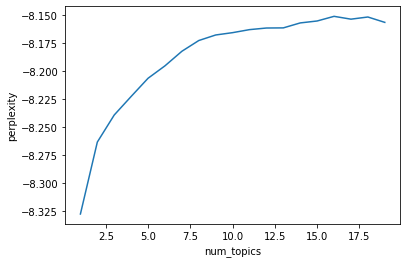

In [45]:
limit = 20
x = range(1, limit)
plt.plot(x, perp)
plt.xlabel("num_topics")
plt.ylabel("perplexity")
plt.show()

In [110]:
pd.set_option('display.max_colwidth', 10000)
def topic_display(lda_model):
    topics = lda_model.show_topics(formatted=False, num_topics=20)
    return(pd.DataFrame([[idx, [x for x,y in words]] for idx,words in topics ]).set_index(0).sort_index())

In [114]:
topic_display(lmlist[18])

,1
0,
0,"[afghanistan, pakistan, india, afghan, bangladesh, sri, lanka, asia, myanmar, indian]"
1,"[small, climate, island, caribbean, sustainable, saint, barbados, address, bahamas, taiwan]"
2,"[europe, soviet, co, union, disarmament, european, treaty, proposal, detente, strengthening]"
3,"[struggle, viet, nam, aggression, imperialist, china, imperialism, kampuchea, asia, sovereignty]"
4,"[israel, arab, israeli, lebanon, palestine, egypt, lebanese, occupied, land, jordan]"
5,"[arab, iraq, kuwait, iraqi, israeli, al, yemen, kingdom, terrorism, gulf]"
6,"[per, cent, million, democracy, say, america, know, want, century, poor]"
7,"[co, regime, sea, southern, certain, colonial, mankind, namibia, struggle, zimbabwe]"
8,"[terrorism, iraq, terrorist, iran, aggression, regime, islamic, attack, libya, victim]"


# Test Mallet wrapper

# Dynamic : ldqseqmodel

In [5]:
from gensim.models import LdaSeqModel

In [6]:
time_slice = pd.DataFrame(docs.year.value_counts()).reset_index().sort_values(by="index").reset_index().drop(columns=["level_0", "index"]).values.reshape((1,46))[0]
time_slice

array([ 70, 116, 125, 120, 129, 126, 134, 140, 141, 144, 149, 145, 147,
       149, 150, 137, 149, 152, 154, 153, 156, 162, 167, 175, 178, 172,
       181, 176, 181, 181, 178, 189, 188, 189, 192, 185, 193, 191, 192,
       193, 189, 194, 195, 193, 194, 193])

## -> Not working, LDA is too long/infinite

In [ ]:
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldaseq = LdaSeqModel(corpus=corpus, id2word=id2word, time_slice=time_slice, num_topics=10)

In [ ]:
ldaseq.save("data/06_models/ldaseqmodel")

In [ ]:
ldaseq.print_topic_times(topic=0, top_terms=3)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
topic = 0

pd.DataFrame(ldaseq.print_topic_times(topic=topic)).plot()

axes = plt.gca()
plt.show()